In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

os.environ['CUDA_VISIBLE_DEVICES']="1"


from keras.layers import Dense, Input, Dropout
from keras.models import Model

import omnifold8a as of

import tensorflow as tf


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.26.4
  tensorflow version:  2.13.1





## Set model and resolution parameters

In [3]:
ndim = 1

##-------------

train_mu = [ 0.0 ]



train_rho = [ [0.0] ]






train_sig = [ 1.0 ]


##-------------


true_mu = [ 0.2 ]






true_rho  = [ [0.0] ]



true_sig = [ 0.9 ]


#--- perfect
#resolution = [ 0.0001  ]

#--- good
resolution = [ 0.25  ]

#--- nominal
#resolution = [ 0.5  ]

#--- poor
#resolution = [ 1.0  ]






train_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n Train covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            train_cov[i][j] = train_sig[i] * train_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, train_cov[i][j]))
        else :
            k = ndim - j - 1
            train_cov[i][j] = train_sig[i] * train_sig[j] * train_rho[i][k]
            train_cov[j][i] = train_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, train_sig[i], train_sig[j], train_rho[i][k], train_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
#-- about 10 seconds
#ngen_train = 10000
#ngen_true =   1000              

                
#-- about 62 seconds
#ngen_train = 100000
#ngen_true =    1000       


#-- about 37  (29 in of8a)  seconds
ngen_train = 100000
ngen_true =   10000

#-- about 47  (38 in of8a)  seconds
#ngen_train = 1000000
#ngen_true =   100000

#-- about 1   (56 seconds) minute
#ngen_train = 2000000
#ngen_true =   200000

#-- about 1:50  (1:48 in of8a)
#ngen_train = 4000000
#ngen_true =   400000

#-- about 5 min
#ngen_train = 10000000
#ngen_true =   1000000







of_niter = 5

#learning_rate_setval = 0.0005
#epochs_setval = 40

#learning_rate_setval = 0.0001
#epochs_setval = 10

#learning_rate_setval = 0.00002
#epochs_setval = 40

#learning_rate_setval = 0.0005
#epochs_setval = 10

#learning_rate_setval = 0.0010
#epochs_setval = 10

#learning_rate_setval = 0.0008
#epochs_setval = 10


#learning_rate_setval = 0.0005
#epochs_setval = 20


learning_rate_setval = 0.0005
epochs_setval = 40



#dropout_setval = 0.02

#dropout_setval = 0.10

dropout_setval = 0.0




do_bootstrap = False

n_boot_samples = 1000





batch_size_setval = int( ngen_true )



output_dir = 'bootstrap-toy-study8a-1d-1d'

save_step2_model = True





 Train covariance:
   0,  0 : diagonal    1.0000



 True covariance:
   0,  0 : diagonal    0.8100


In [4]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()

In [5]:
print("\n\n")
print("Train covariance determinant:  %f" % np.linalg.det( train_cov ) )
print("True covariance determinant:   %f" % np.linalg.det( true_cov ) )
print("\n\n")




Train covariance determinant:  1.000000
True covariance determinant:   0.810000





In [6]:
train_cov_inv = np.linalg.inv( train_cov )

In [7]:
train_cov_inv_test = np.matmul( train_cov, train_cov_inv )

In [8]:
print("\n\n")
print(" Train covariance")
print( train_cov )
print("\n Train covariance inverse")
print( train_cov_inv )
print("\n Train covariance inverse test")
print(train_cov_inv_test)
print("\n\n")




 Train covariance
[[1.]]

 Train covariance inverse
[[1.]]

 Train covariance inverse test
[[1.]]





In [9]:
true_cov_inv = np.linalg.inv( true_cov )

In [10]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [11]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[0.81]]

 True covariance inverse
[[1.2345679]]

 True covariance inverse test
[[1.]]





## Generate samples, save events and config

In [12]:


train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)
true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)

train_det_pts = np.random.normal( train_pts, resolution )

true_det_pts = np.random.normal( true_pts, resolution )


true_pts10x = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true*40)
true_det_pts10x = np.random.normal( true_pts10x, resolution )
true_pts10x_weights = np.ones( ngen_true*40 )
true_pts10x_weights = (1./40.) * true_pts10x_weights


In [13]:
with open( '%s/train-and-true-samples.npy' % output_dir, 'wb') as f :
    np.save(f, train_pts)
    np.save(f, train_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)

In [14]:
with open( '%s/config-pars.npy' % output_dir , 'wb' ) as f :
    np.save( f, train_mu )
    np.save( f, train_rho )
    np.save( f, train_sig )
    np.save( f, true_mu )
    np.save( f, true_rho )
    np.save( f, true_sig )
    np.save( f, resolution )
    np.save( f, train_cov )
    np.save( f, true_cov )

In [15]:
config_filename = '%s/config.txt' % output_dir

config_file = open( config_filename, 'w' )

config_file.write('%s\n\n' % datetime.now() )
config_file.write('ngen_train %d\n' % ngen_train )
config_file.write('ngen_true  %d\n' % ngen_true )
config_file.write('of_niter   %d\n' % of_niter )
config_file.write('ndim       %d\n' % ndim )
config_file.write('learning_rate_setval  %f\n' % learning_rate_setval )
config_file.write('epochs_setval  %d\n' % epochs_setval )
config_file.write('batch_size_setval  %d\n' % batch_size_setval )


config_file.write('\n\n')
config_file.write('train_mu : %s\n' % str(train_mu))
config_file.write('train_rho : %s\n' % str(train_rho))
config_file.write('train_sig : %s\n' % str(train_sig))
config_file.write('train_cov : %s\n' % str(train_cov))
config_file.write('\n\n')
config_file.write('true_mu : %s\n' % str(true_mu))
config_file.write('true_rho : %s\n' % str(true_rho))
config_file.write('true_sig : %s\n' % str(true_sig))
config_file.write('true_cov : %s\n' % str(true_cov))
config_file.write('\n\n')
config_file.write('resolution : %s\n' % str(resolution) )
config_file.close()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : bootstrap-toy-study8a-1d-1d/config.txt

2024-07-10 08:34:48.774545

ngen_train 100000
ngen_true  10000
of_niter   5
ndim       1
learning_rate_setval  0.000500
epochs_setval  40
batch_size_setval  10000


train_mu : [0.0]
train_rho : [[0.0]]
train_sig : [1.0]
train_cov : [[1.]]


true_mu : [0.2]
true_rho : [[0.0]]
true_sig : [0.9]
true_cov : [[0.81]]


resolution : [0.25]





## Plots to visualize these parameter choices

<function matplotlib.pyplot.show(close=None, block=None)>

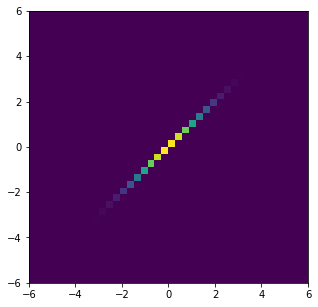

In [16]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
            
        thisax.hist2d( train_pts[:,i], train_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

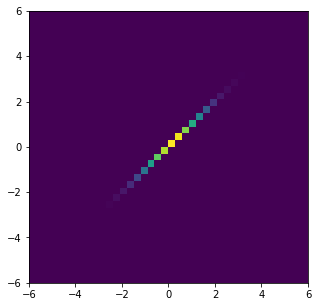

In [17]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim > 1 :
            thisax = ax[i][j]
        else :
            thisax = ax
        thisax.hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

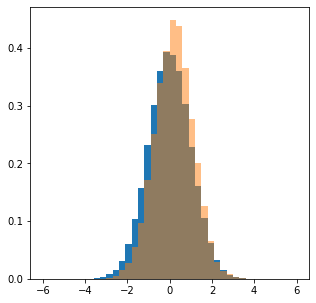

In [18]:
fig,ax = plt.subplots( 1, ndim, figsize=(ndim*5,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        if ndim > 1 :
            thisax = ax[i]
        else :
            thisax = ax
        thisax.hist( train_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        thisax.hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

### Calculate true weights analytically and compare with unfolding output weights.

In [19]:
train_pts_minus_train_mu = train_pts - train_mu
print(train_pts_minus_train_mu)

[[-0.14445399]
 [-1.86798154]
 [-1.62436832]
 ...
 [ 1.82188907]
 [-0.36173988]
 [-1.98345274]]


In [20]:
train_pts_minus_true_mu = train_pts - true_mu
print(train_pts_minus_true_mu)

[[-0.34445399]
 [-2.06798154]
 [-1.82436832]
 ...
 [ 1.62188907]
 [-0.56173988]
 [-2.18345274]]


In [21]:
true_cov_inv_times_v = np.tensordot( true_cov_inv, train_pts_minus_true_mu.T, axes=(1,0) )

In [22]:
v_times_true_cov_inv_times_v =  np.sum( train_pts_minus_true_mu.T * true_cov_inv_times_v, axis=0)

In [23]:
train_cov_inv_times_v = np.tensordot( train_cov_inv, train_pts_minus_train_mu.T, axes=(1,0) )

In [24]:
v_times_train_cov_inv_times_v =  np.sum( train_pts_minus_train_mu.T * train_cov_inv_times_v, axis=0)

In [25]:
exp_v_times_train_cov_inv_times_v = np.exp( -0.5 * v_times_train_cov_inv_times_v )
exp_v_times_true_cov_inv_times_v  = np.exp( -0.5 * v_times_true_cov_inv_times_v  )

In [26]:
true_cov_det = np.linalg.det( true_cov )
train_cov_det = np.linalg.det( train_cov )

In [27]:
norm2_true = np.power( 3.14159265, ndim) * true_cov_det
print("\n norm2_true : %f\n" % norm2_true )


 norm2_true : 2.544690



In [28]:
norm2_train = np.power( 3.14159265, ndim) * train_cov_det
print("\n norm2_train : %f\n" % norm2_train )


 norm2_train : 3.141593



In [29]:
pdf_train = exp_v_times_train_cov_inv_times_v / np.sqrt(norm2_train)
print(pdf_train)

[0.55833373 0.09856466 0.15082257 ... 0.10731307 0.52845754 0.07891316]


In [30]:
pdf_true = exp_v_times_true_cov_inv_times_v / np.sqrt(norm2_true)
print(pdf_true)

[0.58260592 0.04474173 0.08033718 ... 0.12359011 0.5159273  0.03304501]


In [31]:
pdf_ratio = pdf_true / pdf_train

In [32]:
sample_sf = (1.*len(true_pts))/(1.*len(train_pts))
print('\n sample_sf = %f' % sample_sf )


 sample_sf = 0.100000


In [33]:
calc_weight = pdf_ratio

In [34]:
calc_weight_scaled = sample_sf * pdf_ratio

## Set up NN model for OmniFold

In [35]:

import tensorflow.keras.backend as K


def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss

    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))

    return K.mean(t_loss)

In [36]:


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(20, activation='relu')(inputs)
#hidden_layer_2 = Dense(20, activation='relu')(hidden_layer_1)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_2)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_2)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
#hidden_layer_4 = Dense(50, activation='relu')(hidden_layer_3)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_4)

#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_1)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(20, activation='relu')(inputs)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_1)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(200, activation='relu')(inputs)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_1)

#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(150, activation='relu')(inputs)
#hidden_layer_2 = Dense(150, activation='relu')(hidden_layer_1)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_2)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#hidden_layer_2 = Dense(10, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(5, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(5, activation='relu')(inputs)
#hidden_layer_2 = Dense(10, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(30, activation='relu')(inputs)
#hidden_layer_2 = Dense(40, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)


#inputs = Input((ndim, ))
#hidden_layer_1 = Dense(20, activation='relu')(inputs)
#hidden_layer_2 = Dense(20, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(20, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)



inputs = Input((ndim, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
drop1 = Dropout(dropout_setval)(hidden_layer_1)
hidden_layer_2 = Dense(50, activation='relu')(drop1)
drop2 = Dropout(dropout_setval)(hidden_layer_2)
hidden_layer_3 = Dense(50, activation='relu')(drop2)
drop3 = Dropout(dropout_setval)(hidden_layer_3)
outputs = Dense(1, activation='sigmoid')(drop3)








model_step1 = Model(inputs=inputs, outputs=outputs)
model_step2 = Model(inputs=inputs, outputs=outputs)

opt_step1 = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval )
opt_step2 = tf.keras.optimizers.Adam( learning_rate=(0.04*learning_rate_setval) )  # owen: use lower learning rate in step 2

model_step1.compile(loss=weighted_binary_crossentropy,
                      optimizer=opt_step1,
                      metrics=['accuracy'])

model_step2.compile(loss=weighted_binary_crossentropy,
                      optimizer=opt_step2,
                      metrics=['accuracy'])


## Package the training data for OmniFold

In [37]:
train_both = np.stack([train_pts, train_det_pts], axis=1)

## Run OmniFold

In [38]:
%%time


#verbose = True
verbose = False






of_return_dict = of.omnifold8a( 
    train_both, true_det_pts, of_niter, model_step1, model_step2, verbose, 
    batch_size_setval, epochs_setval,
    save_step2_model, output_dir
)

of_weights = of_return_dict["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))

push_weights = of_return_dict["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = of_return_dict["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)


 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06000495 0.50697613 0.56750292 ... 1.13130105 1.01052403 0.48056063]
10/10 [==============================] - 0s 616us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07238354 0.48200211 0.54502726 ... 1.13242714 1.01615211 0.45452765]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04673615 0.4810992  0.54297075 ... 1.14268993 0.99117957 0.45324986]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02623475 0.47875739 0.54489904 ... 1.13648712 0.99506483 0.44929459]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/of-step2-iter04-model/assets


CPU times: user 34.4 s, sys: 6.74 s, total: 41.2 s
Wall time: 28.1 s


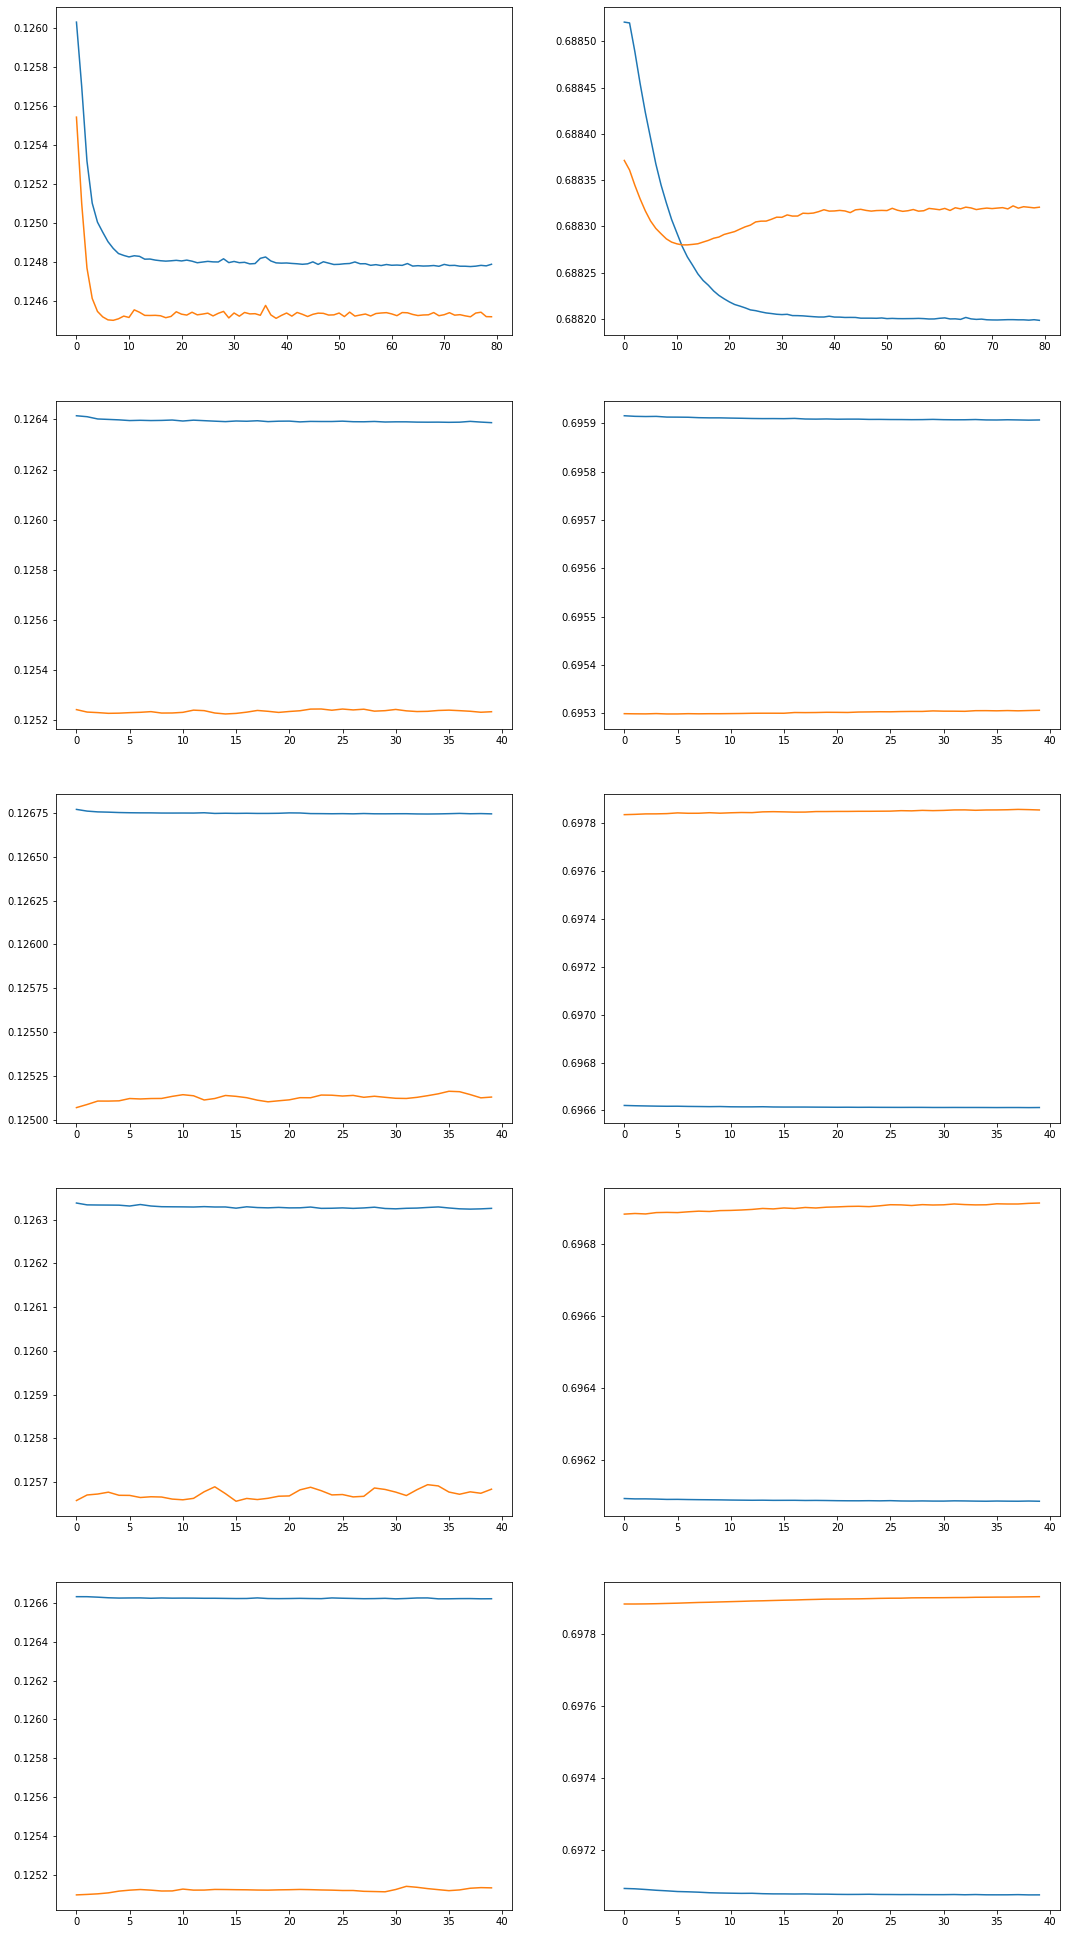

In [39]:
fig,ax = plt.subplots( of_niter, 2, figsize=(18,7*of_niter))

for ofi in range(0,of_niter) :
    
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['loss']  )
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['val_loss']  )

    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['loss']  )
    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['val_loss']  )
    



<function matplotlib.pyplot.show(close=None, block=None)>

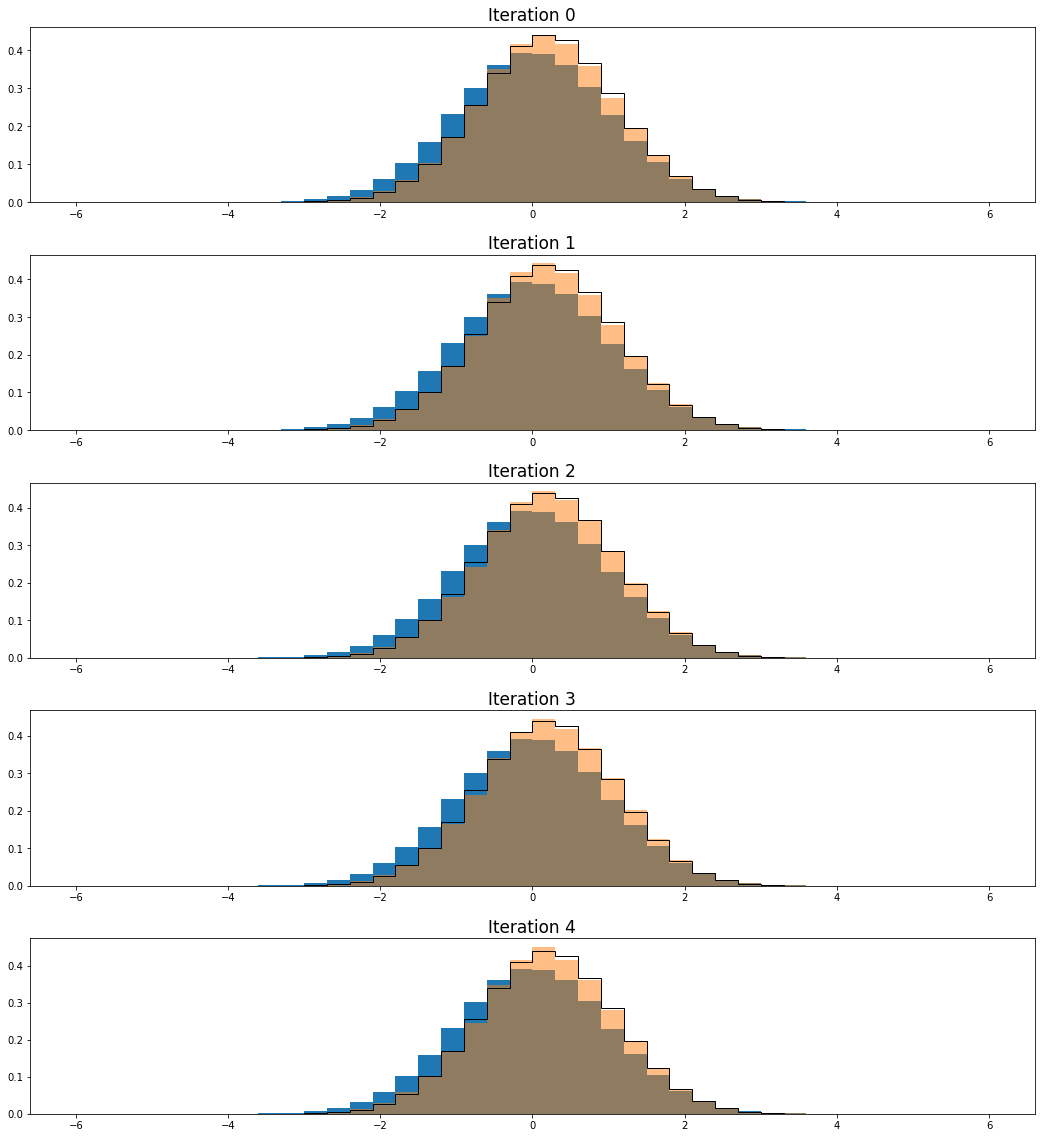

In [40]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
                
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
 
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
        
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [41]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

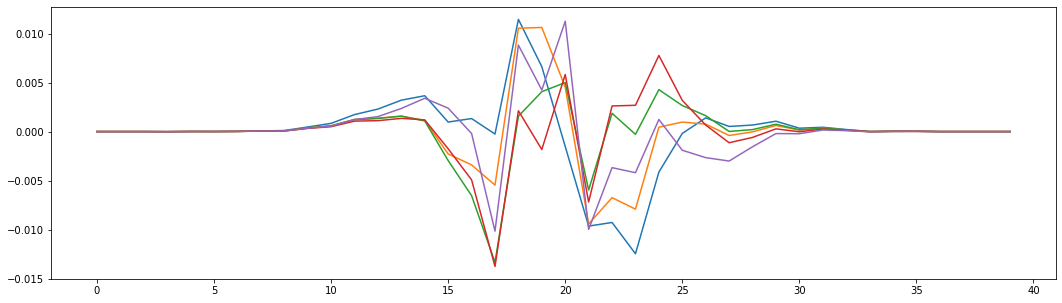

In [42]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

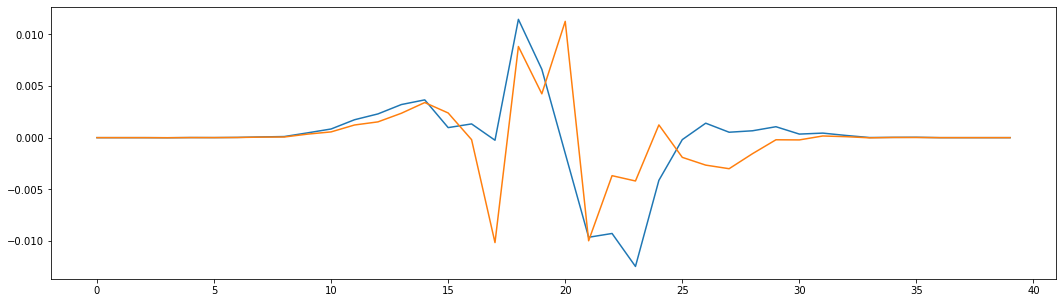

In [43]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])
    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

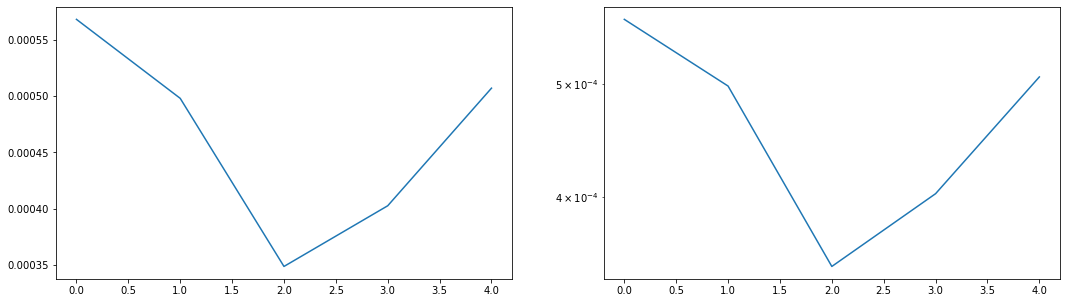

In [44]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( hist_data_sum_diff2)
ax[1].plot( hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

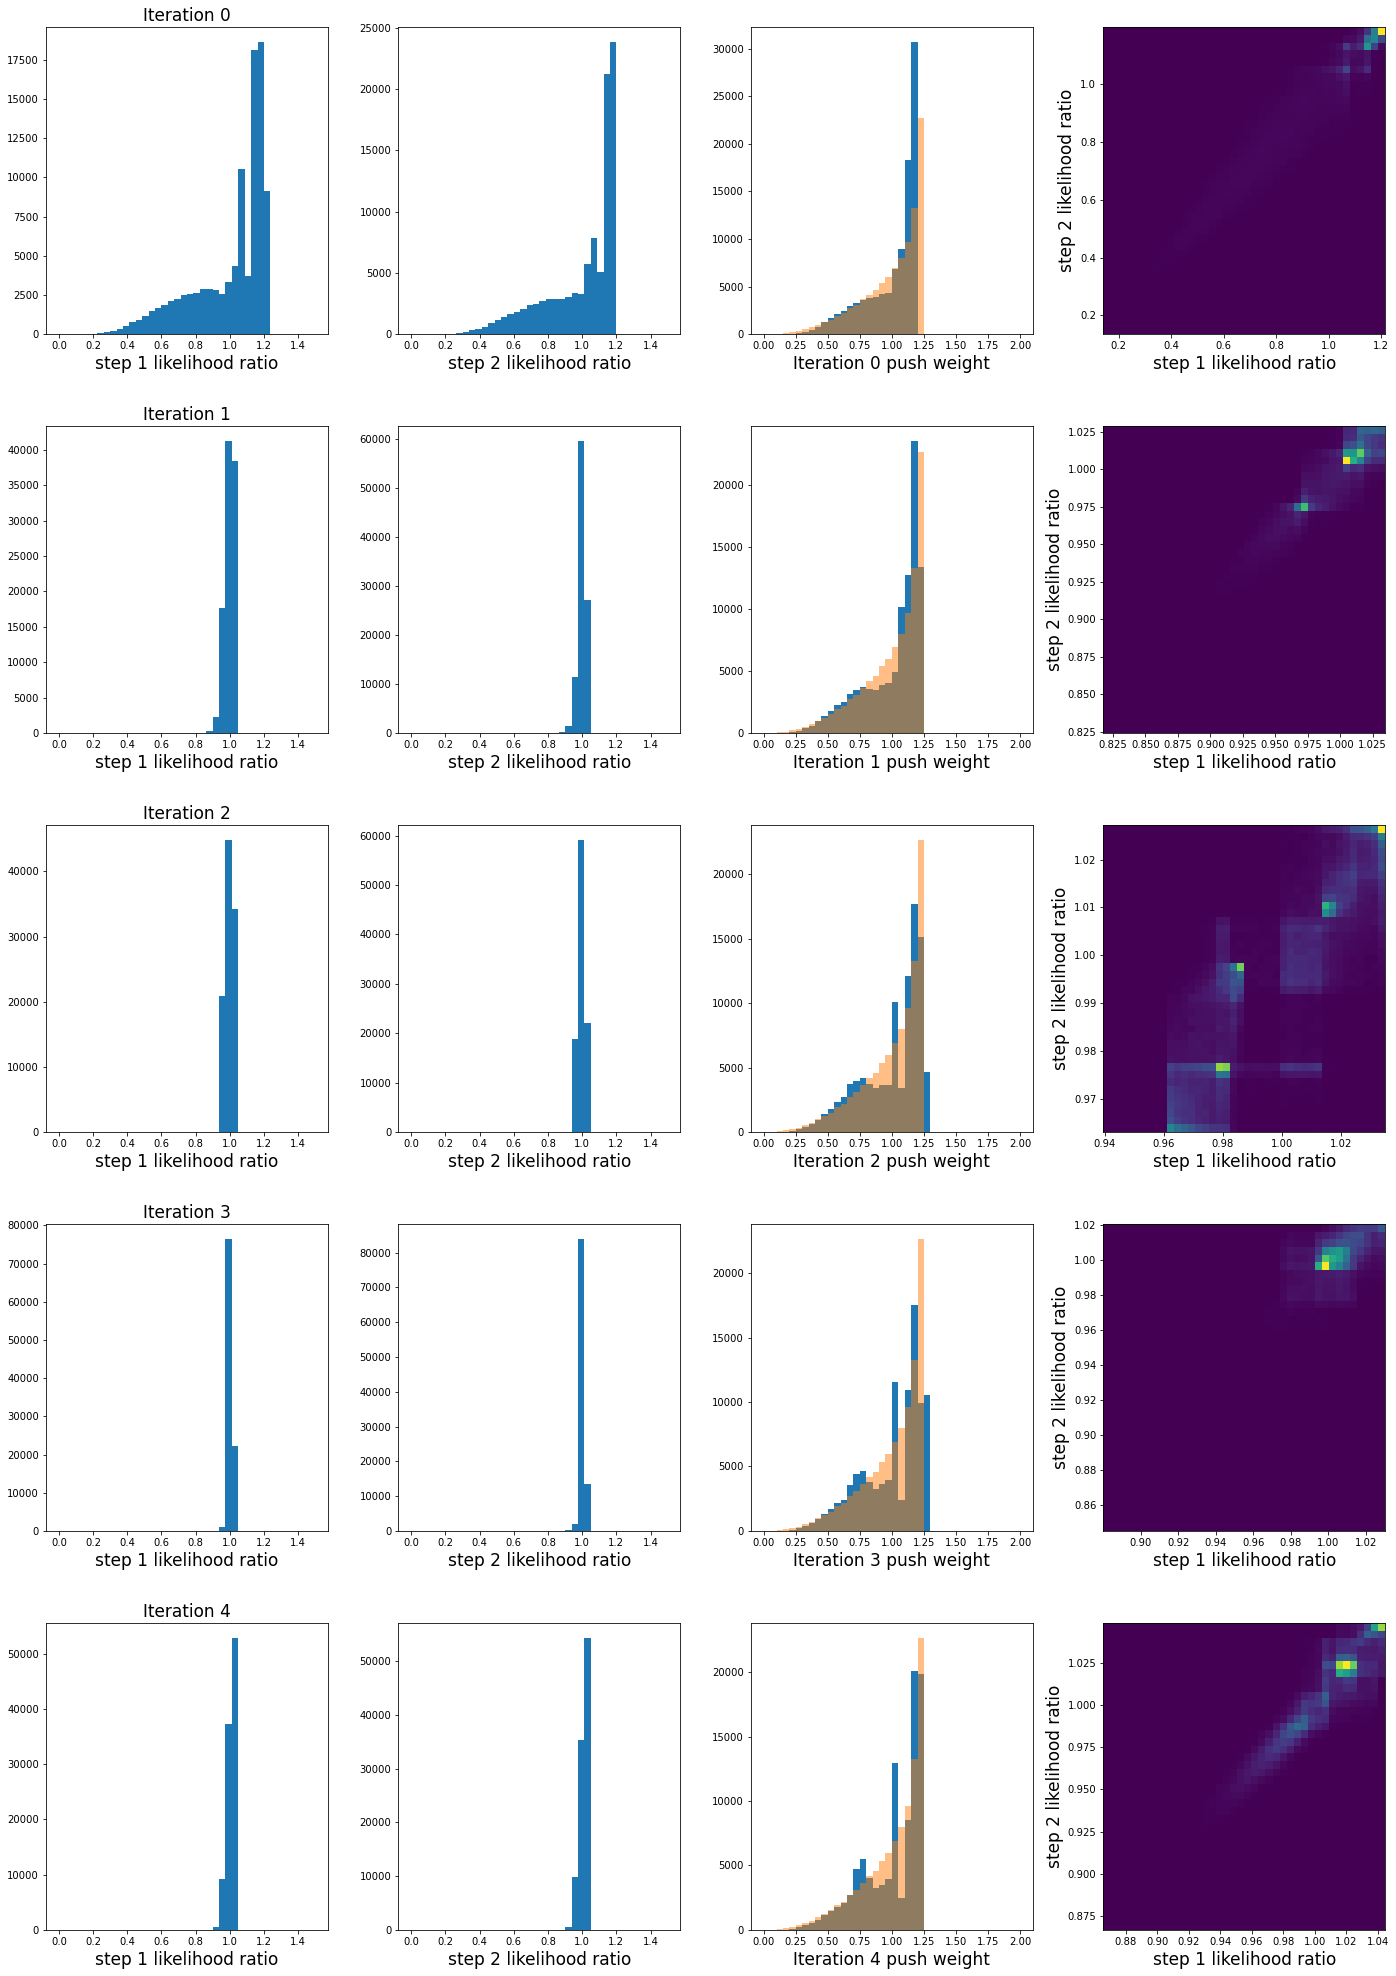

In [45]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,2.0] )
    ax[ofi][2].hist( calc_weight, bins=hbins, range=[0.,2.0], alpha=0.5 )
    
    
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'Iteration %d push weight' % ofi, fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

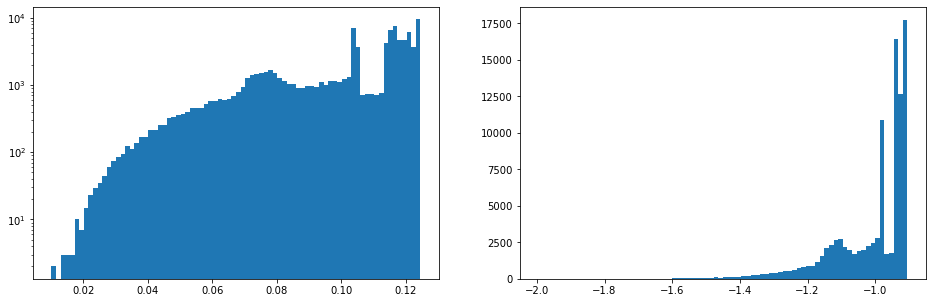

In [46]:
fig,ax = plt.subplots( 1, 2, figsize=(8*2,5))

hbins=80

ax[0].hist( final_push_weights_scaled, bins=hbins)
ax[0].set_yscale('log')

ax[1].hist( np.log10(final_push_weights_scaled), bins=hbins)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

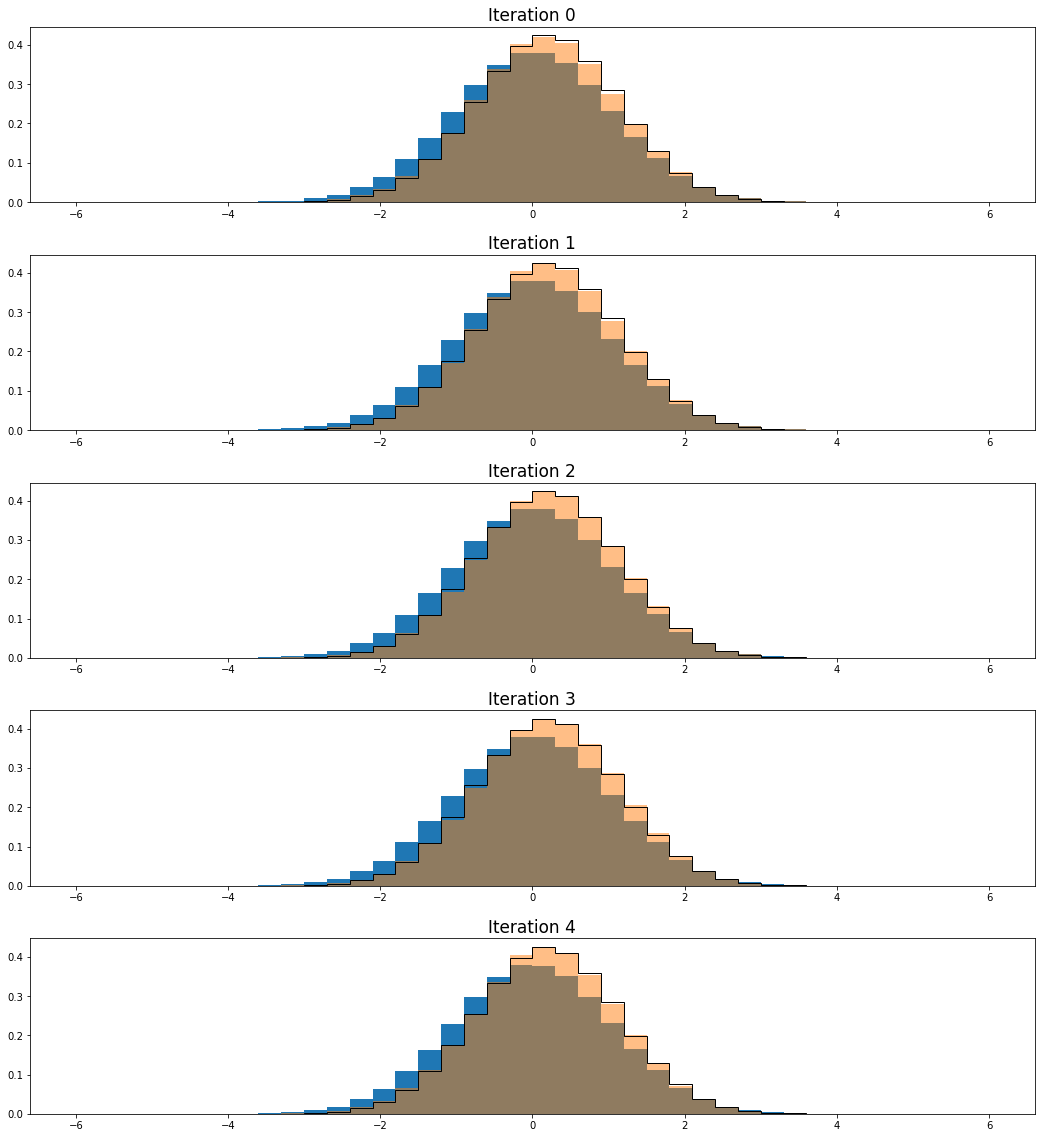

In [47]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
#    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
#    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
    
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [48]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

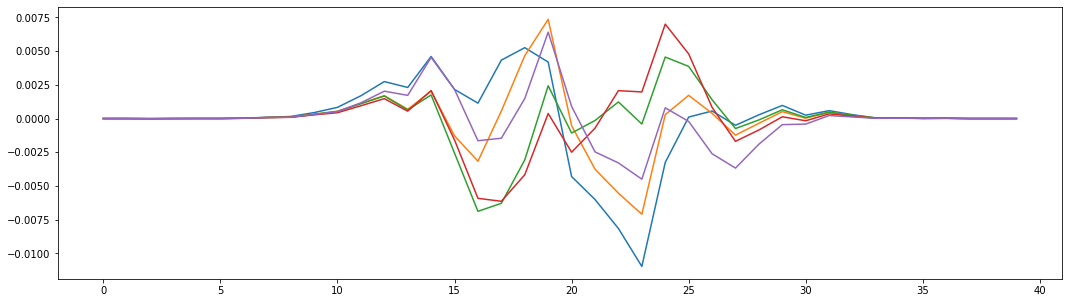

In [49]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

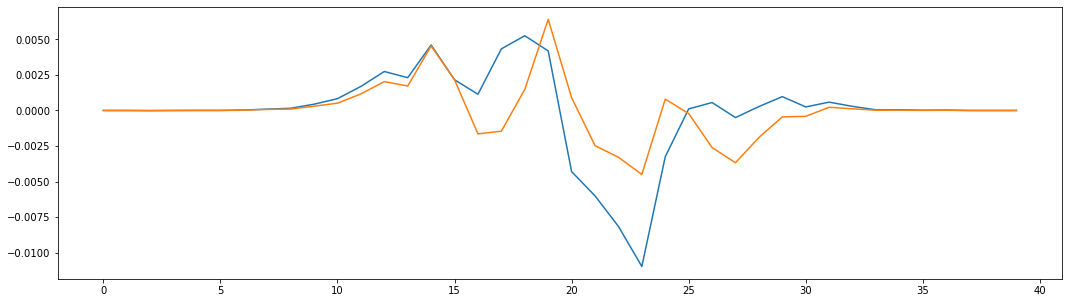

In [50]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

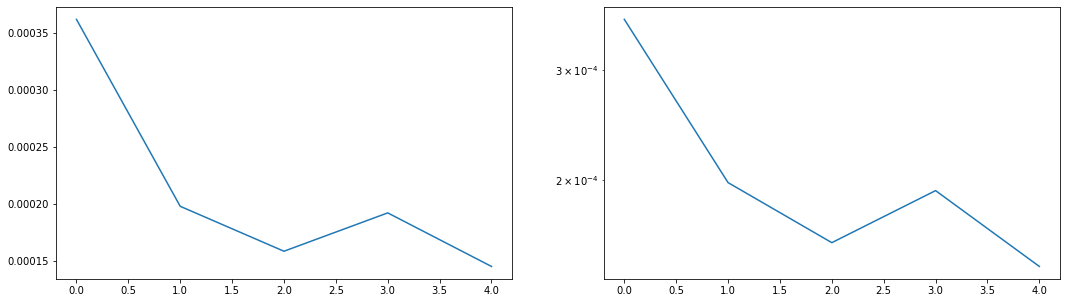

In [51]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( det_hist_data_sum_diff2)
ax[1].plot( det_hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [52]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  1.004  rms 0.216      step 2 mean  1.001  rms 0.209
  iter  1 : step 1 mean  1.000  rms 0.025      step 2 mean  0.999  rms 0.022
  iter  2 : step 1 mean  0.997  rms 0.023      step 2 mean  0.995  rms 0.019
  iter  3 : step 1 mean  1.004  rms 0.012      step 2 mean  1.001  rms 0.012
  iter  4 : step 1 mean  1.009  rms 0.024      step 2 mean  1.009  rms 0.025


<function matplotlib.pyplot.show(close=None, block=None)>

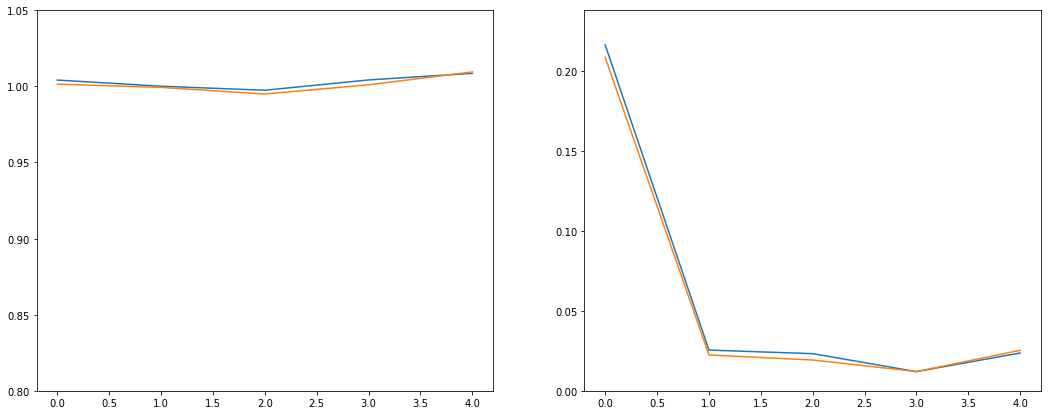

In [53]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

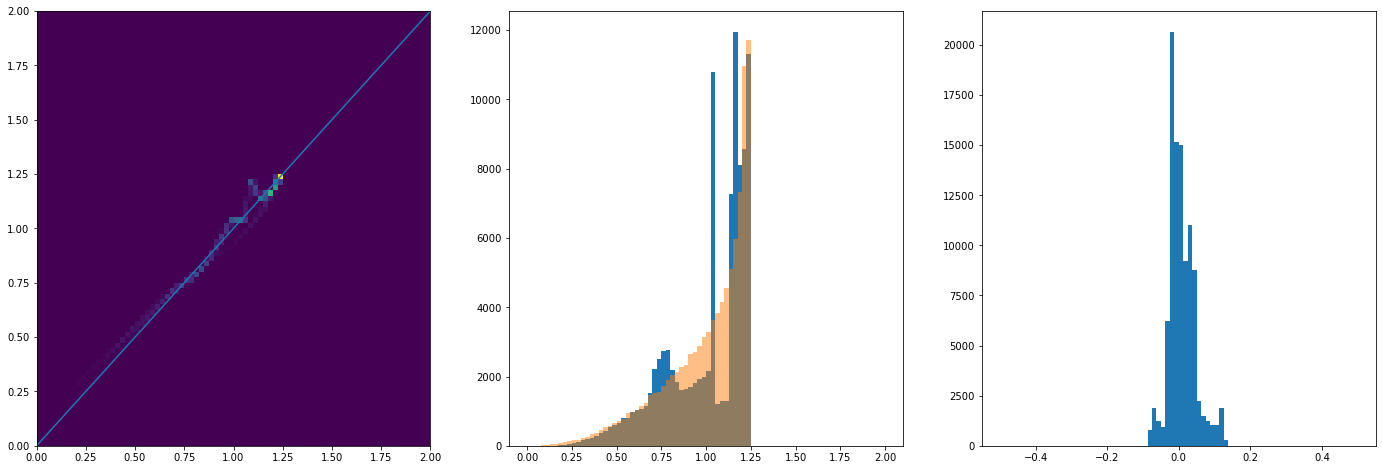

In [54]:
fig,ax = plt.subplots( 1, 3, figsize=(3*8,1*8))
max_weight = 2.0

ax[0].hist2d( calc_weight, final_push_weights, bins=[80,80], range=([0,max_weight],[0,max_weight]))
ax[0].plot([0,max_weight],[0,max_weight])

ax[1].hist( final_push_weights, bins=80, range=[0,max_weight] )
ax[1].hist( calc_weight, bins=80, range=[0,max_weight], alpha=0.5 )

ax[2].hist( final_push_weights-calc_weight, bins=80, range=[-0.5,0.5] )

plt.show

In [55]:

delta_weight_rms = np.sqrt( np.var( np.clip(final_push_weights-calc_weight,-0.5,0.5 ) ) )
print('\n\n Delta weight RMS:  %.5f\n\n' % delta_weight_rms )



 Delta weight RMS:  0.03636




In [56]:

verbose = False



import gc

In [57]:
try:
    os.mkdir( "%s/bootstrap-nn-models" % output_dir )
except :
    print('problem creating bootstrap-nn-models dir')


In [58]:
%%time

rng = np.random.default_rng()

for bi in range(0,n_boot_samples) :
    
    if do_bootstrap :
        print("\n Creating bootstrap sample %3d" % bi )
        boot_true_det_pts = rng.choice( true_det_pts, size=len(true_det_pts) )
        
    else :
        print("\n Creating toy sample %3d" % bi )
        boot_true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)
        boot_true_det_pts = np.random.normal( boot_true_pts, resolution )
        
    modeldir = "%s/bootstrap-nn-models/bs-%03d" % (output_dir, bi) 
    
    try:
        os.mkdir( modeldir )
    except :
        print('\n\n *** probelm creating model output directory : %s' % modeldir )

        

    #-- Reset the model to ensure fresh random weights for each bootstrap

    inputs = Input((ndim, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    drop1 = Dropout(dropout_setval)(hidden_layer_1)
    hidden_layer_2 = Dense(50, activation='relu')(drop1)
    drop2 = Dropout(dropout_setval)(hidden_layer_2)
    hidden_layer_3 = Dense(50, activation='relu')(drop2)
    drop3 = Dropout(dropout_setval)(hidden_layer_3)
    outputs = Dense(1, activation='sigmoid')(drop3)


    model_step1 = Model(inputs=inputs, outputs=outputs)
    model_step2 = Model(inputs=inputs, outputs=outputs)

    opt_step1 = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval )
    opt_step2 = tf.keras.optimizers.Adam( learning_rate=(0.04*learning_rate_setval) )  # owen: use lower learning rate in step 2

    model_step1.compile(loss=weighted_binary_crossentropy,
                          optimizer=opt_step1,
                          metrics=['accuracy'])

    model_step2.compile(loss=weighted_binary_crossentropy,
                          optimizer=opt_step2,
                          metrics=['accuracy'])
        
        
        
        
        
    boot_of_return_dict = of.omnifold8a( 
        train_both, boot_true_det_pts, of_niter, model_step1, model_step2, verbose, 
        batch_size_setval, epochs_setval, True, modeldir )



    mc_weight_sf = (1.*len(boot_true_det_pts))/(1.*len(train_both))



    boot_final_push_weights = boot_of_return_dict["final_push_weights"]
    boot_final_push_weights_scaled = boot_final_push_weights
    boot_final_push_weights_scaled = mc_weight_sf * boot_final_push_weights
    
    print("\n\n bootstrap %d final push weights scaled:" % bi)
    print( boot_final_push_weights_scaled )

     
    with open( '%s/bootstrap-weights-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_final_push_weights_scaled )

    with open( '%s/bootstrap-points-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_true_det_pts )
        
        
    del boot_final_push_weights_scaled
    del boot_of_return_dict
    gc.collect()
    
    


 Creating toy sample   0
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-000/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-000/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-000/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0343802  0.51779139 0.57928276 ... 1.14305103 1.0303086  0.49096948]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-000/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-000/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-000/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01513408 0.48495491 0.54867716 ... 1.19364713 1.01536057 0.45739137]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-000/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-000/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-000/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00030001 0.44838767 0.51455803 ... 1.17575809 1.00437652 0.41946998]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-000/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-000/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-000/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0054681  0.45295215 0.52423762 ... 1.1349345  1.02298547 0.42203462]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-000/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-000/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-000/of-step2-iter04-model/assets




 bootstrap 0 final push weights scaled:
[0.10057795 0.04638448 0.05397409 ... 0.11415537 0.10540743 0.04310812]

 Creating toy sample   1
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-001/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-001/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-001/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07217216 0.53160703 0.59134173 ... 1.13888896 0.99512863 0.50517148]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-001/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-001/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-001/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1080771  0.49189653 0.55297287 ... 1.09979638 0.98703087 0.4651169 ]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-001/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-001/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-001/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13747402 0.47980926 0.54314377 ... 1.15331816 0.99448248 0.45219043]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-001/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-001/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-001/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1521991  0.46964468 0.53380805 ... 1.09619318 0.98649703 0.44155848]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-001/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-001/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-001/of-step2-iter04-model/assets




 bootstrap 1 final push weights scaled:
[0.11539553 0.049263   0.05564681 ... 0.11093648 0.09742884 0.04644485]

 Creating toy sample   2
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-002/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-002/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-002/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04633987 0.50406432 0.56740099 ... 1.11302745 0.97418582 0.47656342]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-002/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-002/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-002/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07785202 0.47757961 0.54709677 ... 1.11963468 0.9950602  0.44780279]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-002/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-002/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-002/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04826021 0.4560274  0.52784431 ... 1.14746602 0.95951043 0.42550102]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-002/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-002/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-002/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04807151 0.46668467 0.54458831 ... 1.14000632 0.96207809 0.43373124]
10/10 [==============================] - 0s 787us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-002/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-002/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-002/of-step2-iter04-model/assets




 bootstrap 2 final push weights scaled:
[0.10498965 0.04671259 0.05513301 ... 0.11441784 0.09657823 0.0431809 ]

 Creating toy sample   3
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-003/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-003/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-003/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08336198 0.50113493 0.56060857 ... 1.00615478 1.01644552 0.47519162]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-003/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-003/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-003/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07052434 0.471724   0.53247812 ... 1.02463367 1.01313577 0.44539922]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-003/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-003/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-003/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10636325 0.45837338 0.52178766 ... 0.99404194 1.04097372 0.43106276]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-003/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-003/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-003/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10423397 0.43789009 0.50349233 ... 1.05022292 1.04584291 0.40961912]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-003/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-003/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-003/of-step2-iter04-model/assets




 bootstrap 3 final push weights scaled:
[0.11059197 0.04497881 0.05148266 ... 0.10666203 0.10517976 0.04214505]

 Creating toy sample   4
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-004/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-004/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-004/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02786469 0.51145738 0.57653272 ... 1.18024039 1.04125309 0.48323128]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-004/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-004/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-004/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02237243 0.47062052 0.53842013 ... 1.14563764 1.0514078  0.44153581]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-004/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-004/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-004/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00036528 0.47249176 0.53939882 ... 1.1070197  1.04818155 0.44374391]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-004/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-004/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-004/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9630147  0.4608736  0.52863258 ... 1.11275894 1.05374545 0.4318623 ]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-004/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-004/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-004/of-step2-iter04-model/assets




 bootstrap 4 final push weights scaled:
[0.097538   0.04330681 0.05009062 ... 0.11277247 0.10621405 0.04042035]

 Creating toy sample   5
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-005/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-005/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-005/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07432306 0.48453119 0.55438733 ... 1.1605854  1.000862   0.45448589]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-005/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-005/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-005/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05847474 0.44293408 0.51316136 ... 1.14469305 0.98203808 0.41301625]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-005/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-005/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-005/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03999662 0.43141538 0.50248862 ... 1.11566454 0.96362298 0.4012601 ]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-005/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-005/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-005/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05379802 0.46347229 0.53813918 ... 1.15351418 0.98923031 0.43171653]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-005/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-005/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-005/of-step2-iter04-model/assets




 bootstrap 5 final push weights scaled:
[0.10348546 0.04219768 0.04995916 ... 0.11469523 0.09750689 0.03894534]

 Creating toy sample   6
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-006/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-006/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-006/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05396378 0.55384153 0.61141104 ... 1.18683839 0.99013358 0.52848005]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-006/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-006/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-006/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02910979 0.5305821  0.59380323 ... 1.1094417  0.96993157 0.50301295]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-006/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-006/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-006/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01959815 0.50671532 0.57243363 ... 1.0559379  0.95097221 0.47828273]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-006/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-006/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-006/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02795428 0.50997038 0.57714065 ... 1.08490121 0.9599541  0.48094776]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-006/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-006/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-006/of-step2-iter04-model/assets




 bootstrap 6 final push weights scaled:
[0.10431398 0.05232458 0.05935839 ... 0.10438797 0.097894   0.04929081]

 Creating toy sample   7
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-007/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-007/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-007/of-step2-iter00-model/assets


 weights_push at the beginning
[1.12072086 0.50689405 0.56850195 ... 1.09278905 1.02335978 0.48007086]
10/10 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-007/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-007/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-007/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11861245 0.45978098 0.52329987 ... 1.05775023 0.99277814 0.43242705]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-007/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-007/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-007/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1320659  0.47298146 0.53741721 ... 1.08367005 0.98349495 0.44519773]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-007/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-007/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-007/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15507359 0.44615191 0.51249748 ... 1.07365516 0.96820657 0.41756836]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-007/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-007/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-007/of-step2-iter04-model/assets




 bootstrap 7 final push weights scaled:
[0.12040272 0.04591526 0.05272844 ... 0.10332699 0.09667232 0.0429793 ]

 Creating toy sample   8
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-008/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-008/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-008/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01521945 0.49620238 0.55434138 ... 1.04938424 0.98895115 0.47109929]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-008/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-008/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-008/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01232166 0.47478775 0.53738004 ... 1.11299235 1.01753752 0.44815221]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-008/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-008/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-008/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00226676 0.45545607 0.51826283 ... 1.09023412 1.01436929 0.42849946]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-008/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-008/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-008/of-step2-iter03-model/assets


 weights_push at the beginning
[0.94150181 0.48879138 0.54945896 ... 1.0973634  0.99946278 0.46252561]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-008/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-008/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-008/of-step2-iter04-model/assets




 bootstrap 8 final push weights scaled:
[0.0921809  0.04892685 0.05525003 ... 0.10979247 0.10129692 0.04619879]

 Creating toy sample   9
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-009/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-009/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-009/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00742948 0.48996711 0.55448353 ... 1.17355156 0.98875958 0.46206722]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-009/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-009/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-009/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02054853 0.43373896 0.50602649 ... 1.20088278 0.99774629 0.40317989]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-009/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-009/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-009/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02060328 0.43969323 0.51314986 ... 1.16965994 0.99682182 0.40854788]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-009/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-009/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-009/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99031425 0.44450508 0.51671075 ... 1.19950112 0.97370396 0.41378669]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-009/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-009/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-009/of-step2-iter04-model/assets




 bootstrap 9 final push weights scaled:
[0.09933337 0.0445834  0.05192138 ... 0.11809475 0.09904541 0.04146606]

 Creating toy sample  10
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-010/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-010/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-010/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03929114 0.51947445 0.58403838 ... 1.17500663 0.98696196 0.49316055]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-010/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-010/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-010/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04045636 0.47698516 0.54286035 ... 1.1804141  0.97321638 0.45020875]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-010/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-010/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-010/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04809785 0.46312061 0.53129337 ... 1.17242739 0.97360631 0.43541967]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-010/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-010/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-010/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04583857 0.46640253 0.53568832 ... 1.14129043 0.96532255 0.43821409]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-010/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-010/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-010/of-step2-iter04-model/assets




 bootstrap 10 final push weights scaled:
[0.10456932 0.04812437 0.05513518 ... 0.11321161 0.09585361 0.04526953]

 Creating toy sample  11
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-011/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-011/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-011/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02092576 0.48806939 0.56014413 ... 1.08363962 1.02191508 0.45722306]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-011/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-011/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-011/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04677432 0.45096638 0.52797664 ... 1.1004613  1.04348496 0.41849425]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-011/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-011/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-011/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02979853 0.45767146 0.53212625 ... 1.12978369 1.04504572 0.42495725]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-011/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-011/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-011/of-step2-iter03-model/assets


 weights_push at the beginning
[1.026993   0.44739932 0.52050932 ... 1.09061241 1.06148058 0.41581436]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-011/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-011/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-011/of-step2-iter04-model/assets




 bootstrap 11 final push weights scaled:
[0.10207082 0.04500613 0.0526274  ... 0.11010345 0.10531316 0.04172821]

 Creating toy sample  12
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-012/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-012/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-012/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07638681 0.4821313  0.55065358 ... 1.12748194 0.99749714 0.4526991 ]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-012/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-012/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-012/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05873293 0.43141207 0.50195194 ... 1.1272019  0.97826621 0.4015297 ]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-012/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-012/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-012/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07110475 0.44388426 0.51599319 ... 1.11909471 0.98769901 0.41316063]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-012/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-012/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-012/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08054378 0.44810985 0.52081185 ... 1.13728162 0.98364188 0.41712925]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-012/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-012/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-012/of-step2-iter04-model/assets




 bootstrap 12 final push weights scaled:
[0.10339546 0.04191248 0.04915454 ... 0.11509393 0.09320252 0.03883031]

 Creating toy sample  13
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-013/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-013/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-013/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06538463 0.49259022 0.56101555 ... 1.14139342 1.0129348  0.46315464]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-013/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-013/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-013/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06331878 0.42924221 0.50267292 ... 1.08824349 0.99143873 0.39820161]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-013/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-013/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-013/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05285445 0.43166074 0.51200615 ... 1.10732244 0.99515423 0.39802699]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-013/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-013/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-013/of-step2-iter03-model/assets


 weights_push at the beginning
[1.071232   0.43822811 0.52661363 ... 1.09374882 1.01827696 0.40159441]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-013/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-013/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-013/of-step2-iter04-model/assets




 bootstrap 13 final push weights scaled:
[0.10357155 0.04238449 0.05150344 ... 0.106915   0.0981957  0.03863928]

 Creating toy sample  14
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-014/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-014/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-014/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07623184 0.50244522 0.56534576 ... 1.13442957 0.97911328 0.47512823]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-014/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-014/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-014/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06985298 0.45432847 0.52187266 ... 1.10376183 0.95874329 0.42556218]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-014/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-014/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-014/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05755254 0.44661739 0.5191749  ... 1.07706662 0.94286415 0.41597928]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-014/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-014/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-014/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05331854 0.43113907 0.50805897 ... 1.10909548 0.91755641 0.39897699]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-014/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-014/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-014/of-step2-iter04-model/assets




 bootstrap 14 final push weights scaled:
[0.10855989 0.04242661 0.05056236 ... 0.11320174 0.09299128 0.03897149]

 Creating toy sample  15
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-015/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-015/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-015/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02479744 0.51476848 0.57585138 ... 1.10321665 0.96203315 0.48812297]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-015/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-015/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-015/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9879942  0.48964211 0.55200251 ... 1.13404017 0.93846304 0.46259569]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-015/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-015/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-015/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00315342 0.473882   0.54004309 ... 1.10224655 0.96153774 0.44541725]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-015/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-015/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-015/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99893087 0.47021316 0.53598456 ... 1.14284697 0.96818801 0.44100089]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-015/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-015/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-015/of-step2-iter04-model/assets




 bootstrap 15 final push weights scaled:
[0.09916111 0.04896205 0.05578298 ... 0.11002731 0.09723503 0.04593104]

 Creating toy sample  16
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-016/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-016/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-016/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0503993  0.49819335 0.56113786 ... 1.13745368 0.96381694 0.47087511]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-016/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-016/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-016/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08491985 0.47450704 0.54141346 ... 1.15643264 0.98120816 0.44584232]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-016/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-016/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-016/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0709187  0.47247178 0.53959117 ... 1.13539414 0.95836181 0.44373509]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-016/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-016/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-016/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07827326 0.46992809 0.53915218 ... 1.1425904  0.96226787 0.44038796]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-016/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-016/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-016/of-step2-iter04-model/assets




 bootstrap 16 final push weights scaled:
[0.10788287 0.04761611 0.05446276 ... 0.11362933 0.09393904 0.04468795]

 Creating toy sample  17
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-017/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-017/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-017/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02889395 0.47886446 0.55088645 ... 1.22051907 0.96416116 0.44728914]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-017/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-017/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-017/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01734432 0.44359087 0.52092744 ... 1.18861356 0.95421727 0.41031602]
10/10 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-017/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-017/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-017/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03177724 0.4289442  0.51396672 ... 1.19192679 0.96171941 0.39300141]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-017/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-017/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-017/of-step2-iter03-model/assets


 weights_push at the beginning
[1.027842   0.39035626 0.47668714 ... 1.19068849 0.95157795 0.3544456 ]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-017/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-017/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-017/of-step2-iter04-model/assets




 bootstrap 17 final push weights scaled:
[0.10629921 0.0431492  0.05236411 ... 0.11913961 0.09845166 0.03924551]

 Creating toy sample  18
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-018/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-018/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-018/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03762364 0.45417678 0.52086568 ... 1.19008446 0.97192252 0.42561984]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-018/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-018/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-018/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05390083 0.42921203 0.49764537 ... 1.18229747 0.98270674 0.40023512]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-018/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-018/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-018/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06764176 0.43930233 0.5087189  ... 1.11788547 0.98150369 0.40981683]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-018/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-018/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-018/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05152889 0.43174814 0.50116541 ... 1.176946   0.95461094 0.40231432]
10/10 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-018/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-018/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-018/of-step2-iter04-model/assets




 bootstrap 18 final push weights scaled:
[0.10655519 0.04254127 0.04984982 ... 0.11925917 0.09605569 0.03946399]

 Creating toy sample  19
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-019/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-019/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-019/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03074515 0.47532904 0.53938287 ... 1.16107833 0.99329984 0.44763684]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-019/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-019/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-019/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04390364 0.45556833 0.52023977 ... 1.15199108 1.02589981 0.42774289]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-019/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-019/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-019/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00544528 0.44073427 0.50289077 ... 1.17988542 1.00577948 0.41401343]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-019/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-019/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-019/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01197912 0.46207965 0.520909   ... 1.20386245 0.99943489 0.43672512]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-019/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-019/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-019/of-step2-iter04-model/assets




 bootstrap 19 final push weights scaled:
[0.10168033 0.04474442 0.05045231 ... 0.12291602 0.10284349 0.04230486]

 Creating toy sample  20
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-020/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-020/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-020/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07449615 0.4787358  0.54585356 ... 1.16061163 1.0093478  0.44991413]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-020/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-020/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-020/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10102588 0.43003559 0.49848145 ... 1.12577477 1.01234301 0.4013122 ]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-020/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-020/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-020/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11249853 0.45143912 0.52007058 ... 1.0877829  1.02946447 0.42252084]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-020/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-020/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-020/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10332161 0.45187137 0.51952805 ... 1.12566659 1.01942644 0.42332668]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-020/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-020/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-020/of-step2-iter04-model/assets




 bootstrap 20 final push weights scaled:
[0.10924331 0.04538495 0.05217002 ... 0.11453819 0.10122912 0.04252193]

 Creating toy sample  21
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 788us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-021/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-021/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-021/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0358572  0.51927882 0.57588947 ... 1.14566445 0.96918267 0.49442467]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-021/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-021/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-021/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00156797 0.48653444 0.54730582 ... 1.14146467 0.95287985 0.46013885]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-021/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-021/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-021/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98368212 0.48144061 0.54523693 ... 1.17582982 0.94559837 0.45408913]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-021/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-021/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-021/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98846286 0.46658875 0.53358512 ... 1.15761783 0.96091205 0.43793641]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-021/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-021/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-021/of-step2-iter04-model/assets




 bootstrap 21 final push weights scaled:
[0.09889822 0.04810316 0.05483641 ... 0.11880942 0.09748923 0.04521485]

 Creating toy sample  22
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-022/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-022/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-022/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02109861 0.49626678 0.56036007 ... 1.22198236 0.97630191 0.46849382]
10/10 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-022/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-022/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-022/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01454168 0.44001081 0.50926115 ... 1.16622289 0.98697749 0.41055221]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-022/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-022/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-022/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99268533 0.43670195 0.50659382 ... 1.16702145 0.98510986 0.40697377]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-022/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-022/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-022/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99661957 0.44193663 0.51345874 ... 1.1662421  1.00184788 0.41151759]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-022/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-022/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-022/of-step2-iter04-model/assets




 bootstrap 22 final push weights scaled:
[0.09781343 0.04415015 0.05101452 ... 0.11657218 0.09822552 0.04121833]

 Creating toy sample  23
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-023/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-023/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-023/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07693255 0.42138889 0.4932436  ... 1.05727959 1.00822556 0.39122194]
10/10 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-023/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-023/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-023/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10168852 0.42004615 0.48997781 ... 1.07529741 1.01659342 0.39054258]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-023/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-023/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-023/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1227713  0.40961101 0.47879179 ... 1.06102576 1.0333729  0.38046823]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-023/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-023/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-023/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1182618  0.42124101 0.49270913 ... 1.04826009 1.02381896 0.39109123]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-023/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-023/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-023/of-step2-iter04-model/assets




 bootstrap 23 final push weights scaled:
[0.11151134 0.04099498 0.04823152 ... 0.10919514 0.10108185 0.0379469 ]

 Creating toy sample  24
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-024/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-024/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-024/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09815204 0.47110978 0.5509457  ... 1.10948133 1.02269244 0.43741819]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-024/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-024/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-024/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0894879  0.44926275 0.52929152 ... 1.13027639 1.01186479 0.41576073]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-024/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-024/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-024/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10762588 0.43535921 0.51745557 ... 1.09784871 1.01893093 0.40121296]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-024/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-024/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-024/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12067282 0.40385453 0.48812562 ... 1.12627397 1.02596321 0.36923323]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-024/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-024/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-024/of-step2-iter04-model/assets




 bootstrap 24 final push weights scaled:
[0.11153268 0.04385477 0.05240316 ... 0.1076568  0.10144977 0.04028183]

 Creating toy sample  25
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-025/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-025/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-025/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07265067 0.55080807 0.60770112 ... 1.15971327 0.97882235 0.52573329]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-025/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-025/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-025/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03183587 0.49332046 0.55329198 ... 1.10862958 0.91805085 0.46721019]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-025/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-025/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-025/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02979117 0.48859086 0.54845089 ... 1.12041578 0.90083126 0.46279092]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-025/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-025/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-025/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03774152 0.48200188 0.54445219 ... 1.0901411  0.88529766 0.45519727]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-025/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-025/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-025/of-step2-iter04-model/assets




 bootstrap 25 final push weights scaled:
[0.10289972 0.04817216 0.05447487 ... 0.10932447 0.08552788 0.04549207]

 Creating toy sample  26
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-026/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-026/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-026/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02499294 0.51752442 0.58365977 ... 1.11838746 1.02040398 0.48881873]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-026/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-026/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-026/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04672713 0.47280477 0.54433162 ... 1.14801191 1.03923131 0.44227561]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-026/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-026/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-026/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05732516 0.45273522 0.52652234 ... 1.17631216 1.02701577 0.42147725]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-026/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-026/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-026/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03931551 0.43944162 0.51520773 ... 1.12450146 1.01808146 0.40759214]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-026/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-026/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-026/of-step2-iter04-model/assets




 bootstrap 26 final push weights scaled:
[0.10549006 0.04429351 0.05204509 ... 0.11141781 0.1027185  0.04100329]

 Creating toy sample  27
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-027/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-027/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-027/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04120135 0.55048496 0.61532295 ... 1.16217959 0.9705162  0.52218479]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-027/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-027/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-027/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0208562  0.48217632 0.55103942 ... 1.1364753  0.95559907 0.45257537]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-027/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-027/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-027/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01365341 0.4738945  0.545343   ... 1.13133524 0.96215689 0.44329806]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-027/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-027/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-027/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02255812 0.4738527  0.54835907 ... 1.16055969 0.98671982 0.44204391]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-027/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-027/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-027/of-step2-iter04-model/assets




 bootstrap 27 final push weights scaled:
[0.09670232 0.04508321 0.05237987 ... 0.11222155 0.09467835 0.04197762]

 Creating toy sample  28
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-028/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-028/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-028/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01239717 0.50636584 0.57000482 ... 1.2264607  0.94132411 0.47873402]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-028/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-028/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-028/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01155894 0.45510813 0.52692518 ... 1.13817172 0.92108094 0.42459454]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-028/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-028/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-028/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00853069 0.46099958 0.5390542  ... 1.15567344 0.92606779 0.42821852]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-028/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-028/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-028/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02944561 0.4549824  0.54005087 ... 1.14220327 0.94138368 0.41962406]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-028/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-028/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-028/of-step2-iter04-model/assets




 bootstrap 28 final push weights scaled:
[0.10422187 0.04445943 0.05357453 ... 0.11495669 0.09344929 0.04074527]

 Creating toy sample  29
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-029/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-029/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-029/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07450151 0.47237453 0.54052269 ... 1.11610198 0.98552018 0.44314381]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-029/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-029/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-029/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09826731 0.42871667 0.50089004 ... 1.14063129 0.9789238  0.3982431 ]
10/10 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-029/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-029/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-029/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07359533 0.4329585  0.50890233 ... 1.12149318 0.94064602 0.40068028]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-029/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-029/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-029/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07366342 0.4039737  0.48347874 ... 1.12142526 0.91778486 0.37077555]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-029/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-029/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-029/of-step2-iter04-model/assets




 bootstrap 29 final push weights scaled:
[0.10710225 0.04141986 0.04995483 ... 0.11538829 0.09083834 0.03789286]

 Creating toy sample  30
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-030/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-030/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-030/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04545069 0.48399889 0.5525009  ... 1.13598013 0.99546182 0.45456406]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-030/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-030/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-030/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0327367  0.4480981  0.52043038 ... 1.12998254 0.997991   0.41740934]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-030/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-030/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-030/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00749373 0.44865712 0.52071769 ... 1.17881491 0.96993834 0.41806139]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-030/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-030/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-030/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02075402 0.4755901  0.54964522 ... 1.10411293 0.9823496  0.44404191]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-030/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-030/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-030/of-step2-iter04-model/assets




 bootstrap 30 final push weights scaled:
[0.10176051 0.04882565 0.05625062 ... 0.11595747 0.09803129 0.04565465]

 Creating toy sample  31
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-031/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-031/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-031/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06443787 0.49298581 0.55738944 ... 1.10559416 1.01854408 0.46511355]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-031/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-031/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-031/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07222046 0.49386293 0.55897816 ... 1.085853   1.0213751  0.46530911]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-031/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-031/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-031/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07157441 0.47991974 0.54720076 ... 1.09276128 1.01691611 0.45060063]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-031/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-031/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-031/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0864526  0.48995573 0.55843876 ... 1.10860778 1.02340581 0.46015022]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-031/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-031/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-031/of-step2-iter04-model/assets




 bootstrap 31 final push weights scaled:
[0.10922548 0.0484271  0.055679   ... 0.10941731 0.10137261 0.04529366]

 Creating toy sample  32
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-032/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-032/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-032/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06831634 0.54303873 0.59850079 ... 1.15678251 0.99535584 0.51857579]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-032/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-032/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-032/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06707637 0.47747385 0.53708171 ... 1.19891031 0.98520906 0.45094312]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-032/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-032/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-032/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1060156  0.48068051 0.54607884 ... 1.11770138 1.02810061 0.45172802]
10/10 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-032/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-032/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-032/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07990963 0.46501034 0.5323044  ... 1.12438499 1.00518591 0.43543137]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-032/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-032/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-032/of-step2-iter04-model/assets




 bootstrap 32 final push weights scaled:
[0.10904072 0.04661382 0.05427719 ... 0.11221659 0.1021791  0.0432679 ]

 Creating toy sample  33
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-033/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-033/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-033/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07898581 0.5747925  0.63463634 ... 1.16320491 1.03743327 0.54843199]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-033/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-033/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-033/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07749067 0.49684576 0.55986544 ... 1.14195002 1.02242589 0.46951124]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-033/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-033/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-033/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08511695 0.48911426 0.55519032 ... 1.13823486 1.02893187 0.46060888]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-033/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-033/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-033/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07047242 0.49292555 0.55836457 ... 1.09607797 1.0041354  0.4646516 ]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-033/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-033/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-033/of-step2-iter04-model/assets




 bootstrap 33 final push weights scaled:
[0.10954163 0.0502589  0.05696996 ... 0.10936144 0.10150483 0.04736075]

 Creating toy sample  34
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-034/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-034/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-034/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02420592 0.46058401 0.53057706 ... 1.17209947 0.99338228 0.43071184]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-034/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-034/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-034/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03815135 0.43969932 0.51107971 ... 1.15016423 0.99738157 0.4094382 ]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-034/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-034/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-034/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02335642 0.41896309 0.49032789 ... 1.15602103 1.00016602 0.38886315]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-034/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-034/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-034/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03816229 0.40557347 0.47732097 ... 1.20371984 1.0058548  0.3754384 ]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-034/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-034/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-034/of-step2-iter04-model/assets




 bootstrap 34 final push weights scaled:
[0.10272774 0.04012163 0.04726167 ... 0.11652837 0.10040943 0.03712221]

 Creating toy sample  35
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-035/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-035/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-035/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06540895 0.53283304 0.58967584 ... 1.09076262 0.99521869 0.50783759]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-035/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-035/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-035/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07408413 0.49790715 0.55798391 ... 1.12426447 1.00776101 0.47171584]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-035/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-035/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-035/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08458899 0.49679706 0.55639509 ... 1.16154826 1.02141068 0.47041214]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-035/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-035/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-035/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08755458 0.49821344 0.56078882 ... 1.13567813 1.02679474 0.47063224]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-035/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-035/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-035/of-step2-iter04-model/assets




 bootstrap 35 final push weights scaled:
[0.10612836 0.04854643 0.05484937 ... 0.1112111  0.1011386  0.04577458]

 Creating toy sample  36
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-036/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-036/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-036/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03678918 0.47648907 0.55078375 ... 1.14569902 0.99431378 0.44472995]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-036/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-036/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-036/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0286494  0.44803727 0.52765609 ... 1.12402253 0.97369855 0.41434917]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-036/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-036/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-036/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04607399 0.46180439 0.54626487 ... 1.10739743 0.97756033 0.42561921]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-036/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-036/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-036/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05689872 0.46384834 0.55116801 ... 1.10091102 0.98426723 0.42582942]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-036/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-036/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-036/of-step2-iter04-model/assets




 bootstrap 36 final push weights scaled:
[0.10426124 0.04404437 0.05290548 ... 0.11194241 0.09587816 0.04010816]

 Creating toy sample  37
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-037/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-037/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-037/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04509914 0.49357855 0.57013839 ... 1.10049236 1.02396643 0.46097007]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-037/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-037/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-037/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03454868 0.43576594 0.51431683 ... 1.09516058 1.00143793 0.40284155]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-037/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-037/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-037/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07381342 0.4385564  0.52229387 ... 1.08781317 1.03541356 0.40347603]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-037/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-037/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-037/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05694739 0.44564117 0.52740709 ... 1.10513535 1.02181518 0.41001958]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-037/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-037/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-037/of-step2-iter04-model/assets




 bootstrap 37 final push weights scaled:
[0.10424623 0.04548091 0.05379553 ... 0.11043354 0.10193348 0.04182592]

 Creating toy sample  38
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-038/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-038/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-038/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06726217 0.44899407 0.521492   ... 1.1257863  0.99725407 0.41824192]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-038/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-038/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-038/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07133358 0.4066977  0.47912466 ... 1.09305632 0.9783569  0.37625044]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-038/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-038/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-038/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07837082 0.42239447 0.49838952 ... 1.11592206 1.0005617  0.39041954]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-038/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-038/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-038/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07695161 0.40881367 0.48578694 ... 1.13803082 0.99454261 0.37649452]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-038/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-038/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-038/of-step2-iter04-model/assets




 bootstrap 38 final push weights scaled:
[0.10768874 0.0422722  0.05013959 ... 0.11107768 0.09825311 0.03896412]

 Creating toy sample  39
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-039/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-039/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-039/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01271582 0.5470593  0.60710061 ... 1.16587973 0.98811179 0.52071202]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-039/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-039/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-039/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00510736 0.52463355 0.58811228 ... 1.13815151 0.99089251 0.49698589]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-039/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-039/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-039/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97426389 0.49455889 0.5583605  ... 1.10893937 0.96717518 0.46691749]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-039/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-039/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-039/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96980732 0.48909688 0.55412068 ... 1.14886385 0.97729762 0.46121005]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-039/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-039/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-039/of-step2-iter04-model/assets




 bootstrap 39 final push weights scaled:
[0.09578414 0.04987799 0.05631414 ... 0.11222466 0.09681431 0.04711288]

 Creating toy sample  40
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-040/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-040/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-040/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04798675 0.57439071 0.62401807 ... 1.18082428 0.97163749 0.55318767]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-040/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-040/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-040/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0475711  0.5173185  0.56983695 ... 1.22493377 0.96078143 0.49472657]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-040/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-040/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-040/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06262054 0.52321303 0.57620891 ... 1.21662868 0.96808802 0.50041345]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-040/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-040/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-040/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07175072 0.52201798 0.57625122 ... 1.17974581 0.96910831 0.49871242]
10/10 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-040/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-040/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-040/of-step2-iter04-model/assets




 bootstrap 40 final push weights scaled:
[0.10525389 0.05087921 0.05649912 ... 0.11709164 0.09597848 0.04847129]

 Creating toy sample  41
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-041/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-041/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-041/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00880694 0.51684672 0.57765329 ... 1.16866899 0.96613383 0.4903037 ]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-041/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-041/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-041/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97726128 0.49105249 0.55579134 ... 1.11759427 0.93136245 0.46304965]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-041/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-041/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-041/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96675264 0.46174265 0.52996203 ... 1.13850368 0.91470483 0.43245637]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-041/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-041/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-041/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9624134  0.45380013 0.52521287 ... 1.08887894 0.91013066 0.42298065]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-041/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-041/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-041/of-step2-iter04-model/assets




 bootstrap 41 final push weights scaled:
[0.09623627 0.04570127 0.053114   ... 0.10916587 0.09063613 0.04251343]

 Creating toy sample  42
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-042/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-042/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-042/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01704872 0.49571332 0.56145352 ... 1.19418979 0.96523649 0.46729973]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-042/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-042/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-042/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03485427 0.43812797 0.50557989 ... 1.19999559 0.95259364 0.40944076]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-042/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-042/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-042/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04288775 0.4668005  0.5361156  ... 1.18217914 0.96348102 0.43721873]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-042/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-042/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-042/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04305931 0.453849   0.52363545 ... 1.18041615 0.94919484 0.42416551]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-042/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-042/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-042/of-step2-iter04-model/assets




 bootstrap 42 final push weights scaled:
[0.10336367 0.04394833 0.05111484 ... 0.11749521 0.0944411  0.04091791]

 Creating toy sample  43
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-043/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-043/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-043/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05512822 0.48894668 0.55203867 ... 1.11301792 1.00953281 0.46161327]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-043/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-043/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-043/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08228196 0.46900069 0.53430051 ... 1.11820778 1.01678087 0.43979344]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-043/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-043/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-043/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07902864 0.45352653 0.51983494 ... 1.08869359 1.00332847 0.4239945 ]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-043/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-043/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-043/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0874664  0.46686453 0.53268306 ... 1.12440373 0.9994207  0.43738661]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-043/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-043/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-043/of-step2-iter04-model/assets




 bootstrap 43 final push weights scaled:
[0.11173329 0.04558994 0.05228956 ... 0.11474875 0.10215104 0.0425753 ]

 Creating toy sample  44
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 781us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-044/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-044/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-044/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02667785 0.52649623 0.59277463 ... 1.13243687 0.96694213 0.49772257]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-044/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-044/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-044/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02670061 0.48382033 0.55284682 ... 1.07895403 0.96254239 0.45418212]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-044/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-044/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-044/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02336236 0.46332706 0.53458186 ... 1.0808521  0.9634507  0.43295229]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-044/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-044/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-044/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00595707 0.49391707 0.56441508 ... 1.09580525 0.94840351 0.46364829]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-044/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-044/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-044/of-step2-iter04-model/assets




 bootstrap 44 final push weights scaled:
[0.0977305  0.0469128  0.05397606 ... 0.11164112 0.09217179 0.04389554]

 Creating toy sample  45
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-045/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-045/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-045/of-step2-iter00-model/assets


 weights_push at the beginning
[1.15106249 0.49014613 0.54948807 ... 1.1111747  1.01776922 0.46430129]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-045/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-045/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-045/of-step2-iter01-model/assets


 weights_push at the beginning
[1.19025437 0.47813649 0.53983408 ... 1.09259666 1.04505918 0.45130816]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-045/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-045/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-045/of-step2-iter02-model/assets


 weights_push at the beginning
[1.23685453 0.43074513 0.49532403 ... 1.0934632  1.05891617 0.40306263]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-045/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-045/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-045/of-step2-iter03-model/assets


 weights_push at the beginning
[1.24400647 0.44997788 0.51280443 ... 1.08684006 1.05079556 0.42285931]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-045/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-045/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-045/of-step2-iter04-model/assets




 bootstrap 45 final push weights scaled:
[0.13322231 0.04583575 0.05219081 ... 0.10701404 0.10984064 0.04306503]

 Creating toy sample  46
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 786us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-046/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-046/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-046/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07744074 0.45836714 0.52608019 ... 1.14872456 0.981264   0.42946061]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-046/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-046/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-046/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13063738 0.463504   0.53527784 ... 1.15973524 1.00122381 0.43249678]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-046/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-046/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-046/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14231399 0.43403843 0.51022667 ... 1.1473478  0.9870067  0.40160904]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-046/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-046/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-046/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1193445  0.4304521  0.50952768 ... 1.17991805 0.96292297 0.39700772]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-046/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-046/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-046/of-step2-iter04-model/assets




 bootstrap 46 final push weights scaled:
[0.11401001 0.04537921 0.05344355 ... 0.11844206 0.0983131  0.04195426]

 Creating toy sample  47
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-047/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-047/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-047/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00365353 0.49175119 0.56108379 ... 1.18996429 0.97088856 0.46216577]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-047/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-047/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-047/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9846282  0.453532   0.52506175 ... 1.14827203 0.96953626 0.42107068]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-047/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-047/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-047/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96822931 0.45804315 0.53353537 ... 1.18258095 0.96582986 0.42304829]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-047/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-047/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-047/of-step2-iter03-model/assets


 weights_push at the beginning
[0.92506053 0.46181595 0.53502137 ... 1.10860042 0.94360212 0.42478509]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-047/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-047/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-047/of-step2-iter04-model/assets




 bootstrap 47 final push weights scaled:
[0.09225321 0.04579562 0.05333845 ... 0.1125719  0.09570352 0.04186793]

 Creating toy sample  48
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-048/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-048/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-048/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04939389 0.46700716 0.53074747 ... 1.13069713 0.97463667 0.43952784]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-048/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-048/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-048/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06101432 0.47740066 0.54236936 ... 1.12014836 0.9801656  0.44938443]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-048/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-048/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-048/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05514451 0.43725186 0.50528809 ... 1.12778052 0.97029175 0.40844847]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-048/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-048/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-048/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06719151 0.46395564 0.53394671 ... 1.13343501 0.96971352 0.43457457]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-048/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-048/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-048/of-step2-iter04-model/assets




 bootstrap 48 final push weights scaled:
[0.10811854 0.0472195  0.05455693 ... 0.11155665 0.098164   0.0441487 ]

 Creating toy sample  49
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-049/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-049/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-049/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02851319 0.49473277 0.55720299 ... 1.12700665 0.97006744 0.4676103 ]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-049/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-049/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-049/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01452518 0.47725106 0.54341428 ... 1.15075201 0.96710269 0.4487586 ]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-049/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-049/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-049/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98940359 0.44203953 0.51083631 ... 1.14020209 0.95851192 0.4125993 ]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-049/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-049/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-049/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99314578 0.44392945 0.51661179 ... 1.12322039 0.98419413 0.41299534]
10/10 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-049/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-049/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-049/of-step2-iter04-model/assets




 bootstrap 49 final push weights scaled:
[0.0952918  0.04536826 0.05279038 ... 0.11447065 0.09711483 0.04220908]

 Creating toy sample  50
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-050/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-050/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-050/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05856645 0.54976654 0.61767483 ... 1.15771008 1.04023111 0.520239  ]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-050/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-050/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-050/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06552424 0.4703852  0.54110037 ... 1.1101786  1.04075181 0.44037501]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-050/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-050/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-050/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06192982 0.46079083 0.53141784 ... 1.15093885 1.03865215 0.43087126]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-050/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-050/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-050/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03762652 0.47291714 0.5425896  ... 1.13145278 1.0267565  0.44329556]
10/10 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-050/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-050/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-050/of-step2-iter04-model/assets




 bootstrap 50 final push weights scaled:
[0.10312658 0.04594173 0.05310801 ... 0.11377337 0.10261452 0.04291066]

 Creating toy sample  51
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-051/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-051/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-051/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07281232 0.47484708 0.53619862 ... 1.16438007 0.9738459  0.44825718]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-051/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-051/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-051/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09169836 0.43261745 0.49640112 ... 1.12237208 0.9757361  0.40529742]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-051/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-051/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-051/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1130716  0.45998497 0.52346326 ... 1.0761178  0.98829797 0.43255585]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-051/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-051/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-051/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13431437 0.45671371 0.52040236 ... 1.0777434  0.98498956 0.42922078]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-051/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-051/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-051/of-step2-iter04-model/assets




 bootstrap 51 final push weights scaled:
[0.11167473 0.04545631 0.05184491 ... 0.10901123 0.09659037 0.04270055]

 Creating toy sample  52
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-052/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-052/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-052/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02182174 0.48591858 0.54747146 ... 1.13344562 0.99840009 0.45921648]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-052/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-052/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-052/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02824518 0.45406452 0.51908098 ... 1.12621779 0.99845198 0.42616325]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-052/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-052/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-052/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02716074 0.45928004 0.52571345 ... 1.11965149 0.9932262  0.43028827]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-052/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-052/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-052/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02164322 0.45352267 0.52252684 ... 1.11869509 0.99234612 0.42355132]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-052/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-052/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-052/of-step2-iter04-model/assets




 bootstrap 52 final push weights scaled:
[0.10198578 0.04739912 0.05475508 ... 0.11371097 0.10109773 0.04421144]

 Creating toy sample  53
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-053/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-053/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-053/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09215701 0.50414616 0.56345403 ... 1.11562884 0.99106222 0.47825742]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-053/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-053/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-053/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09312423 0.45920432 0.52319326 ... 1.12344978 0.97959341 0.43166964]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-053/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-053/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-053/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09936897 0.45663952 0.52510888 ... 1.10082739 0.9903371  0.42716062]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-053/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-053/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-053/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09779801 0.44711164 0.51916772 ... 1.0952915  0.97175103 0.4161769 ]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-053/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-053/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-053/of-step2-iter04-model/assets




 bootstrap 53 final push weights scaled:
[0.11054094 0.04567048 0.05325687 ... 0.10870436 0.09714383 0.04242495]

 Creating toy sample  54
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-054/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-054/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-054/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02173448 0.52524668 0.59028399 ... 1.13106251 0.99097693 0.49697316]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-054/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-054/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-054/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02543659 0.4630779  0.5303915  ... 1.12838627 0.99697139 0.43479221]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-054/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-054/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-054/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02027287 0.46406642 0.53523625 ... 1.1159994  1.01373873 0.43429805]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-054/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-054/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-054/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01016471 0.47762898 0.54990882 ... 1.11538025 1.01001151 0.44686175]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-054/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-054/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-054/of-step2-iter04-model/assets




 bootstrap 54 final push weights scaled:
[0.09904358 0.04793529 0.05490613 ... 0.1104829  0.09972583 0.04497334]

 Creating toy sample  55
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-055/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-055/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-055/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0814209  0.54756892 0.60105604 ... 1.0829215  0.98409015 0.52401584]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-055/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-055/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-055/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07093827 0.51639187 0.57190124 ... 1.10187849 0.97460143 0.49209652]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-055/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-055/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-055/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07451125 0.52012392 0.5766893  ... 1.10326808 0.9798131  0.49538625]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-055/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-055/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-055/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10615618 0.49434822 0.5550997  ... 1.10130134 0.99512385 0.46801714]
10/10 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-055/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-055/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-055/of-step2-iter04-model/assets




 bootstrap 55 final push weights scaled:
[0.10814212 0.05044345 0.05633594 ... 0.10695657 0.09659444 0.04787965]

 Creating toy sample  56
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-056/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-056/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-056/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04133201 0.46911821 0.53611076 ... 1.08492184 0.95274252 0.44035587]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-056/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-056/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-056/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05995471 0.41619695 0.48651043 ... 1.06240222 0.94477347 0.38651406]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-056/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-056/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-056/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08222301 0.43725872 0.51058654 ... 1.07643269 0.96049074 0.40627876]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-056/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-056/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-056/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08330128 0.43262765 0.50803276 ... 1.08840399 0.96214777 0.40090392]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-056/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-056/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-056/of-step2-iter04-model/assets




 bootstrap 56 final push weights scaled:
[0.10869531 0.04301658 0.05077241 ... 0.11136563 0.09600909 0.03976603]

 Creating toy sample  57
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-057/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-057/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-057/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02885151 0.52010804 0.58270061 ... 1.15864563 1.00669885 0.49224415]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-057/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-057/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-057/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01986063 0.48166351 0.54749385 ... 1.10364579 0.98530097 0.45274366]
10/10 [==============================] - 0s 795us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-057/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-057/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-057/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02979564 0.45004857 0.52012092 ... 1.16477462 0.99069048 0.41971134]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-057/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-057/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-057/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01564349 0.45344193 0.52581319 ... 1.18193075 0.98796705 0.42220046]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-057/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-057/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-057/of-step2-iter04-model/assets




 bootstrap 57 final push weights scaled:
[0.1014269  0.04541116 0.053202   ... 0.11386019 0.10165962 0.04209212]

 Creating toy sample  58
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-058/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-058/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-058/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04725778 0.51823181 0.58162147 ... 1.16892135 0.99254799 0.49064714]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-058/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-058/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-058/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03027279 0.47795243 0.54350622 ... 1.17524098 0.97920346 0.44970371]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-058/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-058/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-058/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04019219 0.44095095 0.5121432  ... 1.13775109 0.9970927  0.41043688]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-058/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-058/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-058/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04476372 0.43602302 0.50809565 ... 1.11959756 1.00039471 0.40521488]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-058/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-058/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-058/of-step2-iter04-model/assets




 bootstrap 58 final push weights scaled:
[0.10465243 0.04355066 0.05102905 ... 0.11600622 0.10034009 0.04027303]

 Creating toy sample  59
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-059/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-059/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-059/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06366491 0.48232737 0.55202824 ... 1.17784214 1.03614497 0.45243552]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-059/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-059/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-059/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06151967 0.41242562 0.48907111 ... 1.12182407 1.03720253 0.38031294]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-059/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-059/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-059/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06457657 0.41969141 0.49867348 ... 1.09388046 1.04393224 0.38661263]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-059/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-059/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-059/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0312767  0.42430183 0.50295327 ... 1.09280439 1.02285736 0.39030394]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-059/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-059/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-059/of-step2-iter04-model/assets




 bootstrap 59 final push weights scaled:
[0.10321413 0.04141485 0.04971261 ... 0.10944071 0.10282861 0.03781648]

 Creating toy sample  60
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-060/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-060/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-060/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07011271 0.48494676 0.55560106 ... 1.04404342 0.99657243 0.45466936]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-060/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-060/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-060/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08465016 0.43908868 0.50915623 ... 1.0615076  0.97089812 0.40895341]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-060/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-060/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-060/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09309515 0.44881231 0.51886671 ... 1.12362914 0.96180078 0.41817662]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-060/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-060/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-060/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07503237 0.39620746 0.47148712 ... 1.07216629 0.94292428 0.36419704]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-060/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-060/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-060/of-step2-iter04-model/assets




 bootstrap 60 final push weights scaled:
[0.1063252  0.04086768 0.04827015 ... 0.10434293 0.0914759  0.03761133]

 Creating toy sample  61
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-061/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-061/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-061/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08710933 0.44676322 0.51145518 ... 1.15318429 1.02960467 0.41902462]
10/10 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-061/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-061/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-061/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07631056 0.42371948 0.4883132  ... 1.1675131  1.02112903 0.39617267]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-061/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-061/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-061/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07360869 0.44603012 0.51287577 ... 1.09426524 1.03542977 0.41710681]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-061/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-061/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-061/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05377511 0.4233758  0.48771586 ... 1.08914436 1.01563626 0.39557919]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-061/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-061/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-061/of-step2-iter04-model/assets




 bootstrap 61 final push weights scaled:
[0.10627445 0.04267923 0.04898056 ... 0.11379117 0.1024836  0.03980073]

 Creating toy sample  62
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-062/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-062/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-062/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02198887 0.50209635 0.56399143 ... 1.17180562 1.02615452 0.47521526]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-062/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-062/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-062/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01096064 0.46443521 0.52647107 ... 1.19547821 1.02355085 0.43705367]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-062/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-062/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-062/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00457625 0.46068673 0.52117752 ... 1.14399457 1.03432493 0.432475  ]
10/10 [==============================] - 0s 796us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-062/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-062/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-062/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98998485 0.47346876 0.52901077 ... 1.17311235 1.04290718 0.44704759]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-062/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-062/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-062/of-step2-iter04-model/assets




 bootstrap 62 final push weights scaled:
[0.09342082 0.04934242 0.05413728 ... 0.11349058 0.10165171 0.04674643]

 Creating toy sample  63
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-063/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-063/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-063/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04986548 0.47499347 0.53635865 ... 1.15390527 0.99748063 0.44946808]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-063/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-063/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-063/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04173149 0.4620448  0.52717488 ... 1.11093057 0.99059229 0.43500422]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-063/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-063/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-063/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0482529  0.45654421 0.5226869  ... 1.06518052 0.99314819 0.42912799]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-063/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-063/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-063/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03155586 0.4285321  0.49712775 ... 1.09906028 0.97998223 0.40028207]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-063/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-063/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-063/of-step2-iter04-model/assets




 bootstrap 63 final push weights scaled:
[0.10132054 0.04502033 0.05170661 ... 0.1061668  0.0973991  0.04222494]

 Creating toy sample  64
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-064/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-064/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-064/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05220187 0.48528102 0.55624068 ... 1.15106738 1.00551927 0.45488325]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-064/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-064/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-064/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05110772 0.44268158 0.51541297 ... 1.10156045 0.99720234 0.41188721]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-064/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-064/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-064/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04537704 0.43058294 0.50609949 ... 1.13438098 0.97939517 0.39883484]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-064/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-064/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-064/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03627035 0.41941423 0.49814228 ... 1.11708556 0.96904834 0.38657323]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-064/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-064/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-064/of-step2-iter04-model/assets




 bootstrap 64 final push weights scaled:
[0.10431524 0.04137926 0.04938307 ... 0.11222527 0.09758329 0.03805234]

 Creating toy sample  65
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-065/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-065/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-065/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05191493 0.48497489 0.54658467 ... 1.09016037 0.99966866 0.45824838]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-065/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-065/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-065/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04747866 0.48212315 0.54501061 ... 1.12292363 0.99228365 0.45476041]
10/10 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-065/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-065/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-065/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06242176 0.47680952 0.54304396 ... 1.08876904 1.01091068 0.44808964]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-065/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-065/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-065/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07077284 0.47415156 0.53870513 ... 1.07589302 1.02435345 0.4461057 ]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-065/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-065/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-065/of-step2-iter04-model/assets




 bootstrap 65 final push weights scaled:
[0.10615389 0.04960472 0.05623967 ... 0.11175492 0.10257663 0.04667785]

 Creating toy sample  66
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-066/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-066/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-066/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0644691  0.47929698 0.54022253 ... 1.19852138 0.98048562 0.45286864]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-066/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-066/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-066/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08440957 0.42324895 0.48756994 ... 1.19722357 0.97923246 0.39579762]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-066/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-066/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-066/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09533316 0.41413394 0.4812705  ... 1.22587136 0.99411121 0.385668  ]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-066/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-066/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-066/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0945821  0.40360258 0.47209489 ... 1.19076953 0.9799913  0.3747027 ]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-066/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-066/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-066/of-step2-iter04-model/assets




 bootstrap 66 final push weights scaled:
[0.11028451 0.04255854 0.04950731 ... 0.11886904 0.09749835 0.03961447]

 Creating toy sample  67
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-067/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-067/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-067/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03424227 0.48053193 0.54733163 ... 1.1116246  0.96591401 0.45178121]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-067/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-067/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-067/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03799218 0.4967286  0.5632949  ... 1.12258393 0.96551929 0.46787968]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-067/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-067/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-067/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03263827 0.48280593 0.55272909 ... 1.15239154 0.96523321 0.45272372]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-067/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-067/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-067/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02534416 0.47789036 0.54899168 ... 1.15360636 0.95839319 0.44738261]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-067/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-067/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-067/of-step2-iter04-model/assets




 bootstrap 67 final push weights scaled:
[0.1024612  0.04669474 0.05384066 ... 0.11854374 0.09527967 0.04363732]

 Creating toy sample  68
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-068/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-068/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-068/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10092449 0.51177168 0.57587028 ... 1.15493214 1.00066805 0.48395923]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-068/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-068/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-068/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08941799 0.48089785 0.54577476 ... 1.0867523  0.99156779 0.4529809 ]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-068/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-068/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-068/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10722767 0.49136573 0.55534562 ... 1.0532613  0.98529051 0.46357285]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-068/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-068/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-068/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12377086 0.48437787 0.54886302 ... 1.05588623 0.97618293 0.45642353]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-068/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-068/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-068/of-step2-iter04-model/assets




 bootstrap 68 final push weights scaled:
[0.11269036 0.04666964 0.05318768 ... 0.110548   0.09730395 0.04386344]

 Creating toy sample  69
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-069/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-069/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-069/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04044616 0.51103932 0.5864352  ... 1.15843904 0.99940103 0.47876871]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-069/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-069/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-069/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01005724 0.43855211 0.51436573 ... 1.10060359 0.93846171 0.40662746]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-069/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-069/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-069/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99714623 0.44631436 0.52699358 ... 1.14644183 0.95595445 0.41251082]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-069/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-069/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-069/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02625406 0.44161802 0.52634176 ... 1.14474887 0.98147834 0.40636696]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-069/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-069/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-069/of-step2-iter04-model/assets




 bootstrap 69 final push weights scaled:
[0.09861516 0.04401842 0.05274215 ... 0.11510426 0.09407752 0.04040311]

 Creating toy sample  70
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-070/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-070/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-070/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02615571 0.50544846 0.57791138 ... 1.13181424 0.98466945 0.47434887]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-070/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-070/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-070/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03771527 0.4445382  0.51795618 ... 1.12125424 0.99540518 0.41351866]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-070/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-070/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-070/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02279159 0.43292678 0.50638183 ... 1.10508492 0.98805885 0.40197985]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-070/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-070/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-070/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00826347 0.43745747 0.510799   ... 1.12373787 0.98335931 0.406512  ]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-070/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-070/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-070/of-step2-iter04-model/assets




 bootstrap 70 final push weights scaled:
[0.09995863 0.04520505 0.05262751 ... 0.11620595 0.09878769 0.04206356]

 Creating toy sample  71
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-071/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-071/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-071/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02136564 0.50988984 0.56889987 ... 1.15012348 0.98509043 0.48409814]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-071/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-071/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-071/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02742606 0.46359854 0.52923653 ... 1.16367264 0.99012956 0.43539362]
10/10 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-071/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-071/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-071/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04855364 0.4471873  0.51454033 ... 1.10753506 1.00521672 0.4184016 ]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-071/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-071/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-071/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03123126 0.44936129 0.5217016  ... 1.11881729 1.00169938 0.41838973]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-071/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-071/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-071/of-step2-iter04-model/assets




 bootstrap 71 final push weights scaled:
[0.10237186 0.04621413 0.05321466 ... 0.10793748 0.09941963 0.04310223]

 Creating toy sample  72
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-072/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-072/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-072/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03746593 0.51502323 0.56811941 ... 1.1437397  0.95786136 0.49161902]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-072/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-072/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-072/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05383687 0.49627978 0.550892   ... 1.13090315 0.98596961 0.47209839]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-072/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-072/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-072/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01547505 0.48108601 0.53385391 ... 1.15616597 0.9512797  0.45704847]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-072/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-072/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-072/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02098506 0.47152326 0.52791893 ... 1.11170746 0.96648218 0.44610345]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-072/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-072/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-072/of-step2-iter04-model/assets




 bootstrap 72 final push weights scaled:
[0.10474429 0.04799764 0.05374644 ... 0.11104369 0.09951651 0.04534498]

 Creating toy sample  73
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-073/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-073/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-073/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05802226 0.53071284 0.58984196 ... 1.09542072 0.98465627 0.50479454]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-073/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-073/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-073/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08989508 0.51062981 0.57331465 ... 1.11050216 0.99063656 0.48358676]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-073/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-073/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-073/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10882667 0.4988408  0.56621475 ... 1.11466148 1.00177356 0.47002907]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-073/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-073/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-073/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10871907 0.51369534 0.58426839 ... 1.16742919 0.99194428 0.4834009 ]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-073/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-073/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-073/of-step2-iter04-model/assets




 bootstrap 73 final push weights scaled:
[0.11186305 0.0516751  0.05896105 ... 0.11500263 0.09857118 0.04850656]

 Creating toy sample  74
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-074/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-074/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-074/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05650926 0.5394966  0.6039722  ... 1.06808019 0.98953909 0.51138699]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-074/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-074/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-074/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05285885 0.49875663 0.56564341 ... 1.08859404 0.98344934 0.46986383]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-074/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-074/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-074/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0507209  0.48549597 0.55466746 ... 1.06932857 0.97494098 0.45578022]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-074/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-074/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-074/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04421355 0.47631403 0.54677616 ... 1.07535388 0.95513448 0.44615153]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-074/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-074/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-074/of-step2-iter04-model/assets




 bootstrap 74 final push weights scaled:
[0.10646706 0.04871362 0.05610117 ... 0.10629517 0.09650745 0.0455589 ]

 Creating toy sample  75
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-075/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-075/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-075/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05270433 0.50636339 0.56947261 ... 1.10946655 0.98456842 0.47893789]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-075/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-075/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-075/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09176677 0.46152176 0.52975243 ... 1.1016744  1.01485626 0.43232448]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-075/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-075/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-075/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11561575 0.44499756 0.51535814 ... 1.09438382 1.01343982 0.41507032]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-075/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-075/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-075/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15686341 0.46185552 0.53564893 ... 1.12172917 1.03514299 0.43050192]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-075/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-075/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-075/of-step2-iter04-model/assets




 bootstrap 75 final push weights scaled:
[0.11792496 0.04606667 0.05366918 ... 0.11079742 0.10337348 0.04284744]

 Creating toy sample  76
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 960us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-076/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-076/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-076/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02794087 0.48344129 0.54468691 ... 1.07195365 0.98643059 0.45686647]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-076/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-076/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-076/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0396383  0.44811319 0.51351549 ... 1.07420948 1.01387002 0.42009112]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-076/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-076/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-076/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03128239 0.44791092 0.51471918 ... 1.06829119 1.02882606 0.41934602]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-076/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-076/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-076/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04817192 0.45120657 0.52000019 ... 1.05673804 1.05898265 0.42185591]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-076/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-076/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-076/of-step2-iter04-model/assets




 bootstrap 76 final push weights scaled:
[0.10218499 0.04703172 0.05381167 ... 0.10896194 0.10480654 0.04412342]

 Creating toy sample  77
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-077/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-077/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-077/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07345963 0.4298743  0.50435585 ... 1.17902589 0.99901891 0.39854184]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-077/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-077/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-077/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09815854 0.40336223 0.48150543 ... 1.16243977 0.99679301 0.37097401]
10/10 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-077/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-077/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-077/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11668764 0.39497971 0.47485789 ... 1.15658281 0.98087715 0.36197602]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-077/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-077/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-077/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12724335 0.38944575 0.47306637 ... 1.13697369 0.97893155 0.35517501]
10/10 [==============================] - 0s 1ms/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-077/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-077/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-077/of-step2-iter04-model/assets




 bootstrap 77 final push weights scaled:
[0.11190334 0.03795069 0.04653331 ... 0.11519425 0.09617819 0.03446324]

 Creating toy sample  78
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-078/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-078/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-078/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08590972 0.50981802 0.57410371 ... 1.10744691 1.01873839 0.48187062]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-078/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-078/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-078/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05596219 0.46902149 0.53503724 ... 1.0623334  0.99517242 0.44051464]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-078/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-078/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-078/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04531333 0.46462071 0.53377328 ... 1.04869231 1.01019846 0.4349338 ]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-078/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-078/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-078/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05403523 0.43624224 0.50839747 ... 1.06524527 1.02508299 0.40559915]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-078/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-078/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-078/of-step2-iter04-model/assets




 bootstrap 78 final push weights scaled:
[0.10480122 0.04508195 0.05231696 ... 0.10290472 0.10364738 0.04199369]

 Creating toy sample  79
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-079/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-079/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-079/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0490303  0.51682091 0.57592052 ... 1.14375186 0.98013514 0.49103591]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-079/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-079/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-079/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06867419 0.47084206 0.53568473 ... 1.13392473 1.00117018 0.44297273]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-079/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-079/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-079/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05232987 0.45375262 0.52052793 ... 1.12959827 0.98753876 0.42522505]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-079/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-079/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-079/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03058499 0.45228144 0.52043262 ... 1.11827187 0.96922983 0.42323113]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-079/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-079/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-079/of-step2-iter04-model/assets




 bootstrap 79 final push weights scaled:
[0.10535215 0.04540433 0.05267119 ... 0.11008399 0.09941451 0.04232506]

 Creating toy sample  80
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-080/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-080/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-080/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01667356 0.54658157 0.60489053 ... 1.05443287 0.98361927 0.52116948]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-080/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-080/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-080/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03034591 0.50320889 0.56817025 ... 1.05162025 1.01260697 0.4757246 ]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-080/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-080/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-080/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00466135 0.48444757 0.54860312 ... 1.0592289  1.00715531 0.45730715]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-080/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-080/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-080/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01614765 0.47684695 0.54026614 ... 1.04019478 1.02530092 0.449997  ]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-080/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-080/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-080/of-step2-iter04-model/assets




 bootstrap 80 final push weights scaled:
[0.10121805 0.04758854 0.05359576 ... 0.10643344 0.10265171 0.04503661]

 Creating toy sample  81
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-081/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-081/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-081/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09995234 0.43716052 0.5171361  ... 1.07410121 0.98721004 0.40369788]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-081/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-081/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-081/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12018945 0.43030201 0.51518459 ... 1.10119994 0.99662622 0.39515171]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-081/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-081/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-081/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12641053 0.41598753 0.50597584 ... 1.06317139 0.98561595 0.37915695]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-081/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-081/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-081/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14946939 0.39561705 0.48939478 ... 1.10533104 0.97399691 0.35784621]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-081/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-081/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-081/of-step2-iter04-model/assets




 bootstrap 81 final push weights scaled:
[0.11584033 0.03648842 0.04574998 ... 0.10768013 0.09448404 0.03279654]

 Creating toy sample  82
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-082/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-082/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-082/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03532469 0.49471077 0.56516862 ... 1.1411767  0.97115546 0.46444249]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-082/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-082/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-082/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04340613 0.46862115 0.53942816 ... 1.11583184 0.97585784 0.43837458]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-082/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-082/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-082/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03495575 0.44911833 0.52521312 ... 1.17000682 0.96797593 0.41691447]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-082/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-082/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-082/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03812369 0.46023348 0.53609517 ... 1.15292091 0.96729927 0.42686517]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-082/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-082/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-082/of-step2-iter04-model/assets




 bootstrap 82 final push weights scaled:
[0.10436426 0.0457654  0.05382628 ... 0.10906001 0.09706044 0.04222401]

 Creating toy sample  83
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-083/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-083/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-083/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08764744 0.47129172 0.53316522 ... 1.1146611  0.97862029 0.44452575]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-083/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-083/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-083/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08794384 0.46881166 0.53408579 ... 1.09908946 0.97937753 0.44067411]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-083/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-083/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-083/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0703076  0.4404386  0.50802499 ... 1.10025804 0.96105115 0.41157694]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-083/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-083/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-083/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08136651 0.43545727 0.50671926 ... 1.10209036 0.96833    0.40516386]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-083/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-083/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-083/of-step2-iter04-model/assets




 bootstrap 83 final push weights scaled:
[0.10956844 0.04158622 0.04902287 ... 0.10924404 0.09855092 0.0384563 ]

 Creating toy sample  84
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-084/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-084/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-084/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02978373 0.45799685 0.54275382 ... 1.17324769 0.98733962 0.42246592]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-084/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-084/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-084/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01338283 0.41923613 0.50789382 ... 1.17307818 0.97355818 0.38268788]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-084/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-084/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-084/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99247958 0.40381358 0.49431265 ... 1.19763678 0.96943298 0.36638092]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-084/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-084/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-084/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9796207  0.40003111 0.49265345 ... 1.1939322  0.96698646 0.36137979]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-084/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-084/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-084/of-step2-iter04-model/assets




 bootstrap 84 final push weights scaled:
[0.09591221 0.03973916 0.04934222 ... 0.12097663 0.09654647 0.03576062]

 Creating toy sample  85
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-085/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-085/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-085/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0513891  0.51158381 0.57652324 ... 1.13446486 0.99160063 0.48341084]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-085/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-085/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-085/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04655184 0.4406067  0.50738031 ... 1.1472218  0.97402074 0.41205562]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-085/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-085/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-085/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06553226 0.46564923 0.53388575 ... 1.12414862 1.00077963 0.43612155]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-085/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-085/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-085/of-step2-iter03-model/assets


 weights_push at the beginning
[1.059939   0.44635844 0.51573667 ... 1.16183154 0.99289418 0.41651349]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-085/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-085/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-085/of-step2-iter04-model/assets




 bootstrap 85 final push weights scaled:
[0.1048507  0.04462474 0.05147198 ... 0.11031689 0.09816375 0.0416497 ]

 Creating toy sample  86
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-086/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-086/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-086/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01692307 0.50582558 0.56672603 ... 1.14979315 0.95736325 0.47929034]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-086/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-086/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-086/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01471984 0.50557265 0.56747533 ... 1.13032662 0.94379554 0.4786133 ]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-086/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-086/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-086/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0321799  0.48168207 0.54692474 ... 1.12173828 0.95729371 0.45356047]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-086/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-086/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-086/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99526794 0.46439465 0.52910814 ... 1.09903342 0.9348843  0.43645405]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-086/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-086/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-086/of-step2-iter04-model/assets




 bootstrap 86 final push weights scaled:
[0.09913873 0.04817051 0.05453621 ... 0.11256726 0.09411206 0.04540855]

 Creating toy sample  87
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-087/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-087/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-087/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06006384 0.49288738 0.55828673 ... 1.18229365 1.03622437 0.46462229]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-087/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-087/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-087/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07739718 0.46464198 0.53468235 ... 1.13767376 1.04045444 0.43468662]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-087/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-087/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-087/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08865059 0.4489815  0.52625882 ... 1.15330886 1.05082202 0.41638724]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-087/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-087/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-087/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1103147  0.46982466 0.55507065 ... 1.12503772 1.06471371 0.43408381]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-087/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-087/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-087/of-step2-iter04-model/assets




 bootstrap 87 final push weights scaled:
[0.11435509 0.04417543 0.05253727 ... 0.11411421 0.10871566 0.04049699]

 Creating toy sample  88
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-088/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-088/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-088/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08245146 0.5060429  0.56914055 ... 1.14624548 1.04256153 0.47862816]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-088/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-088/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-088/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08201286 0.43211571 0.49767697 ... 1.08554793 1.03773662 0.40413036]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-088/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-088/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-088/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10320861 0.42593955 0.49338446 ... 1.08115345 1.06632674 0.39727305]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-088/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-088/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-088/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07172815 0.42983208 0.49611993 ... 1.10095859 1.04979752 0.40158216]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-088/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-088/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-088/of-step2-iter04-model/assets




 bootstrap 88 final push weights scaled:
[0.11057059 0.04319658 0.04989795 ... 0.10822895 0.10740472 0.04034235]

 Creating toy sample  89
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-089/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-089/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-089/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03489542 0.51116687 0.569996   ... 1.0709728  0.96951365 0.48544452]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-089/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-089/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-089/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03891516 0.48903644 0.55196541 ... 1.02875198 0.97587791 0.46176843]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-089/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-089/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-089/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04109811 0.48012785 0.54497274 ... 1.04275367 0.98702152 0.45205911]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-089/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-089/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-089/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02940832 0.47148815 0.53494728 ... 0.99941335 0.97113801 0.44359857]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-089/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-089/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-089/of-step2-iter04-model/assets




 bootstrap 89 final push weights scaled:
[0.10281753 0.04680855 0.05323717 ... 0.10460164 0.09766538 0.04401405]

 Creating toy sample  90
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-090/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-090/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-090/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05379736 0.49113652 0.55842763 ... 1.12282598 1.02532434 0.46213636]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-090/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-090/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-090/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06459612 0.45132093 0.52182528 ... 1.17424589 1.02939992 0.42147153]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-090/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-090/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-090/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05523189 0.42205816 0.49645735 ... 1.12337112 1.01219051 0.39093582]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-090/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-090/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-090/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06440727 0.4441658  0.51985839 ... 1.18179182 1.02298847 0.41168896]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-090/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-090/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-090/of-step2-iter04-model/assets




 bootstrap 90 final push weights scaled:
[0.10826276 0.04383842 0.05137817 ... 0.11525397 0.10348711 0.04059585]

 Creating toy sample  91
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-091/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-091/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-091/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05977249 0.51505351 0.57368231 ... 1.10593712 0.97491938 0.4893958 ]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-091/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-091/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-091/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05593425 0.47822952 0.53980772 ... 1.07841548 0.96281251 0.45155094]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-091/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-091/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-091/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09153496 0.49950736 0.56298843 ... 1.09638957 0.99416099 0.47197401]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-091/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-091/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-091/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0913429  0.4676341  0.53339398 ... 1.10812694 0.98182423 0.43936451]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-091/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-091/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-091/of-step2-iter04-model/assets




 bootstrap 91 final push weights scaled:
[0.11109455 0.04838356 0.05517861 ... 0.11128723 0.09972159 0.04546208]

 Creating toy sample  92
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-092/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-092/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-092/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05390668 0.49496514 0.55872536 ... 1.15613663 0.98064244 0.46727362]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-092/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-092/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-092/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05996005 0.45492785 0.52336646 ... 1.15842172 0.98712826 0.42563135]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-092/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-092/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-092/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05079575 0.44567658 0.51579345 ... 1.16035229 0.97373769 0.41565925]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-092/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-092/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-092/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06212706 0.45738734 0.52984774 ... 1.13624041 0.97448291 0.42601772]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-092/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-092/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-092/of-step2-iter04-model/assets




 bootstrap 92 final push weights scaled:
[0.1079108  0.04527885 0.05290687 ... 0.11163409 0.09721545 0.04197537]

 Creating toy sample  93
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-093/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-093/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-093/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10972202 0.50602806 0.56823391 ... 1.12378478 1.01379228 0.4789694 ]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-093/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-093/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-093/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10298413 0.47390517 0.53932175 ... 1.09891347 1.00626625 0.44573808]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-093/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-093/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-093/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09134934 0.47143198 0.53817211 ... 1.1227142  0.98301974 0.44276118]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-093/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-093/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-093/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09965928 0.4789911  0.54721676 ... 1.12369911 0.96729491 0.44956088]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-093/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-093/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-093/of-step2-iter04-model/assets




 bootstrap 93 final push weights scaled:
[0.11293087 0.04915152 0.0561489  ... 0.11278336 0.09631195 0.04612582]

 Creating toy sample  94
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-094/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-094/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-094/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05719233 0.50268573 0.57128364 ... 1.16014171 0.99334031 0.47311169]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-094/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-094/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-094/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06324503 0.50660361 0.57725192 ... 1.12040469 0.98453903 0.47636215]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-094/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-094/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-094/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04811574 0.48272301 0.55328886 ... 1.1606387  0.96109337 0.45298859]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-094/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-094/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-094/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04560634 0.481225   0.55381533 ... 1.17329051 0.96301072 0.45071474]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-094/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-094/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-094/of-step2-iter04-model/assets




 bootstrap 94 final push weights scaled:
[0.10821056 0.04863256 0.05620283 ... 0.11669621 0.09806021 0.04545908]

 Creating toy sample  95
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-095/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-095/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-095/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02629161 0.49050945 0.55485791 ... 1.1232717  0.98960823 0.46268883]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-095/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-095/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-095/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03282145 0.45622212 0.52142197 ... 1.1035048  0.98655822 0.42909213]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-095/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-095/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-095/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02120096 0.45935845 0.52705383 ... 1.0544341  0.97791752 0.43113365]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-095/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-095/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-095/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03266611 0.44798613 0.51286377 ... 1.09967268 0.98241203 0.42097931]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-095/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-095/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-095/of-step2-iter04-model/assets




 bootstrap 95 final push weights scaled:
[0.10192795 0.04619603 0.05238653 ... 0.1084997  0.0975918  0.04355444]

 Creating toy sample  96
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-096/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-096/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-096/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04358578 0.49162441 0.55797851 ... 1.11579394 1.01286268 0.46298954]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-096/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-096/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-096/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07241915 0.43834277 0.50962667 ... 1.08390381 1.03251174 0.40813513]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-096/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-096/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-096/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05686592 0.44174083 0.5129531  ... 1.07902466 1.01986506 0.41153621]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-096/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-096/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-096/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06254685 0.43756431 0.50916778 ... 1.07990564 1.02448841 0.40724124]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-096/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-096/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-096/of-step2-iter04-model/assets




 bootstrap 96 final push weights scaled:
[0.10614359 0.04526837 0.05246483 ... 0.10796876 0.10357257 0.04220402]

 Creating toy sample  97
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-097/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-097/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-097/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03587222 0.49114254 0.55379367 ... 1.16035318 0.96528441 0.46397376]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-097/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-097/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-097/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05034313 0.45438549 0.52220796 ... 1.1399033  0.96783979 0.42580111]
10/10 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-097/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-097/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-097/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04488188 0.47604052 0.54391251 ... 1.1334183  0.95819053 0.44712774]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-097/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-097/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-097/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03752545 0.47989993 0.54876354 ... 1.1364993  0.94351219 0.45087309]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-097/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-097/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-097/of-step2-iter04-model/assets




 bootstrap 97 final push weights scaled:
[0.10475855 0.04518526 0.05280948 ... 0.1182922  0.09470939 0.04202971]

 Creating toy sample  98
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-098/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-098/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-098/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0422914  0.5371241  0.58626366 ... 1.14362884 0.97122157 0.51529282]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-098/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-098/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-098/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06822665 0.50883038 0.5612381  ... 1.11964273 0.97458586 0.48533531]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-098/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-098/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-098/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09604959 0.4839442  0.54014014 ... 1.12362272 0.99092595 0.45901761]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-098/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-098/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-098/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08895891 0.48476341 0.54223777 ... 1.09825002 0.97202631 0.45928141]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-098/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-098/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-098/of-step2-iter04-model/assets




 bootstrap 98 final push weights scaled:
[0.109697   0.04885698 0.05444058 ... 0.10771392 0.09941219 0.04628724]

 Creating toy sample  99
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-099/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-099/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-099/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07301044 0.46703532 0.54407543 ... 1.0883441  1.02634764 0.4344295 ]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-099/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-099/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-099/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07360255 0.43678659 0.51601691 ... 1.11552815 1.03012618 0.40360306]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-099/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-099/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-099/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06934583 0.41655239 0.4960573  ... 1.0605187  1.02260028 0.38345206]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-099/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-099/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-099/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0954798  0.41690282 0.49613737 ... 1.07469459 1.04304617 0.38332894]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-099/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-099/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-099/of-step2-iter04-model/assets




 bootstrap 99 final push weights scaled:
[0.10914588 0.04100469 0.04892699 ... 0.10552459 0.10257321 0.03771676]

 Creating toy sample 100
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-100/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-100/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-100/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04438567 0.54654998 0.60089749 ... 1.16867208 0.97138178 0.52253479]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-100/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-100/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-100/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05903913 0.50830236 0.56618525 ... 1.08328183 0.97828854 0.48297194]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-100/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-100/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-100/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06424064 0.49023988 0.54769859 ... 1.11835938 0.97166574 0.46488975]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-100/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-100/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-100/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08445011 0.4868744  0.54519508 ... 1.11634886 0.98712173 0.4610791 ]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-100/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-100/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-100/of-step2-iter04-model/assets




 bootstrap 100 final push weights scaled:
[0.11089785 0.05159468 0.05747613 ... 0.11041353 0.10145048 0.0489814 ]

 Creating toy sample 101
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-101/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-101/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-101/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05068529 0.53955287 0.59620523 ... 1.16808248 0.9865427  0.51461309]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-101/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-101/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-101/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03318772 0.50415927 0.56250548 ... 1.18102208 0.96242973 0.47865772]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-101/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-101/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-101/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01568183 0.49906194 0.55859398 ... 1.13573722 0.96412303 0.4731866 ]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-101/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-101/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-101/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04174862 0.50206692 0.56364527 ... 1.16240006 0.9881877  0.47535944]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-101/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-101/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-101/of-step2-iter04-model/assets




 bootstrap 101 final push weights scaled:
[0.10262927 0.04861846 0.05493868 ... 0.11122613 0.09837585 0.04589013]

 Creating toy sample 102
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-102/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-102/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-102/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06376648 0.48025966 0.53949726 ... 1.16728425 0.97121447 0.45450252]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-102/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-102/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-102/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04408068 0.44083382 0.50401785 ... 1.14830487 0.94626367 0.41371894]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-102/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-102/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-102/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07827881 0.43876126 0.5066536  ... 1.16265997 0.98157373 0.40984071]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-102/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-102/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-102/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07358727 0.42823068 0.49880203 ... 1.14458592 0.97990279 0.3983629 ]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-102/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-102/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-102/of-step2-iter04-model/assets




 bootstrap 102 final push weights scaled:
[0.10692498 0.04346123 0.05069937 ... 0.11568357 0.09740122 0.04040126]

 Creating toy sample 103
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-103/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-103/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-103/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01972556 0.46723244 0.53272009 ... 1.16834104 0.9917891  0.43906754]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-103/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-103/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-103/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02950464 0.47861742 0.54859797 ... 1.17879546 1.00745062 0.44856276]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-103/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-103/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-103/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99201242 0.46207793 0.53195017 ... 1.12956549 0.98439323 0.43112917]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-103/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-103/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-103/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99143084 0.4718934  0.54716672 ... 1.15784553 1.00107553 0.43879051]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-103/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-103/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-103/of-step2-iter04-model/assets




 bootstrap 103 final push weights scaled:
[0.09703471 0.04581648 0.05358674 ... 0.11471663 0.09779979 0.04242805]

 Creating toy sample 104
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-104/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-104/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-104/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03872144 0.48812044 0.55594462 ... 1.12422979 0.98306191 0.45892754]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-104/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-104/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-104/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04869916 0.45145651 0.52054631 ... 1.14236934 0.96740513 0.42174351]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-104/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-104/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-104/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06136789 0.4501281  0.5229527  ... 1.1116868  0.97071135 0.41884139]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-104/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-104/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-104/of-step2-iter03-model/assets


 weights_push at the beginning
[1.086227   0.44288697 0.51782106 ... 1.10763947 0.97040823 0.40996979]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-104/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-104/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-104/of-step2-iter04-model/assets




 bootstrap 104 final push weights scaled:
[0.10800421 0.04258607 0.05027069 ... 0.11374509 0.09663299 0.03920168]

 Creating toy sample 105
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-105/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-105/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-105/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01864195 0.42895681 0.52262962 ... 1.11995447 0.97058517 0.39061961]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-105/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-105/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-105/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01138386 0.38180788 0.47735513 ... 1.1590774  0.95851841 0.34340763]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-105/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-105/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-105/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0153312  0.36418735 0.46015912 ... 1.13950958 0.95811769 0.32563618]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-105/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-105/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-105/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9982342  0.36449442 0.46126764 ... 1.14385959 0.94644978 0.32574813]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-105/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-105/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-105/of-step2-iter04-model/assets




 bootstrap 105 final push weights scaled:
[0.09727235 0.0361381  0.04585511 ... 0.11622334 0.09209769 0.03227702]

 Creating toy sample 106
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-106/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-106/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-106/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0517602  0.51524907 0.57930088 ... 1.19117904 0.99921024 0.48741302]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-106/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-106/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-106/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03865295 0.44627532 0.5132499  ... 1.17456878 0.98850566 0.4176563 ]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-106/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-106/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-106/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02754489 0.44895171 0.51819144 ... 1.13152328 0.98829119 0.41928215]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-106/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-106/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-106/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0083456  0.44113946 0.51171    ... 1.11269803 0.98335722 0.41101734]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-106/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-106/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-106/of-step2-iter04-model/assets




 bootstrap 106 final push weights scaled:
[0.10211184 0.04471447 0.05187023 ... 0.10958059 0.10009579 0.04165544]

 Creating toy sample 107
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-107/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-107/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-107/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02717757 0.47388649 0.53739464 ... 1.17308497 1.00250125 0.44646284]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-107/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-107/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-107/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00639288 0.46382724 0.52841267 ... 1.12234504 0.97249842 0.43603168]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-107/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-107/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-107/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0061362  0.452808   0.5201681  ... 1.12864486 0.96837563 0.4238584 ]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-107/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-107/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-107/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0170267  0.4667914  0.5387746  ... 1.13315305 0.98800829 0.43595194]
10/10 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-107/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-107/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-107/of-step2-iter04-model/assets




 bootstrap 107 final push weights scaled:
[0.10067145 0.04400729 0.05149679 ... 0.11014909 0.09739378 0.04081758]

 Creating toy sample 108
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-108/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-108/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-108/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04826152 0.46525291 0.54108447 ... 1.14162064 1.0189271  0.43311819]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-108/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-108/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-108/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05568979 0.42454357 0.50451118 ... 1.14417032 0.99442257 0.39181907]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-108/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-108/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-108/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05371373 0.43279995 0.51101817 ... 1.14860113 0.98144771 0.40066127]
10/10 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-108/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-108/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-108/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0731966  0.43666846 0.51848655 ... 1.10660958 0.98936026 0.4031689 ]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-108/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-108/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-108/of-step2-iter04-model/assets




 bootstrap 108 final push weights scaled:
[0.10770559 0.04519165 0.05316132 ... 0.10856492 0.09881337 0.04188821]

 Creating toy sample 109
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-109/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-109/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-109/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02057576 0.50431126 0.56024671 ... 1.14172423 0.95542699 0.48026654]
10/10 [==============================] - 0s 596us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-109/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-109/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-109/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99926117 0.46954547 0.52639137 ... 1.14972538 0.93359397 0.44523759]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-109/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-109/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-109/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01147955 0.46432758 0.52401773 ... 1.17120743 0.95240216 0.438903  ]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-109/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-109/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-109/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99684635 0.48018155 0.54018876 ... 1.16145897 0.95062273 0.45457381]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-109/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-109/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-109/of-step2-iter04-model/assets




 bootstrap 109 final push weights scaled:
[0.09818637 0.04758264 0.05368987 ... 0.11345429 0.09531173 0.04498188]

 Creating toy sample 110
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-110/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-110/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-110/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04828453 0.48272935 0.55051839 ... 1.15874231 0.97041351 0.45357984]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-110/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-110/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-110/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08153504 0.45015924 0.52103918 ... 1.12343314 0.97962737 0.4205976 ]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-110/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-110/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-110/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0825528  0.44687801 0.52004851 ... 1.09888024 0.96242161 0.41649286]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-110/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-110/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-110/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06432483 0.44807034 0.52195609 ... 1.10633657 0.94385945 0.41744584]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-110/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-110/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-110/of-step2-iter04-model/assets




 bootstrap 110 final push weights scaled:
[0.10481061 0.04657102 0.05403787 ... 0.10909683 0.09427176 0.04346421]

 Creating toy sample 111
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-111/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-111/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-111/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04923499 0.49647686 0.56225252 ... 1.18168044 0.99548292 0.46804538]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-111/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-111/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-111/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05944652 0.45050722 0.51892961 ... 1.18928544 1.00529379 0.42130355]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-111/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-111/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-111/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07636146 0.45520444 0.5249565  ... 1.12862451 1.01634164 0.42545943]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-111/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-111/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-111/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07905884 0.44683345 0.51813193 ... 1.12381543 1.02392597 0.41655307]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-111/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-111/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-111/of-step2-iter04-model/assets




 bootstrap 111 final push weights scaled:
[0.10630772 0.04354114 0.0508702  ... 0.11611205 0.10046949 0.04044596]

 Creating toy sample 112
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-112/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-112/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-112/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05283213 0.44169527 0.51736003 ... 1.12465429 0.99223447 0.41060063]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-112/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-112/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-112/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0351829  0.4256997  0.50059639 ... 1.0718044  0.96924967 0.39505232]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-112/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-112/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-112/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04629649 0.41493106 0.49121378 ... 1.06089209 0.9638814  0.3839013 ]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-112/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-112/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-112/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04366448 0.42219449 0.50119726 ... 1.07656719 0.96663035 0.39035489]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-112/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-112/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-112/of-step2-iter04-model/assets




 bootstrap 112 final push weights scaled:
[0.10577304 0.04199802 0.04987945 ... 0.10682936 0.09565917 0.03882243]

 Creating toy sample 113
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-113/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-113/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-113/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03695965 0.51813948 0.58113241 ... 1.15432537 1.03006697 0.49043268]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-113/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-113/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-113/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03330608 0.47329874 0.54452591 ... 1.1216319  1.0508779  0.44261712]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-113/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-113/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-113/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04650921 0.45425995 0.53018364 ... 1.12379317 1.06617728 0.42141828]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-113/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-113/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-113/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00032561 0.47005121 0.55164808 ... 1.11195112 1.08165238 0.43492957]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-113/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-113/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-113/of-step2-iter04-model/assets




 bootstrap 113 final push weights scaled:
[0.09749313 0.04661989 0.05509517 ... 0.10878931 0.10882851 0.04304446]

 Creating toy sample 114
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-114/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-114/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-114/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07496035 0.46758255 0.53226811 ... 1.21364391 0.99563599 0.43972954]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-114/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-114/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-114/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09424442 0.42797405 0.49728344 ... 1.17290754 1.00608703 0.39858361]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-114/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-114/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-114/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10646442 0.43267806 0.50488614 ... 1.22330688 1.01478663 0.40156697]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-114/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-114/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-114/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13108714 0.42368901 0.50004607 ... 1.19732772 1.02731606 0.39107143]
10/10 [==============================] - 0s 805us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-114/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-114/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-114/of-step2-iter04-model/assets




 bootstrap 114 final push weights scaled:
[0.11292979 0.04145004 0.0496137  ... 0.12291311 0.10241783 0.03800457]

 Creating toy sample 115
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-115/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-115/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-115/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04826152 0.48520941 0.55839998 ... 1.19359016 1.03148329 0.45394993]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-115/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-115/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-115/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03677328 0.45245806 0.52763622 ... 1.11932843 1.02683913 0.42068395]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-115/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-115/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-115/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02914908 0.43578532 0.51184636 ... 1.14629951 1.03139102 0.40387493]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-115/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-115/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-115/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02931323 0.44018805 0.51699582 ... 1.15104918 1.03206307 0.4078834 ]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-115/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-115/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-115/of-step2-iter04-model/assets




 bootstrap 115 final push weights scaled:
[0.10159071 0.04448168 0.05246039 ... 0.11248211 0.10310399 0.04113875]

 Creating toy sample 116
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-116/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-116/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-116/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03198397 0.5642795  0.61385268 ... 1.15814412 0.97581077 0.54220098]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-116/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-116/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-116/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03618382 0.51569191 0.56875315 ... 1.15065352 0.97952842 0.49234276]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-116/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-116/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-116/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04978491 0.49675682 0.55321829 ... 1.16232766 0.98051558 0.47208615]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-116/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-116/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-116/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04770583 0.49771172 0.55547268 ... 1.1634112  0.98859455 0.47256935]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-116/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-116/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-116/of-step2-iter04-model/assets




 bootstrap 116 final push weights scaled:
[0.10288903 0.04973293 0.05550489 ... 0.11633027 0.09863707 0.04718767]

 Creating toy sample 117
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-117/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-117/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-117/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01439071 0.51745141 0.59344709 ... 1.13362205 0.97064847 0.48490986]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-117/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-117/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-117/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00851775 0.47189203 0.5509737  ... 1.16388735 0.95570014 0.4384786 ]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-117/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-117/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-117/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00047208 0.48270431 0.5666786  ... 1.17834886 0.952565   0.44734549]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-117/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-117/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-117/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96165113 0.46242141 0.5497322  ... 1.15938315 0.92960148 0.42596608]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-117/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-117/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-117/of-step2-iter04-model/assets




 bootstrap 117 final push weights scaled:
[0.09376548 0.04412238 0.05328042 ... 0.11256007 0.09249659 0.04033845]

 Creating toy sample 118
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-118/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-118/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-118/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04069114 0.45038468 0.52498007 ... 1.11145663 0.99396551 0.41813442]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-118/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-118/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-118/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04513422 0.4276867  0.50454447 ... 1.11094752 0.97873902 0.39471281]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-118/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-118/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-118/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05618969 0.44018834 0.52144416 ... 1.1197689  0.98533301 0.40500938]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-118/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-118/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-118/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02790303 0.4200928  0.50116091 ... 1.0843244  0.94987164 0.38518894]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-118/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-118/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-118/of-step2-iter04-model/assets




 bootstrap 118 final push weights scaled:
[0.104777   0.04232751 0.05075567 ... 0.1160094  0.09664751 0.03869649]

 Creating toy sample 119
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-119/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-119/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-119/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04886341 0.49346957 0.56095386 ... 1.12940478 0.99909103 0.46438119]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-119/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-119/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-119/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04599031 0.44605907 0.51425021 ... 1.13160661 0.98113156 0.41698405]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-119/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-119/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-119/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03985747 0.41638383 0.48557376 ... 1.12909872 0.97847417 0.3872275 ]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-119/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-119/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-119/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00027026 0.42256485 0.4930239  ... 1.03277971 0.99153145 0.39288441]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-119/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-119/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-119/of-step2-iter04-model/assets




 bootstrap 119 final push weights scaled:
[0.09866208 0.04152232 0.04873466 ... 0.11227016 0.10062805 0.03849722]

 Creating toy sample 120
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-120/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-120/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-120/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01571417 0.48583034 0.55217624 ... 1.07838476 0.98666233 0.45720762]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-120/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-120/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-120/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04244472 0.45934741 0.52945209 ... 1.11626934 1.0090227  0.42942007]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-120/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-120/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-120/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03660898 0.43410816 0.50502231 ... 1.08052144 0.99969623 0.4040453 ]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-120/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-120/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-120/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01356161 0.44910828 0.51958948 ... 1.13572631 0.97992125 0.41910458]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-120/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-120/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-120/of-step2-iter04-model/assets




 bootstrap 120 final push weights scaled:
[0.10317991 0.04266908 0.04991764 ... 0.10765058 0.09886178 0.03961167]

 Creating toy sample 121
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-121/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-121/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-121/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04670751 0.45287997 0.52236688 ... 1.14519882 1.02606058 0.42325211]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-121/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-121/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-121/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05621379 0.42890123 0.49776436 ... 1.18466245 1.03000185 0.39929067]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-121/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-121/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-121/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05514135 0.40952681 0.47988406 ... 1.15340159 1.03679165 0.3799196 ]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-121/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-121/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-121/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05313719 0.39662621 0.46896626 ... 1.11874808 1.05056683 0.36668255]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-121/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-121/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-121/of-step2-iter04-model/assets




 bootstrap 121 final push weights scaled:
[0.10283228 0.04049782 0.04779838 ... 0.11231286 0.10424777 0.03748328]

 Creating toy sample 122
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-122/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-122/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-122/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07396483 0.51468539 0.58215135 ... 1.01687992 1.01809657 0.48549625]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-122/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-122/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-122/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05042644 0.4747201  0.54379506 ... 1.07350771 0.96493103 0.44511582]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-122/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-122/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-122/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05793843 0.46256757 0.53960409 ... 1.08276137 0.98090599 0.42998319]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-122/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-122/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-122/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03452907 0.45935536 0.5422769  ... 1.08081511 0.97300243 0.42459367]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-122/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-122/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-122/of-step2-iter04-model/assets




 bootstrap 122 final push weights scaled:
[0.10342144 0.04561555 0.05448931 ... 0.10584024 0.09692316 0.04192837]

 Creating toy sample 123
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-123/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-123/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-123/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01511681 0.46204203 0.52826041 ... 1.12193084 0.95576161 0.43362164]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-123/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-123/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-123/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03669277 0.44705688 0.51665826 ... 1.1371055  0.97347234 0.41742345]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-123/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-123/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-123/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05048888 0.43620101 0.50620192 ... 1.11180782 0.96530861 0.40665967]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-123/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-123/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-123/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05176946 0.41514247 0.48729413 ... 1.11251822 0.96283861 0.38538195]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-123/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-123/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-123/of-step2-iter04-model/assets




 bootstrap 123 final push weights scaled:
[0.10539536 0.0433846  0.05043367 ... 0.10968651 0.09473941 0.04046169]

 Creating toy sample 124
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-124/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-124/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-124/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07203019 0.50477308 0.5697093  ... 1.10333633 1.00921202 0.47663334]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-124/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-124/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-124/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06945408 0.46087343 0.52696423 ... 1.09952781 0.98627083 0.43241874]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-124/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-124/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-124/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04634736 0.46883298 0.53493854 ... 1.0465356  0.96419186 0.44032585]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-124/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-124/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-124/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03658577 0.45928089 0.52371094 ... 1.09502594 0.94401386 0.43148076]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-124/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-124/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-124/of-step2-iter04-model/assets




 bootstrap 124 final push weights scaled:
[0.10522427 0.04754735 0.05426811 ... 0.10596253 0.09631613 0.04464958]

 Creating toy sample 125
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-125/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-125/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-125/of-step2-iter00-model/assets


 weights_push at the beginning
[1.12501526 0.4903484  0.55388165 ... 1.16159117 1.04658878 0.4628334 ]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-125/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-125/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-125/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13937211 0.45722808 0.51911439 ... 1.1375338  1.04276354 0.43037857]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-125/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-125/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-125/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12774648 0.47583605 0.5320543  ... 1.12314927 1.02970533 0.45111215]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-125/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-125/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-125/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13882376 0.47671595 0.53385953 ... 1.09688497 1.04401435 0.45161663]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-125/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-125/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-125/of-step2-iter04-model/assets




 bootstrap 125 final push weights scaled:
[0.11596004 0.04674628 0.05262069 ... 0.11138156 0.103729   0.04417683]

 Creating toy sample 126
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-126/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-126/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-126/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04575145 0.47178581 0.54138702 ... 1.11641884 0.97826284 0.44199523]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-126/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-126/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-126/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06354813 0.42200643 0.49587221 ... 1.11471106 0.98605001 0.39052296]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-126/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-126/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-126/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08060373 0.42191517 0.50002233 ... 1.13105777 1.00228786 0.38885935]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-126/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-126/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-126/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07100995 0.44314409 0.51934505 ... 1.14384058 0.98114223 0.41059417]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-126/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-126/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-126/of-step2-iter04-model/assets




 bootstrap 126 final push weights scaled:
[0.10668426 0.04394769 0.05176753 ... 0.1166225  0.09692742 0.04062152]

 Creating toy sample 127
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-127/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-127/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-127/of-step2-iter00-model/assets


 weights_push at the beginning
[1.12118876 0.48742357 0.55547291 ... 1.16170979 1.02128899 0.45814639]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-127/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-127/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-127/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10674488 0.42741625 0.49473087 ... 1.14647598 0.96928604 0.39878958]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-127/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-127/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-127/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08557741 0.43993882 0.50790558 ... 1.16111163 0.95390991 0.41097878]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-127/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-127/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-127/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1060528  0.44581767 0.51862277 ... 1.17556191 0.97088584 0.41497177]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-127/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-127/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-127/of-step2-iter04-model/assets




 bootstrap 127 final push weights scaled:
[0.10897427 0.04335522 0.05102776 ... 0.11262443 0.0951994  0.04013277]

 Creating toy sample 128
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-128/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-128/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-128/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04029787 0.53260726 0.58799046 ... 1.09783483 0.98870516 0.50820941]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-128/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-128/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-128/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06340561 0.4782063  0.53702917 ... 1.10901327 0.98811844 0.45232739]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-128/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-128/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-128/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0587313  0.4743016  0.534612   ... 1.08793323 0.98057739 0.44780528]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-128/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-128/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-128/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06832848 0.46865843 0.5313864  ... 1.09553887 0.9974688  0.44099649]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-128/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-128/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-128/of-step2-iter04-model/assets




 bootstrap 128 final push weights scaled:
[0.10703602 0.04626957 0.05266009 ... 0.11006339 0.09972381 0.04345573]

 Creating toy sample 129
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-129/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-129/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-129/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03305221 0.46790859 0.53886551 ... 1.09663963 0.97347528 0.43761879]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-129/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-129/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-129/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03698227 0.46851162 0.54045751 ... 1.07627706 0.97285228 0.43783785]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-129/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-129/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-129/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05611289 0.47038313 0.54443153 ... 1.02556201 0.98036373 0.43889134]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-129/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-129/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-129/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06627554 0.43920874 0.51481496 ... 1.05850134 0.97656031 0.40735644]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-129/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-129/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-129/of-step2-iter04-model/assets




 bootstrap 129 final push weights scaled:
[0.10748581 0.04431449 0.05195458 ... 0.10620447 0.09796563 0.04108599]

 Creating toy sample 130
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-130/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-130/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-130/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04330778 0.46879026 0.53503156 ... 1.19767392 1.02610874 0.44032252]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-130/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-130/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-130/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01996111 0.4474336  0.51656464 ... 1.19079878 1.03937832 0.41796767]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-130/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-130/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-130/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96997387 0.43750565 0.50864127 ... 1.18845654 1.03170299 0.4073434 ]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-130/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-130/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-130/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95124865 0.41642541 0.49056253 ... 1.17126562 1.05703778 0.38529969]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-130/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-130/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-130/of-step2-iter04-model/assets




 bootstrap 130 final push weights scaled:
[0.09681434 0.04387049 0.05142643 ... 0.11962489 0.10920212 0.04067818]

 Creating toy sample 131
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-131/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-131/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-131/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00886607 0.45692623 0.52442181 ... 1.08744228 0.98961151 0.42804044]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-131/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-131/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-131/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00415446 0.46393072 0.53382446 ... 1.13152069 0.9988386  0.43426817]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-131/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-131/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-131/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9926393  0.46688019 0.54096833 ... 1.12560356 1.0112765  0.4354178 ]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-131/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-131/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-131/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97162641 0.44971337 0.52710731 ... 1.10399644 1.01481873 0.41696836]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-131/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-131/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-131/of-step2-iter04-model/assets




 bootstrap 131 final push weights scaled:
[0.09562487 0.0455177  0.05354022 ... 0.11263389 0.10348581 0.0421327 ]

 Creating toy sample 132
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-132/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-132/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-132/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00793445 0.48715827 0.56753206 ... 1.16380453 0.94442797 0.45314229]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-132/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-132/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-132/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99831387 0.46317975 0.54525767 ... 1.13154175 0.92036329 0.4287124 ]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-132/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-132/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-132/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00682629 0.44080718 0.52518476 ... 1.11943386 0.92827161 0.40579106]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-132/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-132/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-132/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02503739 0.44713857 0.53446179 ... 1.1206956  0.94894142 0.4115364 ]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-132/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-132/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-132/of-step2-iter04-model/assets




 bootstrap 132 final push weights scaled:
[0.10200144 0.0450864  0.05392963 ... 0.11503376 0.09458093 0.04145757]

 Creating toy sample 133
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-133/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-133/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-133/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09104979 0.49334303 0.55568552 ... 1.12264526 1.01376867 0.46679077]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-133/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-133/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-133/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12963735 0.44419726 0.5119577  ... 1.12016258 1.03234994 0.41573786]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-133/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-133/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-133/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13419355 0.43213292 0.50471257 ... 1.11329013 1.03145335 0.4019082 ]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-133/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-133/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-133/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14327617 0.42625398 0.50022398 ... 1.11778172 1.00917616 0.39554624]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-133/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-133/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-133/of-step2-iter04-model/assets




 bootstrap 133 final push weights scaled:
[0.11650523 0.04197461 0.04969886 ... 0.10842021 0.10077939 0.03878682]

 Creating toy sample 134
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-134/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-134/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-134/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98825014 0.50597584 0.57120782 ... 1.1845305  0.98128027 0.47771326]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-134/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-134/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-134/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02021173 0.4560899  0.52727874 ... 1.12489474 1.01039228 0.42578831]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-134/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-134/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-134/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01174877 0.46338077 0.53974513 ... 1.09808683 1.01435382 0.43105805]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-134/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-134/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-134/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02169932 0.44635867 0.52678936 ... 1.13669694 1.02770174 0.41261069]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-134/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-134/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-134/of-step2-iter04-model/assets




 bootstrap 134 final push weights scaled:
[0.10087994 0.04181831 0.05032815 ... 0.11028696 0.10292645 0.03829993]

 Creating toy sample 135
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-135/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-135/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-135/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02356577 0.5277161  0.59003717 ... 1.08902419 0.99447405 0.50049353]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-135/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-135/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-135/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05386468 0.48261097 0.55351727 ... 1.03507473 1.02889295 0.45210203]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-135/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-135/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-135/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02227007 0.47212711 0.54649963 ... 1.08515659 1.01024936 0.44035583]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-135/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-135/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-135/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01268381 0.46295642 0.53450405 ... 1.09998095 1.00339412 0.43040508]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-135/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-135/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-135/of-step2-iter04-model/assets




 bootstrap 135 final push weights scaled:
[0.10020149 0.04715539 0.054784   ... 0.10672003 0.10184884 0.04371026]

 Creating toy sample 136
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-136/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-136/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-136/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05511439 0.47755995 0.54398328 ... 1.17812228 0.98648566 0.44897285]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-136/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-136/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-136/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05316235 0.44619637 0.51576392 ... 1.16860171 0.98800244 0.41663424]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-136/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-136/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-136/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03285153 0.42966114 0.50099925 ... 1.14121407 0.97489781 0.39958405]
10/10 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-136/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-136/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-136/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05233392 0.44213004 0.51689682 ... 1.16233616 0.99492733 0.41071233]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-136/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-136/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-136/of-step2-iter04-model/assets




 bootstrap 136 final push weights scaled:
[0.10123599 0.0416852  0.04918441 ... 0.11362203 0.09538184 0.03855471]

 Creating toy sample 137
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-137/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-137/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-137/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06698132 0.56457019 0.62166667 ... 1.12699425 0.98863417 0.53934216]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-137/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-137/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-137/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06332188 0.50349213 0.56270914 ... 1.10521601 0.9702579  0.47766741]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-137/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-137/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-137/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05599933 0.49399988 0.55563413 ... 1.08997823 0.96619596 0.46719035]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-137/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-137/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-137/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06500073 0.50293735 0.56412529 ... 1.15212444 0.97789072 0.47626627]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-137/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-137/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-137/of-step2-iter04-model/assets




 bootstrap 137 final push weights scaled:
[0.10601448 0.05003504 0.05635798 ... 0.11201374 0.09717304 0.04728764]

 Creating toy sample 138
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-138/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-138/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-138/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07635081 0.50798875 0.56724781 ... 1.22118902 1.01346529 0.48210415]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-138/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-138/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-138/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06708008 0.4748758  0.53318515 ... 1.17520741 0.98698275 0.44873238]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-138/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-138/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-138/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08366582 0.49192594 0.55187457 ... 1.14203416 0.99265431 0.46502348]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-138/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-138/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-138/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10054113 0.47100491 0.53458471 ... 1.1568131  0.99867513 0.44279259]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-138/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-138/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-138/of-step2-iter04-model/assets




 bootstrap 138 final push weights scaled:
[0.10754361 0.04552963 0.05215941 ... 0.11765402 0.09729606 0.04261298]

 Creating toy sample 139
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-139/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-139/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-139/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01548243 0.50442404 0.56930566 ... 1.08240366 0.97803473 0.47630772]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-139/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-139/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-139/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0118604  0.44352379 0.51121677 ... 1.0733708  0.97421569 0.41479444]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-139/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-139/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-139/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96492503 0.44830311 0.51430188 ... 1.05264196 0.95245037 0.42019962]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-139/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-139/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-139/of-step2-iter03-model/assets


 weights_push at the beginning
[0.94920322 0.45183119 0.51968223 ... 1.06784883 0.96229551 0.42279212]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-139/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-139/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-139/of-step2-iter04-model/assets




 bootstrap 139 final push weights scaled:
[0.09101386 0.04517933 0.05207347 ... 0.10882078 0.09466945 0.04222927]

 Creating toy sample 140
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-140/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-140/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-140/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9880923  0.47567162 0.54331547 ... 1.18067682 0.97844863 0.44661826]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-140/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-140/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-140/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97245371 0.42370129 0.49259908 ... 1.21013952 0.94774876 0.39449772]
10/10 [==============================] - 0s 790us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-140/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-140/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-140/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95948611 0.42575307 0.49356953 ... 1.16256377 0.93720255 0.39694632]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-140/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-140/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-140/of-step2-iter03-model/assets


 weights_push at the beginning
[0.94706716 0.42777246 0.5002893  ... 1.19046993 0.93168632 0.39719768]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-140/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-140/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-140/of-step2-iter04-model/assets




 bootstrap 140 final push weights scaled:
[0.09337815 0.04260202 0.04989628 ... 0.12174061 0.09387931 0.03951921]

 Creating toy sample 141
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-141/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-141/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-141/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09295714 0.47514808 0.53383511 ... 1.1696049  0.97142947 0.44962993]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-141/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-141/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-141/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13022209 0.44556048 0.50593639 ... 1.15489548 0.98238239 0.41949919]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-141/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-141/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-141/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12754568 0.44049883 0.50455075 ... 1.14768912 0.97635337 0.41303001]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-141/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-141/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-141/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13663664 0.44742122 0.51530698 ... 1.14539562 0.97172406 0.41842816]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-141/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-141/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-141/of-step2-iter04-model/assets




 bootstrap 141 final push weights scaled:
[0.11785925 0.04337408 0.05008247 ... 0.10948427 0.09704752 0.04049921]

 Creating toy sample 142
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-142/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-142/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-142/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02721393 0.50299919 0.56494451 ... 1.20023489 0.9928     0.47619635]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-142/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-142/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-142/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0161131  0.46981348 0.53628925 ... 1.14970635 0.99311031 0.44137682]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-142/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-142/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-142/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02538658 0.47231035 0.54069599 ... 1.13107801 1.00311836 0.44311657]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-142/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-142/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-142/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01822027 0.44662155 0.51310857 ... 1.08595345 0.99011787 0.41784863]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-142/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-142/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-142/of-step2-iter04-model/assets




 bootstrap 142 final push weights scaled:
[0.10238386 0.0454537  0.05226491 ... 0.11654267 0.10063198 0.04250817]

 Creating toy sample 143
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-143/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-143/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-143/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02788913 0.47230962 0.53835887 ... 1.08796835 1.00263822 0.44389743]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-143/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-143/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-143/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04958965 0.43197585 0.50290703 ... 1.07502612 1.02752654 0.40194121]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-143/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-143/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-143/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03893705 0.42164659 0.49194522 ... 1.09748072 1.03237778 0.39211748]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-143/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-143/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-143/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00420515 0.41613527 0.48382003 ... 1.0885122  1.01911593 0.38767434]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-143/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-143/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-143/of-step2-iter04-model/assets




 bootstrap 143 final push weights scaled:
[0.10017693 0.04409064 0.05097512 ... 0.11028883 0.10494042 0.0411678 ]

 Creating toy sample 144
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-144/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-144/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-144/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01081085 0.4938435  0.5593406  ... 1.13197839 0.98116869 0.46553504]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-144/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-144/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-144/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01502503 0.45803181 0.5275132  ... 1.12445205 1.00108141 0.4283821 ]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-144/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-144/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-144/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00825857 0.45384796 0.52371885 ... 1.1051145  0.99554615 0.42378246]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-144/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-144/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-144/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01931952 0.43717875 0.51093206 ... 1.04037151 1.00927367 0.40545497]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-144/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-144/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-144/of-step2-iter04-model/assets




 bootstrap 144 final push weights scaled:
[0.10194335 0.04581832 0.05315883 ... 0.10578923 0.1016488  0.04254839]

 Creating toy sample 145
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-145/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-145/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-145/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02435791 0.50034785 0.5643518  ... 1.0663209  1.019701   0.47274938]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-145/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-145/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-145/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03568731 0.45206629 0.51890159 ... 1.11708505 1.03294035 0.42385515]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-145/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-145/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-145/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02442046 0.4497476  0.51531844 ... 1.09812921 1.0255815  0.42206661]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-145/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-145/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-145/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02020279 0.45591826 0.52067951 ... 1.09430966 1.04004374 0.42865425]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-145/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-145/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-145/of-step2-iter04-model/assets




 bootstrap 145 final push weights scaled:
[0.10035718 0.04693851 0.05327202 ... 0.10702326 0.10387427 0.04425478]

 Creating toy sample 146
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-146/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-146/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-146/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00624669 0.46263269 0.52756959 ... 1.19616497 0.94660747 0.43470851]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-146/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-146/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-146/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00041111 0.44527634 0.51343417 ... 1.20479903 0.93753777 0.41599371]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-146/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-146/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-146/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98551247 0.46099195 0.53288406 ... 1.19359764 0.93904244 0.42997347]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-146/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-146/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-146/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96254228 0.43808421 0.51092874 ... 1.21715767 0.91891623 0.40598691]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-146/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-146/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-146/of-step2-iter04-model/assets




 bootstrap 146 final push weights scaled:
[0.09525539 0.0455954  0.05341077 ... 0.11908642 0.09308539 0.04214597]

 Creating toy sample 147
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-147/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-147/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-147/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09130812 0.51820415 0.57646358 ... 1.14251792 1.0013876  0.49268433]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-147/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-147/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-147/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09708494 0.47510444 0.53672219 ... 1.1383751  1.00199474 0.44843238]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-147/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-147/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-147/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10204789 0.4506389  0.51427625 ... 1.12493964 1.004116   0.42316517]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-147/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-147/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-147/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10490002 0.44909323 0.51504117 ... 1.15011363 1.01466767 0.4207066 ]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-147/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-147/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-147/of-step2-iter04-model/assets




 bootstrap 147 final push weights scaled:
[0.11070491 0.04401352 0.0506432  ... 0.11300951 0.1004793  0.0411672 ]

 Creating toy sample 148
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-148/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-148/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-148/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05991089 0.49470457 0.55345267 ... 1.06778121 0.97398704 0.46907118]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-148/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-148/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-148/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03607739 0.47124387 0.53579282 ... 1.04326641 0.95734129 0.44341723]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-148/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-148/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-148/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03875756 0.4651766  0.5335327  ... 1.02553434 0.95675327 0.43590056]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-148/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-148/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-148/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03431474 0.45597769 0.52779404 ... 1.0042948  0.94491721 0.42542949]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-148/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-148/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-148/of-step2-iter04-model/assets




 bootstrap 148 final push weights scaled:
[0.10522307 0.04625859 0.05360343 ... 0.09990849 0.0954501  0.04313692]

 Creating toy sample 149
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-149/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-149/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-149/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98869979 0.51005584 0.58794028 ... 1.17065585 0.97242355 0.47683141]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-149/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-149/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-149/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99531575 0.47570165 0.55650787 ... 1.12864333 0.97063975 0.44160929]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-149/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-149/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-149/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9831939  0.4492288  0.53382488 ... 1.09386102 0.98712357 0.41395243]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-149/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-149/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-149/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96123603 0.44201585 0.52754857 ... 1.08197683 0.98296343 0.40646285]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-149/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-149/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-149/of-step2-iter04-model/assets




 bootstrap 149 final push weights scaled:
[0.09386667 0.04342402 0.05206374 ... 0.11381346 0.09869439 0.03982338]

 Creating toy sample 150
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-150/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-150/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-150/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08163905 0.47827139 0.54100001 ... 1.19171488 0.99926573 0.45113337]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-150/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-150/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-150/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09936901 0.42867101 0.4948644  ... 1.19451027 1.00005467 0.4004654 ]
10/10 [==============================] - 0s 614us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-150/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-150/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-150/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1235868  0.41214931 0.48039146 ... 1.15439469 1.00884601 0.38327886]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-150/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-150/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-150/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13511103 0.41767612 0.4903659  ... 1.20022075 0.98999561 0.38708976]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-150/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-150/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-150/of-step2-iter04-model/assets




 bootstrap 150 final push weights scaled:
[0.11344876 0.04017868 0.04767266 ... 0.11626924 0.09840476 0.03704835]

 Creating toy sample 151
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-151/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-151/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-151/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0366255  0.4507457  0.51912796 ... 1.11476374 0.99106222 0.42155617]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-151/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-151/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-151/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03005074 0.41629498 0.4856614  ... 1.14346882 0.97599824 0.387259  ]
10/10 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-151/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-151/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-151/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01565766 0.4176008  0.48519163 ... 1.1333306  0.96450735 0.38922932]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-151/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-151/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-151/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99512647 0.42541875 0.49215196 ... 1.1172828  0.95855614 0.39745752]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-151/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-151/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-151/of-step2-iter04-model/assets




 bootstrap 151 final push weights scaled:
[0.10039926 0.0429675  0.04967938 ... 0.11495    0.09735176 0.04015421]

 Creating toy sample 152
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-152/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-152/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-152/of-step2-iter00-model/assets


 weights_push at the beginning
[1.114434   0.47072959 0.53265435 ... 1.11932576 1.00633144 0.44394615]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-152/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-152/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-152/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10648554 0.42441404 0.48862703 ... 1.14479391 0.96062028 0.39699675]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-152/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-152/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-152/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12639714 0.41186791 0.48363097 ... 1.14146124 0.95624805 0.38167498]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-152/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-152/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-152/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11733613 0.41869373 0.49516186 ... 1.09526453 0.92867372 0.38660773]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-152/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-152/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-152/of-step2-iter04-model/assets




 bootstrap 152 final push weights scaled:
[0.11434178 0.0413088  0.04926371 ... 0.11390589 0.09184501 0.03798682]

 Creating toy sample 153
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-153/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-153/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-153/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07348955 0.48558912 0.55318749 ... 1.10875988 0.96449298 0.45649841]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-153/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-153/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-153/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07311549 0.45531569 0.52561064 ... 1.16084138 0.95146372 0.42538403]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-153/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-153/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-153/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07831284 0.43580364 0.50920273 ... 1.13325354 0.94467131 0.40483122]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-153/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-153/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-153/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07647388 0.43595736 0.51232771 ... 1.11372619 0.93816799 0.40386871]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-153/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-153/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-153/of-step2-iter04-model/assets




 bootstrap 153 final push weights scaled:
[0.10696478 0.04407287 0.05168446 ... 0.11061865 0.09206084 0.04086969]

 Creating toy sample 154
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-154/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-154/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-154/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01910353 0.46851188 0.53021371 ... 1.12324834 0.98606354 0.44267747]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-154/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-154/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-154/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03505569 0.44136208 0.50591727 ... 1.11149653 0.98937592 0.41453877]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-154/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-154/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-154/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02027686 0.437904   0.502594   ... 1.13268737 0.9769086  0.41104231]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-154/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-154/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-154/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01479437 0.4488696  0.51594845 ... 1.11202671 0.98316477 0.42103754]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-154/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-154/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-154/of-step2-iter04-model/assets




 bootstrap 154 final push weights scaled:
[0.1011217  0.04429625 0.05140193 ... 0.1112865  0.09951603 0.04136296]

 Creating toy sample 155
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-155/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-155/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-155/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01840591 0.48733205 0.55563968 ... 1.15926492 0.98843521 0.45795447]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-155/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-155/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-155/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03747585 0.43295007 0.50773165 ... 1.12111187 1.00049329 0.40145706]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-155/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-155/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-155/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04983882 0.431381   0.50549962 ... 1.16143529 1.00267494 0.4002725 ]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-155/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-155/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-155/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02514118 0.40301039 0.47732332 ... 1.15333339 0.96104442 0.37254822]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-155/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-155/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-155/of-step2-iter04-model/assets




 bootstrap 155 final push weights scaled:
[0.10055029 0.04303524 0.05050034 ... 0.11438878 0.09555855 0.03992599]

 Creating toy sample 156
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-156/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-156/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-156/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07074404 0.49840343 0.5587405  ... 1.09354115 0.98255062 0.47212505]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-156/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-156/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-156/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08206288 0.49406161 0.5590744  ... 1.10474587 0.97937642 0.46594327]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-156/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-156/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-156/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05521133 0.48662286 0.55383359 ... 1.13608174 0.93576715 0.45751782]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-156/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-156/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-156/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06156189 0.47048118 0.53981762 ... 1.12716656 0.9297879  0.44063886]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-156/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-156/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-156/of-step2-iter04-model/assets




 bootstrap 156 final push weights scaled:
[0.10701078 0.04843887 0.05598666 ... 0.11444669 0.09293842 0.04520895]

 Creating toy sample 157
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-157/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-157/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-157/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00605333 0.47202802 0.536807   ... 1.13565731 0.98524749 0.44417083]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-157/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-157/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-157/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99718582 0.45238696 0.51822947 ... 1.17569242 0.98459165 0.42421766]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-157/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-157/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-157/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99163001 0.44695601 0.51201286 ... 1.17225249 0.98475409 0.41912289]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-157/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-157/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-157/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97821868 0.44683477 0.51142517 ... 1.18340653 0.99537089 0.41904275]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-157/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-157/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-157/of-step2-iter04-model/assets




 bootstrap 157 final push weights scaled:
[0.09876157 0.04394681 0.05049165 ... 0.11610138 0.1020847  0.04114393]

 Creating toy sample 158
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-158/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-158/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-158/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04379869 0.47769079 0.55928546 ... 1.09170341 1.02818429 0.4432866 ]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-158/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-158/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-158/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04408114 0.42792093 0.51149766 ... 1.06908351 1.0222574  0.39322252]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-158/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-158/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-158/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03953366 0.41640343 0.50387889 ... 1.08934964 1.02666176 0.38041873]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-158/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-158/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-158/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01841504 0.37991587 0.46808677 ... 1.12089044 1.01032044 0.34413212]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-158/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-158/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-158/of-step2-iter04-model/assets




 bootstrap 158 final push weights scaled:
[0.10191369 0.0406982  0.05011891 ... 0.10871957 0.1022036  0.03684233]

 Creating toy sample 159
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-159/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-159/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-159/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03226113 0.47198182 0.5409767  ... 1.1720556  0.96176338 0.44242489]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-159/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-159/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-159/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03627556 0.44543159 0.51457082 ... 1.18900824 0.95497403 0.41592502]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-159/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-159/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-159/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04768105 0.4307194  0.50087989 ... 1.19454336 0.95988801 0.400864  ]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-159/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-159/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-159/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04289783 0.41776828 0.48730174 ... 1.20059411 0.94242281 0.38824948]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-159/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-159/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-159/of-step2-iter04-model/assets




 bootstrap 159 final push weights scaled:
[0.10629465 0.04277035 0.04980548 ... 0.118996   0.09517904 0.03977988]

 Creating toy sample 160
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-160/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-160/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-160/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05343914 0.45801789 0.52290797 ... 1.20770645 0.96961868 0.43013766]
10/10 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-160/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-160/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-160/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08166745 0.43698406 0.50507809 ... 1.17324619 0.98220293 0.4079949 ]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-160/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-160/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-160/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0890008  0.43485991 0.50416504 ... 1.11038773 0.97953362 0.40479632]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-160/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-160/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-160/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08730589 0.4185287  0.48760413 ... 1.11008547 0.96623346 0.38849306]
10/10 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-160/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-160/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-160/of-step2-iter04-model/assets




 bootstrap 160 final push weights scaled:
[0.11076782 0.04181128 0.04911062 ... 0.11652828 0.0975015  0.0386464 ]

 Creating toy sample 161
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-161/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-161/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-161/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00526166 0.46942797 0.54378468 ... 1.15403104 0.93577653 0.43782505]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-161/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-161/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-161/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04620633 0.44503521 0.52459669 ... 1.13760008 0.96040571 0.41155294]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-161/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-161/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-161/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0125195  0.4527018  0.53246282 ... 1.13418753 0.92363055 0.41867399]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-161/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-161/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-161/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02099602 0.44089574 0.52230134 ... 1.17402332 0.93543142 0.40637451]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-161/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-161/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-161/of-step2-iter04-model/assets




 bootstrap 161 final push weights scaled:
[0.09973495 0.04420224 0.05233468 ... 0.11255874 0.09118129 0.0407608 ]

 Creating toy sample 162
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-162/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-162/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-162/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02985966 0.49351588 0.56890744 ... 1.06725872 0.98509586 0.4613564 ]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-162/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-162/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-162/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0412035  0.45824691 0.53763702 ... 1.08945604 1.00326902 0.42484385]
10/10 [==============================] - 0s 595us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-162/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-162/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-162/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03227206 0.45885442 0.54159274 ... 1.11156333 1.00728503 0.42422079]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-162/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-162/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-162/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03519083 0.4604104  0.54495563 ... 1.10075811 1.0245007  0.42519469]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-162/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-162/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-162/of-step2-iter04-model/assets




 bootstrap 162 final push weights scaled:
[0.10330321 0.04580804 0.05435989 ... 0.11102451 0.10195284 0.04225258]

 Creating toy sample 163
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-163/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-163/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-163/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02823019 0.46890649 0.54739678 ... 1.11648691 1.00880527 0.4357388 ]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-163/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-163/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-163/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98756172 0.45119783 0.53600163 ... 1.12765709 1.00812966 0.41543393]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-163/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-163/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-163/of-step2-iter02-model/assets


 weights_push at the beginning
[0.94618561 0.42626324 0.51328928 ... 1.05414403 1.01788947 0.38998925]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-163/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-163/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-163/of-step2-iter03-model/assets


 weights_push at the beginning
[0.94378744 0.43061795 0.52209472 ... 1.1133064  1.05505794 0.39269597]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-163/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-163/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-163/of-step2-iter04-model/assets




 bootstrap 163 final push weights scaled:
[0.09291893 0.04213006 0.05152726 ... 0.1103027  0.11000134 0.03827558]

 Creating toy sample 164
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-164/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-164/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-164/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04668081 0.50755101 0.56769043 ... 1.12280452 0.98089385 0.48131403]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-164/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-164/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-164/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05997149 0.4914519  0.55454869 ... 1.13681862 0.98094904 0.46410466]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-164/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-164/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-164/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09490265 0.47333054 0.5413097  ... 1.08455294 0.99707868 0.44416012]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-164/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-164/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-164/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06537845 0.46511881 0.53555438 ... 1.11982965 0.96917968 0.43504753]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-164/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-164/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-164/of-step2-iter04-model/assets




 bootstrap 164 final push weights scaled:
[0.10440373 0.04941416 0.05641951 ... 0.11005651 0.09469647 0.04640168]

 Creating toy sample 165
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-165/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-165/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-165/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09639311 0.50210613 0.56583941 ... 1.08707821 1.0630914  0.4741025 ]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-165/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-165/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-165/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10843308 0.48205087 0.54519822 ... 1.04412295 1.0692197  0.45252672]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-165/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-165/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-165/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1163846  0.48285653 0.55260986 ... 1.05775356 1.07706555 0.45061867]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-165/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-165/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-165/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15146473 0.47036465 0.54600541 ... 1.06753354 1.10907345 0.43549895]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-165/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-165/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-165/of-step2-iter04-model/assets




 bootstrap 165 final push weights scaled:
[0.11605389 0.04779391 0.05578187 ... 0.10522576 0.11168174 0.04411984]

 Creating toy sample 166
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-166/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-166/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-166/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04690039 0.50783503 0.56315881 ... 1.16127706 1.02174401 0.48356479]
10/10 [==============================] - 0s 788us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-166/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-166/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-166/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04909438 0.50318521 0.56042724 ... 1.11889199 1.04119959 0.477345  ]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-166/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-166/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-166/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0580448  0.49134091 0.55120591 ... 1.12459582 1.06103631 0.46341417]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-166/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-166/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-166/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03240541 0.48624681 0.5419175  ... 1.17309647 1.05536078 0.45975151]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-166/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-166/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-166/of-step2-iter04-model/assets




 bootstrap 166 final push weights scaled:
[0.10255241 0.04678386 0.05241245 ... 0.11376081 0.10679287 0.0441062 ]

 Creating toy sample 167
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-167/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-167/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-167/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06508482 0.46682063 0.5294928  ... 1.07591617 0.99608243 0.439762  ]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-167/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-167/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-167/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08309104 0.43809048 0.50439522 ... 1.09878363 1.00440721 0.40978098]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-167/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-167/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-167/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07899036 0.42483683 0.49362222 ... 1.10000664 1.00448001 0.39566762]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-167/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-167/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-167/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06929153 0.42784987 0.49815653 ... 1.08066633 0.99572862 0.39808173]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-167/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-167/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-167/of-step2-iter04-model/assets




 bootstrap 167 final push weights scaled:
[0.107167   0.0413852  0.04860253 ... 0.107654   0.09927144 0.03834893]

 Creating toy sample 168
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-168/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-168/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-168/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02051032 0.48927751 0.5521872  ... 1.02291501 0.98339069 0.46201482]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-168/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-168/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-168/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01623417 0.46317463 0.52780222 ... 1.09155863 0.98456486 0.4357045 ]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-168/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-168/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-168/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02816533 0.46774922 0.53449289 ... 1.09731167 1.01483885 0.43984469]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-168/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-168/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-168/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03368954 0.44306221 0.51184215 ... 1.07497041 1.02923284 0.41425946]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-168/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-168/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-168/of-step2-iter04-model/assets




 bootstrap 168 final push weights scaled:
[0.10136632 0.04662249 0.05333003 ... 0.10876925 0.10322663 0.04384027]

 Creating toy sample 169
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-169/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-169/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-169/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0579797  0.44876492 0.51779848 ... 1.18945539 0.9940241  0.41933769]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-169/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-169/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-169/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05224946 0.43379343 0.50822503 ... 1.11986099 0.98801174 0.4023309 ]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-169/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-169/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-169/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05868731 0.40764727 0.4856491  ... 1.14004706 0.98527406 0.37421292]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-169/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-169/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-169/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07408651 0.41597223 0.50182482 ... 1.17267793 0.99657535 0.3793288 ]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-169/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-169/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-169/of-step2-iter04-model/assets




 bootstrap 169 final push weights scaled:
[0.11117366 0.04099764 0.05062777 ... 0.11807607 0.10273607 0.03697456]

 Creating toy sample 170
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-170/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-170/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-170/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0229826  0.47039154 0.54005659 ... 1.14129913 0.96571636 0.44058487]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-170/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-170/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-170/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02334052 0.43729894 0.51004583 ... 1.13723351 0.94937848 0.40657022]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-170/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-170/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-170/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04147202 0.43184141 0.50895787 ... 1.16994369 0.95940429 0.39952402]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-170/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-170/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-170/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03230735 0.42904579 0.50760751 ... 1.19826102 0.9513773  0.39624291]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-170/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-170/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-170/of-step2-iter04-model/assets




 bootstrap 170 final push weights scaled:
[0.10283345 0.04136537 0.04922755 ... 0.11766522 0.09464512 0.03809672]

 Creating toy sample 171
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-171/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-171/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-171/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00688148 0.49674934 0.56391227 ... 1.0842067  0.9908179  0.46721023]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-171/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-171/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-171/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01046208 0.46310667 0.53047876 ... 1.13851741 0.99485069 0.43371197]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-171/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-171/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-171/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99480304 0.45411853 0.52535607 ... 1.10294546 1.00816564 0.42286822]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-171/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-171/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-171/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99081101 0.43404129 0.50494316 ... 1.08909383 1.0180943  0.40255972]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-171/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-171/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-171/of-step2-iter04-model/assets




 bootstrap 171 final push weights scaled:
[0.09730518 0.04513069 0.05250388 ... 0.11088503 0.10226586 0.04185464]

 Creating toy sample 172
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-172/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-172/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-172/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08806527 0.47951618 0.54495102 ... 1.11028802 0.97897243 0.45130584]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-172/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-172/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-172/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13121298 0.45679151 0.52469523 ... 1.13732385 0.97039637 0.42774882]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-172/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-172/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-172/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09815343 0.43554422 0.50837716 ... 1.1223173  0.91916609 0.40465614]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-172/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-172/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-172/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11337487 0.42519749 0.50341445 ... 1.08277574 0.92124108 0.39221012]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-172/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-172/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-172/of-step2-iter04-model/assets




 bootstrap 172 final push weights scaled:
[0.10805215 0.04419324 0.05215454 ... 0.1115738  0.08791558 0.04078908]

 Creating toy sample 173
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 794us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-173/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-173/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-173/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07963443 0.48622933 0.54393858 ... 1.14779866 0.98473537 0.46105593]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-173/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-173/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-173/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07248816 0.46745733 0.52643836 ... 1.16336534 0.97897254 0.44185653]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-173/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-173/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-173/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08176768 0.44906186 0.51041603 ... 1.14923954 0.98761425 0.42261378]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-173/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-173/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-173/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08739239 0.4252112  0.48864619 ... 1.14323168 0.98838693 0.39808851]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-173/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-173/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-173/of-step2-iter04-model/assets




 bootstrap 173 final push weights scaled:
[0.1091493  0.04247857 0.0487873  ... 0.11444122 0.09804514 0.03978   ]

 Creating toy sample 174
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-174/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-174/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-174/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07485557 0.46179464 0.52331889 ... 1.14884758 0.96138793 0.43521404]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-174/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-174/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-174/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09683418 0.45510635 0.51841562 ... 1.12187428 0.97010707 0.42785991]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-174/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-174/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-174/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1340293  0.45018686 0.51513633 ... 1.16496341 0.97581199 0.42232858]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-174/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-174/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-174/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14506041 0.44827161 0.51338525 ... 1.14167215 0.97008213 0.42036076]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-174/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-174/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-174/of-step2-iter04-model/assets




 bootstrap 174 final push weights scaled:
[0.11955124 0.04442782 0.0510681  ... 0.11070258 0.09690645 0.04159263]

 Creating toy sample 175
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-175/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-175/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-175/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05505669 0.4985525  0.56399465 ... 1.08845282 1.01266265 0.4701865 ]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-175/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-175/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-175/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02904265 0.496743   0.5629567  ... 1.04491072 0.96650244 0.46808166]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-175/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-175/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-175/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04849024 0.50209415 0.57284007 ... 1.08241006 0.98328239 0.4716265 ]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-175/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-175/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-175/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00744698 0.48353944 0.55691357 ... 1.07810228 0.94990936 0.45216596]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-175/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-175/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-175/of-step2-iter04-model/assets




 bootstrap 175 final push weights scaled:
[0.101012   0.04948935 0.05703423 ... 0.10461112 0.09570547 0.0462648 ]

 Creating toy sample 176
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 781us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-176/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-176/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-176/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0903542  0.44835353 0.51013184 ... 1.13166308 0.99972397 0.42172447]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-176/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-176/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-176/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10842836 0.44888801 0.51329573 ... 1.14799587 1.01504398 0.42122948]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-176/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-176/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-176/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08628822 0.4334704  0.49647941 ... 1.13569953 0.99916673 0.40644586]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-176/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-176/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-176/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12054073 0.44247377 0.50580341 ... 1.16129316 1.02246631 0.41524816]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-176/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-176/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-176/of-step2-iter04-model/assets




 bootstrap 176 final push weights scaled:
[0.11113885 0.04443722 0.05104942 ... 0.10852139 0.10225638 0.04161284]

 Creating toy sample 177
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-177/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-177/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-177/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04250133 0.50411999 0.57421303 ... 1.15732014 0.99944758 0.47395235]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-177/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-177/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-177/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04569559 0.45514457 0.52784646 ... 1.13745701 0.98603209 0.42427167]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-177/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-177/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-177/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04390583 0.44101639 0.51489934 ... 1.17555079 0.97411135 0.40979842]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-177/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-177/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-177/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00416133 0.44392195 0.5190798  ... 1.11726238 0.95117668 0.41220134]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-177/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-177/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-177/of-step2-iter04-model/assets




 bootstrap 177 final push weights scaled:
[0.10184362 0.04234581 0.05005906 ... 0.11646416 0.09660775 0.03911689]

 Creating toy sample 178
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-178/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-178/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-178/of-step2-iter00-model/assets


 weights_push at the beginning
[1.12199521 0.49503571 0.55147243 ... 1.14130414 1.0429467  0.47036514]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-178/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-178/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-178/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14593138 0.47833734 0.53643449 ... 1.11444999 1.06213189 0.453065  ]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-178/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-178/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-178/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17565759 0.45764978 0.51844426 ... 1.13252979 1.08039182 0.43140014]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-178/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-178/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-178/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17207404 0.43372982 0.49415556 ... 1.14026292 1.05902903 0.40774891]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-178/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-178/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-178/of-step2-iter04-model/assets




 bootstrap 178 final push weights scaled:
[0.11814989 0.04604534 0.0522821  ... 0.11528503 0.10721513 0.04329703]

 Creating toy sample 179
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-179/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-179/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-179/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05746686 0.52229524 0.58336836 ... 1.12549067 1.02832925 0.49562323]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-179/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-179/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-179/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04579788 0.44897735 0.51657558 ... 1.09100851 1.01780025 0.420101  ]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-179/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-179/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-179/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04983441 0.44943839 0.51828025 ... 1.09829711 1.02442869 0.41873341]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-179/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-179/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-179/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01230699 0.4481299  0.52084657 ... 1.10684757 1.02352634 0.41601419]
10/10 [==============================] - 0s 845us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-179/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-179/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-179/of-step2-iter04-model/assets




 bootstrap 179 final push weights scaled:
[0.097416   0.04396517 0.05156956 ... 0.10564947 0.10224942 0.04064214]

 Creating toy sample 180
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-180/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-180/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-180/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00815296 0.51288271 0.56770891 ... 1.12181139 0.93256623 0.48877966]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-180/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-180/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-180/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00800874 0.51084031 0.56647639 ... 1.14897791 0.93608811 0.4864142 ]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-180/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-180/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-180/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02455401 0.51962159 0.5771687  ... 1.12019705 0.95124666 0.49438738]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-180/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-180/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-180/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98038675 0.49282297 0.5518829  ... 1.1624638  0.89482962 0.46730967]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-180/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-180/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-180/of-step2-iter04-model/assets




 bootstrap 180 final push weights scaled:
[0.09914022 0.05254831 0.05855246 ... 0.11327788 0.0900291  0.04994604]

 Creating toy sample 181
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-181/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-181/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-181/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04866195 0.55398506 0.61203289 ... 1.10162818 0.97561795 0.52842724]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-181/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-181/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-181/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02938318 0.52721855 0.58912575 ... 1.07098254 0.95934132 0.50019107]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-181/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-181/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-181/of-step2-iter02-model/assets


 weights_push at the beginning
[1.038859   0.51032248 0.5766386  ... 1.10993358 0.96334938 0.48160925]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-181/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-181/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-181/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05306327 0.49832526 0.56834734 ... 1.10354928 0.96002682 0.46821706]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-181/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-181/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-181/of-step2-iter04-model/assets




 bootstrap 181 final push weights scaled:
[0.10626486 0.05003627 0.05757481 ... 0.10782271 0.0966209  0.04681617]

 Creating toy sample 182
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-182/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-182/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-182/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04085922 0.45195848 0.52599585 ... 1.11452436 0.98737729 0.42066333]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-182/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-182/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-182/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04673603 0.44191434 0.51896098 ... 1.07243798 0.98483675 0.40956189]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-182/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-182/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-182/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05330935 0.4356949  0.5168108  ... 1.07461069 0.99377407 0.40188409]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-182/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-182/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-182/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04892778 0.43750424 0.51688325 ... 1.07159533 0.98554724 0.40430748]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-182/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-182/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-182/of-step2-iter04-model/assets




 bootstrap 182 final push weights scaled:
[0.10284822 0.04371516 0.05182175 ... 0.11093877 0.09720063 0.04033341]

 Creating toy sample 183
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-183/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-183/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-183/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98771763 0.50720567 0.57787538 ... 1.19117188 0.95140219 0.4767957 ]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-183/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-183/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-183/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01121484 0.43990539 0.5135211  ... 1.19284889 0.94606897 0.40893434]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-183/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-183/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-183/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0025492  0.46200116 0.53580794 ... 1.21357278 0.94242324 0.43097454]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-183/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-183/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-183/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0032517  0.44988963 0.5261998  ... 1.16220612 0.9441619  0.41799481]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-183/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-183/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-183/of-step2-iter04-model/assets




 bootstrap 183 final push weights scaled:
[0.09979421 0.04583924 0.05363464 ... 0.11975393 0.09463315 0.04258189]

 Creating toy sample 184
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-184/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-184/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-184/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03088617 0.46911258 0.54469311 ... 1.11611342 0.99056703 0.43704563]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-184/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-184/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-184/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0554858  0.42187679 0.49974568 ... 1.10523783 1.00023003 0.38922126]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-184/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-184/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-184/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08578893 0.4376757  0.52035167 ... 1.13457919 1.01548684 0.40297576]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-184/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-184/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-184/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08356671 0.43820851 0.52454141 ... 1.13449046 1.0071538  0.40205842]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-184/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-184/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-184/of-step2-iter04-model/assets




 bootstrap 184 final push weights scaled:
[0.10938145 0.04419604 0.05303474 ... 0.11226362 0.10218673 0.04049199]

 Creating toy sample 185
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-185/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-185/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-185/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05984032 0.45573625 0.52015245 ... 1.13079131 1.03096223 0.4280538 ]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-185/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-185/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-185/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04594779 0.4373315  0.50700901 ... 1.13763285 1.01992529 0.40772149]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-185/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-185/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-185/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05558009 0.43103883 0.50582048 ... 1.1098479  1.02494734 0.3995467 ]
10/10 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-185/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-185/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-185/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04794122 0.44231804 0.52349735 ... 1.1193009  1.02037714 0.40834962]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-185/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-185/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-185/of-step2-iter04-model/assets




 bootstrap 185 final push weights scaled:
[0.10311177 0.04144794 0.04985527 ... 0.11258657 0.10006116 0.03797247]

 Creating toy sample 186
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-186/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-186/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-186/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04431939 0.50572807 0.56778622 ... 1.07400405 1.0023098  0.47872981]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-186/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-186/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-186/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05864376 0.46749851 0.53475321 ... 1.0816054  1.00788806 0.43864344]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-186/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-186/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-186/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05554504 0.48424146 0.55495857 ... 1.059124   1.02013515 0.45378877]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-186/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-186/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-186/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03733097 0.49364718 0.56600639 ... 1.04656315 1.01613918 0.46215615]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-186/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-186/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-186/of-step2-iter04-model/assets




 bootstrap 186 final push weights scaled:
[0.10242621 0.04800709 0.05517284 ... 0.1056005  0.09917376 0.04489482]

 Creating toy sample 187
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-187/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-187/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-187/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07571352 0.45075959 0.5191583  ... 1.09391451 0.99303967 0.42156354]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-187/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-187/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-187/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0718891  0.44202606 0.51328017 ... 1.11489272 0.99011717 0.41164188]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-187/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-187/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-187/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07985881 0.4126554  0.48801589 ... 1.09606559 1.0001425  0.3809745 ]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-187/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-187/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-187/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05313225 0.42398583 0.50334684 ... 1.07109133 1.00122329 0.39070704]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-187/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-187/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-187/of-step2-iter04-model/assets




 bootstrap 187 final push weights scaled:
[0.1030999  0.04206103 0.05015277 ... 0.11053533 0.09763233 0.03867803]

 Creating toy sample 188
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-188/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-188/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-188/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06299722 0.5057742  0.56114918 ... 1.10409546 0.98597175 0.48196074]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-188/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-188/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-188/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08101478 0.45715867 0.51523672 ... 1.11852531 0.98745718 0.43243718]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-188/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-188/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-188/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06388591 0.46047452 0.51785006 ... 1.19522982 0.96889149 0.43619965]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-188/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-188/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-188/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08173591 0.46651229 0.52390577 ... 1.19040208 0.98159082 0.44221261]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-188/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-188/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-188/of-step2-iter04-model/assets




 bootstrap 188 final push weights scaled:
[0.10808866 0.04540373 0.05125793 ... 0.11902624 0.09754479 0.04293183]

 Creating toy sample 189
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-189/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-189/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-189/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0827384  0.5053966  0.58022267 ... 1.09275699 1.03295851 0.47338077]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-189/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-189/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-189/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1035725  0.42178143 0.50041847 ... 1.08634044 1.03779809 0.38916184]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-189/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-189/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-189/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10458917 0.41787991 0.4954477  ... 1.07571086 1.02380089 0.38548244]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-189/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-189/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-189/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13731335 0.42593054 0.50687341 ... 1.07816347 1.03870449 0.39221728]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-189/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-189/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-189/of-step2-iter04-model/assets




 bootstrap 189 final push weights scaled:
[0.11375737 0.04058561 0.04840339 ... 0.11240579 0.10140701 0.03733473]

 Creating toy sample 190
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-190/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-190/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-190/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06196916 0.5270645  0.59084827 ... 1.15019989 0.98617065 0.49928415]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-190/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-190/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-190/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05685915 0.48647785 0.55340224 ... 1.12611737 0.96410991 0.45764614]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-190/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-190/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-190/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05426041 0.46302495 0.532284   ... 1.14914177 0.95667848 0.4334202 ]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-190/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-190/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-190/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05578174 0.46034059 0.53242207 ... 1.15249031 0.96452512 0.42966879]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-190/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-190/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-190/of-step2-iter04-model/assets




 bootstrap 190 final push weights scaled:
[0.10449029 0.04477702 0.05211406 ... 0.11624902 0.09541524 0.04166957]

 Creating toy sample 191
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-191/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-191/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-191/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05198479 0.5140093  0.5722056  ... 1.13453388 0.96319324 0.48853052]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-191/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-191/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-191/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01515576 0.46641118 0.52668991 ... 1.11630847 0.92920031 0.44030004]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-191/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-191/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-191/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04961156 0.46991252 0.53539893 ... 1.10310091 0.96355209 0.44173348]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-191/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-191/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-191/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03399759 0.46067188 0.52676772 ... 1.09287949 0.95040638 0.43230689]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-191/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-191/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-191/of-step2-iter04-model/assets




 bootstrap 191 final push weights scaled:
[0.10140615 0.04565332 0.05238993 ... 0.10814343 0.09185447 0.04271417]

 Creating toy sample 192
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-192/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-192/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-192/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0232569  0.46692455 0.53907609 ... 1.1775372  0.99537849 0.43618223]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-192/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-192/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-192/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02845234 0.4189557  0.49283561 ... 1.11120187 0.98872324 0.38781667]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-192/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-192/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-192/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03987386 0.4146522  0.49018675 ... 1.10407509 0.99390494 0.38283344]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-192/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-192/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-192/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02808377 0.40157233 0.47746397 ... 1.09180657 0.98248795 0.3697043 ]
10/10 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-192/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-192/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-192/of-step2-iter04-model/assets




 bootstrap 192 final push weights scaled:
[0.10285008 0.04073619 0.04839729 ... 0.10905367 0.09876784 0.0375172 ]

 Creating toy sample 193
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-193/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-193/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-193/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05521905 0.49749941 0.55636513 ... 1.1251651  0.97587615 0.47181538]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-193/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-193/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-193/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06085164 0.45972629 0.52014463 ... 1.13971433 0.96737933 0.43371674]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-193/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-193/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-193/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08045612 0.46381169 0.52647241 ... 1.11755401 0.98485248 0.4368986 ]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-193/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-193/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-193/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07926929 0.4867682  0.54881888 ... 1.15246399 0.980772   0.45974042]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-193/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-193/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-193/of-step2-iter04-model/assets




 bootstrap 193 final push weights scaled:
[0.10807985 0.04708124 0.05328915 ... 0.11566886 0.09718323 0.04438578]

 Creating toy sample 194
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-194/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-194/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-194/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08453667 0.46966705 0.53622788 ... 1.11874652 1.04013205 0.44106984]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-194/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-194/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-194/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09228781 0.44638175 0.5149401  ... 1.13080658 1.05151563 0.41711506]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-194/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-194/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-194/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07459651 0.43383357 0.50324205 ... 1.05724686 1.03792652 0.40432762]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-194/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-194/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-194/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06296358 0.44473319 0.51547502 ... 1.09879108 1.03043618 0.41464239]
10/10 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-194/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-194/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-194/of-step2-iter04-model/assets




 bootstrap 194 final push weights scaled:
[0.10687925 0.04485875 0.05196538 ... 0.10754623 0.10280128 0.04183461]

 Creating toy sample 195
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-195/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-195/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-195/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06814599 0.48861191 0.56016606 ... 1.07666934 0.99161839 0.45796388]
10/10 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-195/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-195/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-195/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08342543 0.45598553 0.53166126 ... 1.09697594 0.99804158 0.42474191]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-195/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-195/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-195/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07613654 0.43518988 0.5104206  ... 1.10457236 0.9814968  0.40436089]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-195/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-195/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-195/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10727361 0.4499145  0.52630127 ... 1.14046032 0.9973626  0.41871958]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-195/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-195/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-195/of-step2-iter04-model/assets




 bootstrap 195 final push weights scaled:
[0.10946693 0.04341783 0.05115265 ... 0.11208603 0.09737574 0.04031231]

 Creating toy sample 196
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-196/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-196/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-196/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02768767 0.4402644  0.51221889 ... 1.13810849 0.98268133 0.40978149]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-196/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-196/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-196/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03847295 0.42501485 0.49962437 ... 1.14081734 0.99907234 0.39365064]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-196/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-196/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-196/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02336673 0.41627471 0.49340334 ... 1.11754033 1.006095   0.38411194]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-196/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-196/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-196/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99744978 0.40538218 0.48163445 ... 1.13520919 0.99030418 0.37365664]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-196/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-196/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-196/of-step2-iter04-model/assets




 bootstrap 196 final push weights scaled:
[0.0995612  0.04069756 0.04848049 ... 0.11658048 0.10041821 0.03746493]

 Creating toy sample 197
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-197/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-197/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-197/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06259096 0.49383521 0.55487245 ... 1.14696813 1.02439082 0.4672966 ]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-197/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-197/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-197/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0703185  0.44132078 0.50252432 ... 1.09608864 1.03017146 0.41416605]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-197/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-197/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-197/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07417306 0.44299981 0.50229844 ... 1.09447488 1.03223399 0.41594928]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-197/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-197/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-197/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07254904 0.45028005 0.51124401 ... 1.11738503 1.04613541 0.42251409]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-197/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-197/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-197/of-step2-iter04-model/assets




 bootstrap 197 final push weights scaled:
[0.10754536 0.04639894 0.05262695 ... 0.11061178 0.10660662 0.04355896]

 Creating toy sample 198
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-198/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-198/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-198/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99520457 0.48686084 0.54479408 ... 1.18675172 0.93282789 0.46159491]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-198/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-198/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-198/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00029234 0.47696319 0.53989447 ... 1.14004225 0.94945466 0.449797  ]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-198/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-198/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-198/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99296217 0.480044   0.5442583  ... 1.14669528 0.92285624 0.45230352]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-198/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-198/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-198/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99997135 0.46735243 0.53157002 ... 1.13784382 0.92337627 0.43967687]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-198/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-198/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-198/of-step2-iter04-model/assets




 bootstrap 198 final push weights scaled:
[0.09918357 0.04782876 0.05422118 ... 0.11376393 0.09142314 0.04504352]

 Creating toy sample 199
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-199/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-199/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-199/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04122221 0.4650026  0.53001463 ... 1.15645897 0.99536347 0.43703586]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-199/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-199/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-199/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04591495 0.45764791 0.52045478 ... 1.1850907  1.00125145 0.43042036]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-199/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-199/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-199/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05039143 0.41406332 0.48290704 ... 1.17155752 1.01024833 0.38462897]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-199/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-199/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-199/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06246743 0.42928902 0.49952577 ... 1.16061253 1.02258601 0.39943652]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-199/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-199/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-199/of-step2-iter04-model/assets




 bootstrap 199 final push weights scaled:
[0.1043707  0.04230547 0.04910231 ... 0.11752075 0.10071963 0.03940975]

 Creating toy sample 200
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-200/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-200/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-200/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07432795 0.48380104 0.55154043 ... 1.16096032 1.02474856 0.45466489]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-200/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-200/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-200/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0842736  0.456083   0.52420056 ... 1.15121293 1.01917528 0.4269619 ]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-200/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-200/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-200/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07348923 0.41966982 0.48666579 ... 1.15972824 0.99351186 0.39121814]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-200/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-200/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-200/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0758847  0.4433847  0.5099064  ... 1.18649268 0.99414833 0.41496679]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-200/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-200/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-200/of-step2-iter04-model/assets




 bootstrap 200 final push weights scaled:
[0.10832217 0.04492728 0.05162291 ... 0.1137521  0.09983372 0.04206505]

 Creating toy sample 201
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-201/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-201/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-201/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05527925 0.46458721 0.53022307 ... 1.15960002 1.00654304 0.43637928]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-201/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-201/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-201/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05647246 0.41428279 0.48376454 ... 1.15188726 1.00297318 0.38492795]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-201/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-201/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-201/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05664777 0.40754636 0.48002353 ... 1.17402007 1.01137289 0.37699843]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-201/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-201/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-201/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06056053 0.42081447 0.49741981 ... 1.12968276 1.02030748 0.38861532]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-201/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-201/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-201/of-step2-iter04-model/assets




 bootstrap 201 final push weights scaled:
[0.10308695 0.04124984 0.04881629 ... 0.11802914 0.09853252 0.03806658]

 Creating toy sample 202
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 783us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-202/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-202/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-202/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01743245 0.4464702  0.51935172 ... 1.13719285 0.97702777 0.41593349]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-202/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-202/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-202/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01454581 0.42751932 0.50350565 ... 1.08172164 0.97541663 0.39581885]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-202/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-202/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-202/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03471722 0.41868915 0.49807072 ... 1.08382406 0.98717288 0.38569754]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-202/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-202/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-202/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02873053 0.40563808 0.48464626 ... 1.08712297 0.96971432 0.37239083]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-202/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-202/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-202/of-step2-iter04-model/assets




 bootstrap 202 final push weights scaled:
[0.10341646 0.04167462 0.04941827 ... 0.10785867 0.09647903 0.03827445]

 Creating toy sample 203
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-203/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-203/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-203/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0396564  0.52000278 0.57647467 ... 1.11395848 0.9926303  0.49520248]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-203/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-203/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-203/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03871981 0.48258705 0.53987946 ... 1.09231282 0.99357056 0.45759591]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-203/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-203/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-203/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02627713 0.48536282 0.54382162 ... 1.08601979 1.00893248 0.45989196]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-203/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-203/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-203/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03002984 0.48395585 0.54184717 ... 1.10211289 1.02437652 0.45871847]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-203/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-203/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-203/of-step2-iter04-model/assets




 bootstrap 203 final push weights scaled:
[0.10370814 0.04697641 0.05295562 ... 0.1073985  0.10487924 0.044383  ]

 Creating toy sample 204
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 792us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-204/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-204/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-204/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03265011 0.48036075 0.5496673  ... 1.13135791 0.99397814 0.45056427]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-204/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-204/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-204/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03757996 0.47264106 0.54336319 ... 1.13832305 0.99372747 0.44224326]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-204/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-204/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-204/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04623004 0.46975665 0.54316162 ... 1.11356211 0.99937371 0.43790424]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-204/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-204/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-204/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05848967 0.46101084 0.53719805 ... 1.15520018 1.02015198 0.42807275]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-204/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-204/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-204/of-step2-iter04-model/assets




 bootstrap 204 final push weights scaled:
[0.10320136 0.0435949  0.05121672 ... 0.1191531  0.09906036 0.04033007]

 Creating toy sample 205
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-205/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-205/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-205/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05036378 0.53885269 0.59977901 ... 1.08914435 1.05084646 0.51217616]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-205/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-205/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-205/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07659618 0.50389722 0.56448145 ... 1.1486659  1.04558553 0.47749672]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-205/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-205/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-205/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07855876 0.4843418  0.54925434 ... 1.13803843 1.04236175 0.45631164]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-205/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-205/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-205/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08405981 0.5061072  0.57474561 ... 1.09366453 1.05659328 0.47584916]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-205/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-205/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-205/of-step2-iter04-model/assets




 bootstrap 205 final push weights scaled:
[0.10816869 0.05026612 0.05769636 ... 0.10928027 0.10618633 0.04702219]

 Creating toy sample 206
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-206/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-206/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-206/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01724923 0.48157579 0.54772741 ... 1.16988552 0.97864729 0.45307323]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-206/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-206/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-206/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99669089 0.44428148 0.51095757 ... 1.16702789 0.95801599 0.41547752]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-206/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-206/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-206/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98243133 0.42828456 0.49648968 ... 1.12898766 0.94404611 0.3990119 ]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-206/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-206/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-206/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96857939 0.4236852  0.49195406 ... 1.173317   0.94179308 0.39425507]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-206/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-206/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-206/of-step2-iter04-model/assets




 bootstrap 206 final push weights scaled:
[0.09526628 0.04499026 0.05205902 ... 0.11910124 0.09468907 0.04187671]

 Creating toy sample 207
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-207/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-207/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-207/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02762723 0.47626415 0.53998703 ... 1.17523479 1.02600801 0.44876209]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-207/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-207/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-207/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00807953 0.46678543 0.53088886 ... 1.11448097 1.04036643 0.43945815]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-207/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-207/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-207/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97028464 0.46426176 0.53001449 ... 1.14418038 1.03799415 0.43640985]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-207/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-207/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-207/of-step2-iter03-model/assets


 weights_push at the beginning
[0.93683318 0.4467589  0.51098447 ... 1.1464162  1.04048179 0.4197973 ]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-207/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-207/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-207/of-step2-iter04-model/assets




 bootstrap 207 final push weights scaled:
[0.09009452 0.04660231 0.05326103 ... 0.11016342 0.10744421 0.04380578]

 Creating toy sample 208
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-208/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-208/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-208/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03239846 0.5101915  0.57339829 ... 1.11111283 0.95291138 0.48271498]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-208/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-208/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-208/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02850737 0.48075273 0.54412901 ... 1.10308805 0.9372611  0.45412597]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-208/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-208/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-208/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02313256 0.46864919 0.52988123 ... 1.14875243 0.91547996 0.44390999]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-208/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-208/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-208/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04436005 0.48324403 0.54146026 ... 1.1356846  0.92459961 0.45970237]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-208/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-208/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-208/of-step2-iter04-model/assets




 bootstrap 208 final push weights scaled:
[0.10431551 0.04913189 0.05458287 ... 0.11486831 0.09105699 0.04692789]

 Creating toy sample 209
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-209/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-209/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-209/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02903938 0.43552428 0.51153195 ... 1.05236256 0.98626012 0.40332004]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-209/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-209/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-209/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04145026 0.45155938 0.52678898 ... 1.14263789 1.00209639 0.41971467]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-209/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-209/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-209/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04287675 0.43047519 0.50696568 ... 1.12328126 0.99947701 0.39840379]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-209/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-209/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-209/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01787488 0.42152941 0.49980284 ... 1.15812536 0.98314494 0.3889903 ]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-209/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-209/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-209/of-step2-iter04-model/assets




 bootstrap 209 final push weights scaled:
[0.10087764 0.04223928 0.05028496 ... 0.11292668 0.09739328 0.03891581]

 Creating toy sample 210
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-210/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-210/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-210/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02891898 0.4390617  0.50501561 ... 1.18260562 1.00161064 0.41095683]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-210/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-210/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-210/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02645849 0.42632235 0.49608324 ... 1.16642845 1.00780088 0.39684517]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-210/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-210/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-210/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02383783 0.40400743 0.47739823 ... 1.15769422 1.02223416 0.37308622]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-210/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-210/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-210/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99824777 0.42107551 0.49083782 ... 1.19005141 1.01582696 0.39138444]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-210/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-210/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-210/of-step2-iter04-model/assets




 bootstrap 210 final push weights scaled:
[0.10023226 0.04092372 0.04826416 ... 0.1166493  0.1049798  0.03782811]

 Creating toy sample 211
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-211/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-211/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-211/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04259777 0.44463968 0.51099485 ... 1.20369112 1.03851938 0.4162164 ]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-211/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-211/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-211/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04045798 0.40498648 0.47367559 ... 1.16951354 1.05443241 0.37582002]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-211/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-211/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-211/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05859894 0.39180244 0.465941   ... 1.20518781 1.08170878 0.36073029]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-211/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-211/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-211/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04315938 0.40311354 0.4793851  ... 1.18257745 1.08925041 0.37114693]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-211/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-211/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-211/of-step2-iter04-model/assets




 bootstrap 211 final push weights scaled:
[0.10353452 0.0390277  0.04710763 ... 0.11667745 0.11214445 0.03567611]

 Creating toy sample 212
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-212/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-212/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-212/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10784137 0.50249058 0.56486279 ... 1.11697638 1.01986372 0.47538093]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-212/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-212/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-212/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09582669 0.4494457  0.51343956 ... 1.09137187 0.98888463 0.42186739]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-212/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-212/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-212/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11189974 0.45911102 0.52270338 ... 1.09692487 0.98647985 0.43149148]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-212/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-212/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-212/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11372216 0.49028174 0.55252473 ... 1.06598953 0.98320505 0.46279534]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-212/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-212/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-212/of-step2-iter04-model/assets




 bootstrap 212 final push weights scaled:
[0.11066684 0.04652367 0.05297321 ... 0.10573727 0.0965404  0.04369564]

 Creating toy sample 213
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-213/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-213/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-213/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03226161 0.4659524  0.54375905 ... 1.0680275  1.03005171 0.43306506]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-213/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-213/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-213/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05531858 0.41785094 0.50044252 ... 1.11109346 1.05639729 0.38324822]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-213/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-213/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-213/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04774853 0.41005852 0.49540395 ... 1.09903848 1.06452182 0.37455255]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-213/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-213/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-213/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08906277 0.40995423 0.49910309 ... 1.09063933 1.12670147 0.37300611]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-213/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-213/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-213/of-step2-iter04-model/assets




 bootstrap 213 final push weights scaled:
[0.11007015 0.04018222 0.04926014 ... 0.10758577 0.11639569 0.03641984]

 Creating toy sample 214
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-214/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-214/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-214/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04867601 0.49669471 0.5578137  ... 1.09128702 0.96789747 0.47011101]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-214/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-214/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-214/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0372148  0.43408348 0.49855804 ... 1.06231283 0.9478525  0.4069238 ]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-214/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-214/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-214/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0351603  0.45604103 0.52110522 ... 1.0790414  0.95203267 0.42845311]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-214/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-214/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-214/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02466717 0.45464449 0.51996568 ... 1.07292129 0.93624231 0.42696326]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-214/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-214/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-214/of-step2-iter04-model/assets




 bootstrap 214 final push weights scaled:
[0.10354779 0.04432478 0.05122823 ... 0.11090957 0.09438    0.04143355]

 Creating toy sample 215
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-215/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-215/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-215/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02875972 0.45493668 0.52634656 ... 1.12604904 0.98446703 0.42455819]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-215/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-215/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-215/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02742241 0.44187545 0.5162763  ... 1.11181196 0.981712   0.41045556]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-215/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-215/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-215/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00774236 0.41641567 0.4925147  ... 1.13813645 0.97067761 0.38457109]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-215/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-215/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-215/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99791043 0.44774426 0.52780903 ... 1.13482913 0.97831484 0.41392038]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-215/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-215/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-215/of-step2-iter04-model/assets




 bootstrap 215 final push weights scaled:
[0.09997129 0.04510281 0.05303035 ... 0.1140754  0.09942828 0.04166272]

 Creating toy sample 216
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-216/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-216/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-216/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07190859 0.47454005 0.55562037 ... 1.11524451 0.98767257 0.44035387]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-216/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-216/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-216/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09553372 0.4309042  0.51745381 ... 1.07121668 0.99502636 0.39509872]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-216/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-216/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-216/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10932407 0.39991582 0.48444539 ... 1.06942277 0.99467952 0.36518174]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-216/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-216/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-216/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1269068  0.40465754 0.48755433 ... 1.03542401 1.00020334 0.37041267]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-216/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-216/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-216/of-step2-iter04-model/assets




 bootstrap 216 final push weights scaled:
[0.11453307 0.04129061 0.04947426 ... 0.10231866 0.10045464 0.03788938]

 Creating toy sample 217
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-217/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-217/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-217/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01193404 0.4882628  0.55867708 ... 1.09762156 1.00463605 0.45805919]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-217/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-217/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-217/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01329453 0.46057371 0.53585982 ... 1.06668162 1.0094609  0.42865434]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-217/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-217/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-217/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0109327  0.44632282 0.52168772 ... 1.10179004 1.00450415 0.4143599 ]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-217/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-217/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-217/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02648521 0.44753479 0.52511177 ... 1.07424446 1.02213199 0.41313903]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-217/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-217/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-217/of-step2-iter04-model/assets




 bootstrap 217 final push weights scaled:
[0.101745   0.04513652 0.05259532 ... 0.11133362 0.10099532 0.04180294]

 Creating toy sample 218
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-218/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-218/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-218/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01770973 0.46387008 0.53340989 ... 1.15239036 0.99455154 0.43415186]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-218/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-218/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-218/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0032413  0.42310677 0.49643788 ... 1.16727941 0.98520429 0.39229234]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-218/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-218/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-218/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99902818 0.44060315 0.51489837 ... 1.1125668  0.99264305 0.40922689]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-218/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-218/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-218/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98571377 0.42023876 0.49507217 ... 1.15550429 1.00140721 0.38881483]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-218/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-218/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-218/of-step2-iter04-model/assets




 bootstrap 218 final push weights scaled:
[0.09367184 0.0423421  0.04954878 ... 0.11143161 0.09688597 0.0393006 ]

 Creating toy sample 219
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-219/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-219/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-219/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05570412 0.46099129 0.53484195 ... 1.13885617 0.99577981 0.42963991]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-219/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-219/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-219/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08239785 0.42135284 0.49929179 ... 1.14563478 1.0158268  0.38878205]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-219/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-219/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-219/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09268415 0.43161065 0.51349695 ... 1.16098528 1.02790661 0.39737232]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-219/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-219/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-219/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08747089 0.42172739 0.50481377 ... 1.1400036  1.01969136 0.3865601 ]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-219/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-219/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-219/of-step2-iter04-model/assets




 bootstrap 219 final push weights scaled:
[0.10650933 0.04288874 0.05127896 ... 0.11188401 0.10042004 0.03933359]

 Creating toy sample 220
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-220/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-220/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-220/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04650187 0.54151118 0.6086719  ... 1.11714554 1.00770855 0.51231831]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-220/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-220/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-220/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04712302 0.49655319 0.56586896 ... 1.13127518 0.98951255 0.46673072]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-220/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-220/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-220/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04383127 0.49927859 0.56885791 ... 1.08851006 0.97321733 0.46933823]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-220/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-220/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-220/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03134889 0.49876974 0.5693859  ... 1.11181025 0.96526839 0.46842737]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-220/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-220/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-220/of-step2-iter04-model/assets




 bootstrap 220 final push weights scaled:
[0.10630416 0.04566725 0.05305713 ... 0.11672965 0.09587833 0.04253332]

 Creating toy sample 221
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-221/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-221/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-221/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05064166 0.53760844 0.59231871 ... 1.14420009 0.96851027 0.51347095]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-221/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-221/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-221/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04948707 0.49182926 0.5503423  ... 1.15512908 0.96191765 0.46630966]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-221/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-221/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-221/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06602818 0.48374568 0.54548743 ... 1.1934586  0.97273718 0.45697227]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-221/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-221/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-221/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04278618 0.45537762 0.51872917 ... 1.17788366 0.95486379 0.42811276]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-221/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-221/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-221/of-step2-iter04-model/assets




 bootstrap 221 final push weights scaled:
[0.10409655 0.04788325 0.05432994 ... 0.11422985 0.0958178  0.04507995]

 Creating toy sample 222
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-222/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-222/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-222/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04866219 0.50241882 0.56943202 ... 1.10860252 1.02281892 0.4734695 ]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-222/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-222/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-222/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06054491 0.44825965 0.5210224  ... 1.09611269 1.03398706 0.4173746 ]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-222/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-222/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-222/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0416551  0.44106418 0.51797149 ... 1.10956431 1.01954816 0.40863049]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-222/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-222/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-222/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04411985 0.44841104 0.53253298 ... 1.07052491 1.02302844 0.41323646]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-222/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-222/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-222/of-step2-iter04-model/assets




 bootstrap 222 final push weights scaled:
[0.10465526 0.04515518 0.05426198 ... 0.10981304 0.10306891 0.04135504]

 Creating toy sample 223
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-223/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-223/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-223/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06706512 0.48821768 0.54729491 ... 1.04256797 0.9678936  0.46248704]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-223/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-223/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-223/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0852768  0.46170405 0.52617339 ... 1.08136129 0.98586814 0.43396748]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-223/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-223/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-223/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08882698 0.446105   0.51474215 ... 1.03482474 0.99531747 0.41654801]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-223/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-223/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-223/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07222429 0.44050524 0.51101956 ... 1.05935589 0.99576775 0.40998234]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-223/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-223/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-223/of-step2-iter04-model/assets




 bootstrap 223 final push weights scaled:
[0.10743886 0.04481871 0.05193361 ... 0.10693689 0.09959266 0.04167685]

 Creating toy sample 224
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-224/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-224/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-224/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01995492 0.5076673  0.56864178 ... 1.11210036 0.99527764 0.48249662]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-224/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-224/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-224/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02976465 0.44818787 0.50996655 ... 1.08487093 1.01123439 0.42239693]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-224/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-224/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-224/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02508795 0.44524692 0.50085533 ... 1.09114715 1.00747014 0.42134212]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-224/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-224/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-224/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02098613 0.43296756 0.48584246 ... 1.11010869 1.00904873 0.41020135]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-224/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-224/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-224/of-step2-iter04-model/assets




 bootstrap 224 final push weights scaled:
[0.10126177 0.04191084 0.04711014 ... 0.11279792 0.10183065 0.03967469]

 Creating toy sample 225
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-225/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-225/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-225/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05580163 0.45716286 0.51933187 ... 1.09443057 0.9791553  0.43035224]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-225/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-225/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-225/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06861759 0.45511962 0.52093804 ... 1.07420855 0.99236909 0.426895  ]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-225/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-225/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-225/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07467698 0.45395765 0.52126941 ... 1.08051785 0.99555076 0.42520566]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-225/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-225/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-225/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08095252 0.42907637 0.50017448 ... 1.06795523 1.00292226 0.39904169]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-225/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-225/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-225/of-step2-iter04-model/assets




 bootstrap 225 final push weights scaled:
[0.10741831 0.04213673 0.0492547  ... 0.10658257 0.09949796 0.03912301]

 Creating toy sample 226
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-226/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-226/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-226/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06601691 0.54300714 0.60011411 ... 1.14578128 1.00460947 0.51776683]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-226/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-226/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-226/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08678939 0.51082791 0.57360834 ... 1.13046207 1.02467876 0.48342249]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-226/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-226/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-226/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10227243 0.48901952 0.55599229 ... 1.18642114 1.04050382 0.4600638 ]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-226/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-226/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-226/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10457352 0.49493029 0.56444305 ... 1.13364267 1.04862035 0.46510308]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-226/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-226/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-226/of-step2-iter04-model/assets




 bootstrap 226 final push weights scaled:
[0.10845666 0.05333519 0.06012854 ... 0.12010972 0.10094434 0.05039419]

 Creating toy sample 227
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-227/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-227/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-227/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02797592 0.47695312 0.5413959  ... 1.14299417 0.97989517 0.44914585]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-227/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-227/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-227/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03598737 0.43380285 0.50101326 ... 1.13469975 0.98735062 0.40506547]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-227/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-227/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-227/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02569253 0.43033415 0.49770824 ... 1.16655425 0.98654925 0.40155823]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-227/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-227/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-227/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02818358 0.44013263 0.50860375 ... 1.15531384 1.00213826 0.410735  ]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-227/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-227/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-227/of-step2-iter04-model/assets




 bootstrap 227 final push weights scaled:
[0.10145981 0.04471669 0.05164548 ... 0.11568743 0.10130063 0.04173711]

 Creating toy sample 228
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-228/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-228/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-228/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02908826 0.50788105 0.56492168 ... 1.13318872 0.99852949 0.48289311]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-228/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-228/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-228/of-step2-iter01-model/assets


 weights_push at the beginning
[1.063004   0.45138132 0.51477514 ... 1.14713061 1.03008707 0.42412206]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-228/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-228/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-228/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04019682 0.47956381 0.54022368 ... 1.18913322 1.01038538 0.45119514]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-228/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-228/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-228/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03877477 0.49107593 0.55406658 ... 1.23320196 1.01977726 0.46074744]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-228/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-228/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-228/of-step2-iter04-model/assets




 bootstrap 228 final push weights scaled:
[0.10546528 0.04886443 0.05530635 ... 0.11377422 0.10461273 0.04577816]

 Creating toy sample 229
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 789us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-229/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-229/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-229/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06305695 0.50364971 0.56227249 ... 1.12017334 0.98952514 0.47803855]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-229/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-229/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-229/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10275078 0.47066176 0.53406083 ... 1.08499105 1.00434182 0.44331588]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-229/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-229/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-229/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08358708 0.45608481 0.52026016 ... 1.09322736 0.97211194 0.42837844]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-229/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-229/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-229/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10792029 0.45238833 0.5187925  ... 1.07752293 0.9672814  0.42358818]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-229/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-229/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-229/of-step2-iter04-model/assets




 bootstrap 229 final push weights scaled:
[0.11350221 0.04635891 0.05329435 ... 0.11178707 0.09600647 0.04335918]

 Creating toy sample 230
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-230/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-230/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-230/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0508219  0.48135895 0.53928983 ... 1.11709607 0.97724175 0.4561168 ]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-230/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-230/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-230/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06577549 0.45242886 0.51376465 ... 1.13207576 0.98427021 0.4259703 ]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-230/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-230/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-230/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0702206  0.45556764 0.51839194 ... 1.08398425 0.98289646 0.42842849]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-230/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-230/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-230/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06711268 0.43751385 0.50174419 ... 1.08618501 0.97381845 0.40993291]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-230/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-230/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-230/of-step2-iter04-model/assets




 bootstrap 230 final push weights scaled:
[0.1071443  0.04492973 0.05169532 ... 0.10710575 0.09623027 0.04203184]

 Creating toy sample 231
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-231/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-231/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-231/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02196038 0.48137906 0.54371452 ... 1.19250739 0.95792562 0.45438159]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-231/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-231/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-231/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04761279 0.49199842 0.55476731 ... 1.19913294 0.96794017 0.46456938]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-231/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-231/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-231/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05493756 0.49608937 0.55996758 ... 1.15952726 0.9705852  0.46819944]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-231/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-231/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-231/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03923286 0.48005081 0.54339259 ... 1.19445251 0.94891638 0.45245799]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-231/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-231/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-231/of-step2-iter04-model/assets




 bootstrap 231 final push weights scaled:
[0.10620953 0.04594362 0.05268148 ... 0.1196695  0.09688655 0.0430387 ]

 Creating toy sample 232
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-232/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-232/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-232/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00261414 0.4962714  0.56485665 ... 1.13933432 0.95984292 0.46673653]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-232/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-232/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-232/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9978247  0.45656245 0.53321057 ... 1.1448767  0.96537375 0.42411813]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-232/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-232/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-232/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99146361 0.43092053 0.51382016 ... 1.10112935 0.97856151 0.39626943]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-232/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-232/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-232/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96404261 0.43654926 0.526078   ... 1.1232967  0.97788772 0.39935049]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-232/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-232/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-232/of-step2-iter04-model/assets




 bootstrap 232 final push weights scaled:
[0.09308536 0.04291791 0.05180156 ... 0.1142016  0.09674071 0.03903953]

 Creating toy sample 233
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-233/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-233/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-233/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03560996 0.50585693 0.57152843 ... 1.06544054 1.02171767 0.47742221]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-233/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-233/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-233/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02815357 0.46560508 0.53558859 ... 1.06923345 1.02453925 0.43570631]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-233/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-233/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-233/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0067643  0.4433738  0.51614031 ... 1.06729952 1.01200665 0.41256174]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-233/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-233/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-233/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98089679 0.44548338 0.5203821  ... 1.04716569 1.02638785 0.41366419]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-233/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-233/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-233/of-step2-iter04-model/assets




 bootstrap 233 final push weights scaled:
[0.09591352 0.04304969 0.05052576 ... 0.109984   0.10320432 0.03986875]

 Creating toy sample 234
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-234/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-234/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-234/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04383326 0.51171243 0.58019507 ... 1.12448585 1.00147474 0.48211578]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-234/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-234/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-234/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00532317 0.46733161 0.53965563 ... 1.10878373 0.97304533 0.43650103]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-234/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-234/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-234/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98583404 0.45924148 0.53258484 ... 1.11141961 0.96753169 0.42807646]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-234/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-234/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-234/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98063669 0.47713187 0.55271106 ... 1.12735596 0.97719615 0.44404167]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-234/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-234/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-234/of-step2-iter04-model/assets




 bootstrap 234 final push weights scaled:
[0.09669088 0.04832121 0.05587352 ... 0.11216396 0.09767214 0.04486369]

 Creating toy sample 235
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-235/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-235/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-235/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04693353 0.47880101 0.54493147 ... 1.14397347 1.0073024  0.45032182]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-235/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-235/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-235/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05714064 0.43471832 0.50330268 ... 1.1529214  1.01162444 0.40555101]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-235/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-235/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-235/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06287094 0.45134012 0.52067076 ... 1.12773942 1.02125491 0.4213488 ]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-235/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-235/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-235/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0398044  0.44660578 0.51389822 ... 1.11022544 0.99975996 0.41743498]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-235/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-235/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-235/of-step2-iter04-model/assets




 bootstrap 235 final push weights scaled:
[0.10525562 0.04445707 0.05136441 ... 0.11515439 0.10123882 0.04146265]

 Creating toy sample 236
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-236/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-236/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-236/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04750133 0.48295009 0.54474032 ... 1.15874398 0.97662693 0.45616141]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-236/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-236/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-236/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05836068 0.47386817 0.53833245 ... 1.12430423 0.97720707 0.4460687 ]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-236/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-236/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-236/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04824781 0.43972788 0.50652309 ... 1.1220005  0.95564449 0.41121945]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-236/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-236/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-236/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0821612  0.45939405 0.52633595 ... 1.13111335 0.97259888 0.42980607]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-236/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-236/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-236/of-step2-iter04-model/assets




 bootstrap 236 final push weights scaled:
[0.10963946 0.04494618 0.05215533 ... 0.11201218 0.0971919  0.0417984 ]

 Creating toy sample 237
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 785us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-237/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-237/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-237/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98560989 0.49119768 0.55871731 ... 1.08458304 0.94270414 0.46210748]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-237/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-237/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-237/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01172819 0.48691169 0.55693991 ... 1.04767595 0.95774698 0.4568542 ]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-237/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-237/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-237/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98725749 0.48309158 0.55318681 ... 1.05497656 0.9379475  0.45273412]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-237/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-237/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-237/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96907828 0.50321186 0.57328197 ... 1.10378656 0.9282904  0.47273652]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-237/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-237/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-237/of-step2-iter04-model/assets




 bootstrap 237 final push weights scaled:
[0.09677299 0.04808786 0.05540591 ... 0.11106839 0.09252131 0.04495292]

 Creating toy sample 238
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-238/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-238/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-238/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04089403 0.45182994 0.51938963 ... 1.19218397 0.99258989 0.42295069]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-238/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-238/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-238/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01117083 0.42063038 0.48868093 ... 1.20761302 0.96680111 0.39177052]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-238/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-238/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-238/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03315003 0.42397045 0.49303889 ... 1.20710917 0.98203496 0.39432006]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-238/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-238/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-238/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02325065 0.42234181 0.4910357  ... 1.20153331 0.96716051 0.39261419]
10/10 [==============================] - 0s 805us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-238/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-238/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-238/of-step2-iter04-model/assets




 bootstrap 238 final push weights scaled:
[0.10155827 0.04061041 0.04758401 ... 0.11470446 0.09632378 0.03761313]

 Creating toy sample 239
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-239/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-239/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-239/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02133715 0.52787447 0.58398575 ... 1.17155945 0.96196252 0.50319439]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-239/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-239/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-239/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00188616 0.46699767 0.52503729 ... 1.18287547 0.93800402 0.44177385]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-239/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-239/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-239/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01480642 0.47466277 0.53843961 ... 1.19927899 0.96173823 0.44712926]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-239/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-239/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-239/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98053233 0.4563502  0.52399791 ... 1.20156372 0.9521412  0.42740914]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-239/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-239/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-239/of-step2-iter04-model/assets




 bootstrap 239 final push weights scaled:
[0.10081968 0.04514422 0.05252986 ... 0.11561008 0.09817789 0.04201568]

 Creating toy sample 240
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-240/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-240/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-240/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06075728 0.55171007 0.60395718 ... 1.12937236 0.98378348 0.52855068]
10/10 [==============================] - 0s 621us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-240/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-240/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-240/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06825475 0.51106991 0.56583082 ... 1.09876587 0.97092586 0.48681802]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-240/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-240/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-240/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06028978 0.51303521 0.57245444 ... 1.06621919 0.96306665 0.48688662]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-240/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-240/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-240/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07976834 0.51545372 0.57329579 ... 1.07969391 0.97429553 0.4892579 ]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-240/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-240/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-240/of-step2-iter04-model/assets




 bootstrap 240 final push weights scaled:
[0.10723834 0.05250064 0.05792565 ... 0.10544036 0.09522962 0.05002229]

 Creating toy sample 241
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-241/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-241/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-241/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04600763 0.48518863 0.55941486 ... 1.14119446 1.00837457 0.45353076]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-241/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-241/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-241/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04469511 0.44666162 0.5234714  ... 1.08121025 1.00593159 0.41471398]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-241/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-241/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-241/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06610071 0.42538456 0.50162741 ... 1.11684829 1.02000078 0.39377288]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-241/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-241/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-241/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06536207 0.43040468 0.51105562 ... 1.10336121 1.01607015 0.39716703]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-241/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-241/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-241/of-step2-iter04-model/assets




 bootstrap 241 final push weights scaled:
[0.10818662 0.04222905 0.05080347 ... 0.10438159 0.10242088 0.0388433 ]

 Creating toy sample 242
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-242/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-242/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-242/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01891232 0.41497478 0.48548472 ... 1.14070082 0.96228236 0.38522744]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-242/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-242/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-242/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04405144 0.42792553 0.50124371 ... 1.14518401 0.99096749 0.39673636]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-242/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-242/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-242/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02328275 0.42873749 0.50353823 ... 1.11611069 0.98145853 0.39698617]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-242/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-242/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-242/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02598289 0.43741231 0.51582522 ... 1.08460188 0.98275219 0.40423656]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-242/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-242/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-242/of-step2-iter04-model/assets




 bootstrap 242 final push weights scaled:
[0.10100072 0.041757   0.04985152 ... 0.11136678 0.09716691 0.03836577]

 Creating toy sample 243
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-243/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-243/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-243/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99333847 0.5270282  0.58248901 ... 1.1847806  0.93697357 0.50262022]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-243/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-243/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-243/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99554111 0.49513676 0.55493045 ... 1.14509947 0.93708616 0.46909076]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-243/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-243/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-243/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95617961 0.49583172 0.55726128 ... 1.14759344 0.91541119 0.46912867]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-243/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-243/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-243/of-step2-iter03-model/assets


 weights_push at the beginning
[0.93619026 0.51295654 0.57597688 ... 1.12870535 0.90751847 0.4854938 ]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-243/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-243/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-243/of-step2-iter04-model/assets




 bootstrap 243 final push weights scaled:
[0.09254362 0.04931038 0.05597935 ... 0.11214547 0.09096483 0.04642604]

 Creating toy sample 244
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-244/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-244/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-244/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03553951 0.53147691 0.58864003 ... 1.16018486 0.97299391 0.50635546]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-244/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-244/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-244/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05023439 0.48690458 0.54954978 ... 1.17732705 0.9736409  0.45975784]
10/10 [==============================] - 0s 800us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-244/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-244/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-244/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05029874 0.50519224 0.56915093 ... 1.15970141 0.97324175 0.47743849]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-244/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-244/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-244/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04515793 0.51098846 0.57716651 ... 1.15671306 0.98261438 0.48185265]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-244/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-244/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-244/of-step2-iter04-model/assets




 bootstrap 244 final push weights scaled:
[0.10258382 0.0510242  0.05757428 ... 0.11334132 0.09785994 0.04815333]

 Creating toy sample 245
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-245/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-245/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-245/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07104003 0.50827593 0.57111543 ... 1.14401889 0.98536414 0.48095432]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-245/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-245/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-245/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07707958 0.44795753 0.51369478 ... 1.16548119 0.96366468 0.41980637]
10/10 [==============================] - 0s 823us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-245/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-245/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-245/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10436388 0.4661552  0.53300287 ... 1.15562026 0.96723519 0.43746593]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-245/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-245/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-245/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10260542 0.44893016 0.51603887 ... 1.08138772 0.95081679 0.42024266]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-245/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-245/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-245/of-step2-iter04-model/assets




 bootstrap 245 final push weights scaled:
[0.11072672 0.04549345 0.05225189 ... 0.11040416 0.09491273 0.04260262]

 Creating toy sample 246
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-246/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-246/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-246/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08646536 0.5258348  0.58189887 ... 1.11172903 0.99251294 0.50118065]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-246/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-246/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-246/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05219749 0.46756624 0.52820154 ... 1.10363876 0.95625932 0.4413083 ]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-246/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-246/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-246/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08169614 0.46645724 0.52603863 ... 1.1223098  0.98016111 0.4406225 ]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-246/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-246/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-246/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08876831 0.48904842 0.54852534 ... 1.14421613 0.98729796 0.46271506]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-246/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-246/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-246/of-step2-iter04-model/assets




 bootstrap 246 final push weights scaled:
[0.11034158 0.04872421 0.05492265 ... 0.1121874  0.09955643 0.04599194]

 Creating toy sample 247
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-247/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-247/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-247/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02464461 0.46304211 0.53895819 ... 1.11628163 0.97268426 0.43089139]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-247/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-247/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-247/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02896081 0.4371847  0.51610248 ... 1.08671708 0.95619708 0.40411386]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-247/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-247/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-247/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00145963 0.42696096 0.50665374 ... 1.11205695 0.9215187  0.39403554]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-247/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-247/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-247/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01533674 0.43107232 0.51519249 ... 1.11548514 0.93958687 0.3964877 ]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-247/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-247/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-247/of-step2-iter04-model/assets




 bootstrap 247 final push weights scaled:
[0.09767503 0.04340423 0.05191104 ... 0.10993556 0.09130528 0.03994121]

 Creating toy sample 248
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-248/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-248/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-248/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01339424 0.50405163 0.57252598 ... 1.07246888 1.01462126 0.47451901]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-248/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-248/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-248/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02629632 0.47618628 0.54681376 ... 1.13387005 1.03520528 0.44597207]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-248/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-248/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-248/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01698673 0.47350191 0.54556468 ... 1.11750825 1.04162178 0.44275097]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-248/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-248/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-248/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99696774 0.46907634 0.54264926 ... 1.13318007 1.04277197 0.43777535]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-248/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-248/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-248/of-step2-iter04-model/assets




 bootstrap 248 final push weights scaled:
[0.09827065 0.04693725 0.05431107 ... 0.11707514 0.10500186 0.04371266]

 Creating toy sample 249
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-249/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-249/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-249/of-step2-iter00-model/assets


 weights_push at the beginning
[1.053496   0.49812439 0.56324863 ... 1.12070882 1.02888358 0.46994218]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-249/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-249/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-249/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04663377 0.44980315 0.51892351 ... 1.06465426 1.02207176 0.42033592]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-249/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-249/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-249/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07430355 0.4530717  0.52885825 ... 1.07500102 1.06500907 0.42112477]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-249/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-249/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-249/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0481207  0.44680048 0.52580969 ... 1.04714349 1.05930823 0.41369307]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-249/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-249/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-249/of-step2-iter04-model/assets




 bootstrap 249 final push weights scaled:
[0.1022688  0.04517314 0.0535717  ... 0.10530192 0.10409193 0.04166761]

 Creating toy sample 250
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-250/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-250/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-250/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02402699 0.50038743 0.56372935 ... 1.14121795 0.97397918 0.47290128]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-250/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-250/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-250/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0213357  0.49762754 0.56446608 ... 1.13859448 0.96803407 0.46877139]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-250/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-250/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-250/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03449229 0.47199407 0.54099106 ... 1.15950045 0.96348292 0.44243624]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-250/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-250/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-250/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02383581 0.48292578 0.55643237 ... 1.15308869 0.95895581 0.45155905]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-250/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-250/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-250/of-step2-iter04-model/assets




 bootstrap 250 final push weights scaled:
[0.10380044 0.04805246 0.05565901 ... 0.11570518 0.09664335 0.04481933]

 Creating toy sample 251
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-251/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-251/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-251/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01586306 0.48139891 0.54466683 ... 1.11632776 0.95485723 0.45403239]
10/10 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-251/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-251/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-251/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0482534  0.45816214 0.52662098 ... 1.14096464 0.96887411 0.42889664]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-251/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-251/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-251/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02740731 0.45865265 0.53111024 ... 1.15612131 0.94180633 0.42771984]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-251/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-251/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-251/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02795466 0.45758527 0.5349464  ... 1.1470455  0.93624965 0.42472732]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-251/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-251/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-251/of-step2-iter04-model/assets




 bootstrap 251 final push weights scaled:
[0.10076121 0.04482695 0.05304697 ... 0.11658226 0.09206142 0.04134788]

 Creating toy sample 252
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-252/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-252/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-252/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00769556 0.56146139 0.61627406 ... 1.05881155 0.98094016 0.53721112]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-252/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-252/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-252/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98436401 0.5032331  0.56256248 ... 1.07502655 0.97808076 0.47744005]
10/10 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-252/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-252/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-252/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95703957 0.52088554 0.58004525 ... 1.06251002 0.97658086 0.49509563]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-252/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-252/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-252/of-step2-iter03-model/assets


 weights_push at the beginning
[0.94334821 0.51020723 0.56961273 ... 1.07607301 0.97836089 0.48435697]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-252/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-252/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-252/of-step2-iter04-model/assets




 bootstrap 252 final push weights scaled:
[0.09192641 0.04965183 0.05586152 ... 0.10748868 0.09986528 0.04696441]

 Creating toy sample 253
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-253/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-253/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-253/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03201008 0.44366062 0.51589221 ... 1.09891164 0.98566478 0.41304797]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-253/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-253/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-253/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02606864 0.43125787 0.50681552 ... 1.12403753 0.98131422 0.39896865]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-253/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-253/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-253/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01649624 0.41753805 0.49878376 ... 1.0685552  0.98411827 0.38329283]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-253/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-253/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-253/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98375109 0.4049442  0.48698961 ... 1.10884909 0.96367865 0.36958839]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-253/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-253/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-253/of-step2-iter04-model/assets




 bootstrap 253 final push weights scaled:
[0.09894754 0.04041935 0.04878221 ... 0.10937855 0.09787866 0.03682037]

 Creating toy sample 254
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-254/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-254/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-254/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06478977 0.52329332 0.58060837 ... 1.09895658 0.97220033 0.49813849]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-254/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-254/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-254/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07053247 0.49152333 0.54998609 ... 1.11070217 0.9640125  0.46596789]
10/10 [==============================] - 0s 789us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-254/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-254/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-254/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10548892 0.4850011  0.5469962  ... 1.08617575 0.99354261 0.45806495]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-254/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-254/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-254/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09223904 0.48636424 0.54854891 ... 1.06935445 0.97960039 0.45906456]
10/10 [==============================] - 0s 783us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-254/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-254/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-254/of-step2-iter04-model/assets




 bootstrap 254 final push weights scaled:
[0.1146892  0.04827991 0.05452136 ... 0.10855124 0.09816686 0.04549607]

 Creating toy sample 255
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-255/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-255/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-255/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03654587 0.45418361 0.52184349 ... 1.08942664 0.94044799 0.42525119]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-255/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-255/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-255/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05090991 0.44332368 0.51423498 ... 1.0938013  0.93801116 0.41337923]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-255/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-255/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-255/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05521297 0.46203996 0.53618922 ... 1.09236113 0.94219892 0.43121431]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-255/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-255/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-255/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04231591 0.43994384 0.51536718 ... 1.08417559 0.91082113 0.40876727]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-255/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-255/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-255/of-step2-iter04-model/assets




 bootstrap 255 final push weights scaled:
[0.10432524 0.04354001 0.05110503 ... 0.1070397  0.08912343 0.04042524]

 Creating toy sample 256
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-256/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-256/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-256/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04460669 0.50853014 0.57359761 ... 1.19921196 1.01821148 0.48032051]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-256/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-256/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-256/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03117005 0.45564678 0.52364015 ... 1.10291655 0.99681973 0.42657638]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-256/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-256/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-256/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00704632 0.45403211 0.52425526 ... 1.16533634 0.97953612 0.42411396]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-256/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-256/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-256/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00929136 0.44127689 0.51374042 ... 1.1499908  0.98489714 0.41046126]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-256/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-256/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-256/of-step2-iter04-model/assets




 bootstrap 256 final push weights scaled:
[0.09676026 0.04222853 0.04944636 ... 0.11463399 0.09512174 0.03917273]

 Creating toy sample 257
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-257/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-257/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-257/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07933986 0.46315375 0.52912086 ... 1.08331311 1.00151825 0.43482471]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-257/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-257/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-257/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08405887 0.42848342 0.49549845 ... 1.0694546  0.99301265 0.39996425]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-257/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-257/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-257/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08658751 0.42946098 0.49680427 ... 1.02620876 1.00003485 0.40055314]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-257/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-257/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-257/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09536597 0.42313021 0.49235692 ... 1.02885337 1.00933767 0.39367578]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-257/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-257/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-257/of-step2-iter04-model/assets




 bootstrap 257 final push weights scaled:
[0.10767787 0.04209855 0.04889224 ... 0.10166631 0.09938042 0.03921604]

 Creating toy sample 258
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-258/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-258/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-258/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00146115 0.49479216 0.56259781 ... 1.17966855 0.97012007 0.46557072]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-258/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-258/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-258/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01192583 0.46174123 0.53613151 ... 1.13722831 0.9618488  0.4301792 ]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-258/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-258/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-258/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00486735 0.4529556  0.53116671 ... 1.14641169 0.95488364 0.41947503]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-258/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-258/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-258/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99952599 0.43926721 0.52518772 ... 1.13274704 0.95807968 0.40308139]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-258/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-258/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-258/of-step2-iter04-model/assets




 bootstrap 258 final push weights scaled:
[0.10007347 0.04325928 0.05225217 ... 0.11650272 0.09671509 0.03949408]

 Creating toy sample 259
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-259/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-259/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-259/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07839191 0.53268754 0.58572632 ... 1.1541326  1.00804818 0.50925303]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-259/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-259/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-259/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09417992 0.48646977 0.54147284 ... 1.14467231 1.01224555 0.46238693]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-259/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-259/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-259/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09781075 0.46560786 0.52078863 ... 1.17175164 1.0113809  0.44153484]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-259/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-259/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-259/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12181845 0.46135547 0.51893815 ... 1.14740073 1.02557537 0.4366903 ]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-259/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-259/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-259/of-step2-iter04-model/assets




 bootstrap 259 final push weights scaled:
[0.11248039 0.04663523 0.0526257  ... 0.11731737 0.10360014 0.04407442]

 Creating toy sample 260
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-260/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-260/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-260/of-step2-iter00-model/assets


 weights_push at the beginning
[0.995157   0.48727539 0.5588572  ... 1.18343079 0.9337765  0.45655686]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-260/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-260/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-260/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02608697 0.43948027 0.51575347 ... 1.18506614 0.95551005 0.4071608 ]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-260/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-260/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-260/of-step2-iter02-model/assets


 weights_push at the beginning
[1.004299   0.45067991 0.53349563 ... 1.1970777  0.93373129 0.41523436]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-260/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-260/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-260/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00811453 0.44245383 0.52463075 ... 1.17890286 0.93557836 0.40732441]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-260/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-260/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-260/of-step2-iter04-model/assets




 bootstrap 260 final push weights scaled:
[0.1020213  0.04427363 0.05252276 ... 0.11931312 0.09399579 0.04074882]

 Creating toy sample 261
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-261/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-261/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-261/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06810474 0.52142531 0.58717471 ... 1.12750483 0.99750471 0.49288511]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-261/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-261/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-261/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08108838 0.48058664 0.54990428 ... 1.114049   1.01329418 0.45084623]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-261/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-261/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-261/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07077967 0.46512494 0.53717008 ... 1.10868627 1.01577058 0.43427802]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-261/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-261/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-261/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06134874 0.46448585 0.53967279 ... 1.07957426 1.01242119 0.43243211]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-261/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-261/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-261/of-step2-iter04-model/assets




 bootstrap 261 final push weights scaled:
[0.10749359 0.04626449 0.05390469 ... 0.11332177 0.10249591 0.04301835]

 Creating toy sample 262
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-262/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-262/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-262/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01913178 0.51589555 0.57829583 ... 1.15107429 1.00772202 0.48871678]
10/10 [==============================] - 0s 783us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-262/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-262/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-262/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0281614  0.45038104 0.51472292 ... 1.16463178 1.0038548  0.42272149]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-262/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-262/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-262/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05424721 0.44304795 0.51111223 ... 1.15086949 1.02830529 0.41399458]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-262/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-262/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-262/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05264553 0.42854671 0.49931802 ... 1.14163247 1.01805467 0.39856329]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-262/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-262/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-262/of-step2-iter04-model/assets




 bootstrap 262 final push weights scaled:
[0.10501833 0.04203923 0.04928458 ... 0.1155938  0.10222647 0.03898223]

 Creating toy sample 263
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 801us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-263/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-263/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-263/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03332591 0.53565818 0.60041094 ... 1.22404897 0.96560311 0.50745338]
10/10 [==============================] - 0s 783us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-263/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-263/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-263/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03978595 0.47739336 0.54770644 ... 1.15309853 0.96341115 0.44661018]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-263/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-263/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-263/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06955119 0.4748121  0.54907769 ... 1.17869552 0.98285852 0.44253766]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-263/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-263/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-263/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09916598 0.45826716 0.54055193 ... 1.17695788 1.00020938 0.42312418]
10/10 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-263/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-263/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-263/of-step2-iter04-model/assets




 bootstrap 263 final push weights scaled:
[0.10713228 0.04746536 0.05557982 ... 0.11392192 0.09746934 0.0439777 ]

 Creating toy sample 264
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-264/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-264/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-264/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04165447 0.50851035 0.56605494 ... 1.17097712 0.97270191 0.48331597]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-264/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-264/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-264/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04957434 0.49616905 0.55246042 ... 1.1630373  0.95754542 0.47119276]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-264/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-264/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-264/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0736605  0.47292718 0.53046548 ... 1.15732007 0.95306898 0.44750139]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-264/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-264/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-264/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08823911 0.46228718 0.52142205 ... 1.12274495 0.95335756 0.43613502]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-264/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-264/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-264/of-step2-iter04-model/assets




 bootstrap 264 final push weights scaled:
[0.10840026 0.0495171  0.05561221 ... 0.11555408 0.09575292 0.04681092]

 Creating toy sample 265
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-265/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-265/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-265/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02040339 0.52499789 0.58450431 ... 1.08552206 1.01753724 0.49894774]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-265/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-265/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-265/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99487544 0.49310455 0.55182203 ... 1.05814761 1.00592059 0.46681987]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-265/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-265/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-265/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99069698 0.49038388 0.54947232 ... 1.02904423 1.02371707 0.46352908]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-265/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-265/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-265/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97954649 0.51185176 0.57207352 ... 1.06305101 1.05218796 0.48425199]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-265/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-265/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-265/of-step2-iter04-model/assets




 bootstrap 265 final push weights scaled:
[0.09546446 0.04719605 0.05386255 ... 0.10156057 0.10574569 0.04420551]

 Creating toy sample 266
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-266/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-266/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-266/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0610851  0.51381767 0.57318205 ... 1.10235739 1.0115391  0.48786792]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-266/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-266/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-266/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04999701 0.48473419 0.54655301 ... 1.09989376 1.0136544  0.45792583]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-266/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-266/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-266/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06760071 0.47655013 0.54151467 ... 1.12053126 1.02573399 0.44854007]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-266/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-266/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-266/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09775214 0.49618526 0.56298661 ... 1.11718614 1.0654717  0.46726633]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-266/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-266/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-266/of-step2-iter04-model/assets




 bootstrap 266 final push weights scaled:
[0.11081156 0.04746416 0.05419321 ... 0.11086496 0.10642851 0.0445651 ]

 Creating toy sample 267
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-267/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-267/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-267/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03036022 0.47800472 0.54449308 ... 1.11196721 0.96845496 0.44938964]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-267/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-267/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-267/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0022761  0.4865328  0.55760073 ... 1.10098772 0.92985031 0.45608553]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-267/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-267/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-267/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01259839 0.45711153 0.53101528 ... 1.09273833 0.91242891 0.4264136 ]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-267/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-267/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-267/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00956226 0.41483951 0.49290095 ... 1.16103552 0.89285238 0.38357076]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-267/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-267/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-267/of-step2-iter04-model/assets




 bootstrap 267 final push weights scaled:
[0.10060163 0.04357771 0.05147075 ... 0.11272656 0.08872096 0.04043761]

 Creating toy sample 268
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-268/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-268/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-268/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03484726 0.47272459 0.55774504 ... 1.09130573 0.98878092 0.43703479]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-268/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-268/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-268/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06452109 0.41753923 0.50939521 ... 1.14414033 1.00847365 0.38014496]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-268/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-268/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-268/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05944551 0.42770449 0.52185439 ... 1.18819322 1.01664641 0.38806339]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-268/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-268/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-268/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06646161 0.40442754 0.49712969 ... 1.13865278 1.01733406 0.36565526]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-268/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-268/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-268/of-step2-iter04-model/assets




 bootstrap 268 final push weights scaled:
[0.10699323 0.04134208 0.05061791 ... 0.1125389  0.10186156 0.03744874]

 Creating toy sample 269
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-269/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-269/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-269/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06037688 0.48730874 0.54954493 ... 1.145697   0.9807893  0.46032247]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-269/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-269/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-269/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05711552 0.44571887 0.51279009 ... 1.11993823 0.97864126 0.41703779]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-269/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-269/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-269/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04740212 0.45523971 0.52342073 ... 1.13184786 0.96555709 0.42607042]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-269/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-269/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-269/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04789969 0.4523335  0.52355002 ... 1.14000891 0.9739655  0.42200763]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-269/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-269/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-269/of-step2-iter04-model/assets




 bootstrap 269 final push weights scaled:
[0.106013   0.04403259 0.0514049  ... 0.11262018 0.09769095 0.04091306]

 Creating toy sample 270
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-270/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-270/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-270/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02951562 0.46742392 0.53952122 ... 1.12062871 0.97152489 0.43689325]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-270/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-270/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-270/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02004282 0.43598263 0.51185845 ... 1.12715108 0.96695733 0.40455925]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-270/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-270/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-270/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0267885  0.4248514  0.50190695 ... 1.07217944 0.97568963 0.39306793]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-270/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-270/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-270/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01712088 0.43044928 0.50830825 ... 1.13794946 0.97275487 0.39881897]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-270/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-270/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-270/of-step2-iter04-model/assets




 bootstrap 270 final push weights scaled:
[0.10204396 0.04246773 0.05051095 ... 0.11311908 0.09843647 0.03922126]

 Creating toy sample 271
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-271/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-271/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-271/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06905246 0.47847429 0.54755086 ... 1.22634459 0.98501545 0.4488475 ]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-271/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-271/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-271/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06575021 0.4578103  0.52903864 ... 1.16610836 0.97114375 0.427482  ]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-271/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-271/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-271/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06080692 0.45486173 0.52883059 ... 1.10247234 0.96433361 0.42350894]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-271/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-271/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-271/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06035186 0.4481699  0.52390266 ... 1.14315769 0.96421866 0.41617037]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-271/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-271/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-271/of-step2-iter04-model/assets




 bootstrap 271 final push weights scaled:
[0.10648267 0.04365665 0.05136227 ... 0.11474981 0.09623066 0.04040861]

 Creating toy sample 272
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-272/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-272/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-272/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06850755 0.4943946  0.55356872 ... 1.0969193  0.98301136 0.46862209]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-272/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-272/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-272/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11501445 0.46748234 0.53184747 ... 1.0918064  1.02347081 0.4397768 ]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-272/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-272/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-272/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09850146 0.44249157 0.50798702 ... 1.15243995 1.00171497 0.41456656]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-272/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-272/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-272/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11928255 0.45296058 0.52044131 ... 1.11416175 1.02506059 0.42443899]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-272/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-272/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-272/of-step2-iter04-model/assets




 bootstrap 272 final push weights scaled:
[0.1121532  0.04508454 0.05194434 ... 0.11154051 0.10279068 0.04220247]

 Creating toy sample 273
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-273/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-273/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-273/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09608042 0.48113173 0.54544455 ... 1.10102975 1.03325665 0.45398048]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-273/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-273/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-273/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09098071 0.44216673 0.50837173 ... 1.12250668 1.02408033 0.41444196]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-273/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-273/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-273/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1334468  0.43105087 0.49895178 ... 1.10769235 1.05487046 0.40264419]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-273/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-273/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-273/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10272165 0.43120035 0.49865801 ... 1.12306265 1.02551454 0.40290319]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-273/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-273/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-273/of-step2-iter04-model/assets




 bootstrap 273 final push weights scaled:
[0.11154278 0.04380813 0.05049778 ... 0.11786459 0.10247977 0.04098916]

 Creating toy sample 274
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-274/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-274/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-274/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02366006 0.519261   0.57914388 ... 1.15172708 0.99198037 0.49308071]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-274/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-274/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-274/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02305943 0.47355353 0.53564296 ... 1.09727602 0.9825997  0.4466911 ]
10/10 [==============================] - 0s 789us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-274/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-274/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-274/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00508524 0.47981739 0.54072405 ... 1.09508489 0.97041906 0.45339391]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-274/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-274/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-274/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99644857 0.46774263 0.52901098 ... 1.12469678 0.96295942 0.4412331 ]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-274/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-274/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-274/of-step2-iter04-model/assets




 bootstrap 274 final push weights scaled:
[0.10099579 0.04713582 0.05342194 ... 0.11070067 0.09780831 0.04442218]

 Creating toy sample 275
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-275/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-275/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-275/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09329331 0.53496015 0.60142732 ... 1.09609318 1.04331052 0.50607318]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-275/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-275/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-275/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06292084 0.45316676 0.52116435 ... 1.00372867 1.00878004 0.42412763]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-275/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-275/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-275/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07163355 0.44397938 0.51398643 ... 1.06429562 1.02611686 0.41434704]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-275/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-275/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-275/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06117777 0.44966352 0.52064008 ... 1.07145093 1.02954227 0.4186125 ]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-275/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-275/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-275/of-step2-iter04-model/assets




 bootstrap 275 final push weights scaled:
[0.10465466 0.04379934 0.05082591 ... 0.10530406 0.10246293 0.04073177]

 Creating toy sample 276
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-276/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-276/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-276/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02184856 0.4557215  0.52620131 ... 1.20578349 0.96695215 0.42569399]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-276/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-276/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-276/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99429707 0.45211152 0.52103766 ... 1.19302284 0.93911867 0.42270399]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-276/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-276/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-276/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97500409 0.44809738 0.51966854 ... 1.18957353 0.9174816  0.41764761]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-276/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-276/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-276/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97399394 0.43190786 0.50583356 ... 1.17189032 0.91753694 0.40017335]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-276/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-276/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-276/of-step2-iter04-model/assets




 bootstrap 276 final push weights scaled:
[0.09594426 0.04172288 0.04924787 ... 0.11631881 0.09188081 0.03849691]

 Creating toy sample 277
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-277/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-277/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-277/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99967295 0.43087095 0.50754046 ... 1.1418705  0.95861089 0.39866477]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-277/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-277/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-277/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01026528 0.41338951 0.49515469 ... 1.12415537 0.97485216 0.3794721 ]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-277/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-277/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-277/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01532961 0.41225976 0.49377488 ... 1.14876009 0.98449829 0.37844462]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-277/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-277/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-277/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97270284 0.4253978  0.50640837 ... 1.16079682 0.94351442 0.39072401]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-277/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-277/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-277/of-step2-iter04-model/assets




 bootstrap 277 final push weights scaled:
[0.09863542 0.04138833 0.05012859 ... 0.11538193 0.09608305 0.0376084 ]

 Creating toy sample 278
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-278/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-278/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-278/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02813387 0.46689406 0.53422916 ... 1.23135138 0.96264225 0.43801138]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-278/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-278/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-278/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04141493 0.46268734 0.53315476 ... 1.20412871 0.94797031 0.43261942]
10/10 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-278/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-278/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-278/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03941953 0.42950042 0.50351394 ... 1.19198681 0.95040764 0.39832307]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-278/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-278/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-278/of-step2-iter03-model/assets


 weights_push at the beginning
[1.039862   0.43894086 0.51669985 ... 1.16512983 0.94476554 0.40650353]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-278/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-278/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-278/of-step2-iter04-model/assets




 bootstrap 278 final push weights scaled:
[0.10193453 0.0432671  0.05143605 ... 0.12002562 0.0937743  0.03988307]

 Creating toy sample 279
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-279/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-279/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-279/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02484107 0.51543027 0.57761168 ... 1.12642896 0.98667121 0.48834115]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-279/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-279/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-279/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03273744 0.4436729  0.517417   ... 1.09566778 0.99149153 0.41248735]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-279/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-279/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-279/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03975371 0.4408444  0.51881198 ... 1.11426405 0.99802334 0.40834348]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-279/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-279/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-279/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03379608 0.43803154 0.51810813 ... 1.09901257 0.9997268  0.40476898]
10/10 [==============================] - 0s 786us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-279/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-279/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-279/of-step2-iter04-model/assets




 bootstrap 279 final push weights scaled:
[0.1021783  0.0415156  0.04940546 ... 0.10879975 0.09861846 0.03821635]

 Creating toy sample 280
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-280/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-280/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-280/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03892934 0.51398855 0.56910235 ... 1.1612395  0.9629752  0.48976222]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-280/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-280/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-280/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09437911 0.47550807 0.53705718 ... 1.17456026 0.99918437 0.44884983]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-280/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-280/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-280/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09626817 0.46418862 0.52711319 ... 1.14084745 0.9998302  0.43704425]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-280/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-280/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-280/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09213688 0.46686626 0.52946045 ... 1.1446504  0.9890368  0.4398381 ]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-280/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-280/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-280/of-step2-iter04-model/assets




 bootstrap 280 final push weights scaled:
[0.10699851 0.04959041 0.05556716 ... 0.11952811 0.09733743 0.04697998]

 Creating toy sample 281
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-281/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-281/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-281/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0328474  0.49461186 0.55800533 ... 1.10883021 1.03862214 0.46713206]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-281/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-281/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-281/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02538363 0.44154473 0.50558437 ... 1.09539449 1.01890096 0.41420203]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-281/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-281/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-281/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02092883 0.44191345 0.50420316 ... 1.12624012 1.01803948 0.41525005]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-281/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-281/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-281/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0197298  0.44762846 0.50915094 ... 1.07344983 1.01870332 0.41976827]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-281/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-281/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-281/of-step2-iter04-model/assets




 bootstrap 281 final push weights scaled:
[0.10148953 0.04503813 0.05132855 ... 0.10985566 0.10178176 0.04209498]

 Creating toy sample 282
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-282/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-282/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-282/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08222115 0.48976213 0.55393922 ... 1.13880384 1.00542462 0.4619951 ]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-282/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-282/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-282/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0818007  0.45788701 0.52593077 ... 1.10917645 1.01277239 0.42878343]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-282/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-282/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-282/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06839098 0.42262018 0.49413235 ... 1.08651211 1.00765976 0.39243657]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-282/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-282/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-282/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08337043 0.4313082  0.50717743 ... 1.10949183 1.02450728 0.39942184]
10/10 [==============================] - 0s 786us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-282/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-282/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-282/of-step2-iter04-model/assets




 bootstrap 282 final push weights scaled:
[0.10981979 0.04625949 0.05428934 ... 0.11130519 0.10363013 0.0428797 ]

 Creating toy sample 283
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-283/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-283/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-283/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08564496 0.4844259  0.55563116 ... 1.1732415  0.98650467 0.45393813]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-283/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-283/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-283/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0920248  0.43772963 0.51254601 ... 1.17313408 0.97459862 0.40593811]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-283/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-283/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-283/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08321868 0.43020275 0.50710583 ... 1.18544508 0.95340339 0.3976607 ]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-283/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-283/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-283/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07918092 0.43772372 0.51522588 ... 1.17753916 0.94855051 0.40496195]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-283/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-283/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-283/of-step2-iter04-model/assets




 bootstrap 283 final push weights scaled:
[0.10681891 0.04337347 0.05136036 ... 0.11455267 0.09338554 0.04001317]

 Creating toy sample 284
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-284/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-284/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-284/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03772676 0.49709344 0.56074166 ... 1.15070319 1.02139711 0.46950084]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-284/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-284/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-284/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99889734 0.4552621  0.52290962 ... 1.1496036  0.98065871 0.42631348]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-284/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-284/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-284/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01182657 0.45719042 0.53229357 ... 1.17881071 1.00546472 0.42539642]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-284/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-284/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-284/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99936897 0.48030275 0.55571971 ... 1.16141678 1.01621203 0.44830967]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-284/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-284/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-284/of-step2-iter04-model/assets




 bootstrap 284 final push weights scaled:
[0.09749763 0.04416721 0.05149934 ... 0.11447005 0.09937461 0.04104623]

 Creating toy sample 285
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-285/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-285/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-285/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05118573 0.47170579 0.53945243 ... 1.16402102 0.95319676 0.44263521]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-285/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-285/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-285/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06188454 0.44567861 0.51730838 ... 1.10406072 0.95580105 0.41540079]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-285/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-285/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-285/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0706066  0.44793872 0.52308969 ... 1.09303368 0.94632622 0.41642991]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-285/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-285/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-285/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07068445 0.47637553 0.55561001 ... 1.1211099  0.91810568 0.44312605]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-285/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-285/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-285/of-step2-iter04-model/assets




 bootstrap 285 final push weights scaled:
[0.10515449 0.04546901 0.0539553  ... 0.11113419 0.0887815  0.04201934]

 Creating toy sample 286
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-286/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-286/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-286/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09203196 0.51667559 0.57905352 ... 1.09159207 0.99669385 0.48950246]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-286/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-286/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-286/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09650417 0.47690086 0.54144773 ... 1.10841462 0.98898037 0.44905304]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-286/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-286/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-286/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10614207 0.48066889 0.54627548 ... 1.09482207 0.98466397 0.45238505]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-286/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-286/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-286/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10808348 0.47960706 0.54661776 ... 1.13379128 0.96817962 0.45077892]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-286/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-286/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-286/of-step2-iter04-model/assets




 bootstrap 286 final push weights scaled:
[0.1140669  0.04629875 0.05338143 ... 0.10926909 0.09964204 0.04327793]

 Creating toy sample 287
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-287/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-287/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-287/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01804221 0.49683693 0.55463523 ... 1.08619142 0.93531203 0.47158507]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-287/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-287/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-287/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01600882 0.51082873 0.57039391 ... 1.10422337 0.93843988 0.48480715]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-287/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-287/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-287/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98444458 0.45994272 0.52385214 ... 1.11337257 0.92995477 0.43240167]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-287/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-287/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-287/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96570628 0.46223087 0.52870336 ... 1.08185936 0.93620978 0.43367703]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-287/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-287/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-287/of-step2-iter04-model/assets




 bootstrap 287 final push weights scaled:
[0.09473769 0.0471897  0.05377492 ... 0.11170528 0.09308426 0.04435299]

 Creating toy sample 288
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-288/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-288/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-288/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06269467 0.4226945  0.49529365 ... 1.08653617 1.00588858 0.3919057 ]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-288/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-288/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-288/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0767798  0.4043276  0.47803467 ... 1.12017827 1.02344143 0.37328858]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-288/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-288/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-288/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07536153 0.38691335 0.46048341 ... 1.08811656 1.02553746 0.35609147]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-288/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-288/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-288/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06448761 0.39313114 0.46581131 ... 1.09970712 1.01721987 0.36257596]
10/10 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-288/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-288/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-288/of-step2-iter04-model/assets




 bootstrap 288 final push weights scaled:
[0.10571426 0.0406943  0.04844628 ... 0.11104851 0.10201256 0.03744737]

 Creating toy sample 289
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-289/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-289/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-289/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0955261  0.50887048 0.57377774 ... 1.2052089  1.01127362 0.48063406]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-289/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-289/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-289/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09329942 0.46424375 0.53178976 ... 1.0929571  1.01134475 0.43517902]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-289/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-289/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-289/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11980727 0.47343575 0.54161803 ... 1.09937417 1.03213489 0.44399911]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-289/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-289/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-289/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12496071 0.45841897 0.52898332 ... 1.09780216 1.03407535 0.42816143]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-289/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-289/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-289/of-step2-iter04-model/assets




 bootstrap 289 final push weights scaled:
[0.11188999 0.04587043 0.05285371 ... 0.10689182 0.1012758  0.04287016]

 Creating toy sample 290
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-290/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-290/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-290/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01461399 0.50038278 0.5629313  ... 1.13568187 0.97204226 0.4732126 ]
10/10 [==============================] - 0s 618us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-290/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-290/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-290/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98965705 0.49157652 0.55359247 ... 1.14166285 0.95169042 0.46459362]
10/10 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-290/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-290/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-290/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98057064 0.46957163 0.53027197 ... 1.13268332 0.93676551 0.44321681]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-290/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-290/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-290/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98308431 0.45988375 0.52108147 ... 1.1713357  0.94740331 0.43338117]
10/10 [==============================] - 0s 781us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-290/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-290/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-290/of-step2-iter04-model/assets




 bootstrap 290 final push weights scaled:
[0.09734701 0.04840563 0.05442946 ... 0.11365391 0.09649649 0.04578163]

 Creating toy sample 291
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-291/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-291/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-291/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04193604 0.51118165 0.58445585 ... 1.09413385 0.99902511 0.47973341]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-291/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-291/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-291/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0380167  0.46723684 0.54508632 ... 1.05721369 0.99107624 0.43432368]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-291/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-291/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-291/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01759513 0.44605402 0.52860885 ... 1.03023369 0.98034656 0.41155881]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-291/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-291/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-291/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00247309 0.47209774 0.55749069 ... 1.04037968 0.98371056 0.43632173]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-291/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-291/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-291/of-step2-iter04-model/assets




 bootstrap 291 final push weights scaled:
[0.09691242 0.04339684 0.05203848 ... 0.10496753 0.09678457 0.03981767]

 Creating toy sample 292
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-292/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-292/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-292/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02548742 0.51549679 0.57694936 ... 1.09114158 0.97242355 0.48869967]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-292/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-292/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-292/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02610942 0.49451889 0.55903517 ... 1.08837718 0.96649119 0.46659467]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-292/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-292/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-292/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03289277 0.49168672 0.55966847 ... 1.12524607 0.97716664 0.46241286]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-292/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-292/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-292/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04425562 0.50259349 0.57552059 ... 1.08250189 0.97860002 0.4713302 ]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-292/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-292/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-292/of-step2-iter04-model/assets




 bootstrap 292 final push weights scaled:
[0.10423084 0.04868692 0.05646968 ... 0.10807112 0.09799339 0.04538224]

 Creating toy sample 293
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-293/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-293/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-293/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06666327 0.47620699 0.53876448 ... 1.100775   1.00394309 0.44914675]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-293/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-293/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-293/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10859225 0.46583386 0.53205253 ... 1.11745681 1.04211218 0.43739637]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-293/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-293/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-293/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10112063 0.44814848 0.51536225 ... 1.09477413 1.03904234 0.41954143]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-293/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-293/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-293/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10546533 0.4615614  0.52630516 ... 1.08014453 1.03652011 0.43325346]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-293/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-293/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-293/of-step2-iter04-model/assets




 bootstrap 293 final push weights scaled:
[0.1106122  0.04443039 0.05151335 ... 0.10666993 0.10468093 0.04137718]

 Creating toy sample 294
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-294/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-294/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-294/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99772167 0.51028788 0.5720675  ... 1.1540941  0.99421704 0.48344827]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-294/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-294/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-294/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00431831 0.47232076 0.5365964  ... 1.18493485 0.99079561 0.44448869]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-294/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-294/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-294/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98502586 0.47131799 0.53790305 ... 1.13148712 0.99295965 0.44252626]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-294/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-294/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-294/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97954749 0.45505595 0.52392596 ... 1.12972445 0.99339206 0.4254402 ]
10/10 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-294/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-294/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-294/of-step2-iter04-model/assets




 bootstrap 294 final push weights scaled:
[0.09930485 0.04635676 0.05315468 ... 0.11118805 0.10205549 0.04336253]

 Creating toy sample 295
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-295/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-295/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-295/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05909526 0.50849903 0.57574773 ... 1.09111655 0.99077755 0.47942626]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-295/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-295/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-295/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04685065 0.49785081 0.56674707 ... 1.1211712  0.96483655 0.46699035]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-295/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-295/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-295/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02569508 0.48261494 0.55485263 ... 1.10314247 0.94561045 0.45058586]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-295/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-295/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-295/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02868659 0.49154267 0.56678189 ... 1.08786871 0.93541572 0.45813832]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-295/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-295/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-295/of-step2-iter04-model/assets




 bootstrap 295 final push weights scaled:
[0.10478486 0.04681968 0.05464287 ... 0.1071887  0.09398485 0.04337954]

 Creating toy sample 296
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-296/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-296/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-296/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10922384 0.50964689 0.56784248 ... 1.17207897 1.01657307 0.48419806]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-296/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-296/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-296/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11985049 0.46912519 0.52902926 ... 1.11892859 1.0104253  0.44316701]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-296/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-296/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-296/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15006677 0.44623381 0.50772009 ... 1.09474772 1.01983381 0.41975084]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-296/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-296/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-296/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18275246 0.44916487 0.51269518 ... 1.05429491 1.02357196 0.42186765]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-296/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-296/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-296/of-step2-iter04-model/assets




 bootstrap 296 final push weights scaled:
[0.12355818 0.04518046 0.05176402 ... 0.10804493 0.10303247 0.04236028]

 Creating toy sample 297
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-297/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-297/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-297/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05759192 0.4798207  0.5404672  ... 1.18780255 1.00477636 0.45350066]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-297/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-297/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-297/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06104725 0.44704531 0.51086414 ... 1.15477255 1.01476722 0.4196446 ]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-297/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-297/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-297/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0485133  0.43976259 0.5042522  ... 1.16083439 1.0131605  0.41214394]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-297/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-297/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-297/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05681056 0.45217848 0.52031965 ... 1.16921178 1.04442972 0.42307268]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-297/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-297/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-297/of-step2-iter04-model/assets




 bootstrap 297 final push weights scaled:
[0.10493291 0.04649492 0.05351152 ... 0.11855705 0.10391494 0.04349829]

 Creating toy sample 298
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-298/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-298/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-298/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00331974 0.51500303 0.57459068 ... 1.07466829 0.98568076 0.4889735 ]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-298/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-298/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-298/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01856041 0.50635525 0.57140118 ... 1.04665515 1.00078709 0.4772957 ]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-298/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-298/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-298/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04224897 0.47039556 0.53836026 ... 1.1019745  1.00137084 0.44024088]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-298/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-298/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-298/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03575383 0.49136096 0.56051217 ... 1.05724326 0.99802202 0.45889566]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-298/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-298/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-298/of-step2-iter04-model/assets




 bootstrap 298 final push weights scaled:
[0.10288823 0.04933296 0.05623227 ... 0.108793   0.09910485 0.04590754]

 Creating toy sample 299
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 822us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-299/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-299/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-299/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06008792 0.5086711  0.57398319 ... 1.14360118 0.99893445 0.4803637 ]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-299/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-299/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-299/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07930384 0.4709129  0.53842567 ... 1.13367644 0.99055249 0.4419377 ]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-299/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-299/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-299/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09128803 0.46552395 0.53355635 ... 1.14291656 0.98741762 0.43637837]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-299/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-299/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-299/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0797545  0.46828309 0.53891423 ... 1.13314177 0.96701953 0.43811616]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-299/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-299/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-299/of-step2-iter04-model/assets




 bootstrap 299 final push weights scaled:
[0.10965943 0.04517291 0.05247103 ... 0.11369301 0.09600121 0.04207736]

 Creating toy sample 300
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-300/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-300/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-300/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04906583 0.52761424 0.58426338 ... 1.12735105 0.98808658 0.50271553]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-300/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-300/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-300/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04958545 0.46887125 0.53159758 ... 1.14210311 0.97863236 0.44181105]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-300/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-300/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-300/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06667113 0.48126492 0.54627876 ... 1.09521044 0.98614329 0.45325259]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-300/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-300/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-300/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0601062  0.46322243 0.53004739 ... 1.07352252 0.98667877 0.43456179]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-300/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-300/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-300/of-step2-iter04-model/assets




 bootstrap 300 final push weights scaled:
[0.10507826 0.04859041 0.05522341 ... 0.11280171 0.0983295  0.04567124]

 Creating toy sample 301
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-301/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-301/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-301/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06524801 0.49734488 0.5593375  ... 1.12814987 1.02210295 0.47040966]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-301/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-301/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-301/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06525843 0.46152542 0.52735038 ... 1.13873929 1.01516545 0.43327699]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-301/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-301/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-301/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0613647  0.45551874 0.52375626 ... 1.13757735 0.99370033 0.42634114]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-301/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-301/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-301/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07430095 0.4635946  0.53869809 ... 1.16880164 0.98929126 0.43170859]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-301/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-301/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-301/of-step2-iter04-model/assets




 bootstrap 301 final push weights scaled:
[0.11079821 0.04414257 0.05213434 ... 0.11215524 0.1000919  0.04079095]

 Creating toy sample 302
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-302/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-302/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-302/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03111732 0.44042778 0.51185095 ... 1.18343818 0.97018373 0.41014513]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-302/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-302/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-302/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01904166 0.41525638 0.49105848 ... 1.18095925 0.95683958 0.38353191]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-302/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-302/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-302/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04071319 0.41609015 0.49756337 ... 1.14374153 0.97315635 0.38227557]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-302/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-302/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-302/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04231236 0.40717165 0.49398512 ... 1.14260087 0.97264469 0.37152854]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-302/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-302/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-302/of-step2-iter04-model/assets




 bootstrap 302 final push weights scaled:
[0.10285329 0.03896854 0.0479961  ... 0.11777058 0.09429827 0.03530381]

 Creating toy sample 303
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-303/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-303/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-303/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07886755 0.52759498 0.58878529 ... 1.13848412 0.99680644 0.50081807]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-303/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-303/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-303/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08214212 0.50499089 0.57020652 ... 1.11522038 0.98933432 0.47670434]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-303/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-303/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-303/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06026897 0.48969249 0.55758088 ... 1.14125453 0.97788686 0.46043199]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-303/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-303/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-303/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06411096 0.4842931  0.55599387 ... 1.14829162 0.97494316 0.45358098]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-303/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-303/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-303/of-step2-iter04-model/assets




 bootstrap 303 final push weights scaled:
[0.10823502 0.04686359 0.05459702 ... 0.11419096 0.0983189  0.0435875 ]

 Creating toy sample 304
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-304/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-304/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-304/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07649636 0.48815018 0.55089295 ... 1.13512933 1.00106227 0.4609589 ]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-304/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-304/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-304/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11783619 0.4446001  0.51356281 ... 1.1279133  1.00354661 0.41522757]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-304/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-304/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-304/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13942694 0.43311761 0.50575444 ... 1.13091117 0.99806979 0.40242968]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-304/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-304/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-304/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11605374 0.42936561 0.5067379  ... 1.14581417 0.9897193  0.39693803]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-304/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-304/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-304/of-step2-iter04-model/assets




 bootstrap 304 final push weights scaled:
[0.11579095 0.04129723 0.04957268 ... 0.11560632 0.10078656 0.03787288]

 Creating toy sample 305
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-305/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-305/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-305/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05688488 0.49309003 0.56330782 ... 1.09863806 0.99107951 0.46293521]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-305/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-305/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-305/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06499817 0.45824083 0.53020068 ... 1.09996267 0.97729525 0.42767938]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-305/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-305/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-305/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08916164 0.46201001 0.53632643 ... 1.12092378 0.98722163 0.43055153]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-305/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-305/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-305/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07771641 0.46778367 0.54174646 ... 1.10246502 0.96739036 0.43643664]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-305/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-305/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-305/of-step2-iter04-model/assets




 bootstrap 305 final push weights scaled:
[0.10797246 0.044988   0.05239802 ... 0.11393347 0.0956564  0.04186305]

 Creating toy sample 306
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-306/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-306/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-306/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03546464 0.5207727  0.5760802  ... 1.10602236 0.96502954 0.49661124]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-306/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-306/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-306/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04259338 0.49795714 0.55377276 ... 1.1519862  0.95988878 0.47335635]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-306/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-306/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-306/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03670945 0.49454842 0.55019162 ... 1.15062721 0.94431169 0.47013849]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-306/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-306/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-306/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03459386 0.49153259 0.54919258 ... 1.12695273 0.94778798 0.46632027]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-306/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-306/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-306/of-step2-iter04-model/assets




 bootstrap 306 final push weights scaled:
[0.10405204 0.04952309 0.05533852 ... 0.11628666 0.09468288 0.04698047]

 Creating toy sample 307
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-307/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-307/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-307/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03000724 0.48070681 0.54733455 ... 1.20567155 1.01829767 0.45202246]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-307/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-307/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-307/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04035089 0.46223802 0.53116387 ... 1.08987532 1.02415549 0.43147291]
10/10 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-307/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-307/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-307/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04255088 0.44701593 0.51853838 ... 1.11825303 1.0305035  0.41394801]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-307/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-307/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-307/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02927249 0.44050915 0.51273426 ... 1.16331624 1.0207113  0.40726445]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-307/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-307/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-307/of-step2-iter04-model/assets




 bootstrap 307 final push weights scaled:
[0.10074349 0.04709978 0.05478981 ... 0.11364232 0.10123499 0.04346204]

 Creating toy sample 308
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-308/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-308/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-308/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03164756 0.4465282  0.51786947 ... 1.15398049 0.97332716 0.41623366]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-308/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-308/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-308/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05530917 0.43425866 0.50761491 ... 1.16663512 0.98856649 0.40336102]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-308/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-308/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-308/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06098375 0.44291577 0.51744788 ... 1.13091903 0.98294016 0.41089397]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-308/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-308/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-308/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06127845 0.44729207 0.5232643  ... 1.06340046 0.99076479 0.41405417]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-308/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-308/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-308/of-step2-iter04-model/assets




 bootstrap 308 final push weights scaled:
[0.10389368 0.04402054 0.0517149  ... 0.10993057 0.0979019  0.04059166]

 Creating toy sample 309
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-309/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-309/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-309/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04777348 0.50958705 0.57033962 ... 1.2224021  1.01810288 0.48309529]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-309/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-309/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-309/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05257106 0.47239366 0.5392089  ... 1.17894425 1.00283524 0.44367494]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-309/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-309/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-309/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03505056 0.45886716 0.52739023 ... 1.15757947 0.98181787 0.42956556]
10/10 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-309/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-309/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-309/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04989335 0.46867629 0.54015494 ... 1.1907192  0.99671355 0.43817407]
10/10 [==============================] - 0s 783us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-309/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-309/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-309/of-step2-iter04-model/assets




 bootstrap 309 final push weights scaled:
[0.10610891 0.0467924  0.05412209 ... 0.1190092  0.10032093 0.04367294]

 Creating toy sample 310
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-310/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-310/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-310/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06744814 0.49087152 0.55040491 ... 1.13795626 0.96118021 0.46494707]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-310/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-310/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-310/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07496669 0.45893781 0.52216091 ... 1.10196707 0.96171657 0.43170422]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-310/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-310/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-310/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0937479  0.45287513 0.51914401 ... 1.08108231 0.96578889 0.42448744]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-310/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-310/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-310/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10146017 0.44785999 0.51511917 ... 1.10176135 0.95492714 0.41912004]
10/10 [==============================] - 0s 809us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-310/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-310/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-310/of-step2-iter04-model/assets




 bootstrap 310 final push weights scaled:
[0.11034183 0.04545817 0.05227478 ... 0.10713248 0.09433622 0.04252095]

 Creating toy sample 311
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-311/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-311/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-311/of-step2-iter00-model/assets


 weights_push at the beginning
[1.030357   0.5157963  0.57376927 ... 1.13713813 0.96667582 0.49040136]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-311/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-311/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-311/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03443932 0.48988806 0.54907661 ... 1.11774216 0.96494076 0.46410572]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-311/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-311/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-311/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0435725  0.49047824 0.55035711 ... 1.11710765 0.96061023 0.4644171 ]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-311/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-311/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-311/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03791115 0.49478084 0.55324825 ... 1.10313563 0.94996973 0.46920798]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-311/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-311/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-311/of-step2-iter04-model/assets




 bootstrap 311 final push weights scaled:
[0.10280369 0.04961206 0.05540738 ... 0.10682654 0.09420814 0.04707492]

 Creating toy sample 312
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-312/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-312/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-312/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05750668 0.52268767 0.57960075 ... 1.11779094 1.00439513 0.49769849]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-312/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-312/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-312/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05878624 0.48184329 0.54236175 ... 1.1183883  1.0096744  0.45560852]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-312/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-312/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-312/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07733486 0.48774952 0.55007588 ... 1.13155414 1.02284291 0.46061517]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-312/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-312/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-312/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07678024 0.47820261 0.54215249 ... 1.13078364 1.01672124 0.45040827]
10/10 [==============================] - 0s 796us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-312/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-312/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-312/of-step2-iter04-model/assets




 bootstrap 312 final push weights scaled:
[0.10759855 0.04864369 0.0550729  ... 0.11111603 0.10205779 0.0458463 ]

 Creating toy sample 313
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-313/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-313/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-313/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04549587 0.51669806 0.56982297 ... 1.1922605  0.94962466 0.49331895]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-313/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-313/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-313/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08607332 0.49899387 0.55540545 ... 1.1561379  0.97172526 0.47433927]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-313/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-313/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-313/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10932666 0.47363061 0.53317803 ... 1.08367144 0.98079474 0.44782468]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-313/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-313/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-313/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06682757 0.48324211 0.54213163 ... 1.13569062 0.95219141 0.45765753]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-313/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-313/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-313/of-step2-iter04-model/assets




 bootstrap 313 final push weights scaled:
[0.10791509 0.04927497 0.05515807 ... 0.11184606 0.09536732 0.04671496]

 Creating toy sample 314
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-314/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-314/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-314/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06982362 0.49808633 0.55884373 ... 1.18581891 0.98713619 0.47164115]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-314/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-314/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-314/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07480493 0.4857964  0.5483308  ... 1.19249495 0.97033373 0.45869892]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-314/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-314/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-314/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08627753 0.47963706 0.54426627 ... 1.20583605 0.95790596 0.45174279]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-314/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-314/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-314/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11426126 0.48443994 0.55207392 ... 1.19242188 0.96016409 0.45534177]
10/10 [==============================] - 0s 790us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-314/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-314/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-314/of-step2-iter04-model/assets




 bootstrap 314 final push weights scaled:
[0.10993351 0.04852513 0.0556079  ... 0.11967093 0.09459701 0.0454905 ]

 Creating toy sample 315
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-315/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-315/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-315/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03560424 0.48675874 0.55565107 ... 1.09616685 0.99114925 0.45657405]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-315/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-315/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-315/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05525312 0.45871115 0.52895678 ... 1.10712001 1.0042555  0.42789244]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-315/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-315/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-315/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03770282 0.46118565 0.53234985 ... 1.14544684 0.99188926 0.42950049]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-315/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-315/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-315/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04406775 0.45145846 0.5238145  ... 1.11852888 1.000776   0.41918965]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-315/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-315/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-315/of-step2-iter04-model/assets




 bootstrap 315 final push weights scaled:
[0.10400697 0.04424453 0.05176427 ... 0.11056995 0.10120253 0.04088671]

 Creating toy sample 316
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 892us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-316/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-316/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-316/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00122356 0.5209865  0.58536822 ... 1.09694934 0.97283673 0.4929933 ]
10/10 [==============================] - 0s 781us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-316/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-316/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-316/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0117964  0.49302416 0.56246954 ... 1.09997685 0.99519157 0.46241894]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-316/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-316/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-316/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01356233 0.46780861 0.53787183 ... 1.09823869 0.99686196 0.4364476 ]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-316/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-316/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-316/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02145723 0.48278158 0.55336518 ... 1.10522813 1.00302809 0.45049017]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-316/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-316/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-316/of-step2-iter04-model/assets




 bootstrap 316 final push weights scaled:
[0.1024634  0.04872611 0.05587157 ... 0.1109616  0.1005822  0.04539028]

 Creating toy sample 317
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-317/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-317/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-317/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04295123 0.50972646 0.57076359 ... 1.12811911 0.98637837 0.4831199 ]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-317/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-317/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-317/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02258979 0.46342994 0.52665441 ... 1.13019444 0.97470366 0.43617181]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-317/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-317/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-317/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00808202 0.45613123 0.52141345 ... 1.07132404 0.97103862 0.42810896]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-317/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-317/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-317/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02009305 0.43949876 0.50724708 ... 1.06123506 0.96436536 0.41062536]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-317/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-317/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-317/of-step2-iter04-model/assets




 bootstrap 317 final push weights scaled:
[0.10700523 0.04391168 0.05086023 ... 0.10785724 0.09818728 0.04092599]

 Creating toy sample 318
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-318/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-318/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-318/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0837543  0.4994022  0.56117678 ... 1.15896177 1.01242566 0.47256109]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-318/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-318/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-318/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10067517 0.4587436  0.5247619  ... 1.14697772 1.01694938 0.43000455]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-318/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-318/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-318/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10420566 0.45013756 0.51710014 ... 1.15269141 0.99787739 0.42109239]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-318/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-318/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-318/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0924345  0.44243072 0.50995708 ... 1.12800928 0.96839414 0.41322434]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-318/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-318/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-318/of-step2-iter04-model/assets




 bootstrap 318 final push weights scaled:
[0.11097085 0.04305668 0.05016961 ... 0.11307529 0.09730999 0.04000809]

 Creating toy sample 319
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-319/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-319/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-319/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04899621 0.49547482 0.55465972 ... 1.12298238 0.97397584 0.46963385]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-319/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-319/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-319/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08341562 0.44753584 0.51043374 ... 1.11300271 0.97514503 0.42054732]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-319/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-319/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-319/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07951132 0.45372786 0.51624367 ... 1.10391624 0.9639293  0.42685592]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-319/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-319/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-319/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05943056 0.43251413 0.49845099 ... 1.12077553 0.94944233 0.40443557]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-319/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-319/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-319/of-step2-iter04-model/assets




 bootstrap 319 final push weights scaled:
[0.10739491 0.04325214 0.05011652 ... 0.1134967  0.09613463 0.04026744]

 Creating toy sample 320
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-320/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-320/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-320/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06921017 0.49501818 0.56290787 ... 1.06247663 1.0075649  0.46576265]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-320/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-320/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-320/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07446037 0.48647635 0.55883937 ... 1.03042961 1.00707167 0.45517275]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-320/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-320/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-320/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06058312 0.50050334 0.57526251 ... 1.02041865 0.9923221  0.46817766]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-320/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-320/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-320/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08497312 0.46909945 0.54720867 ... 1.07633909 0.98610262 0.43573379]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-320/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-320/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-320/of-step2-iter04-model/assets




 bootstrap 320 final push weights scaled:
[0.10919729 0.046009   0.05404313 ... 0.10314392 0.09752816 0.04266703]

 Creating toy sample 321
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-321/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-321/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-321/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05059206 0.53947854 0.59904879 ... 1.14904201 1.00456536 0.51334947]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-321/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-321/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-321/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07336163 0.50161466 0.56456028 ... 1.11625902 1.03791743 0.47428043]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-321/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-321/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-321/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03412401 0.50002692 0.56090278 ... 1.14558837 1.01537208 0.47352609]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-321/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-321/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-321/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06808343 0.51497216 0.57630342 ... 1.13763251 1.04821616 0.48822613]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-321/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-321/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-321/of-step2-iter04-model/assets




 bootstrap 321 final push weights scaled:
[0.1085013  0.05018867 0.05630736 ... 0.11170169 0.1042374  0.04752536]

 Creating toy sample 322
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-322/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-322/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-322/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08310616 0.53506041 0.593445   ... 1.08607674 1.00050509 0.50942886]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-322/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-322/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-322/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07835997 0.50710441 0.56787538 ... 1.07243392 0.98795794 0.48062751]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-322/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-322/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-322/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04199804 0.48995173 0.55202987 ... 1.07205307 0.96430214 0.46304199]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-322/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-322/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-322/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06456135 0.4872831  0.55442966 ... 1.0433792  0.98813723 0.45838593]
10/10 [==============================] - 0s 851us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-322/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-322/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-322/of-step2-iter04-model/assets




 bootstrap 322 final push weights scaled:
[0.10367775 0.04813486 0.05467991 ... 0.10638613 0.0960854  0.04531623]

 Creating toy sample 323
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-323/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-323/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-323/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01604331 0.53063858 0.5819658  ... 1.12164271 0.94283754 0.50791651]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-323/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-323/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-323/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02989697 0.49136155 0.54849829 ... 1.07851996 0.94668257 0.46639804]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-323/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-323/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-323/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04259492 0.51073958 0.57181602 ... 1.07760859 0.95438368 0.48411332]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-323/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-323/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-323/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03610453 0.49633728 0.56102885 ... 1.10718428 0.94067064 0.46833501]
10/10 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-323/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-323/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-323/of-step2-iter04-model/assets




 bootstrap 323 final push weights scaled:
[0.10311483 0.05086352 0.0577526  ... 0.11149565 0.09411332 0.04789153]

 Creating toy sample 324
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-324/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-324/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-324/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04302835 0.46148491 0.53137821 ... 1.15063262 0.97872692 0.43165246]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-324/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-324/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-324/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04114929 0.42859593 0.50035733 ... 1.12182541 0.98332082 0.39827903]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-324/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-324/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-324/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99336644 0.41548661 0.48859781 ... 1.14307796 0.94599666 0.38476668]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-324/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-324/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-324/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9665257  0.41078326 0.48611336 ... 1.15584087 0.93530941 0.37921431]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-324/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-324/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-324/of-step2-iter04-model/assets




 bootstrap 324 final push weights scaled:
[0.09615021 0.04383789 0.05173373 ... 0.11602895 0.09550381 0.04052199]

 Creating toy sample 325
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-325/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-325/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-325/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03209329 0.47828016 0.5491879  ... 1.15497291 0.98933035 0.44772205]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-325/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-325/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-325/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01656773 0.44213952 0.51779362 ... 1.16723982 0.96757321 0.40997999]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-325/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-325/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-325/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99835118 0.41866632 0.49666306 ... 1.20959039 0.9359624  0.38534593]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-325/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-325/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-325/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99781533 0.41359178 0.4983424  ... 1.13333844 0.93370199 0.37801444]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-325/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-325/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-325/of-step2-iter04-model/assets




 bootstrap 325 final push weights scaled:
[0.10177264 0.03943689 0.04837869 ... 0.11709384 0.09515578 0.03570627]

 Creating toy sample 326
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-326/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-326/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-326/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05161107 0.47224942 0.5423677  ... 1.15227199 0.97934026 0.442256  ]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-326/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-326/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-326/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05017693 0.44546956 0.51595912 ... 1.13448243 0.96563189 0.41528577]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-326/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-326/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-326/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06643897 0.42068874 0.49326324 ... 1.08426737 0.96911242 0.38979235]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-326/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-326/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-326/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08353597 0.41377852 0.48784341 ... 1.07373311 0.97006298 0.38225907]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-326/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-326/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-326/of-step2-iter04-model/assets




 bootstrap 326 final push weights scaled:
[0.10823117 0.04144361 0.0492373  ... 0.10820849 0.09657773 0.0381483 ]

 Creating toy sample 327
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-327/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-327/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-327/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01501346 0.51533169 0.57932436 ... 1.1166234  0.96459281 0.48751882]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-327/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-327/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-327/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02118332 0.46262195 0.52993053 ... 1.15774699 0.96673263 0.43377443]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-327/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-327/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-327/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9862127  0.45662896 0.52496908 ... 1.12053691 0.94963009 0.42749814]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-327/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-327/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-327/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96810282 0.47230226 0.54281016 ... 1.14366414 0.95288213 0.44220972]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-327/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-327/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-327/of-step2-iter04-model/assets




 bootstrap 327 final push weights scaled:
[0.09485583 0.0468817  0.05408285 ... 0.11024834 0.09493057 0.04381924]

 Creating toy sample 328
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-328/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-328/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-328/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06424022 0.54170543 0.59986436 ... 1.08797693 0.96908569 0.51614285]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-328/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-328/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-328/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06982124 0.51896091 0.5807165  ... 1.14291384 0.95651125 0.49195729]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-328/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-328/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-328/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09318764 0.4948951  0.56185227 ... 1.17665692 0.96010498 0.4658366 ]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-328/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-328/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-328/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0787407  0.47777172 0.54614998 ... 1.15541958 0.93013512 0.44824732]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-328/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-328/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-328/of-step2-iter04-model/assets




 bootstrap 328 final push weights scaled:
[0.11047225 0.04553159 0.05266397 ... 0.11241594 0.09217477 0.04248873]

 Creating toy sample 329
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-329/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-329/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-329/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07113183 0.50084102 0.56516558 ... 1.07377076 1.01340735 0.47296241]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-329/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-329/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-329/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0592106  0.42694614 0.4930302  ... 1.06238645 0.98065128 0.39846397]
10/10 [==============================] - 0s 820us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-329/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-329/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-329/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08205888 0.45737805 0.5239572  ... 1.05578343 0.98785144 0.42823426]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-329/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-329/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-329/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05491714 0.44634499 0.51274915 ... 1.07894052 0.95649703 0.41734693]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-329/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-329/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-329/of-step2-iter04-model/assets




 bootstrap 329 final push weights scaled:
[0.10732838 0.04345595 0.05034216 ... 0.10944418 0.09838618 0.04044667]

 Creating toy sample 330
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-330/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-330/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-330/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05532885 0.54249817 0.59590828 ... 1.14281237 0.96991897 0.51888168]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-330/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-330/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-330/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04606067 0.4938498  0.54820896 ... 1.1153103  0.93865164 0.47000107]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-330/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-330/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-330/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05824636 0.49409971 0.54959997 ... 1.15646383 0.94132841 0.4697869 ]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-330/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-330/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-330/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0493027  0.47566055 0.53207094 ... 1.15319701 0.92457964 0.45105203]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-330/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-330/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-330/of-step2-iter04-model/assets




 bootstrap 330 final push weights scaled:
[0.10614778 0.0491692  0.05510262 ... 0.11648505 0.09383163 0.04658438]

 Creating toy sample 331
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-331/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-331/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-331/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08550549 0.50784183 0.57324225 ... 1.21743953 1.01057589 0.47950357]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-331/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-331/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-331/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0817862  0.45747105 0.52614087 ... 1.19011901 0.99540245 0.42810729]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-331/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-331/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-331/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08172069 0.46338165 0.53501952 ... 1.18199996 0.99822754 0.4328074 ]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-331/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-331/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-331/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05746633 0.45606538 0.52611787 ... 1.11925388 0.97046411 0.42611785]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-331/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-331/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-331/of-step2-iter04-model/assets




 bootstrap 331 final push weights scaled:
[0.10863537 0.04388868 0.05131735 ... 0.11077218 0.09920479 0.04075174]

 Creating toy sample 332
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-332/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-332/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-332/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03462195 0.51101303 0.58466357 ... 1.20744276 0.97632313 0.47941938]
10/10 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-332/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-332/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-332/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0572214  0.45202351 0.52842598 ... 1.16920042 0.96336392 0.41970625]
10/10 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-332/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-332/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-332/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05740011 0.44522382 0.52498866 ... 1.18724491 0.96291116 0.41164642]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-332/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-332/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-332/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06594833 0.4277004  0.50994158 ... 1.18780891 0.95596821 0.39333238]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-332/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-332/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-332/of-step2-iter04-model/assets




 bootstrap 332 final push weights scaled:
[0.10811788 0.04355035 0.05211949 ... 0.12119515 0.09572924 0.03997481]

 Creating toy sample 333
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-333/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-333/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-333/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02347505 0.52391595 0.58664531 ... 1.11833107 0.98667496 0.49656817]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-333/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-333/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-333/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02581052 0.49909595 0.56527091 ... 1.08090816 0.98380025 0.47049017]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-333/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-333/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-333/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02781944 0.46814332 0.53978226 ... 1.15503018 0.98724436 0.43758637]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-333/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-333/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-333/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01843042 0.46416384 0.53893678 ... 1.12563708 0.98287746 0.43243037]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-333/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-333/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-333/of-step2-iter04-model/assets




 bootstrap 333 final push weights scaled:
[0.10263954 0.04829736 0.05634434 ... 0.11289988 0.09850822 0.04489548]

 Creating toy sample 334
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-334/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-334/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-334/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05214608 0.49494144 0.55316144 ... 1.11498904 0.97745657 0.46952733]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-334/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-334/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-334/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07026142 0.44379244 0.50889001 ... 1.10589619 0.98168771 0.41591876]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-334/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-334/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-334/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05498904 0.44761059 0.51702899 ... 1.15704413 0.96493078 0.41802443]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-334/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-334/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-334/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08613461 0.44680825 0.52422015 ... 1.126116   0.98056835 0.41419885]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-334/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-334/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-334/of-step2-iter04-model/assets




 bootstrap 334 final push weights scaled:
[0.10897318 0.04395906 0.05236231 ... 0.11253224 0.09849065 0.04045929]

 Creating toy sample 335
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-335/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-335/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-335/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0308193  0.46984011 0.54996955 ... 1.14927626 1.00557733 0.43604797]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-335/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-335/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-335/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04860013 0.42544139 0.50847455 ... 1.14383684 1.02126418 0.39112942]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-335/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-335/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-335/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0323137  0.4121678  0.49508023 ... 1.14459007 0.99826896 0.37769843]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-335/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-335/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-335/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03057016 0.43219211 0.51964672 ... 1.14076079 0.99996213 0.39586234]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-335/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-335/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-335/of-step2-iter04-model/assets




 bootstrap 335 final push weights scaled:
[0.10194051 0.04224428 0.05112231 ... 0.11631546 0.09835811 0.03853288]

 Creating toy sample 336
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 788us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-336/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-336/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-336/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0299989  0.50114119 0.56418127 ... 1.08953023 0.98058975 0.47385296]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-336/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-336/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-336/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01645738 0.47970799 0.54571092 ... 1.09751655 0.97555974 0.45135593]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-336/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-336/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-336/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99662233 0.4672891  0.5336947  ... 1.10367963 0.96167042 0.43886216]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-336/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-336/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-336/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97810442 0.48685617 0.55225076 ... 1.08562147 0.95078649 0.45872426]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-336/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-336/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-336/of-step2-iter04-model/assets




 bootstrap 336 final push weights scaled:
[0.09803817 0.04679078 0.05353331 ... 0.10692591 0.09492268 0.04391086]

 Creating toy sample 337
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-337/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-337/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-337/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08586466 0.51269746 0.57569104 ... 1.13947296 1.01048982 0.48520935]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-337/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-337/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-337/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11814259 0.44016687 0.50895107 ... 1.15585489 1.02300728 0.41081976]
10/10 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-337/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-337/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-337/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1199811  0.4254659  0.49541937 ... 1.09093632 1.01031714 0.39575063]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-337/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-337/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-337/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09872236 0.41267704 0.48648132 ... 1.17708427 0.99722835 0.38162107]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-337/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-337/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-337/of-step2-iter04-model/assets




 bootstrap 337 final push weights scaled:
[0.11164088 0.04318384 0.05105707 ... 0.11221789 0.10019005 0.0398523 ]

 Creating toy sample 338
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-338/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-338/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-338/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05799937 0.52527064 0.5890705  ... 1.05264676 1.00748491 0.49731994]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-338/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-338/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-338/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04727756 0.46683144 0.53692402 ... 1.06625112 1.0045802  0.43673083]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-338/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-338/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-338/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04620895 0.47116763 0.55064128 ... 1.07095992 1.01949057 0.43715306]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-338/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-338/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-338/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02995186 0.47812179 0.56866684 ... 1.06815333 1.03373749 0.43941788]
10/10 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-338/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-338/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-338/of-step2-iter04-model/assets




 bootstrap 338 final push weights scaled:
[0.10330611 0.04562091 0.05522897 ... 0.1064483  0.10466352 0.04153266]

 Creating toy sample 339
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-339/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-339/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-339/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08123469 0.49252179 0.55385768 ... 1.10268176 1.00630832 0.46586996]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-339/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-339/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-339/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09342851 0.46048019 0.5253648  ... 1.11596648 1.02307123 0.43282817]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-339/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-339/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-339/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09617257 0.45451876 0.51906567 ... 1.13336807 1.03599248 0.42663819]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-339/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-339/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-339/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06943446 0.44396979 0.50835181 ... 1.11794184 1.01986352 0.41620004]
10/10 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-339/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-339/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-339/of-step2-iter04-model/assets




 bootstrap 339 final push weights scaled:
[0.10620095 0.04333279 0.04979837 ... 0.11204384 0.10195638 0.04052757]

 Creating toy sample 340
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-340/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-340/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-340/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03422678 0.44882244 0.52658391 ... 1.12199926 1.00491536 0.41608566]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-340/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-340/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-340/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03967198 0.45591694 0.53584724 ... 1.13170583 1.00771485 0.42246319]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-340/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-340/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-340/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99995512 0.43725665 0.51653044 ... 1.1044189  0.97092866 0.40418596]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-340/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-340/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-340/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0422544  0.42711496 0.50880792 ... 1.10983356 1.0147637  0.39324191]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-340/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-340/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-340/of-step2-iter04-model/assets




 bootstrap 340 final push weights scaled:
[0.1017018  0.04091761 0.04889842 ... 0.10966032 0.0990991  0.03760654]

 Creating toy sample 341
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-341/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-341/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-341/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03656292 0.46292526 0.52953798 ... 1.15375566 0.98566067 0.43434632]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-341/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-341/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-341/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04290999 0.43306181 0.50271571 ... 1.18641636 0.99417613 0.40350427]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-341/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-341/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-341/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0320117  0.44220155 0.51477306 ... 1.20717898 0.98994271 0.41147059]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-341/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-341/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-341/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02535885 0.43388204 0.50964522 ... 1.20777202 0.98380723 0.40201417]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-341/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-341/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-341/of-step2-iter04-model/assets




 bootstrap 341 final push weights scaled:
[0.10133732 0.04523257 0.05331653 ... 0.11524361 0.10106498 0.04184111]

 Creating toy sample 342
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-342/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-342/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-342/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03022468 0.46596244 0.53010362 ... 1.10667574 0.9794938  0.43877995]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-342/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-342/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-342/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01830501 0.42718024 0.49555817 ... 1.09687351 0.97994883 0.39855711]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-342/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-342/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-342/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02310252 0.4437557  0.51316114 ... 1.14124633 0.97340369 0.41502771]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-342/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-342/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-342/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01741628 0.42697575 0.4992109  ... 1.14702684 0.96143226 0.39741101]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-342/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-342/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-342/of-step2-iter04-model/assets




 bootstrap 342 final push weights scaled:
[0.10140494 0.04315653 0.05053058 ... 0.11649025 0.09678573 0.04009733]

 Creating toy sample 343
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-343/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-343/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-343/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04801822 0.54040587 0.59760088 ... 1.13114214 0.99319822 0.51524138]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-343/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-343/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-343/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01549659 0.51243674 0.57105064 ... 1.08551793 0.96921767 0.48679506]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-343/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-343/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-343/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00845188 0.47632775 0.53857799 ... 1.11236107 0.96850277 0.44938817]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-343/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-343/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-343/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97002529 0.48718125 0.54843111 ... 1.10783815 0.94827589 0.46058751]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-343/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-343/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-343/of-step2-iter04-model/assets




 bootstrap 343 final push weights scaled:
[0.09881799 0.04949335 0.0560473  ... 0.11829379 0.09686236 0.04653633]

 Creating toy sample 344
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-344/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-344/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-344/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11048472 0.50228548 0.56469899 ... 1.09725296 1.00277352 0.47502616]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-344/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-344/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-344/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09223725 0.46844699 0.53166263 ... 1.07410428 0.97165902 0.44104152]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-344/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-344/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-344/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08538353 0.46189292 0.52551358 ... 1.04793385 0.95774913 0.43378273]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-344/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-344/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-344/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09052462 0.45363085 0.52018312 ... 1.06781504 0.97188678 0.42415253]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-344/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-344/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-344/of-step2-iter04-model/assets




 bootstrap 344 final push weights scaled:
[0.10864893 0.04484947 0.05153899 ... 0.10819062 0.09701447 0.04189002]

 Creating toy sample 345
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-345/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-345/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-345/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06016505 0.4504115  0.51577359 ... 1.12682545 0.96706516 0.42239138]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-345/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-345/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-345/of-step2-iter01-model/assets


 weights_push at the beginning
[1.068325   0.41573949 0.48690021 ... 1.13490112 0.9750416  0.38574157]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-345/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-345/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-345/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05433411 0.40379219 0.47604593 ... 1.11785604 0.96229421 0.37339034]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-345/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-345/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-345/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0471133  0.41520667 0.48847875 ... 1.11404344 0.95445434 0.38434709]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-345/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-345/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-345/of-step2-iter04-model/assets




 bootstrap 345 final push weights scaled:
[0.10544645 0.04107066 0.04858631 ... 0.11013455 0.09617196 0.0379234 ]

 Creating toy sample 346
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-346/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-346/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-346/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04205775 0.49754992 0.56623381 ... 1.02505231 0.98460466 0.4679696 ]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-346/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-346/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-346/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0480576  0.46822409 0.53751857 ... 1.09112954 0.98186479 0.43946705]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-346/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-346/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-346/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06576222 0.45419848 0.52525963 ... 1.07676378 0.98668867 0.42507293]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-346/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-346/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-346/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07742936 0.44406515 0.51610132 ... 1.11284636 0.98614914 0.41450915]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-346/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-346/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-346/of-step2-iter04-model/assets




 bootstrap 346 final push weights scaled:
[0.10815994 0.04686495 0.05419993 ... 0.10966561 0.09849033 0.04387875]

 Creating toy sample 347
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-347/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-347/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-347/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10676277 0.5229705  0.58068967 ... 1.13399374 0.99378139 0.49765554]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-347/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-347/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-347/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1267981  0.50071715 0.56060994 ... 1.13819265 0.97814018 0.47427959]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-347/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-347/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-347/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14453475 0.51067216 0.57294066 ... 1.06480931 0.97416674 0.48323444]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-347/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-347/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-347/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13966217 0.49242492 0.55702373 ... 1.11020653 0.94499385 0.46382763]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-347/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-347/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-347/of-step2-iter04-model/assets




 bootstrap 347 final push weights scaled:
[0.11335865 0.05020344 0.0569006  ... 0.1109102  0.09272539 0.04715256]

 Creating toy sample 348
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-348/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-348/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-348/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06125426 0.51663691 0.57174927 ... 1.12141466 1.00504112 0.49240246]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-348/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-348/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-348/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08972501 0.47292692 0.53243737 ... 1.13003949 1.01591246 0.44661916]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-348/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-348/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-348/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10323972 0.46107988 0.52237327 ... 1.14435673 1.01699188 0.43411641]
10/10 [==============================] - 0s 809us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-348/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-348/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-348/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11867974 0.47738514 0.53512578 ... 1.11729277 1.03025365 0.45173908]
10/10 [==============================] - 0s 797us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-348/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-348/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-348/of-step2-iter04-model/assets




 bootstrap 348 final push weights scaled:
[0.11308811 0.04853649 0.05425501 ... 0.11051692 0.10386126 0.04600052]

 Creating toy sample 349
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-349/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-349/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-349/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03639364 0.51462191 0.57208049 ... 1.13067877 0.98072731 0.48943987]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-349/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-349/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-349/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01193329 0.50379576 0.55991726 ... 1.09700362 0.95545402 0.47919561]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-349/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-349/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-349/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0105754  0.49455195 0.55334619 ... 1.03434333 0.96559012 0.46890853]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-349/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-349/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-349/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98467194 0.49841162 0.55771485 ... 1.08085385 0.960858   0.47254807]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-349/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-349/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-349/of-step2-iter04-model/assets




 bootstrap 349 final push weights scaled:
[0.09530553 0.05010827 0.05605189 ... 0.10817309 0.09603963 0.04751547]

 Creating toy sample 350
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-350/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-350/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-350/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03620529 0.53274906 0.60158408 ... 1.10929072 0.99738318 0.50293088]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-350/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-350/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-350/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05950093 0.46678435 0.54336829 ... 1.15627202 0.98468988 0.43435321]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-350/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-350/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-350/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06107983 0.46519365 0.54284141 ... 1.14503929 0.97160911 0.4324226 ]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-350/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-350/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-350/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08113314 0.43504449 0.52155831 ... 1.15411827 0.97328347 0.39925449]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-350/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-350/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-350/of-step2-iter04-model/assets




 bootstrap 350 final push weights scaled:
[0.10764995 0.04410689 0.05336598 ... 0.11426261 0.09686485 0.04030248]

 Creating toy sample 351
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-351/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-351/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-351/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0327723  0.55546397 0.60922384 ... 1.1262821  0.98541719 0.53166562]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-351/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-351/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-351/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06684098 0.50990366 0.57105167 ... 1.14243894 1.0083522  0.48371927]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-351/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-351/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-351/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08397914 0.50716766 0.57321331 ... 1.14650841 1.01150818 0.47903965]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-351/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-351/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-351/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05754647 0.48953558 0.5579246  ... 1.13562953 0.99254095 0.4605589 ]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-351/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-351/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-351/of-step2-iter04-model/assets




 bootstrap 351 final push weights scaled:
[0.10583142 0.04811925 0.05547962 ... 0.11446238 0.10044618 0.04502345]

 Creating toy sample 352
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-352/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-352/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-352/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0451684  0.52282357 0.58844548 ... 1.08882928 1.00034404 0.49432859]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-352/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-352/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-352/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03565429 0.47857495 0.54875902 ... 1.11316651 0.98379377 0.4484154 ]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-352/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-352/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-352/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02194602 0.46936944 0.54129449 ... 1.16135564 0.9716959  0.43859775]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-352/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-352/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-352/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03135484 0.48869819 0.56314964 ... 1.15660617 0.9785618  0.45682668]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-352/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-352/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-352/of-step2-iter04-model/assets




 bootstrap 352 final push weights scaled:
[0.10407448 0.04588956 0.05372102 ... 0.11301205 0.09994527 0.0425774 ]

 Creating toy sample 353
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-353/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-353/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-353/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04656994 0.51411241 0.5752793  ... 1.14731109 0.99289918 0.48743579]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-353/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-353/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-353/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04431171 0.47502646 0.53910382 ... 1.18333566 1.00145705 0.44627744]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-353/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-353/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-353/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02397575 0.46057785 0.52480177 ... 1.13739988 0.99607067 0.43037466]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-353/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-353/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-353/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99078153 0.48362517 0.54213868 ... 1.20023585 0.97243434 0.45323412]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-353/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-353/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-353/of-step2-iter04-model/assets




 bootstrap 353 final push weights scaled:
[0.09773341 0.04927991 0.05568816 ... 0.11516418 0.098823   0.04600716]

 Creating toy sample 354
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-354/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-354/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-354/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05553794 0.55580378 0.61737537 ... 1.07684898 1.01360989 0.52876121]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-354/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-354/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-354/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06192167 0.49574309 0.56024605 ... 1.07026095 1.00315837 0.46778098]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-354/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-354/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-354/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07951528 0.49304229 0.55973761 ... 1.06646829 1.01120757 0.46403137]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-354/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-354/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-354/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05773202 0.47914777 0.54606994 ... 1.08755138 0.9796233  0.44998199]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-354/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-354/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-354/of-step2-iter04-model/assets




 bootstrap 354 final push weights scaled:
[0.10923667 0.04823866 0.05524702 ... 0.10769942 0.10015034 0.04519693]

 Creating toy sample 355
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-355/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-355/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-355/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06952715 0.44332772 0.5161612  ... 1.18374598 0.98208499 0.41248918]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-355/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-355/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-355/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08166505 0.40058891 0.47636645 ... 1.16461063 0.98013548 0.36919352]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-355/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-355/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-355/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10447868 0.42812105 0.50802656 ... 1.19111027 0.99339089 0.39526515]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-355/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-355/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-355/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08713766 0.40962124 0.49046915 ... 1.16091913 0.95993346 0.37657505]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-355/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-355/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-355/of-step2-iter04-model/assets




 bootstrap 355 final push weights scaled:
[0.11060013 0.04160813 0.0497727  ... 0.12258579 0.09651414 0.03826043]

 Creating toy sample 356
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-356/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-356/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-356/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05806041 0.46141812 0.53736812 ... 1.15993011 1.00239277 0.42926648]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-356/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-356/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-356/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06100581 0.42033222 0.49988957 ... 1.18484385 0.9925264  0.38718525]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-356/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-356/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-356/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05727055 0.39745    0.47718215 ... 1.15199005 0.98103994 0.36453692]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-356/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-356/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-356/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07677192 0.42355771 0.5066133  ... 1.11236215 0.99498705 0.38926949]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-356/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-356/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-356/of-step2-iter04-model/assets




 bootstrap 356 final push weights scaled:
[0.10803975 0.04224683 0.05062013 ... 0.11321528 0.09791896 0.03881682]

 Creating toy sample 357
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 792us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-357/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-357/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-357/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06812382 0.5242523  0.58216459 ... 1.18582749 0.98603904 0.49885124]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-357/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-357/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-357/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08914668 0.49688185 0.5581476  ... 1.08871656 0.97893256 0.47025292]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-357/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-357/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-357/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08891246 0.48239821 0.54637648 ... 1.10868141 0.9665504  0.45481441]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-357/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-357/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-357/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05889983 0.45997833 0.52555481 ... 1.12396194 0.93775457 0.43189319]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-357/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-357/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-357/of-step2-iter04-model/assets




 bootstrap 357 final push weights scaled:
[0.10384084 0.0487124  0.05539122 ... 0.11291695 0.09465429 0.04584328]

 Creating toy sample 358
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 791us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-358/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-358/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-358/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07709706 0.51375788 0.57009393 ... 1.0630734  0.99639869 0.48905262]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-358/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-358/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-358/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1015403  0.49992384 0.55863334 ... 1.10775219 0.99984307 0.47442438]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-358/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-358/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-358/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11692858 0.4879603  0.54770203 ... 1.06200718 0.99255719 0.46209312]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-358/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-358/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-358/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15735625 0.49204431 0.55374734 ... 1.03612466 0.99161061 0.46537728]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-358/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-358/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-358/of-step2-iter04-model/assets




 bootstrap 358 final push weights scaled:
[0.11483426 0.04780498 0.05397908 ... 0.10717545 0.0971337  0.04514288]

 Creating toy sample 359
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-359/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-359/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-359/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05063307 0.51373571 0.5785405  ... 1.21413791 0.98962921 0.48560658]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-359/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-359/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-359/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03572069 0.46814212 0.53573475 ... 1.17222866 0.97912666 0.43911848]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-359/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-359/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-359/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04322566 0.45992291 0.52895728 ... 1.18689596 0.98163488 0.43013953]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-359/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-359/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-359/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05252945 0.47116159 0.54082258 ... 1.14184664 0.98727431 0.44058191]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-359/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-359/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-359/of-step2-iter04-model/assets




 bootstrap 359 final push weights scaled:
[0.10344832 0.04730229 0.05429281 ... 0.11340903 0.09797494 0.04419452]

 Creating toy sample 360
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 800us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-360/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-360/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-360/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0201714  0.52527446 0.58696371 ... 1.18994522 0.96416616 0.49837095]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-360/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-360/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-360/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01834178 0.47718114 0.54398454 ... 1.14807873 0.96171093 0.44847303]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-360/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-360/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-360/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02293844 0.47339608 0.54330066 ... 1.11893718 0.96599188 0.443542  ]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-360/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-360/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-360/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99530397 0.44654386 0.51845824 ... 1.15253461 0.94252463 0.41611567]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-360/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-360/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-360/of-step2-iter04-model/assets




 bootstrap 360 final push weights scaled:
[0.10033066 0.04282284 0.05033654 ... 0.11895672 0.09496681 0.03967448]

 Creating toy sample 361
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-361/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-361/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-361/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10802042 0.51162291 0.57553756 ... 1.12430215 1.05042362 0.48385772]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-361/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-361/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-361/of-step2-iter01-model/assets


 weights_push at the beginning
[1.098695   0.50730477 0.57377495 ... 1.12242041 1.03050891 0.47854767]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-361/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-361/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-361/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11256364 0.47438974 0.54429475 ... 1.11355188 1.01799874 0.44435921]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-361/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-361/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-361/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12439644 0.46255336 0.53758301 ... 1.08536392 1.02126525 0.43063915]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-361/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-361/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-361/of-step2-iter04-model/assets




 bootstrap 361 final push weights scaled:
[0.11575306 0.04636181 0.05407704 ... 0.10463783 0.10482477 0.04308111]

 Creating toy sample 362
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-362/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-362/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-362/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99793482 0.5420059  0.59679055 ... 1.08503819 0.98526222 0.51782453]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-362/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-362/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-362/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99851119 0.49104595 0.54751821 ... 1.0809194  0.97524793 0.46635155]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-362/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-362/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-362/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99650259 0.49878761 0.55696104 ... 1.08821005 0.99050129 0.47329294]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-362/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-362/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-362/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98785772 0.48300125 0.5439627  ... 1.09368029 0.99984968 0.45646061]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-362/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-362/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-362/of-step2-iter04-model/assets




 bootstrap 362 final push weights scaled:
[0.09725896 0.0471479  0.05322611 ... 0.10963071 0.09911274 0.04449446]

 Creating toy sample 363
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-363/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-363/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-363/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02123594 0.50931364 0.57657403 ... 1.13044691 0.97713566 0.48023248]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-363/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-363/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-363/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04699569 0.43881309 0.51178309 ... 1.12573483 0.97239891 0.4078413 ]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-363/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-363/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-363/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04758393 0.42538117 0.50313414 ... 1.14158443 0.96579912 0.39273258]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-363/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-363/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-363/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04841152 0.43100301 0.51745419 ... 1.11114098 0.96235966 0.3950484 ]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-363/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-363/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-363/of-step2-iter04-model/assets




 bootstrap 363 final push weights scaled:
[0.10345943 0.04394385 0.05295617 ... 0.11656153 0.09523051 0.04020656]

 Creating toy sample 364
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-364/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-364/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-364/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07230663 0.50339639 0.56299746 ... 1.16077018 0.99112219 0.47739276]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-364/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-364/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-364/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07737914 0.46366279 0.52528228 ... 1.11726445 0.98907959 0.43703506]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-364/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-364/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-364/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10538088 0.47407511 0.53689846 ... 1.10317985 1.01427229 0.44692036]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-364/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-364/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-364/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09508193 0.45781417 0.51992104 ... 1.0839647  1.00100005 0.43102432]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-364/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-364/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-364/of-step2-iter04-model/assets




 bootstrap 364 final push weights scaled:
[0.11021519 0.04721948 0.053502   ... 0.11535143 0.10106121 0.04450485]

 Creating toy sample 365
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-365/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-365/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-365/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01476109 0.48326549 0.55216575 ... 1.132025   0.98603249 0.45367968]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-365/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-365/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-365/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99093547 0.45720486 0.5260443  ... 1.14887716 0.97035179 0.42677639]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-365/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-365/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-365/of-step2-iter02-model/assets


 weights_push at the beginning
[0.94703624 0.44348006 0.51512644 ... 1.13926759 0.97241485 0.41197258]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-365/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-365/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-365/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9357761  0.44728765 0.52146742 ... 1.18005878 0.98186925 0.41482101]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-365/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-365/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-365/of-step2-iter04-model/assets




 bootstrap 365 final push weights scaled:
[0.0936172  0.04401982 0.05141231 ... 0.11617154 0.09842632 0.04069722]

 Creating toy sample 366
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 806us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-366/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-366/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-366/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08454704 0.4726069  0.53009826 ... 1.15689647 0.98873752 0.44757774]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-366/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-366/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-366/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0834724  0.45587722 0.51522774 ... 1.15002469 0.98343175 0.43014098]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-366/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-366/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-366/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07787519 0.45131606 0.51224135 ... 1.1106819  0.97890986 0.42481452]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-366/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-366/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-366/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07063404 0.42620567 0.48979296 ... 1.14024935 0.96804157 0.39882151]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-366/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-366/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-366/of-step2-iter04-model/assets




 bootstrap 366 final push weights scaled:
[0.10786864 0.04301035 0.04963105 ... 0.1123879  0.09777216 0.04016903]

 Creating toy sample 367
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-367/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-367/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-367/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00161397 0.51464218 0.5712539  ... 1.1544205  0.95467818 0.48980373]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-367/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-367/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-367/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00451938 0.46404906 0.52419043 ... 1.13272101 0.95080574 0.43801156]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-367/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-367/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-367/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98647586 0.47256652 0.53370272 ... 1.09121766 0.95096238 0.44606954]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-367/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-367/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-367/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96355466 0.49141908 0.55302386 ... 1.12109518 0.94792271 0.46451824]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-367/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-367/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-367/of-step2-iter04-model/assets




 bootstrap 367 final push weights scaled:
[0.09313801 0.04864425 0.05483721 ... 0.11379791 0.09365174 0.0459437 ]

 Creating toy sample 368
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-368/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-368/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-368/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05081511 0.47348666 0.53557634 ... 1.15313375 1.01293969 0.4466247 ]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-368/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-368/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-368/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06613976 0.44884202 0.51659598 ... 1.1784379  1.03309365 0.41992393]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-368/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-368/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-368/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06304566 0.45885575 0.52928997 ... 1.14248831 1.03365906 0.42835378]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-368/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-368/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-368/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05426179 0.46236573 0.53512019 ... 1.15150144 1.02350632 0.43096268]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-368/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-368/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-368/of-step2-iter04-model/assets




 bootstrap 368 final push weights scaled:
[0.10602535 0.0436624  0.05134543 ... 0.11176724 0.10313103 0.04038465]

 Creating toy sample 369
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-369/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-369/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-369/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05227888 0.54079145 0.59929448 ... 1.1039573  0.9860487  0.51509196]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-369/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-369/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-369/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05432608 0.48927303 0.55416051 ... 1.15167051 0.98229633 0.46122586]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-369/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-369/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-369/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06658871 0.47450358 0.54467229 ... 1.07260715 0.9996019  0.44447503]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-369/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-369/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-369/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04918358 0.46960364 0.54418863 ... 1.06787283 0.98642117 0.43791059]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-369/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-369/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-369/of-step2-iter04-model/assets




 bootstrap 369 final push weights scaled:
[0.10771509 0.04669419 0.05478393 ... 0.10251785 0.10089182 0.04328828]

 Creating toy sample 370
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-370/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-370/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-370/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03738034 0.4911952  0.54918236 ... 1.14771295 0.97070014 0.46588972]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-370/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-370/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-370/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06953148 0.4666944  0.53126406 ... 1.10968225 0.99544206 0.43889149]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-370/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-370/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-370/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06675967 0.42832089 0.49963945 ... 1.05675029 1.00156546 0.39819277]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-370/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-370/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-370/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06399759 0.42793973 0.50224241 ... 1.10300559 1.00019122 0.39652198]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-370/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-370/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-370/of-step2-iter04-model/assets




 bootstrap 370 final push weights scaled:
[0.10801498 0.04435171 0.05224948 ... 0.11098356 0.10205103 0.04096105]

 Creating toy sample 371
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 824us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-371/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-371/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-371/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01425099 0.49205634 0.55559212 ... 1.07963967 1.0112592  0.4643006 ]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-371/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-371/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-371/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00918047 0.47505077 0.54076687 ... 1.14602433 1.01343527 0.44610724]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-371/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-371/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-371/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00865853 0.46173273 0.52950107 ... 1.1172396  1.01307236 0.43173938]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-371/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-371/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-371/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00669379 0.4982215  0.56912997 ... 1.13282175 1.03130573 0.46667531]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-371/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-371/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-371/of-step2-iter04-model/assets




 bootstrap 371 final push weights scaled:
[0.09893418 0.04665682 0.05365989 ... 0.11199378 0.10158492 0.04343428]

 Creating toy sample 372
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-372/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-372/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-372/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0108937  0.52665532 0.60163981 ... 1.12034035 0.98993313 0.49445271]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-372/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-372/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-372/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0023612  0.47311792 0.54803499 ... 1.11795005 0.97056044 0.4410424 ]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-372/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-372/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-372/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99774539 0.47055484 0.54556467 ... 1.13444954 0.97003031 0.43816206]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-372/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-372/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-372/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96176469 0.46759897 0.54365647 ... 1.09767213 0.95104173 0.43451606]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-372/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-372/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-372/of-step2-iter04-model/assets




 bootstrap 372 final push weights scaled:
[0.09566626 0.0464053  0.05442332 ... 0.11328782 0.09583818 0.04294521]

 Creating toy sample 373
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-373/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-373/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-373/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99609947 0.51803142 0.57928181 ... 1.20393336 0.95620751 0.49130529]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-373/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-373/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-373/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01121064 0.45615576 0.52008219 ... 1.12982305 0.96685908 0.42863707]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-373/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-373/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-373/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99704368 0.47206818 0.53940084 ... 1.17419327 0.96461235 0.44312475]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-373/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-373/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-373/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98434704 0.44851102 0.5202599  ... 1.15303987 0.97116947 0.41801741]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-373/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-373/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-373/of-step2-iter04-model/assets




 bootstrap 373 final push weights scaled:
[0.09593134 0.04447873 0.05183648 ... 0.11779862 0.09608193 0.04135443]

 Creating toy sample 374
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 800us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-374/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-374/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-374/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03424573 0.50263047 0.56759185 ... 1.11353564 0.96077007 0.47449097]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-374/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-374/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-374/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02953611 0.44660792 0.51664838 ... 1.1270033  0.96236082 0.41680937]
10/10 [==============================] - 0s 797us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-374/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-374/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-374/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03531351 0.44576453 0.52103921 ... 1.1028074  0.96728229 0.41398568]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-374/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-374/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-374/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0424728  0.44482938 0.52213401 ... 1.13557726 0.96845637 0.4122957 ]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-374/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-374/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-374/of-step2-iter04-model/assets




 bootstrap 374 final push weights scaled:
[0.10492642 0.04347854 0.05135631 ... 0.11326467 0.09645048 0.04017872]

 Creating toy sample 375
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-375/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-375/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-375/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10851741 0.49290609 0.55738175 ... 1.1554029  1.02720261 0.46500584]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-375/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-375/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-375/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06251654 0.43613002 0.50062154 ... 1.19927734 0.97316793 0.4085173 ]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-375/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-375/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-375/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07594675 0.44243894 0.51135995 ... 1.17197031 0.99293533 0.41306969]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-375/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-375/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-375/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07550566 0.4675689  0.54010802 ... 1.15271069 0.99606058 0.43663565]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-375/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-375/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-375/of-step2-iter04-model/assets




 bootstrap 375 final push weights scaled:
[0.10872227 0.04630634 0.05406411 ... 0.1192791  0.1003326  0.04302408]

 Creating toy sample 376
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-376/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-376/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-376/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01009119 0.49536112 0.56872195 ... 1.18671203 0.9952141  0.46397305]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-376/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-376/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-376/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01556356 0.42937146 0.50775576 ... 1.14999325 0.98876099 0.39626192]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-376/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-376/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-376/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01879332 0.44998431 0.53163459 ... 1.12807861 0.99525701 0.4153798 ]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-376/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-376/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-376/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99053515 0.42694518 0.50858732 ... 1.12676712 0.96710388 0.39257671]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-376/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-376/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-376/of-step2-iter04-model/assets




 bootstrap 376 final push weights scaled:
[0.10031127 0.0440805  0.05246359 ... 0.11572434 0.09715842 0.04054336]

 Creating toy sample 377
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-377/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-377/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-377/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04422319 0.50075924 0.55893451 ... 1.15169179 0.98364103 0.47533992]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-377/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-377/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-377/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02715023 0.46124469 0.52286649 ... 1.15278162 0.95848636 0.43462818]
10/10 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-377/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-377/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-377/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0180844  0.47185827 0.53688214 ... 1.17303368 0.93970491 0.44384973]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-377/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-377/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-377/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00102526 0.45698695 0.52305346 ... 1.16600368 0.91352262 0.42865173]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-377/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-377/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-377/of-step2-iter04-model/assets




 bootstrap 377 final push weights scaled:
[0.10160289 0.04606433 0.05319569 ... 0.114555   0.09206577 0.04302605]

 Creating toy sample 378
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 790us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-378/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-378/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-378/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98253793 0.4703083  0.53913534 ... 1.12810481 0.97836369 0.44082654]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-378/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-378/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-378/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99732798 0.44671064 0.51765722 ... 1.15418624 0.99169182 0.41647663]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-378/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-378/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-378/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98157942 0.45353995 0.52581782 ... 1.12564359 1.00295075 0.42268778]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-378/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-378/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-378/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98110452 0.43617219 0.51440248 ... 1.09022871 1.01651328 0.40316621]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-378/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-378/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-378/of-step2-iter04-model/assets




 bootstrap 378 final push weights scaled:
[0.09617529 0.04489076 0.05246902 ... 0.1132366  0.10164289 0.04167075]

 Creating toy sample 379
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-379/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-379/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-379/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06370878 0.47250372 0.54447258 ... 1.13214505 0.9960044  0.44179794]
10/10 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-379/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-379/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-379/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0522509  0.45786641 0.53338371 ... 1.08546466 0.96551104 0.4259073 ]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-379/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-379/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-379/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05088444 0.43227059 0.5111307  ... 1.11026963 0.95937788 0.39926636]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-379/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-379/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-379/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04535442 0.42983543 0.51038792 ... 1.09967175 0.94352871 0.39622846]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-379/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-379/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-379/of-step2-iter04-model/assets




 bootstrap 379 final push weights scaled:
[0.1061212  0.041954   0.05038469 ... 0.10970497 0.09205397 0.03846639]

 Creating toy sample 380
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-380/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-380/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-380/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01300919 0.50322419 0.5639655  ... 1.1051302  0.97478586 0.47676349]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-380/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-380/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-380/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02362521 0.44476366 0.51045253 ... 1.09668186 0.97614684 0.41663304]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-380/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-380/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-380/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00677957 0.42808763 0.49396513 ... 1.13690669 0.97671505 0.39978325]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-380/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-380/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-380/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99983446 0.4310333  0.49514319 ... 1.10744603 0.9792951  0.40338895]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-380/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-380/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-380/of-step2-iter04-model/assets




 bootstrap 380 final push weights scaled:
[0.09989057 0.04427069 0.05052265 ... 0.11136499 0.09848624 0.04156046]

 Creating toy sample 381
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-381/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-381/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-381/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04076242 0.55758327 0.61037648 ... 1.13752532 0.99017692 0.53417969]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-381/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-381/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-381/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04418014 0.53670526 0.59229895 ... 1.08551653 0.99082636 0.51219986]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-381/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-381/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-381/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03057205 0.53589114 0.59207364 ... 1.07052771 0.98113042 0.51104567]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-381/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-381/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-381/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99004272 0.51772758 0.57401582 ... 1.07693867 0.95000951 0.4929041 ]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-381/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-381/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-381/of-step2-iter04-model/assets




 bootstrap 381 final push weights scaled:
[0.09831541 0.04991091 0.05566646 ... 0.10621716 0.0945405  0.04737386]

 Creating toy sample 382
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-382/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-382/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-382/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04354775 0.49068651 0.55643445 ... 1.07195234 1.00384927 0.46229511]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-382/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-382/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-382/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03924343 0.47858715 0.54316398 ... 1.10616058 0.99472008 0.45071849]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-382/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-382/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-382/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04771708 0.46878792 0.53462948 ... 1.12624541 0.99657432 0.44047602]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-382/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-382/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-382/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05824233 0.46731761 0.53516445 ... 1.1362869  1.00162039 0.43823353]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-382/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-382/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-382/of-step2-iter04-model/assets




 bootstrap 382 final push weights scaled:
[0.10577131 0.04688209 0.05379521 ... 0.11346313 0.0998354  0.04392301]

 Creating toy sample 383
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 801us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-383/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-383/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-383/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07628739 0.52512681 0.58506078 ... 1.11711133 1.00854027 0.49890333]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-383/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-383/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-383/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08516111 0.48055077 0.54429675 ... 1.10662272 1.013343   0.4529997 ]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-383/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-383/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-383/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07612335 0.49823734 0.56512238 ... 1.11848006 1.01209495 0.46924041]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-383/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-383/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-383/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05787535 0.4749761  0.54256254 ... 1.109912   0.98045118 0.44540995]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-383/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-383/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-383/of-step2-iter04-model/assets




 bootstrap 383 final push weights scaled:
[0.10895075 0.04781214 0.05531054 ... 0.11529458 0.10260067 0.04456801]

 Creating toy sample 384
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-384/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-384/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-384/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02892709 0.45339373 0.52881402 ... 1.07625318 0.96334147 0.42150205]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-384/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-384/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-384/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04968297 0.45255513 0.53203666 ... 1.03492852 0.980912   0.41921484]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-384/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-384/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-384/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04584098 0.44149415 0.52107644 ... 1.01161625 0.96786388 0.40853295]
10/10 [==============================] - 0s 800us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-384/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-384/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-384/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06866729 0.42567472 0.50576025 ... 1.04294357 0.9846842  0.39287639]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-384/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-384/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-384/of-step2-iter04-model/assets




 bootstrap 384 final push weights scaled:
[0.11048483 0.04470526 0.05285718 ... 0.10217843 0.10096992 0.04131285]

 Creating toy sample 385
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-385/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-385/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-385/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07284319 0.52036804 0.58261228 ... 1.08165455 0.99675    0.49323303]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-385/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-385/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-385/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06589535 0.4960163  0.5585705  ... 1.0645354  0.98342935 0.46886618]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-385/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-385/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-385/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07605099 0.4947492  0.55671213 ... 1.13792197 0.9813923  0.46764173]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-385/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-385/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-385/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10190154 0.47606735 0.53953026 ... 1.1138004  0.97939105 0.44851095]
10/10 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-385/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-385/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-385/of-step2-iter04-model/assets




 bootstrap 385 final push weights scaled:
[0.1137078  0.04677991 0.0534627  ... 0.11439571 0.0998316  0.04389643]

 Creating toy sample 386
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 819us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-386/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-386/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-386/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06837261 0.50172514 0.56295276 ... 1.12106192 1.00578761 0.47507617]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-386/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-386/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-386/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08544317 0.4766878  0.54240546 ... 1.10126648 1.02521344 0.44838132]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-386/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-386/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-386/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09995468 0.4507591  0.51881467 ... 1.10853631 1.03328733 0.421716  ]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-386/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-386/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-386/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0999358  0.44206499 0.51068008 ... 1.10859208 1.02594429 0.412896  ]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-386/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-386/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-386/of-step2-iter04-model/assets




 bootstrap 386 final push weights scaled:
[0.1095297  0.04467988 0.05168107 ... 0.1118516  0.10177571 0.04170641]

 Creating toy sample 387
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-387/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-387/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-387/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02048564 0.45300078 0.5352363  ... 1.10374618 0.97826934 0.41849479]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-387/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-387/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-387/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01343941 0.45018353 0.53085987 ... 1.10855228 0.95903511 0.4161422 ]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-387/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-387/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-387/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03012926 0.44262027 0.53199853 ... 1.12891259 0.97324422 0.40540866]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-387/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-387/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-387/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00212843 0.44091935 0.52893875 ... 1.15920167 0.94412053 0.40421795]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-387/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-387/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-387/of-step2-iter04-model/assets




 bootstrap 387 final push weights scaled:
[0.09989873 0.04266442 0.05164472 ... 0.11145674 0.09474649 0.03894638]

 Creating toy sample 388
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-388/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-388/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-388/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06338263 0.53433478 0.59707808 ... 1.13352728 1.03597081 0.50694227]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-388/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-388/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-388/of-step2-iter01-model/assets


 weights_push at the beginning
[1.064864   0.49259991 0.56022855 ... 1.14067874 1.03237531 0.46345956]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-388/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-388/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-388/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06990841 0.47228251 0.54138355 ... 1.16784935 1.03253234 0.44279589]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-388/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-388/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-388/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05768609 0.46296349 0.53395798 ... 1.17690871 1.0291014  0.43267991]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-388/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-388/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-388/of-step2-iter04-model/assets




 bootstrap 388 final push weights scaled:
[0.10548417 0.045781   0.05345431 ... 0.11317565 0.10384183 0.04253784]

 Creating toy sample 389
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-389/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-389/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-389/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99905819 0.47581068 0.54795986 ... 1.18305886 0.96174568 0.44501191]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-389/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-389/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-389/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98467526 0.4262721  0.50537292 ... 1.14586967 0.9553235  0.39316693]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-389/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-389/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-389/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01399117 0.41659467 0.50256824 ... 1.17969606 0.98881343 0.38153684]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-389/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-389/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-389/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96954107 0.42127432 0.50884366 ... 1.13588164 0.95444063 0.38564871]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-389/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-389/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-389/of-step2-iter04-model/assets




 bootstrap 389 final push weights scaled:
[0.09755203 0.04219028 0.05132568 ... 0.11398832 0.09658632 0.03854173]

 Creating toy sample 390
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 806us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-390/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-390/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-390/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05219376 0.45751575 0.52646255 ... 1.11489415 1.01066208 0.42806596]
10/10 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-390/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-390/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-390/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06573683 0.39702123 0.47288315 ... 1.10330577 1.02334287 0.36544204]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-390/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-390/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-390/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07272409 0.41050738 0.49021711 ... 1.12734946 1.03567028 0.37741598]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-390/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-390/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-390/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04161421 0.3890678  0.46998274 ... 1.13331439 1.01553822 0.35577734]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-390/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-390/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-390/of-step2-iter04-model/assets




 bootstrap 390 final push weights scaled:
[0.10682953 0.03907913 0.04767968 ... 0.1181955  0.10492881 0.03556678]

 Creating toy sample 391
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-391/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-391/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-391/of-step2-iter00-model/assets


 weights_push at the beginning
[1.1040256  0.51178843 0.57471758 ... 1.19864786 1.04976225 0.48613054]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-391/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-391/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-391/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07096468 0.46294656 0.52481464 ... 1.13670963 1.00877487 0.43776866]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-391/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-391/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-391/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07564707 0.45470416 0.51750255 ... 1.14292734 1.02368773 0.42922361]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-391/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-391/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-391/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07548268 0.4459908  0.5096613  ... 1.11458942 1.04468109 0.42048446]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-391/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-391/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-391/of-step2-iter04-model/assets




 bootstrap 391 final push weights scaled:
[0.10603643 0.04305314 0.04941672 ... 0.11591024 0.10325996 0.0405301 ]

 Creating toy sample 392
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-392/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-392/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-392/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03210807 0.51325756 0.58020347 ... 1.13708961 1.01015794 0.48428112]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-392/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-392/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-392/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01586659 0.47315981 0.54363888 ... 1.09441816 1.00667635 0.4426646 ]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-392/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-392/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-392/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01810913 0.45603538 0.53201397 ... 1.11639026 1.01294374 0.42336766]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-392/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-392/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-392/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03472296 0.42047282 0.495574   ... 1.06936167 1.0275235  0.38841301]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-392/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-392/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-392/of-step2-iter04-model/assets




 bootstrap 392 final push weights scaled:
[0.10219788 0.04591207 0.05310939 ... 0.11091144 0.1037406  0.04266617]

 Creating toy sample 393
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-393/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-393/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-393/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02233517 0.48520622 0.54532433 ... 1.14139044 0.99540567 0.45907262]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-393/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-393/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-393/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01329636 0.445229   0.50704053 ... 1.15369461 0.98923646 0.41862191]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-393/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-393/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-393/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00524349 0.44102917 0.50869554 ... 1.16811914 0.99764884 0.41217728]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-393/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-393/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-393/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98267832 0.45208259 0.52349037 ... 1.11700455 0.9906353  0.42113623]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-393/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-393/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-393/of-step2-iter04-model/assets




 bootstrap 393 final push weights scaled:
[0.09618153 0.04538392 0.05310021 ... 0.11811085 0.09996472 0.04206792]

 Creating toy sample 394
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-394/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-394/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-394/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02320409 0.45306081 0.52595544 ... 1.04564023 0.98962921 0.42212912]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-394/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-394/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-394/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05106047 0.42808178 0.50393412 ... 1.07925971 1.00730003 0.39622846]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-394/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-394/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-394/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05629033 0.4316602  0.51046058 ... 1.04523179 1.00889529 0.39868114]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-394/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-394/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-394/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04013844 0.42934351 0.50738554 ... 1.04482671 0.98782975 0.39665316]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-394/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-394/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-394/of-step2-iter04-model/assets




 bootstrap 394 final push weights scaled:
[0.10656562 0.04438022 0.05262361 ... 0.1065025  0.10191778 0.04090291]

 Creating toy sample 395
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-395/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-395/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-395/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00563347 0.52798206 0.58285838 ... 1.10486972 0.9765535  0.50380665]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-395/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-395/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-395/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00899433 0.48694673 0.54680449 ... 1.05705774 0.97473907 0.460791  ]
10/10 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-395/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-395/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-395/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99727116 0.46034333 0.52278386 ... 1.09319545 0.9590083  0.4333272 ]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-395/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-395/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-395/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98932679 0.48955315 0.5556731  ... 1.12291107 0.96670965 0.46071931]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-395/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-395/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-395/of-step2-iter04-model/assets




 bootstrap 395 final push weights scaled:
[0.09681563 0.04510505 0.05200702 ... 0.10827878 0.09695513 0.04218251]

 Creating toy sample 396
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-396/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-396/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-396/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06069016 0.51166981 0.5736419  ... 1.13894999 0.98576874 0.48468468]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-396/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-396/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-396/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08115059 0.43588937 0.50198938 ... 1.13016633 0.99034186 0.40767636]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-396/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-396/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-396/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06809814 0.4364092  0.50295409 ... 1.15589192 0.96910259 0.40729649]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-396/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-396/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-396/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07938035 0.42873852 0.49727933 ... 1.13195858 0.97662587 0.39814407]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-396/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-396/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-396/of-step2-iter04-model/assets




 bootstrap 396 final push weights scaled:
[0.11102821 0.04471472 0.05177415 ... 0.11239093 0.09953957 0.04149011]

 Creating toy sample 397
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 790us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-397/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-397/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-397/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07744634 0.50578326 0.56862015 ... 1.18166363 0.99150556 0.47847384]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-397/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-397/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-397/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07352521 0.47084921 0.53352219 ... 1.16133867 0.97652863 0.44393271]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-397/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-397/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-397/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06067161 0.45082124 0.51573588 ... 1.13722444 0.96926858 0.42361386]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-397/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-397/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-397/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08507275 0.4502577  0.51480199 ... 1.12761757 0.96635359 0.42323608]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-397/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-397/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-397/of-step2-iter04-model/assets




 bootstrap 397 final push weights scaled:
[0.10837304 0.04545471 0.05159488 ... 0.10920311 0.09502138 0.0428636 ]

 Creating toy sample 398
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-398/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-398/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-398/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04912508 0.50773072 0.57122904 ... 1.11278737 1.04730451 0.480149  ]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-398/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-398/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-398/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04878696 0.43951435 0.50628706 ... 1.09921773 1.05601806 0.41099762]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-398/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-398/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-398/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02412525 0.45556683 0.52270959 ... 1.10348626 1.03908025 0.4267749 ]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-398/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-398/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-398/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04636015 0.45698198 0.52770395 ... 1.09781387 1.06870948 0.42646113]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-398/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-398/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-398/of-step2-iter04-model/assets




 bootstrap 398 final push weights scaled:
[0.10424813 0.04637458 0.05363816 ... 0.10899735 0.10731016 0.04324769]

 Creating toy sample 399
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-399/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-399/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-399/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07975233 0.4773761  0.53824967 ... 1.12706733 0.97065747 0.45097715]
10/10 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-399/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-399/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-399/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13314368 0.45913082 0.5235074  ... 1.13000195 0.99280451 0.431447  ]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-399/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-399/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-399/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13912548 0.45474156 0.520376   ... 1.14095657 0.99581833 0.4265927 ]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-399/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-399/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-399/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14085034 0.44131365 0.50837255 ... 1.14646168 0.98490115 0.41269565]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-399/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-399/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-399/of-step2-iter04-model/assets




 bootstrap 399 final push weights scaled:
[0.11721125 0.04397379 0.05097628 ... 0.11881436 0.09937452 0.04100207]

 Creating toy sample 400
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-400/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-400/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-400/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05032039 0.51008457 0.58099818 ... 1.0644691  0.98927414 0.47962996]
10/10 [==============================] - 0s 793us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-400/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-400/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-400/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03607485 0.4699299  0.5425087  ... 1.07620089 0.96978958 0.43906469]
10/10 [==============================] - 0s 803us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-400/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-400/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-400/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05442544 0.47261304 0.54640151 ... 1.12584084 0.98086459 0.44126681]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-400/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-400/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-400/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04150419 0.45542803 0.52863383 ... 1.10744606 0.96105918 0.42441996]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-400/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-400/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-400/of-step2-iter04-model/assets




 bootstrap 400 final push weights scaled:
[0.10341449 0.04575954 0.05311476 ... 0.107613   0.09501794 0.04264301]

 Creating toy sample 401
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-401/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-401/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-401/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05149567 0.4984847  0.56217563 ... 1.0879631  0.98791552 0.47086868]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-401/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-401/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-401/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06505495 0.44884465 0.51376585 ... 1.12883178 0.95274984 0.42100498]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-401/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-401/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-401/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06552408 0.4648846  0.53033789 ... 1.16167278 0.94507859 0.43674635]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-401/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-401/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-401/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07440763 0.451316   0.52001861 ... 1.13878514 0.95311501 0.42199979]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-401/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-401/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-401/of-step2-iter04-model/assets




 bootstrap 401 final push weights scaled:
[0.10875835 0.04265325 0.04976117 ... 0.11486426 0.0963543  0.03964824]

 Creating toy sample 402
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-402/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-402/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-402/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03372574 0.52048397 0.58017671 ... 1.14292896 0.98633486 0.49440366]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-402/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-402/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-402/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05905807 0.46652025 0.53121872 ... 1.18313158 0.98938066 0.4386219 ]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-402/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-402/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-402/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04580326 0.4619925  0.52865182 ... 1.16224838 0.98798993 0.4332527 ]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-402/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-402/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-402/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02101772 0.43753709 0.50469743 ... 1.14734496 0.96012982 0.40868025]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-402/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-402/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-402/of-step2-iter04-model/assets




 bootstrap 402 final push weights scaled:
[0.10352182 0.04458638 0.05148404 ... 0.11228198 0.09723414 0.04162514]

 Creating toy sample 403
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-403/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-403/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-403/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07832217 0.50696224 0.5716942  ... 1.16477966 1.05784988 0.47889313]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-403/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-403/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-403/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08551741 0.46460414 0.53487691 ... 1.13340787 1.07166613 0.43459856]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-403/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-403/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-403/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07349437 0.45184581 0.52434156 ... 1.11273238 1.06128483 0.42103064]
10/10 [==============================] - 0s 794us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-403/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-403/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-403/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07888462 0.44832597 0.52556512 ... 1.12384165 1.0861573  0.4157455 ]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-403/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-403/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-403/of-step2-iter04-model/assets




 bootstrap 403 final push weights scaled:
[0.10740391 0.04450246 0.05246272 ... 0.10843538 0.10823516 0.04115892]

 Creating toy sample 404
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-404/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-404/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-404/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03915489 0.52652121 0.59075385 ... 1.11266375 1.00177228 0.49856353]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-404/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-404/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-404/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08281295 0.51142088 0.57907939 ... 1.13564891 1.01757975 0.48211842]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-404/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-404/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-404/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07381843 0.51152293 0.58044918 ... 1.122403   0.99806323 0.48134176]
10/10 [==============================] - 0s 804us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-404/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-404/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-404/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11420314 0.49706456 0.57009499 ... 1.10991858 1.0185393  0.46498553]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-404/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-404/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-404/of-step2-iter04-model/assets




 bootstrap 404 final push weights scaled:
[0.11037713 0.05067054 0.05814839 ... 0.11769884 0.10086827 0.04737651]

 Creating toy sample 405
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-405/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-405/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-405/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04075372 0.48478624 0.5457617  ... 1.09034085 0.9850179  0.45831266]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-405/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-405/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-405/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05451666 0.45664279 0.51580905 ... 1.08255389 0.99483648 0.43027998]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-405/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-405/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-405/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06492466 0.44678679 0.50684964 ... 1.06900895 0.9994748  0.42006962]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-405/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-405/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-405/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05945101 0.44975269 0.51068796 ... 1.08434317 0.9968021  0.42269246]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-405/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-405/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-405/of-step2-iter04-model/assets




 bootstrap 405 final push weights scaled:
[0.10370896 0.0457113  0.05190865 ... 0.10607163 0.09840438 0.04298427]

 Creating toy sample 406
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-406/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-406/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-406/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02265656 0.48213017 0.54796958 ... 1.02835476 0.96263796 0.45366681]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-406/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-406/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-406/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04179024 0.47598748 0.54767566 ... 1.04877142 0.98947569 0.44556343]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-406/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-406/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-406/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03755948 0.46403988 0.53521681 ... 1.05857362 0.97682139 0.43310728]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-406/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-406/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-406/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04991876 0.46356672 0.53723949 ... 1.06566712 0.98904882 0.43134676]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-406/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-406/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-406/of-step2-iter04-model/assets




 bootstrap 406 final push weights scaled:
[0.10246003 0.04732394 0.05506043 ... 0.10753702 0.09752294 0.04393472]

 Creating toy sample 407
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-407/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-407/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-407/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0787102  0.52078879 0.58269143 ... 1.12949455 1.00830221 0.49378923]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-407/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-407/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-407/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08415145 0.45701181 0.52256697 ... 1.20853849 1.00881799 0.42887831]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-407/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-407/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-407/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06825566 0.47575022 0.54300728 ... 1.21981708 0.99281613 0.44684715]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-407/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-407/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-407/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06142323 0.43986607 0.50980571 ... 1.16333665 0.97956019 0.41015206]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-407/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-407/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-407/of-step2-iter04-model/assets




 bootstrap 407 final push weights scaled:
[0.10644539 0.04366542 0.05077414 ... 0.11814386 0.09880656 0.0406498 ]

 Creating toy sample 408
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-408/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-408/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-408/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03293145 0.45800519 0.52845818 ... 1.15361416 0.98128587 0.42797291]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-408/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-408/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-408/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04099618 0.43558659 0.50890431 ... 1.10898183 0.98274752 0.40477788]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-408/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-408/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-408/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04115874 0.42189618 0.49654186 ... 1.09605879 0.96936013 0.39076431]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-408/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-408/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-408/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06115479 0.40141988 0.47900496 ... 1.15644284 0.97618988 0.36940719]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-408/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-408/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-408/of-step2-iter04-model/assets




 bootstrap 408 final push weights scaled:
[0.10742639 0.03930348 0.04716912 ... 0.11365322 0.09764326 0.03607201]

 Creating toy sample 409
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-409/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-409/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-409/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08578479 0.5600487  0.61742306 ... 1.07430661 1.01739573 0.5347476 ]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-409/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-409/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-409/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06121021 0.53295897 0.59374846 ... 1.1351797  0.9719368  0.50635997]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-409/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-409/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-409/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08970862 0.50435259 0.57229169 ... 1.11476114 0.96093529 0.47502892]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-409/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-409/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-409/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08291415 0.50252715 0.57696868 ... 1.12395871 0.9404158  0.47067752]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-409/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-409/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-409/of-step2-iter04-model/assets




 bootstrap 409 final push weights scaled:
[0.1080214  0.04853156 0.05662038 ... 0.11042615 0.09163152 0.04511076]

 Creating toy sample 410
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-410/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-410/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-410/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07884467 0.46427941 0.53209054 ... 1.11667991 1.02199566 0.43522719]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-410/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-410/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-410/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04638091 0.41874926 0.48889963 ... 1.11801642 0.98355634 0.38830977]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-410/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-410/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-410/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03424162 0.40773653 0.4779511  ... 1.13284905 0.97024822 0.37738217]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-410/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-410/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-410/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03438242 0.41899683 0.49157759 ... 1.11525281 0.97503781 0.38764444]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-410/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-410/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-410/of-step2-iter04-model/assets




 bootstrap 410 final push weights scaled:
[0.10016168 0.04233205 0.04964585 ... 0.11585194 0.09472555 0.03917163]

 Creating toy sample 411
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-411/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-411/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-411/of-step2-iter00-model/assets


 weights_push at the beginning
[1.12884712 0.44852692 0.51484638 ... 1.06293237 1.04084706 0.42008495]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-411/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-411/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-411/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15749217 0.42135333 0.49066058 ... 1.05727585 1.0626179  0.39195372]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-411/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-411/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-411/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15797497 0.4213467  0.49089331 ... 1.05250805 1.0520227  0.39185656]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-411/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-411/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-411/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18956795 0.44002345 0.5100363  ... 1.02574055 1.06311454 0.41012389]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-411/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-411/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-411/of-step2-iter04-model/assets




 bootstrap 411 final push weights scaled:
[0.11896763 0.04376922 0.05080182 ... 0.10455134 0.10583468 0.04076863]

 Creating toy sample 412
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-412/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-412/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-412/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03172541 0.50942457 0.57386363 ... 1.0976963  0.97110486 0.48146045]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-412/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-412/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-412/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05834625 0.48649062 0.55480559 ... 1.15025917 0.98237687 0.4571148 ]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-412/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-412/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-412/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0598548  0.49534366 0.56511564 ... 1.07994679 0.97669044 0.46534995]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-412/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-412/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-412/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04901602 0.484776   0.55986502 ... 1.11552619 0.98901217 0.45278958]
10/10 [==============================] - 0s 810us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-412/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-412/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-412/of-step2-iter04-model/assets




 bootstrap 412 final push weights scaled:
[0.1048745  0.04766713 0.05580379 ... 0.11193373 0.10044801 0.04423148]

 Creating toy sample 413
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-413/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-413/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-413/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98577678 0.47963476 0.55363989 ... 1.12201214 0.96113968 0.44809783]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-413/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-413/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-413/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98790155 0.46274416 0.54274484 ... 1.14466757 0.96088583 0.4290059 ]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-413/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-413/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-413/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98361124 0.43529636 0.51984966 ... 1.1392544  0.9505302  0.39997643]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-413/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-413/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-413/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96806279 0.42867318 0.51710515 ... 1.09762105 0.93693508 0.3919561 ]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-413/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-413/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-413/of-step2-iter04-model/assets




 bootstrap 413 final push weights scaled:
[0.096747   0.04096681 0.04998544 ... 0.11421083 0.0938077  0.0372557 ]

 Creating toy sample 414
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-414/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-414/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-414/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03523016 0.45908779 0.52434844 ... 1.14524162 0.99122334 0.43145764]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-414/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-414/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-414/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05303796 0.43794457 0.50619947 ... 1.12996676 1.00544154 0.40920863]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-414/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-414/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-414/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04016473 0.43757654 0.50557241 ... 1.13380902 1.0026407  0.4083723 ]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-414/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-414/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-414/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0493259  0.42874667 0.49857901 ... 1.1237624  1.01393931 0.39906006]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-414/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-414/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-414/of-step2-iter04-model/assets




 bootstrap 414 final push weights scaled:
[0.10477037 0.04220058 0.0492701  ... 0.11278073 0.10126511 0.03920612]

 Creating toy sample 415
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-415/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-415/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-415/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01211405 0.51649094 0.57248968 ... 1.10140002 0.95087808 0.49189544]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-415/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-415/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-415/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02444543 0.51963072 0.57817444 ... 1.09149116 0.95481326 0.49347428]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-415/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-415/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-415/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04622541 0.48566329 0.55010431 ... 1.10357385 0.97642067 0.45725532]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-415/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-415/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-415/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00086289 0.5032801  0.56709119 ... 1.06344985 0.93787783 0.47474821]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-415/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-415/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-415/of-step2-iter04-model/assets




 bootstrap 415 final push weights scaled:
[0.10173099 0.04726312 0.05381845 ... 0.11165594 0.09474085 0.04434401]

 Creating toy sample 416
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-416/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-416/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-416/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05406344 0.54216129 0.60924125 ... 1.13692284 1.00137901 0.51299793]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-416/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-416/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-416/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02940054 0.48698008 0.55519146 ... 1.1389489  0.9640637  0.45763706]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-416/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-416/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-416/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03579702 0.47005376 0.54143313 ... 1.11372704 0.96842373 0.43958295]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-416/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-416/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-416/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02408501 0.46662566 0.54058454 ... 1.11534056 0.96820023 0.43518794]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-416/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-416/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-416/of-step2-iter04-model/assets




 bootstrap 416 final push weights scaled:
[0.10007108 0.04565544 0.0532558  ... 0.10967845 0.0953494  0.04240435]

 Creating toy sample 417
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-417/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-417/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-417/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02884531 0.49418166 0.56258124 ... 1.14995682 1.00227118 0.46473071]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-417/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-417/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-417/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04263143 0.45422595 0.52771983 ... 1.16192083 1.00661989 0.42301415]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-417/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-417/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-417/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04388851 0.44004287 0.51764317 ... 1.17861786 0.99935422 0.40739573]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-417/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-417/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-417/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05683699 0.43775844 0.51941376 ... 1.19287153 1.00846534 0.40347816]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-417/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-417/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-417/of-step2-iter04-model/assets




 bootstrap 417 final push weights scaled:
[0.105794   0.04266788 0.05106766 ... 0.11818683 0.09986963 0.03916032]

 Creating toy sample 418
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-418/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-418/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-418/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09091818 0.48379341 0.55310202 ... 1.07299972 1.01584876 0.45404571]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-418/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-418/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-418/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10405858 0.45141508 0.52156773 ... 1.05983653 1.01830367 0.42154152]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-418/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-418/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-418/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09588055 0.43744275 0.50736027 ... 1.08031574 1.00123223 0.40775425]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-418/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-418/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-418/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12504704 0.43839726 0.5095326  ... 1.03283256 1.00957022 0.40816693]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-418/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-418/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-418/of-step2-iter04-model/assets




 bootstrap 418 final push weights scaled:
[0.10978304 0.04491437 0.05193008 ... 0.10098649 0.09873598 0.04189617]

 Creating toy sample 419
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 783us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-419/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-419/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-419/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03497803 0.50734115 0.56919026 ... 1.16808999 0.9707756  0.47890314]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-419/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-419/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-419/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02927959 0.49804311 0.55873792 ... 1.14238468 0.95541334 0.47009086]
10/10 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-419/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-419/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-419/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00435885 0.47511297 0.53199188 ... 1.10921802 0.91036046 0.44885543]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-419/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-419/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-419/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01342233 0.48399611 0.5411486  ... 1.08941367 0.92374552 0.45754471]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-419/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-419/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-419/of-step2-iter04-model/assets




 bootstrap 419 final push weights scaled:
[0.10145078 0.05066586 0.05620152 ... 0.11313855 0.09199581 0.04801217]

 Creating toy sample 420
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-420/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-420/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-420/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04091787 0.48699141 0.54366863 ... 1.11827087 0.95290571 0.46223012]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-420/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-420/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-420/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03387035 0.4865506  0.54458971 ... 1.14870635 0.95392205 0.46124326]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-420/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-420/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-420/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02484781 0.47306311 0.53103331 ... 1.15089638 0.95080941 0.4477548 ]
10/10 [==============================] - 0s 823us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-420/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-420/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-420/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01362386 0.46298624 0.52222439 ... 1.15475588 0.95817697 0.43722028]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-420/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-420/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-420/of-step2-iter04-model/assets




 bootstrap 420 final push weights scaled:
[0.10106297 0.04683978 0.05291165 ... 0.11410549 0.09707673 0.04420182]

 Creating toy sample 421
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-421/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-421/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-421/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07269955 0.54261124 0.59941369 ... 1.10014713 0.99580145 0.51780635]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-421/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-421/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-421/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08966265 0.49166171 0.55334357 ... 1.05666358 1.00829412 0.46506118]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-421/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-421/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-421/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08105347 0.47269241 0.53728807 ... 1.09480551 1.00313781 0.44501957]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-421/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-421/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-421/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05587286 0.46545149 0.5331569  ... 1.11332685 0.9980731  0.43660232]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-421/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-421/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-421/of-step2-iter04-model/assets




 bootstrap 421 final push weights scaled:
[0.10623287 0.04612895 0.05299846 ... 0.10874011 0.09861388 0.04320805]

 Creating toy sample 422
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-422/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-422/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-422/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04411209 0.43993014 0.5153302  ... 1.12584484 0.98290968 0.40820384]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-422/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-422/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-422/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04888207 0.40845578 0.4927814  ... 1.13298326 0.9790256  0.37377681]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-422/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-422/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-422/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0032003  0.38767725 0.47194851 ... 1.09248967 0.9360836  0.3531326 ]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-422/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-422/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-422/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98937967 0.39039148 0.47512858 ... 1.12259152 0.93456313 0.35561134]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-422/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-422/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-422/of-step2-iter04-model/assets




 bootstrap 422 final push weights scaled:
[0.0959591  0.0367336  0.04503182 ... 0.11141991 0.09092343 0.0333439 ]

 Creating toy sample 423
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-423/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-423/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-423/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00258636 0.50536579 0.56744891 ... 1.19816399 0.98631394 0.47835901]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-423/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-423/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-423/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00388636 0.46550599 0.53033971 ... 1.18588362 0.98570412 0.43762803]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-423/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-423/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-423/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01383091 0.46556803 0.53137655 ... 1.16755465 0.99603658 0.43739167]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-423/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-423/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-423/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0257625  0.4885178  0.55718907 ... 1.14132151 1.0228521  0.45908411]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-423/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-423/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-423/of-step2-iter04-model/assets




 bootstrap 423 final push weights scaled:
[0.1013328  0.047307   0.05408778 ... 0.11512997 0.1002467  0.04440653]

 Creating toy sample 424
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 783us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-424/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-424/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-424/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05778778 0.52308697 0.59087253 ... 1.099828   1.01640117 0.4937118 ]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-424/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-424/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-424/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06773503 0.47732363 0.54789269 ... 1.11579848 1.01253621 0.44709864]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-424/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-424/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-424/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09376803 0.45108636 0.52310013 ... 1.10757086 1.02740522 0.42047896]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-424/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-424/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-424/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09851113 0.46305214 0.53563136 ... 1.1598887  1.02987336 0.43214621]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-424/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-424/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-424/of-step2-iter04-model/assets




 bootstrap 424 final push weights scaled:
[0.10991249 0.04598207 0.05330104 ... 0.1129596  0.10225392 0.04287039]

 Creating toy sample 425
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-425/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-425/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-425/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03734255 0.48315704 0.54722279 ... 1.13602602 0.98937845 0.45546675]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-425/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-425/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-425/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04999454 0.46788165 0.53479594 ... 1.07779584 1.00792383 0.43904046]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-425/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-425/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-425/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01485694 0.44662818 0.51447226 ... 1.11696718 0.98522994 0.41756821]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-425/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-425/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-425/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00938639 0.44579835 0.51415307 ... 1.10362313 0.98973527 0.41654758]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-425/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-425/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-425/of-step2-iter04-model/assets




 bootstrap 425 final push weights scaled:
[0.09963135 0.04479829 0.05173355 ... 0.11237959 0.09936225 0.04182244]

 Creating toy sample 426
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-426/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-426/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-426/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07285917 0.47015771 0.54350179 ... 1.12501705 1.02102411 0.43893689]
10/10 [==============================] - 0s 804us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-426/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-426/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-426/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07847541 0.43485072 0.50781197 ... 1.13416808 1.01857884 0.40395789]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-426/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-426/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-426/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08911591 0.46048364 0.53502788 ... 1.10677358 1.02813115 0.42871768]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-426/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-426/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-426/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08252956 0.4363111  0.50997492 ... 1.09251672 1.01587187 0.40502993]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-426/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-426/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-426/of-step2-iter04-model/assets




 bootstrap 426 final push weights scaled:
[0.11000618 0.04218132 0.04959751 ... 0.10807617 0.10222155 0.03904811]

 Creating toy sample 427
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-427/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-427/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-427/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06563663 0.49349168 0.55963409 ... 1.10156155 1.00679004 0.46492818]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-427/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-427/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-427/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05569656 0.46008596 0.52950927 ... 1.10245778 0.99775971 0.43031075]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-427/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-427/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-427/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05710141 0.4148605  0.48620132 ... 1.1004727  0.99414857 0.38468975]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-427/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-427/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-427/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04981269 0.42992056 0.5006814  ... 1.10061989 0.98598382 0.39984891]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-427/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-427/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-427/of-step2-iter04-model/assets




 bootstrap 427 final push weights scaled:
[0.10701704 0.04376388 0.05108016 ... 0.10988505 0.10100422 0.04065995]

 Creating toy sample 428
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-428/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-428/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-428/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99152744 0.47949567 0.5501703  ... 1.11396408 0.9659794  0.44921491]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-428/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-428/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-428/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99315185 0.42663794 0.49886513 ... 1.1518717  0.97017986 0.39613079]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-428/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-428/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-428/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96940608 0.43385333 0.50634459 ... 1.11881011 0.96020484 0.40317969]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-428/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-428/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-428/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99032191 0.45005194 0.52510261 ... 1.14534591 0.99324526 0.41810049]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-428/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-428/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-428/of-step2-iter04-model/assets




 bootstrap 428 final push weights scaled:
[0.09765369 0.04500635 0.05241747 ... 0.1106007  0.09846402 0.04183569]

 Creating toy sample 429
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-429/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-429/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-429/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03692698 0.47258314 0.53667343 ... 1.16943574 0.96292752 0.44493726]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-429/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-429/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-429/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04566816 0.48467303 0.55042184 ... 1.1459174  0.97237117 0.45636519]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-429/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-429/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-429/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04805228 0.45699976 0.52733375 ... 1.14222902 0.97320843 0.42710137]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-429/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-429/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-429/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05347707 0.46333557 0.53141583 ... 1.06762582 0.9403554  0.43426773]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-429/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-429/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-429/of-step2-iter04-model/assets




 bootstrap 429 final push weights scaled:
[0.10479867 0.04459194 0.05145504 ... 0.11334514 0.09177452 0.04168212]

 Creating toy sample 430
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-430/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-430/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-430/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00810075 0.48681194 0.55642217 ... 1.09581542 0.96288151 0.45692921]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-430/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-430/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-430/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00251586 0.46000161 0.53284589 ... 1.10438157 0.95556647 0.4290406 ]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-430/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-430/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-430/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9884948  0.46231149 0.53762845 ... 1.10704964 0.94505987 0.43036905]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-430/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-430/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-430/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98598326 0.43872837 0.51834458 ... 1.12716275 0.95271894 0.40526712]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-430/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-430/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-430/of-step2-iter04-model/assets




 bootstrap 430 final push weights scaled:
[0.09760992 0.04374108 0.052064   ... 0.1088735  0.0963051  0.04026027]

 Creating toy sample 431
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-431/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-431/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-431/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01006031 0.53884107 0.59478658 ... 1.16069067 0.93821549 0.51419288]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-431/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-431/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-431/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00682403 0.51954138 0.57821864 ... 1.11966686 0.93246643 0.49345499]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-431/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-431/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-431/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00263859 0.49996914 0.56335437 ... 1.14271981 0.93072947 0.47209364]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-431/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-431/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-431/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97958687 0.51254512 0.57802    ... 1.11420735 0.91483904 0.48365358]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-431/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-431/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-431/of-step2-iter04-model/assets




 bootstrap 431 final push weights scaled:
[0.0987507  0.05091354 0.057928   ... 0.11206866 0.0919583  0.04783983]

 Creating toy sample 432
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-432/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-432/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-432/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03654242 0.49013889 0.55246186 ... 1.05307877 0.98643482 0.46310502]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-432/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-432/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-432/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0427648  0.46592882 0.53172438 ... 1.07368852 0.98680088 0.43770872]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-432/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-432/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-432/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02121707 0.44983166 0.5161803  ... 1.08024231 0.97134836 0.42148816]
10/10 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-432/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-432/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-432/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02469247 0.43652626 0.50413577 ... 1.04378201 0.97988664 0.40748073]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-432/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-432/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-432/of-step2-iter04-model/assets




 bootstrap 432 final push weights scaled:
[0.10224788 0.04502443 0.0519233  ... 0.10594675 0.09877526 0.04205111]

 Creating toy sample 433
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-433/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-433/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-433/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03390276 0.46536967 0.53360909 ... 1.10134947 0.94830853 0.43614501]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-433/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-433/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-433/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07861545 0.48182008 0.55533606 ... 1.06373248 0.97153882 0.45045684]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-433/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-433/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-433/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07405423 0.45441649 0.53182337 ... 1.0743689  0.96377593 0.42176826]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-433/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-433/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-433/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10348423 0.42852098 0.51028165 ... 1.08097577 0.96768257 0.39448038]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-433/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-433/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-433/of-step2-iter04-model/assets




 bootstrap 433 final push weights scaled:
[0.11030035 0.0426644  0.05144729 ... 0.10958395 0.0988379  0.03904194]

 Creating toy sample 434
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-434/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-434/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-434/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06157839 0.54708052 0.60717779 ... 1.10222208 1.02252638 0.52071005]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-434/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-434/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-434/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05186378 0.49631486 0.55936793 ... 1.100836   1.01086978 0.46897882]
10/10 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-434/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-434/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-434/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03276208 0.48036613 0.54394992 ... 1.13741081 0.99778341 0.452896  ]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-434/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-434/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-434/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03609024 0.46003291 0.52497799 ... 1.09215401 0.99800299 0.43208462]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-434/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-434/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-434/of-step2-iter04-model/assets




 bootstrap 434 final push weights scaled:
[0.10259872 0.04637036 0.05298668 ... 0.10842761 0.10048259 0.04352145]

 Creating toy sample 435
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-435/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-435/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-435/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09966218 0.49829265 0.55602634 ... 1.1245693  0.99286014 0.47306111]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-435/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-435/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-435/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11507797 0.48591899 0.54495461 ... 1.10578259 0.99234569 0.46018811]
10/10 [==============================] - 0s 785us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-435/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-435/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-435/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1680616  0.47121139 0.53467239 ... 1.14004526 1.0197378  0.44377551]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-435/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-435/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-435/of-step2-iter03-model/assets


 weights_push at the beginning
[1.19350311 0.47135294 0.53538186 ... 1.14517713 1.02264921 0.44369319]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-435/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-435/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-435/of-step2-iter04-model/assets




 bootstrap 435 final push weights scaled:
[0.11997809 0.04824673 0.05452041 ... 0.11294686 0.10000342 0.04549943]

 Creating toy sample 436
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-436/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-436/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-436/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09274757 0.52779692 0.58789819 ... 1.09980166 1.00567091 0.50149572]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-436/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-436/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-436/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09947292 0.46181926 0.52278355 ... 1.12070923 0.9908776  0.43545926]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-436/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-436/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-436/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14127805 0.46685343 0.52847455 ... 1.10418891 1.00370834 0.4402091 ]
10/10 [==============================] - 0s 799us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-436/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-436/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-436/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14377894 0.45164328 0.51495133 ... 1.09974878 1.00640792 0.42441609]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-436/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-436/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-436/of-step2-iter04-model/assets




 bootstrap 436 final push weights scaled:
[0.11453739 0.04640057 0.05274158 ... 0.10739283 0.10021868 0.04366717]

 Creating toy sample 437
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-437/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-437/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-437/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01472938 0.46407858 0.53055066 ... 1.12770283 0.96988624 0.43554759]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-437/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-437/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-437/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02580894 0.42518106 0.49447501 ... 1.13079062 0.97260735 0.39581649]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-437/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-437/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-437/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99782392 0.42547747 0.49374581 ... 1.14017329 0.94888373 0.3966586 ]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-437/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-437/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-437/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97782649 0.43808541 0.50664284 ... 1.11073542 0.93823156 0.40907461]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-437/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-437/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-437/of-step2-iter04-model/assets




 bootstrap 437 final push weights scaled:
[0.09788245 0.04394929 0.05103279 ... 0.11121632 0.09478615 0.04096039]

 Creating toy sample 438
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-438/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-438/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-438/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0306102  0.5058316  0.56417298 ... 1.11527109 0.98566622 0.48032296]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-438/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-438/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-438/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02355089 0.45093183 0.51494065 ... 1.06675141 0.97917719 0.42343292]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-438/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-438/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-438/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01167469 0.44021607 0.50528125 ... 1.12970057 0.97179164 0.41221268]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-438/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-438/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-438/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02038498 0.46689932 0.5366096  ... 1.09060604 0.98905058 0.43692758]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-438/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-438/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-438/of-step2-iter04-model/assets




 bootstrap 438 final push weights scaled:
[0.10174358 0.04446079 0.05134347 ... 0.11172558 0.09878244 0.0415127 ]

 Creating toy sample 439
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-439/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-439/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-439/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05170572 0.48955235 0.55123854 ... 1.10641968 0.99504179 0.46277428]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-439/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-439/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-439/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06581972 0.45348652 0.5186318  ... 1.11150966 1.00303061 0.4255832 ]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-439/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-439/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-439/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09050459 0.4767538  0.53897642 ... 1.15142902 1.02372648 0.44988144]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-439/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-439/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-439/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09268401 0.45827531 0.51832329 ... 1.14770623 1.00362022 0.43280333]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-439/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-439/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-439/of-step2-iter04-model/assets




 bootstrap 439 final push weights scaled:
[0.11087048 0.04606357 0.05240569 ... 0.11388923 0.10044126 0.04342425]

 Creating toy sample 440
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 789us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-440/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-440/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-440/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03086531 0.49731568 0.55690211 ... 1.09858453 1.00896156 0.47150943]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-440/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-440/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-440/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03935889 0.48165214 0.54358868 ... 1.09672698 1.01653387 0.45487025]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-440/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-440/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-440/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03156631 0.46455541 0.52660886 ... 1.09015271 1.01610538 0.43780873]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-440/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-440/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-440/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99184208 0.46145021 0.52370716 ... 1.0832534  1.00936054 0.43463899]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-440/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-440/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-440/of-step2-iter04-model/assets




 bootstrap 440 final push weights scaled:
[0.09756325 0.04649355 0.05289149 ... 0.10586114 0.10066597 0.04372219]

 Creating toy sample 441
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-441/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-441/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-441/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04538679 0.46486154 0.53322649 ... 1.10126495 1.01351798 0.43559137]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-441/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-441/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-441/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05438472 0.43552882 0.50640984 ... 1.0702636  1.01393179 0.4054112 ]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-441/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-441/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-441/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06523273 0.4569201  0.52953964 ... 1.05566407 1.01580914 0.42564569]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-441/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-441/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-441/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06712215 0.4455369  0.51760052 ... 1.08455153 0.99934897 0.41456597]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-441/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-441/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-441/of-step2-iter04-model/assets




 bootstrap 441 final push weights scaled:
[0.10850415 0.04101209 0.04847411 ... 0.10618146 0.1006468  0.03784236]

 Creating toy sample 442
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-442/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-442/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-442/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07403147 0.52187467 0.58284223 ... 1.18447185 1.01308095 0.49524704]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-442/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-442/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-442/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06840352 0.49724907 0.55865905 ... 1.09728661 1.00403913 0.47014612]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-442/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-442/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-442/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0553427  0.50157651 0.56320033 ... 1.11028579 1.00053823 0.47374836]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-442/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-442/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-442/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07138167 0.48036471 0.54319161 ... 1.10453471 0.99805066 0.45169835]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-442/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-442/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-442/of-step2-iter04-model/assets




 bootstrap 442 final push weights scaled:
[0.10833905 0.04969359 0.05584624 ... 0.10814823 0.099289   0.04676748]

 Creating toy sample 443
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-443/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-443/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-443/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08791113 0.49921355 0.56672436 ... 1.14690101 1.00331688 0.47008476]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-443/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-443/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-443/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11441115 0.4687598  0.5396775  ... 1.14186769 1.00321019 0.4384799 ]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-443/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-443/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-443/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12788422 0.46545002 0.53598643 ... 1.13700122 0.99283499 0.43456669]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-443/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-443/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-443/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12340796 0.44512612 0.51714517 ... 1.16597218 0.9634164  0.41384926]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-443/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-443/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-443/of-step2-iter04-model/assets




 bootstrap 443 final push weights scaled:
[0.11241078 0.04386333 0.05124607 ... 0.11688549 0.09396238 0.04067326]

 Creating toy sample 444
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-444/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-444/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-444/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07286584 0.49081165 0.56112635 ... 1.11323428 1.02317321 0.46152243]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-444/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-444/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-444/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05348078 0.46763667 0.53735158 ... 1.08528693 1.00257523 0.43867372]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-444/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-444/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-444/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07406863 0.46228371 0.53179743 ... 1.09360104 0.99987829 0.43342157]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-444/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-444/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-444/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09035249 0.4471047  0.51943011 ... 1.12483785 1.01759099 0.41723648]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-444/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-444/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-444/of-step2-iter04-model/assets




 bootstrap 444 final push weights scaled:
[0.10479833 0.04475719 0.0518049  ... 0.10754001 0.09911776 0.04188312]

 Creating toy sample 445
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 820us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-445/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-445/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-445/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04090488 0.47430858 0.53768688 ... 1.08931684 0.975317   0.4469339 ]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-445/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-445/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-445/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04469991 0.46578357 0.53332298 ... 1.07743359 0.97072481 0.43682802]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-445/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-445/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-445/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03941894 0.46120004 0.53296644 ... 1.06897697 0.96553647 0.43064341]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-445/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-445/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-445/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03788304 0.46376598 0.54019312 ... 1.03031188 0.96707019 0.43141685]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-445/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-445/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-445/of-step2-iter04-model/assets




 bootstrap 445 final push weights scaled:
[0.10502834 0.04810129 0.05632475 ... 0.104488   0.09763098 0.04463428]

 Creating toy sample 446
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-446/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-446/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-446/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04307163 0.49012062 0.5609917  ... 1.06757641 1.00878847 0.45972869]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-446/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-446/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-446/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05102379 0.43973367 0.51343756 ... 1.09093807 1.00459306 0.40820376]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-446/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-446/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-446/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02612987 0.42779599 0.50097992 ... 1.05497145 0.98785441 0.39646291]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-446/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-446/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-446/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03404437 0.42510509 0.4993942  ... 1.09445104 0.99405031 0.39329947]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-446/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-446/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-446/of-step2-iter04-model/assets




 bootstrap 446 final push weights scaled:
[0.10338343 0.0431772  0.05075042 ... 0.10943289 0.09951976 0.03989589]

 Creating toy sample 447
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-447/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-447/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-447/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04307938 0.51821798 0.58095992 ... 1.12798572 1.00906599 0.49089253]
10/10 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-447/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-447/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-447/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03347567 0.47365888 0.53779751 ... 1.13767967 0.99448419 0.44598831]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-447/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-447/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-447/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03991681 0.473035   0.53636717 ... 1.15954613 1.00426376 0.44568494]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-447/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-447/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-447/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01845458 0.47626283 0.53785083 ... 1.10170137 0.98678104 0.44895726]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-447/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-447/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-447/of-step2-iter04-model/assets




 bootstrap 447 final push weights scaled:
[0.10089418 0.04695656 0.05315613 ... 0.10932154 0.09823754 0.04418204]

 Creating toy sample 448
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-448/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-448/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-448/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09213459 0.51743966 0.58118725 ... 1.11451721 1.0184741  0.48971534]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-448/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-448/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-448/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07315284 0.4568526  0.52173651 ... 1.1130503  0.98593191 0.42898146]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-448/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-448/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-448/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07662486 0.44496742 0.51174108 ... 1.11785247 0.98512077 0.41643415]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-448/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-448/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-448/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09567619 0.45754761 0.52752923 ... 1.12424394 1.00265612 0.42768208]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-448/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-448/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-448/of-step2-iter04-model/assets




 bootstrap 448 final push weights scaled:
[0.10968336 0.04587242 0.0530882  ... 0.10323498 0.09987397 0.04280169]

 Creating toy sample 449
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-449/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-449/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-449/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07550013 0.51196051 0.56774271 ... 1.16613758 0.98050851 0.48792502]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-449/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-449/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-449/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1012277  0.48268969 0.54387413 ... 1.18307607 1.00526829 0.45656947]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-449/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-449/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-449/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08486335 0.46165773 0.52234426 ... 1.18469203 0.97967248 0.43582077]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-449/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-449/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-449/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10911116 0.47454805 0.53663975 ... 1.1603687  1.001488   0.44810397]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-449/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-449/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-449/of-step2-iter04-model/assets




 bootstrap 449 final push weights scaled:
[0.11048053 0.047538   0.05357192 ... 0.11178108 0.09834943 0.04496282]

 Creating toy sample 450
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-450/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-450/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-450/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0570085  0.49310958 0.57194525 ... 1.18257952 0.99474722 0.45963487]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-450/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-450/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-450/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04768651 0.44042419 0.51881694 ... 1.16410841 0.96388004 0.40803961]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-450/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-450/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-450/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05428691 0.43403821 0.5137974  ... 1.16298907 0.95442963 0.40119362]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-450/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-450/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-450/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08621988 0.42244667 0.50523127 ... 1.13582808 0.97117713 0.38858554]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-450/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-450/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-450/of-step2-iter04-model/assets




 bootstrap 450 final push weights scaled:
[0.10756818 0.04380285 0.05279674 ... 0.11722139 0.0957132  0.04014321]

 Creating toy sample 451
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-451/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-451/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-451/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02554178 0.483621   0.56073856 ... 1.14577448 1.00779247 0.45090359]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-451/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-451/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-451/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03993708 0.44388993 0.51871015 ... 1.12411814 1.00287882 0.41183225]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-451/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-451/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-451/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04780014 0.45676715 0.53174245 ... 1.1408814  1.02464801 0.42448639]
10/10 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-451/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-451/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-451/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04033036 0.48760438 0.56334897 ... 1.10527055 1.01806346 0.45452887]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-451/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-451/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-451/of-step2-iter04-model/assets




 bootstrap 451 final push weights scaled:
[0.10340359 0.04608723 0.05386364 ... 0.11101328 0.10231287 0.04266673]

 Creating toy sample 452
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-452/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-452/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-452/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99621534 0.50669235 0.56942379 ... 1.18894625 0.9357298  0.47942591]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-452/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-452/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-452/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00177821 0.48667181 0.55314124 ... 1.14980153 0.94245033 0.45794689]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-452/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-452/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-452/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99229264 0.49460402 0.56408668 ... 1.13491605 0.93952443 0.46463512]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-452/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-452/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-452/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9910012  0.46521483 0.53728257 ... 1.10878768 0.94189334 0.43434505]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-452/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-452/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-452/of-step2-iter04-model/assets




 bootstrap 452 final push weights scaled:
[0.09702335 0.04564322 0.05282567 ... 0.10997842 0.09191801 0.04257435]

 Creating toy sample 453
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-453/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-453/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-453/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00971246 0.46977219 0.53775853 ... 1.16170013 0.96964943 0.4406198 ]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-453/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-453/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-453/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00396529 0.4537069  0.52171727 ... 1.11578237 0.96487737 0.42450556]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-453/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-453/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-453/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99519051 0.45629449 0.52379055 ... 1.07014748 0.96148214 0.42717513]
10/10 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-453/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-453/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-453/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97073981 0.45660301 0.52348047 ... 1.11516747 0.94458441 0.42737663]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-453/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-453/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-453/of-step2-iter04-model/assets




 bootstrap 453 final push weights scaled:
[0.09687143 0.04616752 0.05278391 ... 0.11202151 0.09448972 0.04326889]

 Creating toy sample 454
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-454/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-454/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-454/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07708633 0.48774412 0.55778891 ... 1.10733092 1.00304925 0.4576872 ]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-454/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-454/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-454/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10906595 0.44695494 0.52108047 ... 1.13012368 1.01207939 0.41567294]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-454/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-454/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-454/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10932826 0.42283745 0.49801756 ... 1.08034835 1.00805779 0.39135672]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-454/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-454/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-454/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11403198 0.42372007 0.5007564  ... 1.15603294 1.01429725 0.39154469]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-454/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-454/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-454/of-step2-iter04-model/assets




 bootstrap 454 final push weights scaled:
[0.113927   0.04093774 0.04873901 ... 0.11156267 0.10143142 0.03769701]

 Creating toy sample 455
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-455/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-455/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-455/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04220593 0.53952461 0.59596354 ... 1.12512743 0.9880923  0.51467228]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-455/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-455/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-455/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08115723 0.4828769  0.5436635  ... 1.19481268 1.00165238 0.45666645]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-455/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-455/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-455/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07029482 0.48281289 0.54479858 ... 1.14638426 0.9922437  0.45612598]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-455/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-455/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-455/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09867689 0.48526189 0.54953905 ... 1.15986723 1.01569671 0.457657  ]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-455/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-455/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-455/of-step2-iter04-model/assets




 bootstrap 455 final push weights scaled:
[0.10873095 0.04990529 0.05643983 ... 0.11590526 0.10147425 0.04709632]

 Creating toy sample 456
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-456/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-456/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-456/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99858958 0.53451008 0.59145218 ... 1.17574513 0.9895035  0.50946844]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-456/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-456/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-456/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99709323 0.50780059 0.57008072 ... 1.1365503  1.0031943  0.48064119]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-456/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-456/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-456/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98374452 0.50608202 0.56774415 ... 1.13166645 1.00002325 0.4774774 ]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-456/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-456/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-456/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01183738 0.50203975 0.56713378 ... 1.14358708 1.04503796 0.47206593]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-456/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-456/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-456/of-step2-iter04-model/assets




 bootstrap 456 final push weights scaled:
[0.10091172 0.05058198 0.05712913 ... 0.11384832 0.10658212 0.04756183]

 Creating toy sample 457
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-457/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-457/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-457/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02291405 0.47801384 0.53987134 ... 1.1427511  0.97572035 0.45122182]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-457/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-457/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-457/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03198206 0.47414895 0.54048473 ... 1.12522017 0.99380522 0.44561474]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-457/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-457/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-457/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0289131  0.47202601 0.54126698 ... 1.09638735 1.00682386 0.44237362]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-457/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-457/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-457/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00419227 0.45002161 0.51927957 ... 1.10488034 0.99164675 0.42031653]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-457/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-457/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-457/of-step2-iter04-model/assets




 bootstrap 457 final push weights scaled:
[0.09998228 0.04611817 0.05308809 ... 0.11400282 0.10050734 0.04310337]

 Creating toy sample 458
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-458/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-458/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-458/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07535124 0.4982968  0.56027591 ... 1.07745075 0.98776615 0.47136268]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-458/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-458/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-458/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12249226 0.46209986 0.52649388 ... 1.03790965 1.0021586  0.43426674]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-458/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-458/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-458/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1494451  0.4394929  0.50642778 ... 1.1002177  1.00854744 0.41081473]
10/10 [==============================] - 0s 807us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-458/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-458/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-458/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15654928 0.44852926 0.51568729 ... 1.0430081  0.99256995 0.41970542]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-458/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-458/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-458/of-step2-iter04-model/assets




 bootstrap 458 final push weights scaled:
[0.11755136 0.0454389  0.05219466 ... 0.10705575 0.0975708  0.04253481]

 Creating toy sample 459
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-459/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-459/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-459/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09471118 0.48933873 0.54872078 ... 1.2105732  0.96156585 0.4634814 ]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-459/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-459/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-459/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12421431 0.45279577 0.51793139 ... 1.15332357 0.9521445  0.42484981]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-459/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-459/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-459/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14470199 0.45590093 0.5268637  ... 1.15242963 0.94067669 0.42568577]
10/10 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-459/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-459/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-459/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14051651 0.43996765 0.51592635 ... 1.1367002  0.91507101 0.40805715]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-459/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-459/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-459/of-step2-iter04-model/assets




 bootstrap 459 final push weights scaled:
[0.11869623 0.04310883 0.05134957 ... 0.11141063 0.09152401 0.03969479]

 Creating toy sample 460
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-460/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-460/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-460/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05147743 0.49328643 0.55776107 ... 1.02731872 0.99554485 0.46552387]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-460/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-460/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-460/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04778819 0.45551929 0.52149487 ... 1.04079009 0.99003646 0.42735881]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-460/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-460/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-460/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05265078 0.4663675  0.53461342 ... 1.06032719 0.99854877 0.43726499]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-460/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-460/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-460/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04754213 0.44960998 0.51999088 ... 1.05568082 0.99133612 0.4197864 ]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-460/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-460/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-460/of-step2-iter04-model/assets




 bootstrap 460 final push weights scaled:
[0.10231942 0.04481611 0.05204798 ... 0.10385135 0.09865384 0.04176432]

 Creating toy sample 461
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-461/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-461/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-461/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01548648 0.50951922 0.56605572 ... 1.1800251  1.01997948 0.48472983]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-461/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-461/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-461/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01930396 0.46349532 0.52202989 ... 1.18693931 1.03172262 0.43830589]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-461/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-461/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-461/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03578212 0.46000046 0.51764641 ... 1.21344584 1.05566969 0.43524241]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-461/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-461/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-461/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01943732 0.45642072 0.51416178 ... 1.22599964 1.05376633 0.43169504]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-461/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-461/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-461/of-step2-iter04-model/assets




 bootstrap 461 final push weights scaled:
[0.10063424 0.04811202 0.05399    ... 0.12182995 0.1059073  0.04559406]

 Creating toy sample 462
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-462/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-462/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-462/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0457201  0.4771792  0.5461849  ... 1.13830507 0.99642795 0.4475874 ]
10/10 [==============================] - 0s 826us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-462/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-462/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-462/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05803098 0.43463449 0.50734839 ... 1.12221105 0.98205979 0.40389904]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-462/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-462/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-462/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05947362 0.41623153 0.49212211 ... 1.10634793 0.97653862 0.38445476]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-462/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-462/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-462/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09484217 0.40827971 0.48868986 ... 1.11966218 0.9952858  0.37492342]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-462/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-462/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-462/of-step2-iter04-model/assets




 bootstrap 462 final push weights scaled:
[0.11083223 0.04114878 0.04939418 ... 0.11550191 0.09938143 0.0377299 ]

 Creating toy sample 463
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-463/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-463/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-463/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06343222 0.48293394 0.5467366  ... 1.13252366 0.98964924 0.45534849]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-463/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-463/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-463/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0670045  0.46851128 0.53256302 ... 1.11423489 0.99020171 0.44124582]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-463/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-463/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-463/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07020553 0.45513652 0.52090192 ... 1.16457    0.99028293 0.42722815]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-463/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-463/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-463/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10989863 0.44650098 0.51562072 ... 1.17014865 1.02279214 0.41734473]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-463/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-463/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-463/of-step2-iter04-model/assets




 bootstrap 463 final push weights scaled:
[0.10788547 0.04371606 0.05056317 ... 0.11201239 0.09978276 0.04083089]

 Creating toy sample 464
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-464/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-464/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-464/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06368446 0.50938106 0.57529199 ... 1.17213464 1.00405133 0.48083305]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-464/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-464/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-464/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07501718 0.48284267 0.55253672 ... 1.10898271 0.99944856 0.45249522]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-464/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-464/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-464/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09463316 0.47986993 0.55107417 ... 1.13155392 1.00125263 0.44804193]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-464/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-464/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-464/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06233286 0.45544161 0.52882432 ... 1.10842565 0.97679629 0.4230163 ]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-464/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-464/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-464/of-step2-iter04-model/assets




 bootstrap 464 final push weights scaled:
[0.10656656 0.04979549 0.05727626 ... 0.11288062 0.09933857 0.04638194]

 Creating toy sample 465
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-465/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-465/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-465/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00827765 0.50033766 0.55901754 ... 1.2305361  0.97269052 0.47471675]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-465/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-465/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-465/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98433364 0.47756575 0.53309645 ... 1.17341296 0.97195729 0.45336703]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-465/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-465/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-465/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00706766 0.48389907 0.54293368 ... 1.1531499  1.01823373 0.45826799]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-465/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-465/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-465/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97073511 0.48431954 0.53936315 ... 1.17797904 0.99237315 0.46000936]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-465/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-465/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-465/of-step2-iter04-model/assets




 bootstrap 465 final push weights scaled:
[0.09422803 0.04666352 0.05191082 ... 0.11517812 0.09748527 0.04434394]

 Creating toy sample 466
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-466/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-466/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-466/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03055167 0.46480185 0.5365867  ... 1.13477039 0.98684114 0.43421409]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-466/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-466/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-466/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03647311 0.4102632  0.48521817 ... 1.08578123 0.97038534 0.37889633]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-466/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-466/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-466/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03016434 0.43054878 0.50593735 ... 1.05757258 0.96016805 0.39884801]
10/10 [==============================] - 0s 819us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-466/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-466/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-466/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05936961 0.40520013 0.48413257 ... 1.06613088 0.98457948 0.3717741 ]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-466/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-466/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-466/of-step2-iter04-model/assets




 bootstrap 466 final push weights scaled:
[0.1039004  0.04053289 0.04838097 ... 0.10412136 0.09588062 0.03720659]

 Creating toy sample 467
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-467/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-467/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-467/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01739776 0.50401771 0.567563   ... 1.12334239 1.00480545 0.47643408]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-467/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-467/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-467/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98296035 0.47402347 0.54799899 ... 1.07839508 1.00051072 0.44253523]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-467/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-467/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-467/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97669215 0.46659849 0.55279905 ... 1.06876781 1.02801692 0.43057221]
10/10 [==============================] - 0s 617us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-467/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-467/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-467/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96238135 0.46095641 0.55118229 ... 1.05921987 1.02990099 0.42157522]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-467/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-467/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-467/of-step2-iter04-model/assets




 bootstrap 467 final push weights scaled:
[0.09401209 0.04427023 0.05427652 ... 0.10647062 0.10594277 0.03999982]

 Creating toy sample 468
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-468/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-468/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-468/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07322848 0.45441532 0.51818764 ... 1.1046015  1.00364423 0.42699149]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-468/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-468/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-468/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08822431 0.43832714 0.50711373 ... 1.06710446 1.00877682 0.40908493]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-468/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-468/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-468/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08579188 0.4193056  0.48998991 ... 1.06777561 1.00309968 0.38949392]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-468/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-468/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-468/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10364751 0.42658653 0.49920389 ... 1.07919253 0.99991936 0.39599152]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-468/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-468/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-468/of-step2-iter04-model/assets




 bootstrap 468 final push weights scaled:
[0.10791802 0.04152976 0.04866365 ... 0.10918837 0.0961373  0.03854536]

 Creating toy sample 469
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-469/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-469/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-469/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01662993 0.5232653  0.58778036 ... 1.14515769 0.97988778 0.49520907]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-469/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-469/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-469/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01840576 0.46895255 0.53619344 ... 1.1493103  0.97177965 0.44009289]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-469/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-469/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-469/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01146634 0.47605296 0.54527943 ... 1.15414779 0.97704817 0.4463593 ]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-469/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-469/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-469/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98900637 0.46347928 0.53489885 ... 1.13672036 0.97292898 0.43301821]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-469/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-469/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-469/of-step2-iter04-model/assets




 bootstrap 469 final push weights scaled:
[0.09621059 0.04612055 0.05329891 ... 0.11195078 0.09536186 0.043062  ]

 Creating toy sample 470
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-470/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-470/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-470/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02387023 0.5391534  0.59254068 ... 1.05109119 0.97057158 0.51555604]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-470/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-470/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-470/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01410084 0.50840547 0.56348947 ... 1.09342525 0.96457623 0.48417882]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-470/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-470/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-470/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02474716 0.48395668 0.54317909 ... 1.10388346 0.9781267  0.45826789]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-470/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-470/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-470/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03159505 0.47237481 0.53319572 ... 1.10695643 0.98863193 0.44632659]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-470/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-470/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-470/of-step2-iter04-model/assets




 bootstrap 470 final push weights scaled:
[0.10073456 0.04725782 0.05321073 ... 0.11089722 0.09848927 0.04468468]

 Creating toy sample 471
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-471/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-471/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-471/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04593682 0.50775456 0.58119112 ... 1.10395753 0.96551377 0.4762632 ]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-471/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-471/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-471/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99979656 0.42747236 0.50143972 ... 1.12509689 0.90787304 0.39622334]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-471/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-471/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-471/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01907796 0.4059346  0.48290653 ... 1.20112167 0.91477197 0.37376487]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-471/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-471/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-471/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99858957 0.42897862 0.50567115 ... 1.10617923 0.89007142 0.39665546]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-471/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-471/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-471/of-step2-iter04-model/assets




 bootstrap 471 final push weights scaled:
[0.10198434 0.04434943 0.05205488 ... 0.11412252 0.0894058  0.04109102]

 Creating toy sample 472
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-472/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-472/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-472/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06992579 0.49851081 0.56463623 ... 1.14246404 0.99789071 0.46993124]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-472/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-472/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-472/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08440432 0.43146163 0.50411596 ... 1.16078273 0.99650985 0.4007797 ]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-472/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-472/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-472/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09062795 0.43928323 0.51325267 ... 1.17408925 0.99460381 0.40795694]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-472/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-472/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-472/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08707703 0.45272072 0.52820965 ... 1.13748259 0.98330945 0.4206967 ]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-472/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-472/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-472/of-step2-iter04-model/assets




 bootstrap 472 final push weights scaled:
[0.10963152 0.04512393 0.05270731 ... 0.11401796 0.09784447 0.04185097]

 Creating toy sample 473
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-473/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-473/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-473/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05844426 0.48219332 0.54977781 ... 1.06138217 0.98567891 0.45312664]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-473/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-473/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-473/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06560767 0.45745606 0.52656275 ... 1.05418749 0.97130171 0.42794501]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-473/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-473/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-473/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06069331 0.45109492 0.52294452 ... 1.03606144 0.97614559 0.42057495]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-473/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-473/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-473/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04042154 0.45437034 0.53128067 ... 1.10749831 0.95821411 0.42189639]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-473/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-473/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-473/of-step2-iter04-model/assets




 bootstrap 473 final push weights scaled:
[0.10384009 0.04557898 0.05389199 ... 0.10837978 0.09568043 0.04209822]

 Creating toy sample 474
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-474/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-474/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-474/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02871752 0.5249247  0.59121209 ... 1.1784029  0.95720589 0.49615458]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-474/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-474/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-474/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02647825 0.513476   0.57950267 ... 1.17504467 0.9306882  0.48458856]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-474/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-474/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-474/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02929388 0.50747789 0.5750523  ... 1.18007915 0.92278541 0.47801147]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-474/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-474/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-474/of-step2-iter03-model/assets


 weights_push at the beginning
[1.046423   0.50551652 0.57492918 ... 1.16419629 0.92453284 0.47533892]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-474/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-474/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-474/of-step2-iter04-model/assets




 bootstrap 474 final push weights scaled:
[0.10323987 0.05188847 0.05888549 ... 0.11467076 0.09018707 0.04884108]

 Creating toy sample 475
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-475/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-475/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-475/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03907979 0.53813648 0.59109718 ... 1.19177389 0.97157133 0.514718  ]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-475/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-475/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-475/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02551903 0.50042081 0.55529576 ... 1.16908175 0.95504081 0.47633894]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-475/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-475/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-475/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04262714 0.51608902 0.57313    ... 1.23127774 0.97429485 0.49102102]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-475/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-475/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-475/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03723353 0.50757187 0.56615923 ... 1.20798035 0.966806   0.48191888]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-475/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-475/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-475/of-step2-iter04-model/assets




 bootstrap 475 final push weights scaled:
[0.10495215 0.05086565 0.05698476 ... 0.12155891 0.09773516 0.04819517]

 Creating toy sample 476
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-476/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-476/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-476/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04971242 0.49048689 0.57046849 ... 1.14500332 1.00916564 0.4565953 ]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-476/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-476/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-476/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04345859 0.43394831 0.51952124 ... 1.13262472 0.99073563 0.39846306]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-476/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-476/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-476/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0262187  0.43149555 0.51919496 ... 1.13997599 0.96645569 0.39526545]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-476/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-476/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-476/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0236964  0.43717892 0.52954833 ... 1.05815378 0.95916839 0.39754904]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-476/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-476/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-476/of-step2-iter04-model/assets




 bootstrap 476 final push weights scaled:
[0.10322195 0.04420967 0.05376982 ... 0.11121022 0.0965959  0.04015637]

 Creating toy sample 477
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-477/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-477/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-477/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06124079 0.49905467 0.56522429 ... 1.1859479  0.98852509 0.47045487]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-477/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-477/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-477/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06862238 0.4660284  0.53561827 ... 1.13984638 0.976127   0.4362775 ]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-477/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-477/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-477/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0750776  0.46155503 0.53342831 ... 1.17088361 0.9562921  0.43095496]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-477/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-477/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-477/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09572508 0.45206039 0.53009778 ... 1.19298362 0.97196365 0.41919441]
10/10 [==============================] - 0s 614us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-477/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-477/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-477/of-step2-iter04-model/assets




 bootstrap 477 final push weights scaled:
[0.10883346 0.04344894 0.05155841 ... 0.11724207 0.09528307 0.04006378]

 Creating toy sample 478
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-478/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-478/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-478/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0591706  0.47155684 0.53644407 ... 1.10706842 1.05344844 0.44360352]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-478/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-478/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-478/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06091215 0.43712124 0.50342989 ... 1.15470151 1.04984948 0.40847756]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-478/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-478/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-478/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09107892 0.43694913 0.5098883  ... 1.11041459 1.07750227 0.40578491]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-478/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-478/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-478/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0965693  0.42947738 0.50584411 ... 1.10651651 1.07959906 0.39707459]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-478/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-478/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-478/of-step2-iter04-model/assets




 bootstrap 478 final push weights scaled:
[0.10681905 0.04157481 0.04938197 ... 0.10772145 0.10575811 0.03828481]

 Creating toy sample 479
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-479/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-479/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-479/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04755914 0.4974753  0.55829525 ... 1.14367068 0.97813559 0.47138828]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-479/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-479/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-479/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99742075 0.47607577 0.53652494 ... 1.13073265 0.94179794 0.45041297]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-479/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-479/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-479/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0043079  0.46757499 0.53097406 ... 1.13496531 0.96829503 0.4407761 ]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-479/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-479/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-479/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01304647 0.46227123 0.52665486 ... 1.13355449 0.98017645 0.43523117]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-479/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-479/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-479/of-step2-iter04-model/assets




 bootstrap 479 final push weights scaled:
[0.09997503 0.04428203 0.05088611 ... 0.11064147 0.09742539 0.04152184]

 Creating toy sample 480
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 790us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-480/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-480/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-480/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03208244 0.45214865 0.52656734 ... 1.19496346 1.04265702 0.42128819]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-480/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-480/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-480/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0429964  0.43421884 0.50924187 ... 1.13910567 1.04895464 0.40324078]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-480/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-480/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-480/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04397666 0.42160704 0.49587661 ... 1.09837908 1.04625517 0.39099482]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-480/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-480/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-480/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07332934 0.42605299 0.50157494 ... 1.1148956  1.07490873 0.39494266]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-480/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-480/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-480/of-step2-iter04-model/assets




 bootstrap 480 final push weights scaled:
[0.10590287 0.04173034 0.04917127 ... 0.10851701 0.10690621 0.03866684]

 Creating toy sample 481
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-481/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-481/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-481/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04062116 0.49835122 0.56710327 ... 1.03901088 0.99795336 0.46873984]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-481/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-481/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-481/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99745402 0.46357903 0.53232744 ... 1.103453   0.96741924 0.43416823]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-481/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-481/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-481/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99866805 0.46635368 0.53745907 ... 1.10908339 0.99017501 0.4360235 ]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-481/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-481/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-481/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98163228 0.48308215 0.55567587 ... 1.09237318 1.00745661 0.4517083 ]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-481/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-481/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-481/of-step2-iter04-model/assets




 bootstrap 481 final push weights scaled:
[0.09802805 0.04537267 0.05267192 ... 0.11116106 0.10090728 0.04223641]

 Creating toy sample 482
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-482/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-482/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-482/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07295907 0.47359768 0.53908455 ... 1.08247447 0.99713635 0.44528911]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-482/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-482/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-482/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07740843 0.42697257 0.49494995 ... 1.08270029 1.00046192 0.3977935 ]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-482/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-482/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-482/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08255118 0.41614234 0.48462856 ... 1.10073921 1.0256143  0.38685552]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-482/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-482/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-482/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04246349 0.43861121 0.50373147 ... 1.1087518  1.01087491 0.40992779]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-482/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-482/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-482/of-step2-iter04-model/assets




 bootstrap 482 final push weights scaled:
[0.10584514 0.04294605 0.04983009 ... 0.11156888 0.1043464  0.03994314]

 Creating toy sample 483
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-483/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-483/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-483/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01154518 0.46469939 0.5297851  ... 1.10768437 0.95300186 0.43670949]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-483/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-483/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-483/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02277411 0.44983526 0.51844506 ... 1.06068805 0.96258004 0.41997111]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-483/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-483/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-483/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98144175 0.45841551 0.5284325  ... 1.08828657 0.93924341 0.42775989]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-483/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-483/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-483/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98778872 0.4493068  0.52311495 ... 1.13963771 0.95626109 0.41715433]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-483/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-483/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-483/of-step2-iter04-model/assets




 bootstrap 483 final push weights scaled:
[0.09395256 0.04541466 0.05290553 ... 0.10893574 0.09383065 0.04209815]

 Creating toy sample 484
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-484/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-484/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-484/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07008588 0.47756475 0.546498   ... 1.12201917 1.00504231 0.44799888]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-484/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-484/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-484/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08680023 0.43915944 0.51110466 ... 1.09035098 1.00971468 0.40893288]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-484/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-484/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-484/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09182535 0.42422819 0.49779305 ... 1.04100909 1.00469632 0.39349678]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-484/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-484/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-484/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0974853  0.42688615 0.50229131 ... 1.03222668 1.0066579  0.39551478]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-484/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-484/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-484/of-step2-iter04-model/assets




 bootstrap 484 final push weights scaled:
[0.11156295 0.04036605 0.04823708 ... 0.10379424 0.1011144  0.037142  ]

 Creating toy sample 485
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-485/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-485/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-485/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06540155 0.55727392 0.61066556 ... 1.13510406 0.97961628 0.53362322]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-485/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-485/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-485/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08347168 0.50184709 0.5592415  ... 1.11189328 0.97917363 0.47673874]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-485/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-485/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-485/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08406982 0.48584164 0.5433692  ... 1.11761498 0.96710188 0.46074278]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-485/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-485/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-485/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12083907 0.51239316 0.57093328 ... 1.11144217 0.99436024 0.48678164]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-485/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-485/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-485/of-step2-iter04-model/assets




 bootstrap 485 final push weights scaled:
[0.11325279 0.05012407 0.05591966 ... 0.11696331 0.097523   0.0475908 ]

 Creating toy sample 486
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-486/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-486/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-486/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03681266 0.4393748  0.50679177 ... 1.0554508  1.01988602 0.41066116]
10/10 [==============================] - 0s 796us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-486/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-486/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-486/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05510265 0.42095231 0.49169475 ... 1.07426799 1.0446398  0.39110144]
10/10 [==============================] - 0s 793us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-486/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-486/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-486/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0457298  0.41058314 0.48598388 ... 1.10820576 1.04106994 0.37903624]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-486/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-486/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-486/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04750646 0.41730118 0.49639423 ... 1.18054384 1.05229762 0.3840033 ]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-486/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-486/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-486/of-step2-iter04-model/assets




 bootstrap 486 final push weights scaled:
[0.1029448  0.04234335 0.05017727 ... 0.11510705 0.10417766 0.03899551]

 Creating toy sample 487
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-487/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-487/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-487/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02739275 0.47047591 0.53205246 ... 1.14798653 0.98135006 0.44402391]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-487/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-487/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-487/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0339885  0.43589291 0.50045005 ... 1.13277975 0.98847171 0.40821548]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-487/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-487/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-487/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04311216 0.41824988 0.48455377 ... 1.174771   1.00013148 0.38997805]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-487/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-487/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-487/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00336417 0.42146122 0.48599687 ... 1.17243731 0.97530515 0.39396401]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-487/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-487/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-487/of-step2-iter04-model/assets




 bootstrap 487 final push weights scaled:
[0.1015788  0.04281546 0.04950833 ... 0.11676308 0.09985311 0.03999387]

 Creating toy sample 488
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 797us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-488/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-488/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-488/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11190546 0.47653976 0.54066461 ... 1.22199953 1.00715947 0.44885835]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-488/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-488/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-488/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15248004 0.43813516 0.50507563 ... 1.18631319 1.01714857 0.40976221]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-488/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-488/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-488/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17451612 0.41552878 0.48372346 ... 1.17291821 1.01611143 0.38672055]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-488/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-488/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-488/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17739689 0.41939686 0.4904853  ... 1.18494199 0.99252108 0.38946736]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-488/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-488/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-488/of-step2-iter04-model/assets




 bootstrap 488 final push weights scaled:
[0.12107418 0.04056038 0.04806934 ... 0.11626465 0.09938938 0.03742962]

 Creating toy sample 489
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-489/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-489/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-489/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08646441 0.4538956  0.52060044 ... 1.0299387  0.98807663 0.42533413]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-489/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-489/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-489/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12394911 0.41372818 0.48689546 ... 1.08137677 1.00431864 0.38299563]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-489/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-489/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-489/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10899952 0.41695619 0.49494084 ... 1.07991126 0.98748459 0.38441067]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-489/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-489/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-489/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11320833 0.41066599 0.49382678 ... 1.10462538 0.97784613 0.37633222]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-489/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-489/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-489/of-step2-iter04-model/assets




 bootstrap 489 final push weights scaled:
[0.11302435 0.04109162 0.05016596 ... 0.11067586 0.09845728 0.03738707]

 Creating toy sample 490
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-490/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-490/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-490/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04562402 0.46447819 0.5385291  ... 1.08999979 1.00923157 0.43297848]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-490/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-490/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-490/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04014567 0.42681433 0.50267402 ... 1.07361317 1.00012069 0.39461564]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-490/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-490/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-490/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06620248 0.44239396 0.51656397 ... 1.05046695 1.02301724 0.41067272]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-490/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-490/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-490/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0326571  0.45521966 0.52608086 ... 1.05705869 0.99485325 0.42477836]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-490/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-490/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-490/of-step2-iter04-model/assets




 bootstrap 490 final push weights scaled:
[0.10169993 0.04492122 0.05221416 ... 0.10650487 0.09824386 0.0417462 ]

 Creating toy sample 491
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-491/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-491/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-491/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07012475 0.4395259  0.51478064 ... 1.1584301  1.00543344 0.40780321]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-491/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-491/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-491/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04969179 0.42568881 0.50176306 ... 1.13421558 0.9817491  0.39215839]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-491/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-491/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-491/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02806931 0.4178916  0.49421057 ... 1.09484319 0.96422846 0.38401235]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-491/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-491/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-491/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04734691 0.41887413 0.49726193 ... 1.08730513 0.97844635 0.38417362]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-491/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-491/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-491/of-step2-iter04-model/assets




 bootstrap 491 final push weights scaled:
[0.10522701 0.04202479 0.05012943 ... 0.11364768 0.09829541 0.03829588]

 Creating toy sample 492
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-492/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-492/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-492/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08437681 0.4697656  0.54698056 ... 1.16660249 1.02728486 0.43707353]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-492/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-492/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-492/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10532621 0.43693477 0.51283832 ... 1.07903945 1.03141256 0.40416096]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-492/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-492/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-492/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08968074 0.42617829 0.50247815 ... 1.11957112 1.01412099 0.39334943]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-492/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-492/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-492/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11458259 0.41706909 0.49493012 ... 1.11088179 1.01588373 0.38376317]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-492/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-492/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-492/of-step2-iter04-model/assets




 bootstrap 492 final push weights scaled:
[0.11244555 0.04256599 0.05034638 ... 0.10739732 0.09943436 0.039228  ]

 Creating toy sample 493
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-493/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-493/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-493/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02970958 0.50369906 0.57180095 ... 1.10200107 1.04240632 0.47431454]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-493/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-493/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-493/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03230883 0.49477073 0.56732489 ... 1.10929112 1.04673122 0.46341772]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-493/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-493/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-493/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01972912 0.46994634 0.54856618 ... 1.07812815 1.04198084 0.43611656]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-493/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-493/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-493/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04061175 0.46612001 0.55102186 ... 1.0733142  1.07511885 0.42998163]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-493/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-493/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-493/of-step2-iter04-model/assets




 bootstrap 493 final push weights scaled:
[0.10364426 0.044107   0.05298381 ... 0.10846536 0.10581309 0.04037928]

 Creating toy sample 494
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-494/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-494/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-494/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07352006 0.4516449  0.52808648 ... 1.1051476  1.04537559 0.41938138]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-494/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-494/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-494/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05896736 0.42024159 0.50048221 ... 1.1236725  1.03720865 0.38683676]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-494/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-494/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-494/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05390474 0.42763391 0.51331303 ... 1.11435184 1.03737607 0.39215017]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-494/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-494/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-494/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07337808 0.4131758  0.50036765 ... 1.08123044 1.04493001 0.37709333]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-494/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-494/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-494/of-step2-iter04-model/assets




 bootstrap 494 final push weights scaled:
[0.10626535 0.04132799 0.05024156 ... 0.11427347 0.10467548 0.03765038]

 Creating toy sample 495
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-495/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-495/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-495/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02620053 0.49720788 0.56495529 ... 1.16512442 0.96994901 0.4679966 ]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-495/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-495/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-495/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04225229 0.4046218  0.47883768 ... 1.16665683 0.97333954 0.37357849]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-495/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-495/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-495/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00676404 0.41801614 0.49392368 ... 1.15220124 0.94922984 0.38622851]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-495/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-495/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-495/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01821294 0.43505091 0.51402117 ... 1.16422938 0.96331868 0.4022609 ]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-495/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-495/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-495/of-step2-iter04-model/assets




 bootstrap 495 final push weights scaled:
[0.09977209 0.0447656  0.05275603 ... 0.11875863 0.09510387 0.04144701]

 Creating toy sample 496
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-496/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-496/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-496/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04201031 0.49668539 0.56744379 ... 1.11471629 0.99854201 0.46629941]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-496/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-496/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-496/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05520728 0.47021    0.54381111 ... 1.13211101 1.00572842 0.43889041]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-496/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-496/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-496/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06499843 0.44867563 0.52621626 ... 1.13645126 1.01267198 0.41602877]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-496/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-496/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-496/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05603408 0.46638259 0.54466919 ... 1.07881373 1.00188662 0.43335897]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-496/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-496/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-496/of-step2-iter04-model/assets




 bootstrap 496 final push weights scaled:
[0.10474363 0.04914605 0.05721432 ... 0.113804   0.09907445 0.04573673]

 Creating toy sample 497
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-497/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-497/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-497/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06581748 0.51921129 0.57583511 ... 1.10559916 0.99374211 0.49435183]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-497/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-497/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-497/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06656812 0.48331639 0.54155512 ... 1.17147956 0.98332344 0.4579425 ]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-497/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-497/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-497/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07083879 0.47420255 0.53305584 ... 1.1125792  0.97291354 0.44861592]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-497/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-497/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-497/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07124358 0.49516092 0.55462175 ... 1.10957567 0.96729186 0.46924092]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-497/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-497/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-497/of-step2-iter04-model/assets




 bootstrap 497 final push weights scaled:
[0.10640778 0.05026069 0.05626555 ... 0.11827098 0.09561391 0.04763971]

 Creating toy sample 498
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 789us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-498/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-498/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-498/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03748572 0.49760759 0.56312513 ... 1.20491242 0.9642421  0.46927235]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-498/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-498/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-498/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02004361 0.44924225 0.51799102 ... 1.17432182 0.94507676 0.41948455]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-498/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-498/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-498/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98264539 0.44733635 0.51898364 ... 1.19582905 0.93216086 0.41624611]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-498/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-498/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-498/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96072887 0.4512165  0.52889564 ... 1.16846547 0.94469134 0.41756363]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-498/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-498/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-498/of-step2-iter04-model/assets




 bootstrap 498 final push weights scaled:
[0.09113488 0.04460685 0.05273625 ... 0.11930738 0.09546001 0.04111257]

 Creating toy sample 499
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-499/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-499/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-499/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00854456 0.52270383 0.58354574 ... 1.14504528 0.96811861 0.49612334]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-499/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-499/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-499/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00381288 0.47420238 0.53936456 ... 1.1249578  0.95279821 0.44612707]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-499/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-499/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-499/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00425432 0.46292481 0.53013031 ... 1.16474768 0.96004102 0.43411557]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-499/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-499/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-499/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01413643 0.46572892 0.53610592 ... 1.14946529 0.97924377 0.43567637]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-499/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-499/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-499/of-step2-iter04-model/assets




 bootstrap 499 final push weights scaled:
[0.09814626 0.04611277 0.05317802 ... 0.11527191 0.09512463 0.04309362]

 Creating toy sample 500
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-500/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-500/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-500/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0787046  0.53241211 0.5888114  ... 1.0910399  0.99439853 0.50759923]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-500/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-500/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-500/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06041784 0.4901264  0.54934645 ... 1.08616855 0.95651562 0.46431262]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-500/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-500/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-500/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08154451 0.49344871 0.55507449 ... 1.10496575 0.95400084 0.46664686]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-500/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-500/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-500/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1072733  0.48176027 0.54838291 ... 1.07975123 0.95539819 0.45304274]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-500/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-500/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-500/of-step2-iter04-model/assets




 bootstrap 500 final push weights scaled:
[0.11291542 0.04952569 0.05650592 ... 0.11047159 0.0931328  0.04652216]

 Creating toy sample 501
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 790us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-501/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-501/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-501/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02975774 0.48350117 0.54118997 ... 1.12783921 0.94238341 0.45834714]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-501/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-501/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-501/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0382498  0.47238845 0.53398792 ... 1.09486104 0.95263036 0.44572564]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-501/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-501/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-501/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0152459  0.46212252 0.52560247 ... 1.10911891 0.93382914 0.43477127]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-501/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-501/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-501/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00376525 0.45309261 0.51814028 ... 1.0856838  0.92846201 0.42517927]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-501/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-501/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-501/of-step2-iter04-model/assets




 bootstrap 501 final push weights scaled:
[0.10010644 0.04588066 0.05262961 ... 0.11587411 0.0928325  0.04298601]

 Creating toy sample 502
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-502/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-502/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-502/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08428025 0.49283442 0.55882597 ... 1.09534061 1.02467597 0.4643847 ]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-502/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-502/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-502/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07203632 0.44768553 0.51238406 ... 1.03991214 0.9993514  0.41821112]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-502/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-502/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-502/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08487145 0.44449165 0.51111806 ... 1.04753315 1.00007215 0.4143063 ]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-502/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-502/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-502/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12041213 0.45597389 0.52552497 ... 1.04909622 1.00653459 0.42454709]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-502/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-502/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-502/of-step2-iter04-model/assets




 bootstrap 502 final push weights scaled:
[0.11112216 0.04447977 0.05174094 ... 0.10521241 0.10039084 0.04123289]

 Creating toy sample 503
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-503/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-503/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-503/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01358926 0.51931274 0.57978183 ... 1.18165827 0.98680341 0.49285141]
10/10 [==============================] - 0s 847us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-503/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-503/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-503/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03128024 0.49737104 0.5611551  ... 1.1131186  1.00388677 0.46971445]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-503/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-503/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-503/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03448671 0.47244909 0.53779811 ... 1.12372604 1.00738061 0.44386811]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-503/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-503/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-503/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01668522 0.4891871  0.55591344 ... 1.14579839 1.03154927 0.46005294]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-503/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-503/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-503/of-step2-iter04-model/assets




 bootstrap 503 final push weights scaled:
[0.09881186 0.04660652 0.05300571 ... 0.11201552 0.09999023 0.04381437]

 Creating toy sample 504
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-504/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-504/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-504/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05863214 0.49154642 0.5611912  ... 1.14101028 0.99088782 0.46162349]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-504/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-504/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-504/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08104718 0.4568052  0.52799321 ... 1.09365043 0.98367003 0.42651698]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-504/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-504/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-504/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10124679 0.42047929 0.49221085 ... 1.15107217 0.97479196 0.39029495]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-504/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-504/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-504/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07047273 0.43813789 0.50995509 ... 1.14064878 0.96233388 0.40784564]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-504/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-504/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-504/of-step2-iter04-model/assets




 bootstrap 504 final push weights scaled:
[0.11040658 0.0455586  0.05337509 ... 0.11623896 0.10111571 0.04228398]

 Creating toy sample 505
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-505/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-505/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-505/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00780857 0.49868172 0.56708157 ... 1.1583029  1.01076865 0.46920657]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-505/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-505/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-505/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9984103  0.4248021  0.49769942 ... 1.16458598 1.01943367 0.3943519 ]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-505/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-505/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-505/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98999572 0.42598202 0.4950365  ... 1.12491178 1.01856141 0.39697579]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-505/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-505/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-505/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00935813 0.42690675 0.4976539  ... 1.14271301 1.03874794 0.39710981]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-505/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-505/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-505/of-step2-iter04-model/assets




 bootstrap 505 final push weights scaled:
[0.10188027 0.04432104 0.05142719 ... 0.11444509 0.10501358 0.0413177 ]

 Creating toy sample 506
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-506/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-506/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-506/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03442311 0.5210939  0.57730764 ... 1.09385788 0.9644863  0.49641001]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-506/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-506/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-506/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04848522 0.47915836 0.54108569 ... 1.09728201 0.94688467 0.45233007]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-506/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-506/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-506/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05629704 0.4866937  0.54968903 ... 1.14826019 0.94080729 0.45940614]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-506/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-506/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-506/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03054619 0.46477591 0.52744816 ... 1.11612383 0.90710846 0.43772479]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-506/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-506/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-506/of-step2-iter04-model/assets




 bootstrap 506 final push weights scaled:
[0.10513061 0.0472136  0.05347443 ... 0.11726238 0.09005876 0.04450725]

 Creating toy sample 507
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-507/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-507/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-507/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07184184 0.45437032 0.52571213 ... 1.132689   0.9845022  0.42402172]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-507/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-507/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-507/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10003647 0.45038807 0.52291026 ... 1.16192236 0.98536962 0.41930692]
10/10 [==============================] - 0s 807us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-507/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-507/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-507/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08494143 0.45229134 0.52502712 ... 1.19947571 0.95207645 0.42106115]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-507/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-507/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-507/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13348542 0.42416273 0.49995332 ... 1.13111284 0.94298454 0.39202966]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-507/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-507/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-507/of-step2-iter04-model/assets




 bootstrap 507 final push weights scaled:
[0.11753534 0.04294936 0.05085138 ... 0.11616269 0.09375541 0.03962042]

 Creating toy sample 508
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-508/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-508/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-508/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08085322 0.48455948 0.55234563 ... 1.09323502 0.98124588 0.45540094]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-508/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-508/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-508/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07804492 0.43925758 0.50729566 ... 1.10862964 0.96209519 0.41027829]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-508/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-508/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-508/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07027689 0.46211067 0.53002543 ... 1.16018049 0.95074712 0.43303505]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-508/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-508/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-508/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06206055 0.46652883 0.53545994 ... 1.10179187 0.93520237 0.43703305]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-508/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-508/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-508/of-step2-iter04-model/assets




 bootstrap 508 final push weights scaled:
[0.10660518 0.04530255 0.05243747 ... 0.11034212 0.09267635 0.04226867]

 Creating toy sample 509
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-509/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-509/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-509/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9795844  0.46604982 0.5471248  ... 1.17163336 0.9565832  0.43511781]
10/10 [==============================] - 0s 793us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-509/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-509/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-509/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96862314 0.4216071  0.50346571 ... 1.1257864  0.93726386 0.39078543]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-509/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-509/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-509/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00118652 0.44018587 0.52434001 ... 1.15550351 0.96227173 0.40971745]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-509/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-509/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-509/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96594493 0.43762646 0.51836505 ... 1.14769058 0.9384165  0.40893651]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-509/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-509/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-509/of-step2-iter04-model/assets




 bootstrap 509 final push weights scaled:
[0.0958569  0.0412906  0.04933467 ... 0.11080682 0.09372095 0.03842528]

 Creating toy sample 510
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-510/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-510/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-510/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09503782 0.53148806 0.58974975 ... 1.16260731 1.01794779 0.50679958]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-510/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-510/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-510/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09008309 0.48219327 0.54038963 ... 1.1691833  1.00706687 0.45755284]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-510/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-510/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-510/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0951777  0.45217707 0.51226126 ... 1.1204687  1.0175894  0.42677234]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-510/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-510/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-510/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10083754 0.48386415 0.54209544 ... 1.08985633 1.03177858 0.45908849]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-510/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-510/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-510/of-step2-iter04-model/assets




 bootstrap 510 final push weights scaled:
[0.10979486 0.04890492 0.05461654 ... 0.10904086 0.10374189 0.04647065]

 Creating toy sample 511
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-511/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-511/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-511/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04740262 0.47587073 0.53727478 ... 1.15049613 0.98350555 0.44926551]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-511/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-511/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-511/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05634111 0.44026754 0.50348515 ... 1.17461228 0.99049241 0.41311171]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-511/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-511/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-511/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07129352 0.4220572  0.48673615 ... 1.15954373 0.99521037 0.39434527]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-511/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-511/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-511/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06030851 0.41410576 0.4800063  ... 1.16455257 0.99706041 0.38589412]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-511/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-511/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-511/of-step2-iter04-model/assets




 bootstrap 511 final push weights scaled:
[0.10528159 0.04384356 0.05023202 ... 0.11533532 0.09896301 0.04108236]

 Creating toy sample 512
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-512/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-512/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-512/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05607772 0.5236761  0.58141494 ... 1.10567951 0.9842729  0.49834749]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-512/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-512/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-512/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05985379 0.50148603 0.5637441  ... 1.04606796 0.99067009 0.47455021]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-512/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-512/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-512/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04820149 0.47654363 0.54233587 ... 1.09980238 0.98135282 0.44846055]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-512/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-512/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-512/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03410721 0.47634554 0.54408321 ... 1.09201563 0.97160364 0.44750294]
10/10 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-512/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-512/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-512/of-step2-iter04-model/assets




 bootstrap 512 final push weights scaled:
[0.10336033 0.04774546 0.05482909 ... 0.11408394 0.09764365 0.04474029]

 Creating toy sample 513
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-513/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-513/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-513/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01607454 0.52067751 0.58415151 ... 1.18909824 0.99115258 0.49304852]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-513/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-513/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-513/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04939847 0.46413586 0.5318628  ... 1.16940824 1.00060129 0.4356435 ]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-513/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-513/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-513/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0491028  0.44736281 0.5148599  ... 1.19247547 0.99631737 0.41904182]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-513/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-513/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-513/of-step2-iter03-model/assets


 weights_push at the beginning
[1.051492   0.47139466 0.53832403 ... 1.19878953 1.00177142 0.44317939]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-513/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-513/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-513/of-step2-iter04-model/assets




 bootstrap 513 final push weights scaled:
[0.10555561 0.04692786 0.05363891 ... 0.12004864 0.10082496 0.04410023]

 Creating toy sample 514
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-514/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-514/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-514/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08978868 0.46914721 0.53019184 ... 1.19768131 0.98539221 0.44283471]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-514/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-514/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-514/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0952002  0.44765083 0.51095011 ... 1.17345936 0.98658334 0.42054674]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-514/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-514/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-514/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09512056 0.42128083 0.48576711 ... 1.16657782 0.97031983 0.39395267]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-514/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-514/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-514/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0996566  0.41842664 0.48384445 ... 1.20503594 0.9684603  0.39075884]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-514/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-514/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-514/of-step2-iter04-model/assets




 bootstrap 514 final push weights scaled:
[0.1095522  0.04448029 0.05099364 ... 0.12011326 0.09568359 0.04171729]

 Creating toy sample 515
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-515/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-515/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-515/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00688815 0.51114601 0.56638139 ... 1.20606279 0.94075906 0.48687991]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-515/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-515/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-515/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00098157 0.48738931 0.54689309 ... 1.1402582  0.94367354 0.46149136]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-515/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-515/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-515/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03792595 0.47277407 0.53342946 ... 1.12673724 0.96630961 0.44648319]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-515/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-515/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-515/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02809848 0.46659861 0.52642416 ... 1.15140936 0.95698772 0.44066605]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-515/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-515/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-515/of-step2-iter04-model/assets




 bootstrap 515 final push weights scaled:
[0.10428454 0.04866143 0.05447535 ... 0.1145169  0.09751468 0.04612662]

 Creating toy sample 516
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-516/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-516/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-516/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03652859 0.49901229 0.56236041 ... 1.19832444 1.02725434 0.47152993]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-516/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-516/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-516/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03785826 0.45912073 0.52629211 ... 1.13306356 1.05231849 0.43018049]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-516/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-516/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-516/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00485291 0.45228527 0.51842035 ... 1.13329562 1.03908141 0.42359664]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-516/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-516/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-516/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99006103 0.46112462 0.52695284 ... 1.10565341 1.03594364 0.43225903]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-516/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-516/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-516/of-step2-iter04-model/assets




 bootstrap 516 final push weights scaled:
[0.09877221 0.04659455 0.05341859 ... 0.11759235 0.10459142 0.04361095]

 Creating toy sample 517
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-517/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-517/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-517/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01335251 0.49115977 0.54886925 ... 1.16891825 0.96736658 0.46596608]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-517/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-517/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-517/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01557719 0.45565778 0.51715243 ... 1.19776732 0.97198568 0.42911987]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-517/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-517/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-517/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99925939 0.43668132 0.4989785  ... 1.1545675  0.95892154 0.40993227]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-517/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-517/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-517/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01896522 0.43708278 0.50156458 ... 1.19182452 0.97557503 0.40948335]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-517/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-517/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-517/of-step2-iter04-model/assets




 bootstrap 517 final push weights scaled:
[0.09991607 0.04302456 0.04959699 ... 0.11711532 0.09672517 0.04022096]

 Creating toy sample 518
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-518/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-518/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-518/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09281051 0.53319174 0.59247005 ... 1.17398894 1.00641036 0.50720382]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-518/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-518/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-518/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09281077 0.4331315  0.49702392 ... 1.14716101 0.97874976 0.40610419]
10/10 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-518/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-518/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-518/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07486538 0.44112418 0.50737949 ... 1.07852328 0.97287483 0.4131405 ]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-518/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-518/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-518/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06570053 0.44027183 0.50798651 ... 1.10907896 0.95444031 0.41173084]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-518/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-518/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-518/of-step2-iter04-model/assets




 bootstrap 518 final push weights scaled:
[0.1052199  0.04244776 0.04936454 ... 0.11079837 0.09638599 0.0395421 ]

 Creating toy sample 519
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-519/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-519/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-519/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06519461 0.48364845 0.54455471 ... 1.10199213 1.03748035 0.45789418]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-519/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-519/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-519/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06437063 0.46954724 0.53155912 ... 1.10911817 1.02965801 0.44351012]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-519/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-519/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-519/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08046978 0.45070925 0.51645738 ... 1.12528979 1.04872936 0.42327726]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-519/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-519/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-519/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09290806 0.44634256 0.51384167 ... 1.11042927 1.05207773 0.41825183]
10/10 [==============================] - 0s 819us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-519/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-519/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-519/of-step2-iter04-model/assets




 bootstrap 519 final push weights scaled:
[0.1081171  0.04245159 0.04944299 ... 0.10824865 0.10515477 0.03956124]

 Creating toy sample 520
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-520/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-520/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-520/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01145935 0.49057207 0.5611648  ... 1.20062482 0.9855603  0.46028569]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-520/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-520/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-520/of-step2-iter01-model/assets


 weights_push at the beginning
[0.95978883 0.47327934 0.5439394  ... 1.16950151 0.95657855 0.44312977]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-520/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-520/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-520/of-step2-iter02-model/assets


 weights_push at the beginning
[0.93325674 0.44566903 0.51677951 ... 1.17376205 0.94680774 0.41554206]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-520/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-520/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-520/of-step2-iter03-model/assets


 weights_push at the beginning
[0.90852929 0.4293618  0.50184611 ... 1.19895468 0.94820787 0.3988494 ]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-520/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-520/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-520/of-step2-iter04-model/assets




 bootstrap 520 final push weights scaled:
[0.09319007 0.04674312 0.05433722 ... 0.11681236 0.0995689  0.04353366]

 Creating toy sample 521
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-521/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-521/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-521/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00793254 0.50782806 0.57073796 ... 1.16420972 0.95961976 0.4804804 ]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-521/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-521/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-521/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00537607 0.47989067 0.54578515 ... 1.15861858 0.9466143  0.45143561]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-521/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-521/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-521/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99891057 0.48338547 0.55361857 ... 1.1870169  0.94655878 0.45321502]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-521/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-521/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-521/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0002339  0.49261408 0.56640644 ... 1.22954689 0.96318239 0.46090593]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-521/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-521/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-521/of-step2-iter04-model/assets




 bootstrap 521 final push weights scaled:
[0.09710845 0.046506   0.05399751 ... 0.11921129 0.09455598 0.04331497]

 Creating toy sample 522
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-522/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-522/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-522/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01930702 0.52134055 0.59079146 ... 1.11196744 0.95791584 0.49143541]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-522/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-522/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-522/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00657875 0.49167141 0.56164255 ... 1.1179952  0.94736332 0.46159087]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-522/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-522/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-522/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96471883 0.47941422 0.54821318 ... 1.09840252 0.9176586  0.44986088]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-522/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-522/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-522/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96827025 0.45819742 0.52616217 ... 1.08214575 0.90711187 0.42909478]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-522/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-522/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-522/of-step2-iter04-model/assets




 bootstrap 522 final push weights scaled:
[0.09691708 0.04806964 0.05506039 ... 0.10844336 0.09096373 0.04506789]

 Creating toy sample 523
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-523/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-523/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-523/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04587376 0.52548665 0.58091801 ... 1.12910891 0.96773869 0.50109226]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-523/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-523/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-523/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03729063 0.48184566 0.54258727 ... 1.06864545 0.97116037 0.45551277]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-523/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-523/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-523/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04045928 0.47970581 0.54127171 ... 1.1066251  0.97319516 0.4530552 ]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-523/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-523/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-523/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04663373 0.46906055 0.53062292 ... 1.14213374 0.97863749 0.44246181]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-523/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-523/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-523/of-step2-iter04-model/assets




 bootstrap 523 final push weights scaled:
[0.10591384 0.04639458 0.05243812 ... 0.11213352 0.09885847 0.04378156]

 Creating toy sample 524
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-524/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-524/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-524/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02759945 0.4536424  0.52760977 ... 1.17829311 0.99603844 0.42229915]
10/10 [==============================] - 0s 1ms/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-524/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-524/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-524/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99627721 0.41516411 0.48860825 ... 1.12854305 0.97939406 0.38448243]
10/10 [==============================] - 0s 809us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-524/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-524/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-524/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99329614 0.40353479 0.47836767 ... 1.10867349 0.98267096 0.37249662]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-524/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-524/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-524/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00539316 0.4001398  0.47682022 ... 1.12486599 0.99899795 0.36845667]
10/10 [==============================] - 0s 1ms/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-524/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-524/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-524/of-step2-iter04-model/assets




 bootstrap 524 final push weights scaled:
[0.09736508 0.03960209 0.04725274 ... 0.11184441 0.09777204 0.03645164]

 Creating toy sample 525
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 786us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-525/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-525/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-525/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0137068  0.5349136  0.61871904 ... 1.08760619 0.99763244 0.499185  ]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-525/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-525/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-525/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01221336 0.47238608 0.55678616 ... 1.07402092 0.99945583 0.43701226]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-525/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-525/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-525/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00118203 0.46129403 0.54538894 ... 1.05226633 1.01003383 0.42613215]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-525/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-525/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-525/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00462325 0.47143401 0.55854117 ... 1.05992632 1.0291907  0.4349578 ]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-525/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-525/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-525/of-step2-iter04-model/assets




 bootstrap 525 final push weights scaled:
[0.09784895 0.04718094 0.05603716 ... 0.10614758 0.100652   0.04348018]

 Creating toy sample 526
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 1ms/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-526/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-526/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-526/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00071478 0.53057742 0.59360868 ... 1.16054928 0.99610895 0.50308448]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-526/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-526/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-526/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00939584 0.50080272 0.56526344 ... 1.13168396 0.99644595 0.47259304]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-526/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-526/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-526/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99352933 0.48315933 0.54509633 ... 1.11605941 0.9832437  0.45604371]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-526/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-526/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-526/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9892096  0.49649905 0.55513582 ... 1.10461191 0.98338529 0.47078463]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-526/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-526/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-526/of-step2-iter04-model/assets




 bootstrap 526 final push weights scaled:
[0.10045908 0.0505244  0.05675099 ... 0.11280519 0.10100745 0.04780365]

 Creating toy sample 527
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-527/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-527/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-527/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04411364 0.50113434 0.56399947 ... 1.13713682 1.01414847 0.47383365]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-527/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-527/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-527/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05095129 0.45223152 0.52142716 ... 1.12908783 1.03218602 0.42296832]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-527/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-527/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-527/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04960105 0.45505722 0.52664689 ... 1.11765994 1.03984959 0.42485213]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-527/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-527/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-527/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02355455 0.45650741 0.5293355  ... 1.08826661 1.03419467 0.42580655]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-527/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-527/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-527/of-step2-iter04-model/assets




 bootstrap 527 final push weights scaled:
[0.10349175 0.04514228 0.05254634 ... 0.11268578 0.1051726  0.04198889]

 Creating toy sample 528
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-528/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-528/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-528/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05484509 0.467733   0.5395031  ... 1.12927616 0.99759537 0.43713167]
10/10 [==============================] - 0s 1ms/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-528/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-528/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-528/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03695314 0.44852998 0.52392829 ... 1.13587834 0.99226151 0.41668315]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-528/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-528/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-528/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04225582 0.41341316 0.49324886 ... 1.11965133 0.99913764 0.38022234]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-528/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-528/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-528/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05023283 0.42822862 0.5104584  ... 1.09631981 0.98650783 0.39401914]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-528/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-528/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-528/of-step2-iter04-model/assets




 bootstrap 528 final push weights scaled:
[0.10494401 0.04369393 0.05228698 ... 0.11161938 0.09837103 0.04012942]

 Creating toy sample 529
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-529/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-529/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-529/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04873502 0.49522337 0.56162214 ... 1.19506395 0.9674201  0.46655264]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-529/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-529/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-529/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04112549 0.43724458 0.50604844 ... 1.20372469 0.94958098 0.40798793]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-529/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-529/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-529/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05107244 0.44714729 0.51941468 ... 1.15686368 0.94979063 0.41650195]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-529/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-529/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-529/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06470895 0.46644449 0.54260851 ... 1.17486011 0.95744796 0.4343157 ]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-529/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-529/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-529/of-step2-iter04-model/assets




 bootstrap 529 final push weights scaled:
[0.10625672 0.04629147 0.05408376 ... 0.12124096 0.09508613 0.0430146 ]

 Creating toy sample 530
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-530/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-530/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-530/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99761176 0.51316643 0.57816905 ... 1.1421243  0.97032195 0.48496103]
10/10 [==============================] - 0s 1ms/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-530/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-530/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-530/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02024775 0.46504111 0.53467756 ... 1.099584   0.97938828 0.43531825]
10/10 [==============================] - 0s 844us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-530/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-530/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-530/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01842839 0.43952047 0.51360582 ... 1.12156137 0.9810179  0.40826187]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-530/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-530/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-530/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00175751 0.40469527 0.48125639 ... 1.09034042 0.97735409 0.37277102]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-530/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-530/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-530/of-step2-iter04-model/assets




 bootstrap 530 final push weights scaled:
[0.09957568 0.04375993 0.05186624 ... 0.10631684 0.09928809 0.04037135]

 Creating toy sample 531
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-531/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-531/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-531/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02457213 0.53885895 0.59754229 ... 1.17164791 0.99417198 0.5130927 ]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-531/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-531/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-531/of-step2-iter01-model/assets


 weights_push at the beginning
[1.029556   0.46882293 0.5311174  ... 1.13502804 1.00843034 0.44190328]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-531/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-531/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-531/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97474894 0.46810578 0.53012583 ... 1.13463146 1.00019428 0.44129789]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-531/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-531/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-531/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96402266 0.45089367 0.51450276 ... 1.12827546 1.03602626 0.42348612]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-531/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-531/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-531/of-step2-iter04-model/assets




 bootstrap 531 final push weights scaled:
[0.09346462 0.04589554 0.05211005 ... 0.11457061 0.10409152 0.0432158 ]

 Creating toy sample 532
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-532/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-532/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-532/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07185137 0.50661671 0.57943726 ... 1.22378397 0.97408301 0.47537124]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-532/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-532/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-532/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0874708  0.47592912 0.55484401 ... 1.12938853 0.98290567 0.4425483 ]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-532/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-532/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-532/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11448928 0.44959861 0.53170863 ... 1.12553821 0.97878592 0.41523606]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-532/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-532/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-532/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15651196 0.44041566 0.52608036 ... 1.15718933 0.99001302 0.40483249]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-532/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-532/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-532/of-step2-iter04-model/assets




 bootstrap 532 final push weights scaled:
[0.11509633 0.04291021 0.05158971 ... 0.11835093 0.09621417 0.03932237]

 Creating toy sample 533
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-533/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-533/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-533/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05426085 0.50121826 0.56072348 ... 1.16386056 0.98051041 0.47526184]
10/10 [==============================] - 0s 792us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-533/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-533/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-533/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03450721 0.46016254 0.52365816 ... 1.18868668 0.95760901 0.43279992]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-533/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-533/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-533/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04438549 0.45053107 0.51694732 ... 1.14645352 0.96616122 0.42221373]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-533/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-533/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-533/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03813881 0.44032949 0.50611597 ... 1.1504814  0.95171731 0.41231533]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-533/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-533/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-533/of-step2-iter04-model/assets




 bootstrap 533 final push weights scaled:
[0.10595493 0.04638685 0.05286145 ... 0.1148412  0.09593677 0.04361277]

 Creating toy sample 534
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-534/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-534/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-534/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98892087 0.48815009 0.55090594 ... 1.08676648 0.95608872 0.46095362]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-534/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-534/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-534/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00226903 0.4744074  0.53920148 ... 1.06790452 0.95891974 0.44632009]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-534/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-534/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-534/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98521127 0.46296785 0.5282676  ... 1.08675279 0.96087573 0.43424292]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-534/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-534/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-534/of-step2-iter03-model/assets


 weights_push at the beginning
[0.93432881 0.48669687 0.55150774 ... 1.05789018 0.94485714 0.4577316 ]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-534/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-534/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-534/of-step2-iter04-model/assets




 bootstrap 534 final push weights scaled:
[0.09171251 0.04798472 0.05450289 ... 0.10497262 0.09450968 0.04506136]

 Creating toy sample 535
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-535/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-535/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-535/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04552579 0.52460569 0.58297575 ... 1.16897464 0.99649924 0.49901745]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-535/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-535/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-535/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02944707 0.47630532 0.53697216 ... 1.16276167 0.97878849 0.44999349]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-535/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-535/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-535/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02451976 0.45924468 0.52238118 ... 1.12411713 0.98182102 0.43189217]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-535/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-535/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-535/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01731792 0.47351007 0.53666542 ... 1.16334702 0.99476834 0.44559901]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-535/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-535/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-535/of-step2-iter04-model/assets




 bootstrap 535 final push weights scaled:
[0.09880661 0.04713251 0.05340725 ... 0.11359431 0.09903303 0.04436265]

 Creating toy sample 536
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 813us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-536/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-536/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-536/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04785323 0.51843929 0.57911658 ... 1.19306314 0.96580523 0.49194199]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-536/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-536/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-536/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01953202 0.46823232 0.53121725 ... 1.15268988 0.92784446 0.44107935]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-536/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-536/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-536/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00399914 0.45491136 0.52128532 ... 1.14695007 0.92118377 0.42647747]
10/10 [==============================] - 0s 783us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-536/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-536/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-536/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98817551 0.47655826 0.5468454  ... 1.16643902 0.93168767 0.44645233]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-536/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-536/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-536/of-step2-iter04-model/assets




 bootstrap 536 final push weights scaled:
[0.0971577  0.04578697 0.05275033 ... 0.11503026 0.09076534 0.04279074]

 Creating toy sample 537
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-537/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-537/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-537/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05419266 0.5064522  0.57062799 ... 1.09841657 1.01309502 0.47860652]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-537/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-537/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-537/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05253087 0.45804198 0.52525587 ... 1.13992016 1.01741618 0.42904926]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-537/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-537/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-537/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06322054 0.43212326 0.50168666 ... 1.14916266 1.02859252 0.40241037]
10/10 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-537/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-537/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-537/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0457544  0.41816684 0.48866896 ... 1.14408578 1.03750156 0.38817853]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-537/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-537/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-537/of-step2-iter04-model/assets




 bootstrap 537 final push weights scaled:
[0.10589397 0.04540871 0.05256838 ... 0.11253274 0.10692367 0.04231114]

 Creating toy sample 538
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-538/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-538/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-538/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02309632 0.50394171 0.56978756 ... 1.1457783  0.94617331 0.4754355 ]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-538/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-538/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-538/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0376628  0.47969203 0.55408344 ... 1.19180116 0.94098823 0.44791999]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-538/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-538/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-538/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01311126 0.46652716 0.5497006  ... 1.1998306  0.91539269 0.43154014]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-538/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-538/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-538/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04232439 0.45442672 0.54603482 ... 1.15754979 0.93207481 0.4161157 ]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-538/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-538/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-538/of-step2-iter04-model/assets




 bootstrap 538 final push weights scaled:
[0.10485126 0.04331542 0.05318384 ... 0.11917186 0.09323121 0.03925965]

 Creating toy sample 539
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-539/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-539/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-539/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98035645 0.48677349 0.55376017 ... 1.11092341 0.97147113 0.45793271]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-539/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-539/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-539/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96329221 0.42560159 0.49599951 ... 1.10144853 0.96101097 0.39583585]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-539/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-539/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-539/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9742178  0.43271112 0.50336399 ... 1.13191225 0.99679171 0.40184185]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-539/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-539/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-539/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96772012 0.46200398 0.53264519 ... 1.17526858 1.0298977  0.42973071]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-539/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-539/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-539/of-step2-iter04-model/assets




 bootstrap 539 final push weights scaled:
[0.0936247  0.04494432 0.05202906 ... 0.1134745  0.10467097 0.04157649]

 Creating toy sample 540
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-540/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-540/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-540/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08446252 0.52807885 0.58783191 ... 1.10545087 1.02973557 0.50191742]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-540/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-540/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-540/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08675191 0.46351135 0.52823542 ... 1.10274272 1.01342628 0.4356655 ]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-540/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-540/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-540/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08644312 0.44647081 0.51436171 ... 1.09189954 1.01661167 0.41770371]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-540/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-540/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-540/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08987033 0.44841426 0.51873059 ... 1.10209716 1.0160525  0.41871986]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-540/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-540/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-540/of-step2-iter04-model/assets




 bootstrap 540 final push weights scaled:
[0.10933493 0.04235985 0.04948595 ... 0.11253082 0.09935269 0.03937347]

 Creating toy sample 541
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 810us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-541/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-541/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-541/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07069111 0.48888484 0.55592877 ... 1.12353206 0.97874957 0.45999351]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-541/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-541/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-541/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04939524 0.49349767 0.56319773 ... 1.11046826 0.96638255 0.4635423 ]
10/10 [==============================] - 0s 848us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-541/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-541/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-541/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04528854 0.47394777 0.54520216 ... 1.1023004  0.95030937 0.44350544]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-541/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-541/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-541/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04815826 0.45169178 0.52483444 ... 1.09093713 0.94118427 0.42067571]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-541/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-541/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-541/of-step2-iter04-model/assets




 bootstrap 541 final push weights scaled:
[0.10759908 0.045205   0.05274547 ... 0.10888463 0.09351196 0.04201746]

 Creating toy sample 542
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-542/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-542/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-542/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06518698 0.45668453 0.52352339 ... 1.11556745 1.04312241 0.42802888]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-542/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-542/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-542/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03647492 0.41314923 0.48449352 ... 1.09753667 1.01858066 0.38308002]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-542/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-542/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-542/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06032286 0.44138998 0.51625719 ... 1.08355227 1.04942946 0.40977367]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-542/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-542/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-542/of-step2-iter03-model/assets


 weights_push at the beginning
[1.036726   0.41534946 0.49255921 ... 1.1176277  1.04180601 0.38311022]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-542/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-542/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-542/of-step2-iter04-model/assets




 bootstrap 542 final push weights scaled:
[0.10275847 0.04206655 0.05012065 ... 0.11300529 0.10490825 0.03871805]

 Creating toy sample 543
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-543/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-543/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-543/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03792155 0.49053651 0.55116254 ... 1.09307313 0.98121011 0.46417657]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-543/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-543/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-543/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07714986 0.46513768 0.53258637 ... 1.08465416 1.01672985 0.43622095]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-543/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-543/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-543/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05037112 0.48102113 0.54726241 ... 1.09719026 0.98992687 0.45206978]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-543/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-543/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-543/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05817709 0.44620823 0.51497464 ... 1.11653358 0.9804492  0.41653479]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-543/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-543/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-543/of-step2-iter04-model/assets




 bootstrap 543 final push weights scaled:
[0.107419   0.04580641 0.05267319 ... 0.10863309 0.09981382 0.04284037]

 Creating toy sample 544
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 951us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-544/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-544/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-544/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03779984 0.52537537 0.57982188 ... 1.10447192 0.99291927 0.50138456]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-544/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-544/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-544/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01772782 0.48869642 0.54511707 ... 1.08849385 0.99631978 0.46380896]
10/10 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-544/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-544/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-544/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01059872 0.48700504 0.54421868 ... 1.08989538 1.01865993 0.46153794]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-544/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-544/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-544/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98263796 0.50648267 0.56235967 ... 1.11242786 1.02587212 0.481219  ]
10/10 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-544/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-544/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-544/of-step2-iter04-model/assets




 bootstrap 544 final push weights scaled:
[0.09540888 0.04883653 0.05448242 ... 0.10916985 0.10308937 0.04629623]

 Creating toy sample 545
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-545/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-545/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-545/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05743098 0.45867956 0.526357   ... 1.17432928 0.98662019 0.4297128 ]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-545/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-545/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-545/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07511961 0.44617305 0.51629912 ... 1.13724218 0.993429   0.41626179]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-545/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-545/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-545/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10132189 0.4441743  0.51654795 ... 1.13950823 0.99484667 0.41340719]
10/10 [==============================] - 0s 807us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-545/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-545/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-545/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10897282 0.44294303 0.51609148 ... 1.19150831 0.98581697 0.41189172]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-545/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-545/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-545/of-step2-iter04-model/assets




 bootstrap 545 final push weights scaled:
[0.1124868  0.04321808 0.05072435 ... 0.11900213 0.10018812 0.04004949]

 Creating toy sample 546
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-546/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-546/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-546/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10627961 0.51760429 0.57788342 ... 1.17053175 1.03672743 0.49127072]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-546/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-546/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-546/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07923371 0.47203484 0.53383293 ... 1.13927804 1.02666302 0.44529506]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-546/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-546/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-546/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04872151 0.4486328  0.51072007 ... 1.12047242 1.00927104 0.42189936]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-546/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-546/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-546/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05644296 0.4604552  0.52036534 ... 1.15745228 1.00288679 0.43439372]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-546/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-546/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-546/of-step2-iter04-model/assets




 bootstrap 546 final push weights scaled:
[0.10849405 0.04461315 0.05085945 ... 0.11373796 0.1038392  0.04191536]

 Creating toy sample 547
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-547/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-547/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-547/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06210673 0.50923121 0.57450062 ... 1.16985571 1.02440286 0.48093823]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-547/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-547/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-547/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09051767 0.49704688 0.5610935  ... 1.16496905 1.03257868 0.46922131]
10/10 [==============================] - 0s 806us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-547/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-547/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-547/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06726401 0.48995692 0.55242497 ... 1.17331405 1.02748934 0.46249542]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-547/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-547/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-547/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03802376 0.46406179 0.52522534 ... 1.13735175 1.00746779 0.43672274]
10/10 [==============================] - 0s 983us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-547/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-547/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-547/of-step2-iter04-model/assets




 bootstrap 547 final push weights scaled:
[0.10417886 0.04764555 0.05387699 ... 0.11378373 0.10131561 0.04485767]

 Creating toy sample 548
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-548/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-548/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-548/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02294362 0.49156368 0.55531156 ... 1.2040683  0.98443043 0.46395758]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-548/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-548/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-548/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02516544 0.4511464  0.51854595 ... 1.17995014 0.97877248 0.4222407 ]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-548/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-548/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-548/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00483569 0.43778541 0.50766049 ... 1.14998477 0.96604078 0.40802114]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-548/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-548/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-548/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98204016 0.45366415 0.52777336 ... 1.16484274 0.97987646 0.42217433]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-548/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-548/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-548/of-step2-iter04-model/assets




 bootstrap 548 final push weights scaled:
[0.09527452 0.04304333 0.05064718 ... 0.11471628 0.0955411  0.03984038]

 Creating toy sample 549
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-549/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-549/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-549/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06349361 0.48316011 0.54171407 ... 1.1490351  0.99013066 0.45766062]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-549/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-549/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-549/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04784403 0.48233704 0.54291618 ... 1.15986782 0.97319131 0.45558102]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-549/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-549/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-549/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05379575 0.48191011 0.54628237 ... 1.12534627 0.96756616 0.45347064]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-549/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-549/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-549/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07235543 0.45547112 0.52623858 ... 1.14119912 0.98963276 0.4245613 ]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-549/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-549/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-549/of-step2-iter04-model/assets




 bootstrap 549 final push weights scaled:
[0.10499486 0.04595068 0.05284012 ... 0.11490846 0.09763178 0.04291495]

 Creating toy sample 550
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-550/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-550/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-550/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06536019 0.47936469 0.53611863 ... 1.13134384 0.98890442 0.45448589]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-550/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-550/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-550/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06025539 0.43818252 0.49571117 ... 1.18214084 0.9737801  0.41316437]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-550/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-550/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-550/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06216821 0.4656338  0.52635055 ... 1.15147942 0.98676997 0.43921273]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-550/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-550/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-550/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03175515 0.45390754 0.51724305 ... 1.1115157  0.95504311 0.42652093]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-550/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-550/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-550/of-step2-iter04-model/assets




 bootstrap 550 final push weights scaled:
[0.1022107  0.04412753 0.05069013 ... 0.10983496 0.09520867 0.04130908]

 Creating toy sample 551
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-551/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-551/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-551/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96642822 0.49705544 0.55893219 ... 1.17012799 0.93837845 0.47016779]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-551/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-551/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-551/of-step2-iter01-model/assets


 weights_push at the beginning
[0.94193119 0.47019296 0.53499229 ... 1.16277316 0.9375581  0.4422814 ]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-551/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-551/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-551/of-step2-iter02-model/assets


 weights_push at the beginning
[0.91925119 0.46279569 0.52969515 ... 1.16662356 0.94299651 0.43410614]
10/10 [==============================] - 0s 824us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-551/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-551/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-551/of-step2-iter03-model/assets


 weights_push at the beginning
[0.93755785 0.48486781 0.55568363 ... 1.11271209 0.95854021 0.4545283 ]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-551/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-551/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-551/of-step2-iter04-model/assets




 bootstrap 551 final push weights scaled:
[0.09434336 0.0475378  0.05487542 ... 0.11346437 0.09668713 0.04441105]

 Creating toy sample 552
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-552/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-552/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-552/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06757104 0.48778549 0.54914814 ... 1.12241328 0.98024642 0.46114424]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-552/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-552/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-552/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08471419 0.44014216 0.50306746 ... 1.13574157 0.96448083 0.41313058]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-552/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-552/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-552/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08852361 0.43578094 0.50107261 ... 1.12136427 0.96216707 0.40791272]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-552/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-552/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-552/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10771491 0.42534207 0.49321536 ... 1.1539812  0.96761735 0.39658893]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-552/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-552/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-552/of-step2-iter04-model/assets




 bootstrap 552 final push weights scaled:
[0.11106839 0.04475595 0.05149821 ... 0.11081565 0.09614347 0.04188374]

 Creating toy sample 553
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-553/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-553/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-553/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02407968 0.51899719 0.59121102 ... 1.09720469 1.0048511  0.48791879]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-553/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-553/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-553/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02007546 0.48788072 0.56099823 ... 1.07718549 1.01331625 0.45621798]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-553/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-553/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-553/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99385773 0.50119311 0.57213612 ... 1.06967841 1.00130386 0.46944647]
10/10 [==============================] - 0s 1ms/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-553/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-553/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-553/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01136106 0.47680291 0.55249591 ... 1.05240604 1.01518407 0.44344615]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-553/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-553/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-553/of-step2-iter04-model/assets




 bootstrap 553 final push weights scaled:
[0.10199173 0.04828387 0.05612162 ... 0.10647999 0.10204575 0.04482362]

 Creating toy sample 554
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-554/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-554/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-554/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07820249 0.49631438 0.5576039  ... 1.13992286 1.01283801 0.46967289]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-554/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-554/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-554/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0765506  0.45770344 0.52175575 ... 1.1657557  1.0125594  0.43017572]
10/10 [==============================] - 0s 947us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-554/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-554/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-554/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10585534 0.44083386 0.50884043 ... 1.13323885 1.03856332 0.4117034 ]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-554/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-554/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-554/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10281011 0.4360188  0.50561962 ... 1.08690946 1.0439437  0.40637042]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-554/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-554/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-554/of-step2-iter04-model/assets




 bootstrap 554 final push weights scaled:
[0.10938644 0.04541825 0.05233345 ... 0.1128127  0.10357171 0.04245983]

 Creating toy sample 555
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-555/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-555/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-555/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01350474 0.50736469 0.57435602 ... 1.16919363 0.99193287 0.47839925]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-555/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-555/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-555/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04361953 0.44744375 0.5199676  ... 1.12914433 1.01302375 0.41591139]
10/10 [==============================] - 0s 789us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-555/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-555/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-555/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02323248 0.44536602 0.51924783 ... 1.12653273 0.99891333 0.41333911]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-555/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-555/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-555/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01917693 0.45631067 0.53697352 ... 1.11535786 1.00743015 0.42163608]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-555/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-555/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-555/of-step2-iter04-model/assets




 bootstrap 555 final push weights scaled:
[0.10008925 0.04640744 0.05410003 ... 0.11334551 0.09902475 0.04297415]

 Creating toy sample 556
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-556/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-556/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-556/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06129479 0.48529372 0.5490936  ... 1.11808181 1.04081929 0.45803377]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-556/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-556/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-556/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06671589 0.45901923 0.52431032 ... 1.11067625 1.05883304 0.43129345]
10/10 [==============================] - 0s 793us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-556/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-556/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-556/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09580569 0.43992713 0.50557374 ... 1.10108373 1.08422855 0.41216244]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-556/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-556/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-556/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08925041 0.44894682 0.51465454 ... 1.13791787 1.08425802 0.42111026]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-556/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-556/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-556/of-step2-iter04-model/assets




 bootstrap 556 final push weights scaled:
[0.10770836 0.04467176 0.05142943 ... 0.11242314 0.11202151 0.04181708]

 Creating toy sample 557
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 970us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-557/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-557/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-557/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05909121 0.46170434 0.53996354 ... 1.11504471 0.99826825 0.42867899]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-557/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-557/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-557/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05385213 0.43300521 0.51152392 ... 1.11268864 0.97932317 0.40022725]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-557/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-557/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-557/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05757477 0.43344376 0.51290575 ... 1.15850559 0.96953503 0.40038971]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-557/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-557/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-557/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05167066 0.44276212 0.52337755 ... 1.16677792 0.96501011 0.4091996 ]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-557/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-557/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-557/of-step2-iter04-model/assets




 bootstrap 557 final push weights scaled:
[0.10537988 0.04389277 0.05216001 ... 0.11395098 0.09618057 0.04046172]

 Creating toy sample 558
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-558/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-558/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-558/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10727346 0.46679643 0.53685641 ... 1.07809067 1.02633929 0.43685922]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-558/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-558/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-558/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10401167 0.4441595  0.51357135 ... 1.08280472 1.01212703 0.41470939]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-558/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-558/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-558/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12936183 0.41392511 0.48427211 ... 1.05912512 1.01925062 0.3843345 ]
10/10 [==============================] - 0s 986us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-558/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-558/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-558/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12839283 0.42666655 0.49714128 ... 1.02309305 1.01134471 0.39693204]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-558/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-558/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-558/of-step2-iter04-model/assets




 bootstrap 558 final push weights scaled:
[0.11446338 0.04282167 0.04992713 ... 0.10767004 0.10081323 0.03982516]

 Creating toy sample 559
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 1ms/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-559/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-559/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-559/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05945921 0.51827949 0.58087337 ... 1.09866381 0.97126693 0.49101308]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-559/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-559/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-559/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05086954 0.46114938 0.52730924 ... 1.07092102 0.93689406 0.43275691]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-559/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-559/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-559/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05594611 0.44534873 0.51257966 ... 1.06884674 0.93232256 0.41656239]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-559/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-559/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-559/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06215357 0.45477247 0.52417046 ... 1.03007748 0.94154153 0.42524272]
10/10 [==============================] - 0s 786us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-559/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-559/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-559/of-step2-iter04-model/assets




 bootstrap 559 final push weights scaled:
[0.10674576 0.0457096  0.05271418 ... 0.10735208 0.09491083 0.04273208]

 Creating toy sample 560
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 1ms/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-560/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-560/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-560/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04528689 0.52622873 0.58203876 ... 1.14450431 0.98284113 0.50167727]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-560/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-560/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-560/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0686677  0.49756091 0.55818873 ... 1.13789428 0.99246216 0.47116991]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-560/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-560/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-560/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04073702 0.50642596 0.56992156 ... 1.11803554 0.98258481 0.47885131]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-560/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-560/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-560/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03635776 0.4885269  0.55479744 ... 1.13030399 0.9748573  0.45994136]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-560/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-560/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-560/of-step2-iter04-model/assets




 bootstrap 560 final push weights scaled:
[0.10542854 0.04867228 0.05563487 ... 0.10982992 0.09807323 0.04568349]

 Creating toy sample 561
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-561/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-561/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-561/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03529429 0.53936946 0.59171182 ... 1.08719587 0.94868773 0.51620287]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-561/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-561/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-561/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03409931 0.51202976 0.56977083 ... 1.12437896 0.94751706 0.48664978]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-561/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-561/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-561/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01486804 0.47649703 0.53760278 ... 1.0696913  0.91243441 0.44991494]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-561/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-561/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-561/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99620431 0.48244928 0.54726515 ... 1.09153804 0.90384779 0.45437906]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-561/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-561/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-561/of-step2-iter04-model/assets




 bootstrap 561 final push weights scaled:
[0.097472   0.04572818 0.05264066 ... 0.10823087 0.08819018 0.04275604]

 Creating toy sample 562
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-562/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-562/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-562/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05275095 0.54109758 0.59662759 ... 1.14156187 0.97881776 0.51661271]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-562/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-562/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-562/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05180068 0.49594827 0.55481815 ... 1.14405222 0.96786094 0.47026868]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-562/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-562/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-562/of-step2-iter02-model/assets


 weights_push at the beginning
[1.053332   0.48595092 0.54695615 ... 1.131709   0.96906814 0.45946043]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-562/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-562/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-562/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05045589 0.50295611 0.56564213 ... 1.12222609 0.97823666 0.47571943]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-562/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-562/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-562/of-step2-iter04-model/assets




 bootstrap 562 final push weights scaled:
[0.10370023 0.04919907 0.05566861 ... 0.11052884 0.09677125 0.0464008 ]

 Creating toy sample 563
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-563/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-563/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-563/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01115263 0.48328406 0.55064791 ... 1.12197542 0.96639234 0.4542976 ]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-563/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-563/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-563/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99643038 0.4674185  0.53679554 ... 1.11278881 0.95306918 0.43773359]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-563/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-563/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-563/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98764032 0.43976756 0.5088195  ... 1.09811116 0.93617598 0.41038607]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-563/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-563/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-563/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99426108 0.43555518 0.50641643 ... 1.09243682 0.95179217 0.40544362]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-563/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-563/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-563/of-step2-iter04-model/assets




 bootstrap 563 final push weights scaled:
[0.09718902 0.04447586 0.05171472 ... 0.11081395 0.09422994 0.04139848]

 Creating toy sample 564
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-564/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-564/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-564/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00612104 0.43912426 0.51331693 ... 1.14390743 0.97944552 0.40785435]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-564/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-564/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-564/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99592875 0.43705231 0.51357106 ... 1.15486853 0.97985289 0.40488559]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-564/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-564/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-564/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99098407 0.41839479 0.49649842 ... 1.12922819 0.98725884 0.38580147]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-564/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-564/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-564/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96108618 0.423782   0.5019994  ... 1.10916471 0.98425379 0.39064613]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-564/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-564/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-564/of-step2-iter04-model/assets




 bootstrap 564 final push weights scaled:
[0.09531273 0.04154394 0.04938692 ... 0.11556797 0.09903697 0.03822991]

 Creating toy sample 565
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-565/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-565/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-565/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02752304 0.49756566 0.56057101 ... 1.06527066 1.00721622 0.47022626]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-565/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-565/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-565/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00992143 0.4785514  0.54421536 ... 1.08595799 1.02424508 0.45025604]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-565/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-565/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-565/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98458674 0.48645029 0.54941533 ... 1.062284   1.00603924 0.45884265]
10/10 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-565/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-565/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-565/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01049529 0.50918393 0.5726195  ... 1.09355351 1.04823826 0.48128082]
10/10 [==============================] - 0s 862us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-565/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-565/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-565/of-step2-iter04-model/assets




 bootstrap 565 final push weights scaled:
[0.10008616 0.05226545 0.05858322 ... 0.10943453 0.10561899 0.04943472]

 Creating toy sample 566
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-566/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-566/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-566/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09796154 0.51809782 0.57768434 ... 1.1437633  1.00083148 0.49204147]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-566/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-566/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-566/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08906121 0.47411606 0.53872236 ... 1.14585323 0.9955225  0.4462593 ]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-566/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-566/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-566/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08019649 0.43355469 0.49895269 ... 1.12277917 0.97460024 0.40554446]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-566/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-566/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-566/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07442613 0.4484532  0.51575907 ... 1.1139046  0.97282754 0.41961131]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-566/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-566/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-566/of-step2-iter04-model/assets




 bootstrap 566 final push weights scaled:
[0.10632891 0.04550624 0.05233333 ... 0.11261046 0.09654706 0.04258057]

 Creating toy sample 567
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-567/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-567/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-567/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04098558 0.44580474 0.5223338  ... 1.16928113 1.0084914  0.41355395]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-567/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-567/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-567/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04721417 0.4292209  0.50910364 ... 1.09546801 0.99186169 0.39556443]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-567/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-567/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-567/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05767694 0.42542722 0.5064853  ... 1.08470145 0.98678799 0.39137737]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-567/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-567/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-567/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06551715 0.42532236 0.50796733 ... 1.11973899 0.98228724 0.3906938 ]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-567/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-567/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-567/of-step2-iter04-model/assets




 bootstrap 567 final push weights scaled:
[0.10738227 0.04315832 0.05165618 ... 0.10712135 0.09748417 0.03960383]

 Creating toy sample 568
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-568/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-568/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-568/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07240033 0.5202924  0.57656038 ... 1.17882383 0.99644202 0.49585491]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-568/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-568/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-568/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0613483  0.48373887 0.54106156 ... 1.18209361 0.98363152 0.45895355]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-568/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-568/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-568/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05349612 0.46700729 0.52522228 ... 1.17970895 0.97645369 0.4416254 ]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-568/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-568/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-568/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05742773 0.44098009 0.50197545 ... 1.12488289 0.9760333  0.41463295]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-568/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-568/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-568/of-step2-iter04-model/assets




 bootstrap 568 final push weights scaled:
[0.10311101 0.04589257 0.05188038 ... 0.11752371 0.09720208 0.04327719]

 Creating toy sample 569
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-569/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-569/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-569/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07569349 0.44775423 0.52144074 ... 1.12636077 0.99208921 0.41656017]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-569/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-569/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-569/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10549937 0.4095701  0.48723132 ... 1.12764697 1.01566429 0.37721209]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-569/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-569/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-569/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08822239 0.42164593 0.49821292 ... 1.1278314  0.99463903 0.38956975]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-569/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-569/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-569/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12855816 0.4155889  0.49301431 ... 1.12794945 1.00009777 0.38321885]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-569/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-569/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-569/of-step2-iter04-model/assets




 bootstrap 569 final push weights scaled:
[0.11393725 0.04184837 0.04990045 ... 0.11182968 0.10122943 0.03843531]

 Creating toy sample 570
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-570/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-570/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-570/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06219447 0.51211643 0.56993914 ... 1.14700079 0.97566235 0.48679611]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-570/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-570/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-570/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08999224 0.4538675  0.51402878 ... 1.11016433 0.97586682 0.42786013]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-570/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-570/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-570/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09800105 0.45152472 0.51362815 ... 1.13328234 0.99002971 0.42480274]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-570/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-570/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-570/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10638729 0.46345836 0.52533861 ... 1.14623728 1.00478572 0.4366722 ]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-570/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-570/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-570/of-step2-iter04-model/assets




 bootstrap 570 final push weights scaled:
[0.11122832 0.0436587  0.04994101 ... 0.11523521 0.10090671 0.04089037]

 Creating toy sample 571
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-571/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-571/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-571/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0678246  0.4819462  0.5437535  ... 1.08223999 1.01359725 0.45547464]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-571/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-571/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-571/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04711568 0.47348187 0.53297775 ... 1.10345257 1.0002962  0.44796282]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-571/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-571/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-571/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06558205 0.46269545 0.52497296 ... 1.06946099 1.0189327  0.43622291]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-571/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-571/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-571/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05412775 0.45328159 0.51673292 ... 1.09397929 1.02030284 0.42643175]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-571/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-571/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-571/of-step2-iter04-model/assets




 bootstrap 571 final push weights scaled:
[0.10450484 0.04631376 0.05266787 ... 0.10812917 0.10221691 0.04362126]

 Creating toy sample 572
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-572/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-572/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-572/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0961417  0.50493145 0.56405193 ... 1.17023468 0.98251599 0.47911489]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-572/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-572/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-572/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11839524 0.45884842 0.52055298 ... 1.12083058 0.98171421 0.4322115 ]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-572/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-572/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-572/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13359594 0.45525546 0.51791543 ... 1.13159755 0.98348393 0.42825781]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-572/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-572/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-572/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13765134 0.449325   0.51285365 ... 1.15394728 0.97396336 0.42249183]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-572/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-572/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-572/of-step2-iter04-model/assets




 bootstrap 572 final push weights scaled:
[0.11742644 0.04445886 0.05114353 ... 0.1143238  0.09948516 0.04169535]

 Creating toy sample 573
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-573/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-573/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-573/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01126254 0.48607969 0.54704976 ... 1.10645914 0.97748333 0.45960245]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-573/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-573/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-573/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03232621 0.46588141 0.53165173 ... 1.12953535 0.99850527 0.43758518]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-573/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-573/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-573/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03798008 0.439703   0.50754785 ... 1.12105354 1.00260185 0.41076458]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-573/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-573/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-573/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03969223 0.46660529 0.53078602 ... 1.13533164 1.00702419 0.43826995]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-573/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-573/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-573/of-step2-iter04-model/assets




 bootstrap 573 final push weights scaled:
[0.10381023 0.04710447 0.05379629 ... 0.11205913 0.10192212 0.04414648]

 Creating toy sample 574
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-574/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-574/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-574/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03724945 0.48296276 0.54750329 ... 1.15258729 0.96932644 0.45509189]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-574/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-574/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-574/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04285795 0.48347614 0.55115553 ... 1.16242988 0.97644391 0.4543709 ]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-574/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-574/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-574/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01856832 0.45991115 0.52954087 ... 1.13248708 0.95728165 0.43018856]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-574/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-574/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-574/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02972841 0.44099457 0.51595264 ... 1.15524494 0.96924897 0.40937687]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-574/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-574/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-574/of-step2-iter04-model/assets




 bootstrap 574 final push weights scaled:
[0.10296282 0.04523315 0.05269992 ... 0.11730783 0.09711951 0.04205492]

 Creating toy sample 575
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-575/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-575/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-575/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03205884 0.48429093 0.54920423 ... 1.13113749 0.9746924  0.45626101]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-575/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-575/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-575/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02941238 0.46142416 0.5308138  ... 1.12084857 0.98249112 0.43178303]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-575/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-575/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-575/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02349148 0.43517489 0.50769834 ... 1.09595178 0.97419419 0.4045181 ]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-575/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-575/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-575/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0262844  0.441813   0.51842466 ... 1.11118882 0.99716658 0.40956712]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-575/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-575/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-575/of-step2-iter04-model/assets




 bootstrap 575 final push weights scaled:
[0.10082408 0.04314131 0.05047275 ... 0.11067486 0.09860974 0.04004868]

 Creating toy sample 576
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-576/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-576/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-576/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09094691 0.5273912  0.59148061 ... 1.16607153 1.02525961 0.49948719]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-576/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-576/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-576/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12066552 0.47017984 0.53619028 ... 1.12206275 1.03159503 0.44161414]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-576/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-576/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-576/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14105179 0.47244162 0.5386261  ... 1.06490463 1.04935174 0.44376983]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-576/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-576/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-576/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12529232 0.47315338 0.53783668 ... 1.1114657  1.03406407 0.44506057]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-576/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-576/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-576/of-step2-iter04-model/assets




 bootstrap 576 final push weights scaled:
[0.11420031 0.04611602 0.05293577 ... 0.11022279 0.1055194  0.04317725]

 Creating toy sample 577
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-577/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-577/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-577/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00158238 0.5055626  0.58151603 ... 1.07715011 0.99159193 0.47304308]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-577/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-577/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-577/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99858997 0.48054314 0.55749345 ... 1.06652224 0.97869324 0.44781076]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-577/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-577/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-577/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96435783 0.47043814 0.54725826 ... 1.0610986  0.94209828 0.43780264]
10/10 [==============================] - 0s 793us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-577/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-577/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-577/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97543358 0.47242468 0.55363746 ... 1.08938404 0.95461645 0.4380508 ]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-577/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-577/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-577/of-step2-iter04-model/assets




 bootstrap 577 final push weights scaled:
[0.09423476 0.04651079 0.05460236 ... 0.10748849 0.09278608 0.04309065]

 Creating toy sample 578
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-578/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-578/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-578/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09633994 0.51893955 0.579651   ... 1.14346993 1.02273357 0.49242663]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-578/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-578/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-578/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08131864 0.46256007 0.52714356 ... 1.16132833 1.00771213 0.43477445]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-578/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-578/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-578/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07418784 0.47913289 0.54568104 ... 1.1444039  1.00134874 0.45048853]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-578/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-578/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-578/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06862425 0.47263393 0.54351981 ... 1.12234182 1.00038566 0.44234198]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-578/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-578/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-578/of-step2-iter04-model/assets




 bootstrap 578 final push weights scaled:
[0.10648696 0.04768521 0.05512593 ... 0.11306554 0.10087175 0.04449233]

 Creating toy sample 579
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-579/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-579/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-579/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05064285 0.53092146 0.59756279 ... 1.06052005 0.96917504 0.50198311]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-579/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-579/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-579/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03699807 0.47881088 0.54708945 ... 1.03482498 0.9552021  0.44954649]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-579/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-579/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-579/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04047735 0.45958697 0.53158815 ... 1.00150635 0.96485022 0.42903589]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-579/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-579/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-579/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04310031 0.47660815 0.54935133 ... 1.03387673 0.97352864 0.44566366]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-579/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-579/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-579/of-step2-iter04-model/assets




 bootstrap 579 final push weights scaled:
[0.10470721 0.04718582 0.05452539 ... 0.10382185 0.09796833 0.04407173]

 Creating toy sample 580
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-580/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-580/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-580/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0156821  0.46211469 0.52775908 ... 1.1449312  1.01231647 0.43391743]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-580/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-580/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-580/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02365925 0.42343396 0.49395415 ... 1.13039171 1.03685515 0.39378676]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-580/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-580/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-580/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00930569 0.41350316 0.48105824 ... 1.10244976 1.03346516 0.38431513]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-580/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-580/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-580/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01840214 0.43205346 0.50037522 ... 1.1314147  1.05464843 0.40146246]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-580/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-580/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-580/of-step2-iter04-model/assets




 bootstrap 580 final push weights scaled:
[0.09956338 0.04301897 0.04954782 ... 0.11049058 0.10479316 0.03986891]

 Creating toy sample 581
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-581/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-581/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-581/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06288922 0.50149107 0.56643444 ... 1.10645413 0.99912447 0.47336417]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-581/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-581/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-581/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03754258 0.47469585 0.53954777 ... 1.0515403  0.97577573 0.44673979]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-581/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-581/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-581/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03605156 0.46621869 0.5319741  ... 1.09975998 0.97175968 0.43795319]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-581/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-581/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-581/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05158973 0.47895691 0.5455696  ... 1.08600847 0.9863671  0.4502862 ]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-581/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-581/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-581/of-step2-iter04-model/assets




 bootstrap 581 final push weights scaled:
[0.10380312 0.04630957 0.05286925 ... 0.110442   0.09657914 0.04347771]

 Creating toy sample 582
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-582/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-582/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-582/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05535936 0.47094524 0.53854311 ... 1.19623864 0.99963772 0.44193688]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-582/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-582/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-582/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05392936 0.42977246 0.49928505 ... 1.18488297 0.99314978 0.40020385]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-582/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-582/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-582/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03702248 0.41957674 0.48863009 ... 1.19110598 0.98555821 0.3902463 ]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-582/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-582/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-582/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02196239 0.43064215 0.49937451 ... 1.19263252 0.98709166 0.4011023 ]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-582/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-582/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-582/of-step2-iter04-model/assets




 bootstrap 582 final push weights scaled:
[0.10063065 0.04301999 0.04988552 ... 0.11260384 0.09869319 0.04006793]

 Creating toy sample 583
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-583/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-583/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-583/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00230217 0.51659662 0.57363218 ... 1.12636614 0.97470826 0.49157915]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-583/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-583/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-583/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01243523 0.48151558 0.54191354 ... 1.10446267 0.98199213 0.45528638]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-583/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-583/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-583/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01789725 0.48279338 0.5440654  ... 1.11466807 0.98100553 0.45618516]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-583/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-583/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-583/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01160666 0.46857043 0.53139971 ... 1.09877869 0.97535703 0.44141604]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-583/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-583/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-583/of-step2-iter04-model/assets




 bootstrap 583 final push weights scaled:
[0.09616751 0.04570583 0.05187997 ... 0.11261141 0.09379797 0.04303917]

 Creating toy sample 584
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-584/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-584/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-584/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08249617 0.4604547  0.53293985 ... 1.09481728 1.00276279 0.42962784]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-584/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-584/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-584/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06503812 0.41286886 0.48773788 ... 1.0974796  0.99194491 0.38151101]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-584/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-584/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-584/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07851302 0.40575617 0.48742411 ... 1.11759743 1.00954498 0.37199316]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-584/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-584/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-584/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0740691  0.40243962 0.49064211 ... 1.10039423 1.01354026 0.36637771]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-584/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-584/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-584/of-step2-iter04-model/assets




 bootstrap 584 final push weights scaled:
[0.10745599 0.04206234 0.05113762 ... 0.11009655 0.10177543 0.03825224]

 Creating toy sample 585
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-585/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-585/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-585/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07953417 0.50961971 0.58354563 ... 1.15345132 1.01497626 0.47792727]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-585/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-585/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-585/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08442776 0.46876114 0.54374469 ... 1.13681398 1.00530789 0.43692359]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-585/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-585/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-585/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08957648 0.43720521 0.51316224 ... 1.10372436 0.99938847 0.40523739]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-585/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-585/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-585/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09228723 0.43159406 0.50875428 ... 1.11921538 1.00771849 0.39922357]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-585/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-585/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-585/of-step2-iter04-model/assets




 bootstrap 585 final push weights scaled:
[0.1093922  0.0439181  0.05175551 ... 0.1119946  0.10140912 0.04062946]

 Creating toy sample 586
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-586/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-586/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-586/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04428351 0.52382147 0.5870201  ... 1.0925889  0.99067879 0.49628934]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-586/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-586/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-586/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04925047 0.4934449  0.5609617  ... 1.13093393 0.97409752 0.46434386]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-586/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-586/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-586/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05789215 0.48993707 0.56205412 ... 1.11398632 0.97466988 0.45906294]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-586/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-586/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-586/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05312763 0.46895412 0.54161303 ... 1.17865752 0.94722099 0.43795275]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-586/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-586/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-586/of-step2-iter04-model/assets




 bootstrap 586 final push weights scaled:
[0.10410151 0.05172915 0.05921652 ... 0.11573429 0.09492781 0.04851294]

 Creating toy sample 587
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-587/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-587/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-587/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01615107 0.52226764 0.58663404 ... 1.18841982 0.98769844 0.49427497]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-587/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-587/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-587/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01828134 0.50840215 0.5747428  ... 1.16490128 0.99303289 0.47921152]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-587/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-587/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-587/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03223278 0.50416123 0.57568166 ... 1.14911314 1.01791386 0.47278834]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-587/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-587/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-587/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02999102 0.47716204 0.55271268 ... 1.13409    1.01201498 0.44440466]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-587/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-587/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-587/of-step2-iter04-model/assets




 bootstrap 587 final push weights scaled:
[0.10046898 0.04859077 0.0565289  ... 0.11567879 0.10006279 0.04515639]

 Creating toy sample 588
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-588/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-588/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-588/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05322325 0.50114417 0.55698025 ... 1.11942911 0.97187018 0.47789255]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-588/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-588/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-588/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07610685 0.46380163 0.52316046 ... 1.12183048 0.9860769  0.43919184]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-588/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-588/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-588/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07758748 0.44952736 0.51076558 ... 1.10856561 0.99131844 0.42420807]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-588/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-588/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-588/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06050084 0.45284498 0.51611222 ... 1.11760661 0.98782402 0.42659394]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-588/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-588/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-588/of-step2-iter04-model/assets




 bootstrap 588 final push weights scaled:
[0.10181853 0.0446     0.05064137 ... 0.10479908 0.09494769 0.04209148]

 Creating toy sample 589
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-589/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-589/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-589/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03378439 0.49656227 0.55999351 ... 1.09847987 0.98452288 0.46905836]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-589/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-589/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-589/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04313534 0.44827089 0.51569034 ... 1.07902556 0.9821466  0.41941551]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-589/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-589/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-589/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02150883 0.42751459 0.49501528 ... 1.10745984 0.9566223  0.3985878 ]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-589/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-589/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-589/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04115087 0.44694455 0.51758972 ... 1.05267022 0.97909377 0.41659009]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-589/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-589/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-589/of-step2-iter04-model/assets




 bootstrap 589 final push weights scaled:
[0.10306529 0.04485959 0.05214565 ... 0.10501238 0.09674543 0.04172744]

 Creating toy sample 590
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-590/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-590/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-590/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98453313 0.52574891 0.59045398 ... 1.14134705 0.95165467 0.49760589]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-590/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-590/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-590/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99464722 0.51746523 0.58457324 ... 1.13604755 0.96352805 0.48840447]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-590/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-590/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-590/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97830775 0.47730469 0.54511239 ... 1.11460485 0.95237718 0.4481785 ]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-590/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-590/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-590/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97452665 0.48897408 0.55910896 ... 1.09683073 0.96329126 0.45887507]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-590/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-590/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-590/of-step2-iter04-model/assets




 bootstrap 590 final push weights scaled:
[0.09737879 0.04869166 0.05600687 ... 0.11279247 0.09672122 0.04556613]

 Creating toy sample 591
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-591/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-591/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-591/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03679955 0.50433087 0.55978268 ... 1.12041938 0.94386458 0.48000062]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-591/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-591/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-591/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04867961 0.48695529 0.54316889 ... 1.10153965 0.93686954 0.46230468]
10/10 [==============================] - 0s 615us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-591/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-591/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-591/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07133772 0.47860199 0.53685148 ... 1.15962708 0.95315937 0.45311299]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-591/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-591/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-591/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08469808 0.4905207  0.54694891 ... 1.14402115 0.95421529 0.46559225]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-591/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-591/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-591/of-step2-iter04-model/assets




 bootstrap 591 final push weights scaled:
[0.10755033 0.04830364 0.05385419 ... 0.11491619 0.0931349  0.04585132]

 Creating toy sample 592
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-592/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-592/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-592/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05207062 0.48727578 0.55062079 ... 1.0982331  1.01725674 0.45985007]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-592/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-592/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-592/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01281892 0.46242503 0.52986049 ... 1.09817759 1.00052227 0.43345562]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-592/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-592/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-592/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0039437  0.45535077 0.5295219  ... 1.13406306 1.01639922 0.42378043]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-592/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-592/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-592/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98529818 0.4272216  0.50376787 ... 1.06573071 1.00564038 0.39418883]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-592/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-592/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-592/of-step2-iter04-model/assets




 bootstrap 592 final push weights scaled:
[0.09715935 0.04363944 0.0516959  ... 0.10605139 0.10118678 0.04014945]

 Creating toy sample 593
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-593/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-593/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-593/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01751268 0.50252986 0.571832   ... 1.13998055 0.96963853 0.47268063]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-593/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-593/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-593/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05120534 0.45448372 0.52982383 ... 1.14823992 0.98265777 0.42271929]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-593/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-593/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-593/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05486862 0.44808703 0.52718432 ... 1.08643233 0.97532638 0.41496007]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-593/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-593/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-593/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07969221 0.45137784 0.53426824 ... 1.10260705 0.98408636 0.4168145 ]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-593/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-593/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-593/of-step2-iter04-model/assets




 bootstrap 593 final push weights scaled:
[0.10453946 0.04430577 0.05278688 ... 0.10779406 0.09554347 0.04078624]

 Creating toy sample 594
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-594/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-594/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-594/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09509122 0.48531082 0.5500685  ... 1.12406313 1.01440144 0.45778209]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-594/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-594/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-594/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10756337 0.44446907 0.51772294 ... 1.15815845 1.01391973 0.41421621]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-594/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-594/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-594/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09779605 0.43712394 0.51434792 ... 1.15111502 0.99307563 0.40544053]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-594/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-594/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-594/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0890596  0.44534798 0.52346799 ... 1.16350535 0.97471512 0.41344605]
10/10 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-594/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-594/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-594/of-step2-iter04-model/assets




 bootstrap 594 final push weights scaled:
[0.11264366 0.04368442 0.05158951 ... 0.11457162 0.09684183 0.04046787]

 Creating toy sample 595
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-595/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-595/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-595/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0389185  0.51202482 0.57075828 ... 1.12847269 0.99702984 0.48633647]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-595/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-595/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-595/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05127736 0.47822646 0.53941828 ... 1.14620731 1.01091926 0.4516882 ]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-595/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-595/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-595/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0471433  0.45144028 0.51131163 ... 1.10022932 0.99720897 0.42531681]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-595/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-595/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-595/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07985629 0.46748559 0.52883047 ... 1.12840866 1.02847957 0.4406919 ]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-595/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-595/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-595/of-step2-iter04-model/assets




 bootstrap 595 final push weights scaled:
[0.10791457 0.0489494  0.05497453 ... 0.11013824 0.10348852 0.04626649]

 Creating toy sample 596
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-596/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-596/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-596/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09437668 0.45886451 0.52725828 ... 1.2098887  1.02313626 0.42961964]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-596/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-596/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-596/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12588183 0.43572731 0.50732992 ... 1.14825425 1.04689428 0.40541078]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-596/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-596/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-596/of-step2-iter02-model/assets


 weights_push at the beginning
[1.14395637 0.45633481 0.5253182  ... 1.12438542 1.04982395 0.42584475]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-596/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-596/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-596/of-step2-iter03-model/assets


 weights_push at the beginning
[1.16996654 0.46211447 0.53373258 ... 1.0877107  1.06427074 0.43056322]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-596/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-596/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-596/of-step2-iter04-model/assets




 bootstrap 596 final push weights scaled:
[0.11898443 0.04465169 0.05215107 ... 0.1107059  0.10705753 0.04138337]

 Creating toy sample 597
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-597/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-597/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-597/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07267451 0.46941733 0.55160427 ... 1.1674993  1.02594602 0.43485773]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-597/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-597/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-597/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04179906 0.40756763 0.49130402 ... 1.07858456 0.99178889 0.37302236]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-597/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-597/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-597/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04764478 0.40204745 0.48855369 ... 1.07348338 0.98563647 0.36657347]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-597/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-597/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-597/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0704349  0.40843287 0.50004552 ... 1.06905251 1.00900016 0.3710753 ]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-597/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-597/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-597/of-step2-iter04-model/assets




 bootstrap 597 final push weights scaled:
[0.10259643 0.03851351 0.0475055  ... 0.10667711 0.09647235 0.0349078 ]

 Creating toy sample 598
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-598/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-598/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-598/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0384289  0.4893173  0.54872406 ... 1.1503396  0.98358381 0.46423471]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-598/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-598/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-598/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03250789 0.45749356 0.51887447 ... 1.11448042 0.97179432 0.4317291 ]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-598/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-598/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-598/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03379092 0.43860044 0.50394489 ... 1.14692741 0.97074956 0.41136141]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-598/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-598/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-598/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01729885 0.44999627 0.51628145 ... 1.16702494 0.95947739 0.42253739]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-598/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-598/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-598/of-step2-iter04-model/assets




 bootstrap 598 final push weights scaled:
[0.103466   0.04703479 0.05384103 ... 0.1154008  0.09653327 0.04425334]

 Creating toy sample 599
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-599/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-599/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-599/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05245817 0.48724985 0.54954273 ... 1.19494557 0.99980903 0.46024138]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-599/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-599/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-599/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07048215 0.4621856  0.53045562 ... 1.13175743 1.01345064 0.4329684 ]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-599/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-599/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-599/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06012834 0.46190172 0.53423842 ... 1.15391442 1.01006057 0.43112207]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-599/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-599/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-599/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06614427 0.46344051 0.53957844 ... 1.1875747  1.02506818 0.43068052]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-599/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-599/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-599/of-step2-iter04-model/assets




 bootstrap 599 final push weights scaled:
[0.10375735 0.04661181 0.05412569 ... 0.11160479 0.10282562 0.04337142]

 Creating toy sample 600
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-600/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-600/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-600/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07538843 0.52013475 0.57632416 ... 1.13358617 1.0160234  0.49593797]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-600/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-600/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-600/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04388515 0.4741277  0.53287407 ... 1.13075754 0.98798316 0.44903305]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-600/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-600/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-600/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05954466 0.47604522 0.53754476 ... 1.11642298 1.0106029  0.44984776]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-600/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-600/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-600/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0615138  0.48012541 0.54373813 ... 1.12503897 1.01918047 0.45307556]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-600/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-600/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-600/of-step2-iter04-model/assets




 bootstrap 600 final push weights scaled:
[0.10533582 0.04859246 0.05506591 ... 0.11663014 0.10090122 0.04584554]

 Creating toy sample 601
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-601/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-601/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-601/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02916408 0.49175656 0.55121338 ... 1.22405493 0.96118683 0.46585897]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-601/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-601/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-601/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03252898 0.47806971 0.54679733 ... 1.18732092 0.98323901 0.44858095]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-601/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-601/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-601/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02878067 0.45618089 0.52956902 ... 1.17022674 1.00250701 0.4250397 ]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-601/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-601/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-601/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01630455 0.44921604 0.52284013 ... 1.13303345 1.00436226 0.41803538]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-601/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-601/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-601/of-step2-iter04-model/assets




 bootstrap 601 final push weights scaled:
[0.09993105 0.04336469 0.05058018 ... 0.11387129 0.09879258 0.04031373]

 Creating toy sample 602
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-602/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-602/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-602/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08818507 0.49348265 0.55791163 ... 1.11430001 1.04611993 0.46559799]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-602/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-602/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-602/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10360484 0.46110393 0.52637322 ... 1.10865406 1.04659943 0.43312175]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-602/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-602/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-602/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10798105 0.49745749 0.56191113 ... 1.14821196 1.05424362 0.4696442 ]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-602/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-602/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-602/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11729637 0.45702773 0.52347834 ... 1.12424696 1.06340914 0.42863304]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-602/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-602/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-602/of-step2-iter04-model/assets




 bootstrap 602 final push weights scaled:
[0.11422171 0.0469477  0.05385696 ... 0.11099358 0.11090296 0.04399864]

 Creating toy sample 603
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-603/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-603/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-603/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04544818 0.48358029 0.54950476 ... 1.0857178  0.95964998 0.45515627]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-603/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-603/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-603/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04905215 0.47528197 0.54895241 ... 1.05433243 0.96164625 0.44390203]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-603/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-603/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-603/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03337147 0.4376488  0.51744114 ... 1.04896148 0.95141259 0.40424963]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-603/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-603/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-603/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0458633  0.44047886 0.5287434  ... 1.06709903 0.95936007 0.4039503 ]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-603/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-603/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-603/of-step2-iter04-model/assets




 bootstrap 603 final push weights scaled:
[0.10325438 0.04251869 0.0518703  ... 0.10904005 0.09457547 0.03869509]

 Creating toy sample 604
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-604/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-604/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-604/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00831544 0.44914243 0.51646125 ... 1.0946275  0.97277635 0.42019472]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-604/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-604/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-604/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00738792 0.44493106 0.51456407 ... 1.12723794 0.97885205 0.41484253]
10/10 [==============================] - 0s 795us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-604/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-604/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-604/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02549809 0.45210232 0.52035004 ... 1.14497802 1.00192167 0.4225315 ]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-604/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-604/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-604/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01230957 0.43859388 0.51090762 ... 1.09562694 0.98153874 0.4076839 ]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-604/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-604/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-604/of-step2-iter04-model/assets




 bootstrap 604 final push weights scaled:
[0.09826711 0.04494185 0.05224562 ... 0.11662452 0.09911172 0.04172803]

 Creating toy sample 605
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-605/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-605/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-605/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02473164 0.46733716 0.53278863 ... 1.11202514 0.98445576 0.4391073 ]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-605/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-605/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-605/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03553598 0.46777583 0.53825739 ... 1.17711459 0.99459089 0.43759168]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-605/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-605/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-605/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03085443 0.44325928 0.52028543 ... 1.17836136 0.99109845 0.41077569]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-605/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-605/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-605/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01700183 0.43026955 0.51283298 ... 1.14729473 0.98700621 0.39579789]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-605/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-605/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-605/of-step2-iter04-model/assets




 bootstrap 605 final push weights scaled:
[0.10247452 0.04154283 0.05046125 ... 0.11700758 0.10092475 0.03787299]

 Creating toy sample 606
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-606/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-606/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-606/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04312468 0.46816754 0.5325824  ... 1.11651015 1.02777183 0.44041738]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-606/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-606/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-606/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06699792 0.44708549 0.51443931 ... 1.10816429 1.05126283 0.41827683]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-606/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-606/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-606/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02842526 0.43493039 0.50127331 ... 1.12266092 1.02193819 0.40658929]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-606/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-606/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-606/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02553214 0.42777097 0.49249036 ... 1.09449626 1.02513328 0.40011746]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-606/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-606/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-606/of-step2-iter04-model/assets




 bootstrap 606 final push weights scaled:
[0.10182988 0.04401602 0.05008833 ... 0.11266871 0.10268994 0.04139861]

 Creating toy sample 607
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-607/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-607/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-607/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0329051  0.50457197 0.56982446 ... 1.03706372 0.98839623 0.47635037]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-607/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-607/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-607/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05264154 0.46025809 0.52840381 ... 1.03306585 1.00071105 0.43143017]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-607/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-607/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-607/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00666252 0.44955907 0.51882044 ... 1.01143781 0.99126201 0.42008119]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-607/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-607/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-607/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98034557 0.48867913 0.55914963 ... 1.04143102 1.00072688 0.4587581 ]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-607/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-607/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-607/of-step2-iter04-model/assets




 bootstrap 607 final push weights scaled:
[0.10010282 0.04627464 0.0535863  ... 0.10639269 0.10216973 0.04322561]

 Creating toy sample 608
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-608/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-608/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-608/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05008912 0.46841928 0.53378934 ... 1.11597812 1.0154376  0.44009522]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-608/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-608/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-608/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0545528  0.43824651 0.5123675  ... 1.13248364 1.01465344 0.40677626]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-608/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-608/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-608/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06734631 0.42718509 0.5062061  ... 1.1109512  1.01490648 0.3939956 ]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-608/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-608/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-608/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08321259 0.43307654 0.51715953 ... 1.06641373 1.02274095 0.39784899]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-608/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-608/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-608/of-step2-iter04-model/assets




 bootstrap 608 final push weights scaled:
[0.10828004 0.0435784  0.05251561 ... 0.11080424 0.10158228 0.0398611 ]

 Creating toy sample 609
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-609/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-609/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-609/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04345787 0.47482747 0.53675979 ... 1.11136782 1.01271296 0.44802102]
10/10 [==============================] - 0s 831us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-609/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-609/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-609/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03945599 0.44437375 0.50687142 ... 1.12674805 1.0231076  0.4175033 ]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-609/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-609/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-609/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99854897 0.44292969 0.50802443 ... 1.12220176 1.00195485 0.41505764]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-609/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-609/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-609/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98378531 0.45047881 0.51948497 ... 1.05038043 1.01921618 0.4210509 ]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-609/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-609/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-609/of-step2-iter04-model/assets




 bootstrap 609 final push weights scaled:
[0.09488614 0.04415549 0.0515471  ... 0.10922293 0.10352061 0.04103781]

 Creating toy sample 610
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-610/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-610/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-610/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05412924 0.50085247 0.55986792 ... 1.07622182 1.00692713 0.4750945 ]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-610/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-610/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-610/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06126458 0.47756138 0.54154856 ... 1.06721848 1.01763522 0.44993027]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-610/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-610/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-610/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05847327 0.46864837 0.5355507  ... 1.09486009 1.01340399 0.43988661]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-610/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-610/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-610/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06327517 0.46278173 0.5341567  ... 1.10413362 1.02170441 0.43232777]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-610/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-610/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-610/of-step2-iter04-model/assets




 bootstrap 610 final push weights scaled:
[0.10621184 0.04749804 0.05492345 ... 0.1080662  0.10379974 0.04428934]

 Creating toy sample 611
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-611/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-611/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-611/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04338896 0.47120222 0.53478444 ... 1.07785749 0.97281384 0.44376323]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-611/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-611/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-611/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04271973 0.46289848 0.52910044 ... 1.10463211 0.96934772 0.43455142]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-611/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-611/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-611/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04700255 0.44192139 0.51213894 ... 1.09661285 0.97072306 0.4121546 ]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-611/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-611/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-611/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04668584 0.43117544 0.50418848 ... 1.14607647 0.96721798 0.40042612]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-611/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-611/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-611/of-step2-iter04-model/assets




 bootstrap 611 final push weights scaled:
[0.10434944 0.04355017 0.05119038 ... 0.10974128 0.095806   0.04034382]

 Creating toy sample 612
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 794us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-612/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-612/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-612/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07477534 0.46119198 0.52953798 ... 1.14050448 1.02609527 0.43195134]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-612/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-612/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-612/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06277    0.4640977  0.53215265 ... 1.11025713 1.00427202 0.43370184]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-612/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-612/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-612/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08213235 0.45733112 0.53072369 ... 1.13561212 1.02288778 0.4246894 ]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-612/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-612/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-612/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08735995 0.43660287 0.50817447 ... 1.09568365 1.02179333 0.4048928 ]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-612/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-612/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-612/of-step2-iter04-model/assets




 bootstrap 612 final push weights scaled:
[0.1056387  0.04734689 0.05451507 ... 0.10850195 0.09943206 0.04399196]

 Creating toy sample 613
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 790us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-613/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-613/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-613/of-step2-iter00-model/assets


 weights_push at the beginning
[1.063815   0.49185687 0.56077421 ... 1.07904768 0.9836477  0.46210575]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-613/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-613/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-613/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06367347 0.47730435 0.54674036 ... 1.11091317 0.97205879 0.44740331]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-613/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-613/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-613/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08619425 0.48858272 0.56147788 ... 1.09337763 0.98881597 0.45727139]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-613/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-613/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-613/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09684188 0.47312067 0.54862008 ... 1.09381596 0.98300273 0.44091697]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-613/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-613/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-613/of-step2-iter04-model/assets




 bootstrap 613 final push weights scaled:
[0.10990888 0.04699877 0.05454886 ... 0.1115531  0.09470321 0.04378062]

 Creating toy sample 614
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-614/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-614/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-614/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05391979 0.50229442 0.57273275 ... 1.14211249 0.9962396  0.47200176]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-614/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-614/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-614/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06376936 0.46546519 0.53743648 ... 1.17824055 1.01744414 0.43480134]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-614/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-614/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-614/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06897546 0.44450421 0.51781145 ... 1.15726179 1.03725873 0.41347756]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-614/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-614/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-614/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04954103 0.4583876  0.53294368 ... 1.15862646 1.02798108 0.42636931]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-614/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-614/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-614/of-step2-iter04-model/assets




 bootstrap 614 final push weights scaled:
[0.10429939 0.04291256 0.05071945 ... 0.11504265 0.1037445  0.0395736 ]

 Creating toy sample 615
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-615/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-615/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-615/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05846143 0.46383572 0.52894711 ... 1.08867097 0.98608381 0.43583658]
10/10 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-615/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-615/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-615/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0681672  0.4351888  0.50276175 ... 1.14156774 0.98872352 0.40647318]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-615/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-615/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-615/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08843315 0.44284042 0.51196316 ... 1.19103441 1.00062671 0.41340419]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-615/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-615/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-615/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07243617 0.42985378 0.49980567 ... 1.18641409 0.9804955  0.4003006 ]
10/10 [==============================] - 0s 786us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-615/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-615/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-615/of-step2-iter04-model/assets




 bootstrap 615 final push weights scaled:
[0.10927666 0.04397966 0.05112817 ... 0.11772389 0.09928045 0.04094771]

 Creating toy sample 616
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-616/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-616/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-616/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11837626 0.51220661 0.57118982 ... 1.11920393 1.05407548 0.48641667]
10/10 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-616/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-616/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-616/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12577436 0.45728694 0.51849304 ... 1.13833215 1.04588305 0.43055746]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-616/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-616/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-616/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11801429 0.46013382 0.51850948 ... 1.11294272 1.00999121 0.43438621]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-616/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-616/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-616/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12090322 0.45515658 0.51318142 ... 1.08567541 1.00999579 0.42957602]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-616/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-616/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-616/of-step2-iter04-model/assets




 bootstrap 616 final push weights scaled:
[0.1110477  0.04616952 0.05201577 ... 0.11254941 0.10156942 0.04357441]

 Creating toy sample 617
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-617/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-617/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-617/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06481397 0.52054912 0.5822621  ... 1.09728336 0.99826348 0.49362677]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-617/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-617/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-617/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09032742 0.47260619 0.54092643 ... 1.16778904 1.01864512 0.44331854]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-617/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-617/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-617/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10132855 0.46764278 0.53794958 ... 1.10939436 1.01417806 0.43763625]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-617/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-617/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-617/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10935475 0.46012366 0.5328815  ... 1.13762579 1.0102559  0.42914584]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-617/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-617/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-617/of-step2-iter04-model/assets




 bootstrap 617 final push weights scaled:
[0.10778641 0.04751853 0.05495611 ... 0.11245568 0.09865283 0.04434541]

 Creating toy sample 618
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-618/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-618/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-618/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04783654 0.49305609 0.5569095  ... 1.17573607 1.0028398  0.46540114]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-618/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-618/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-618/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03316465 0.46274877 0.53041563 ... 1.12473009 0.99059542 0.43378936]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-618/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-618/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-618/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03242173 0.44414577 0.51314002 ... 1.16842674 0.98381066 0.4146674 ]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-618/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-618/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-618/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02914506 0.43803304 0.51008667 ... 1.12787644 0.97819427 0.40743377]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-618/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-618/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-618/of-step2-iter04-model/assets




 bootstrap 618 final push weights scaled:
[0.10390989 0.04378935 0.05123976 ... 0.11343471 0.09775032 0.04066254]

 Creating toy sample 619
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-619/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-619/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-619/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99211973 0.52010965 0.57842255 ... 1.14722037 0.96671063 0.49456105]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-619/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-619/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-619/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99180614 0.44119887 0.50721784 ... 1.15643426 0.97777053 0.41317684]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-619/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-619/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-619/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95437881 0.45109389 0.51750918 ... 1.14547795 0.96913057 0.42280782]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-619/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-619/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-619/of-step2-iter03-model/assets


 weights_push at the beginning
[0.94111455 0.44048593 0.50815089 ... 1.15271259 0.97535321 0.41177161]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-619/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-619/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-619/of-step2-iter04-model/assets




 bootstrap 619 final push weights scaled:
[0.090991   0.04407062 0.05079852 ... 0.11265648 0.09749863 0.04121707]

 Creating toy sample 620
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 820us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-620/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-620/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-620/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05707204 0.46743309 0.54761147 ... 1.14208734 0.99737412 0.43334344]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-620/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-620/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-620/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09526211 0.42125324 0.50433317 ... 1.08413313 1.02595606 0.38653655]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-620/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-620/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-620/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09202155 0.40014407 0.48386707 ... 1.08641174 1.02177763 0.36543377]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-620/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-620/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-620/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10194862 0.40362056 0.49035652 ... 1.13550251 1.03827531 0.36800316]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-620/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-620/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-620/of-step2-iter04-model/assets




 bootstrap 620 final push weights scaled:
[0.10992967 0.0409249  0.04997591 ... 0.11083915 0.1051712  0.0372361 ]

 Creating toy sample 621
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-621/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-621/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-621/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07346094 0.49373493 0.56176215 ... 1.11493731 1.02584088 0.46430531]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-621/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-621/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-621/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04817565 0.46923425 0.5357884  ... 1.08794018 0.99853529 0.44042836]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-621/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-621/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-621/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06609418 0.46718561 0.5376991  ... 1.07939318 1.00807389 0.43593362]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-621/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-621/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-621/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03962308 0.47863261 0.55054826 ... 1.08300827 0.98449144 0.44667641]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-621/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-621/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-621/of-step2-iter04-model/assets




 bootstrap 621 final push weights scaled:
[0.1064313  0.04507589 0.05326321 ... 0.11042483 0.10063797 0.04151457]

 Creating toy sample 622
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-622/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-622/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-622/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05898106 0.51107842 0.57606769 ... 1.08659256 1.01412857 0.48287243]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-622/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-622/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-622/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05626582 0.45145476 0.52152017 ... 1.12388311 1.01710666 0.42160045]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-622/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-622/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-622/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07957426 0.44638049 0.51996473 ... 1.10531888 1.04113291 0.41512794]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-622/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-622/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-622/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06124792 0.41128799 0.48604055 ... 1.03100943 1.02798726 0.37985608]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-622/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-622/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-622/of-step2-iter04-model/assets




 bootstrap 622 final push weights scaled:
[0.1091679  0.04320955 0.05087089 ... 0.10397426 0.10461276 0.03992691]

 Creating toy sample 623
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-623/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-623/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-623/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05751026 0.49716821 0.56253499 ... 1.16967833 1.02801204 0.46889484]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-623/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-623/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-623/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02255336 0.42727222 0.49387861 ... 1.13477667 0.98886193 0.39887692]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-623/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-623/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-623/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01962026 0.45191851 0.52203247 ... 1.11768334 0.99826192 0.42201343]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-623/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-623/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-623/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01463253 0.44279796 0.51366939 ... 1.09550371 0.99542729 0.41209059]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-623/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-623/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-623/of-step2-iter04-model/assets




 bootstrap 623 final push weights scaled:
[0.09806172 0.04474227 0.0519878  ... 0.11416996 0.09855553 0.04162747]

 Creating toy sample 624
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-624/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-624/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-624/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05102742 0.48909271 0.55274266 ... 1.10382056 0.98884779 0.46316218]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-624/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-624/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-624/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0755674  0.46456073 0.53137189 ... 1.09606648 1.00373484 0.43744687]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-624/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-624/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-624/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10543621 0.46785539 0.53598812 ... 1.10467184 1.01194936 0.44023562]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-624/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-624/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-624/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10728664 0.46456904 0.53288507 ... 1.08860963 0.99370019 0.436886  ]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-624/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-624/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-624/of-step2-iter04-model/assets




 bootstrap 624 final push weights scaled:
[0.11305211 0.04578347 0.05274079 ... 0.10831015 0.09929596 0.04296823]

 Creating toy sample 625
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-625/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-625/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-625/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05735862 0.44310078 0.51405203 ... 1.12653434 1.02038515 0.41300544]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-625/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-625/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-625/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06555029 0.40724275 0.48187837 ... 1.17707471 1.0310635  0.37604507]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-625/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-625/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-625/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08825396 0.42037916 0.4993421  ... 1.12036544 1.05785766 0.38694443]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-625/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-625/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-625/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07775829 0.41236217 0.4895837  ... 1.16540426 1.05487013 0.37792558]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-625/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-625/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-625/of-step2-iter04-model/assets




 bootstrap 625 final push weights scaled:
[0.10731456 0.04177651 0.04946862 ... 0.11797895 0.1058009  0.03826628]

 Creating toy sample 626
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 792us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-626/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-626/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-626/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00640655 0.53014719 0.60693806 ... 1.09403086 0.98442078 0.49707121]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-626/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-626/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-626/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03394563 0.47954927 0.56791177 ... 1.08662138 1.00336258 0.44216606]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-626/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-626/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-626/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02592962 0.46247139 0.5508177  ... 1.10227366 0.99299591 0.42480637]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-626/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-626/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-626/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01950897 0.46481297 0.55682077 ... 1.08304512 0.98900314 0.42521434]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-626/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-626/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-626/of-step2-iter04-model/assets




 bootstrap 626 final push weights scaled:
[0.10081246 0.04580706 0.05495683 ... 0.10975748 0.09800767 0.04184891]

 Creating toy sample 627
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-627/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-627/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-627/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0003854  0.48220301 0.55015588 ... 1.10701358 0.98237616 0.45299253]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-627/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-627/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-627/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03482381 0.42883207 0.49812689 ... 1.1640964  1.01197635 0.39944103]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-627/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-627/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-627/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02066781 0.43051087 0.50096663 ... 1.13592191 1.02741137 0.40066713]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-627/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-627/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-627/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99146761 0.4174292  0.48674455 ... 1.12194511 1.01960016 0.38811366]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-627/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-627/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-627/of-step2-iter04-model/assets




 bootstrap 627 final push weights scaled:
[0.09836454 0.042765   0.04987346 ... 0.11519659 0.10562375 0.03975895]

 Creating toy sample 628
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-628/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-628/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-628/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04298556 0.47927085 0.54555666 ... 1.1408205  0.97845924 0.45072815]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-628/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-628/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-628/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04057324 0.45355784 0.52239449 ... 1.09185711 0.95816124 0.42417618]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-628/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-628/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-628/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06420561 0.44787112 0.52276154 ... 1.09620496 0.96384114 0.41622181]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-628/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-628/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-628/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06963244 0.43511837 0.51525954 ... 1.10750584 0.95559325 0.40161327]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-628/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-628/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-628/of-step2-iter04-model/assets




 bootstrap 628 final push weights scaled:
[0.10887472 0.04417378 0.05270439 ... 0.11375642 0.09568848 0.04061282]

 Creating toy sample 629
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-629/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-629/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-629/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03001559 0.54093444 0.59752059 ... 1.11327231 0.99320322 0.5160172 ]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-629/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-629/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-629/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04325514 0.49960774 0.56197151 ... 1.09561798 0.98819944 0.47251434]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-629/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-629/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-629/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05720984 0.50721394 0.57103067 ... 1.07097561 0.97193168 0.47935534]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-629/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-629/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-629/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06887889 0.493793   0.56008899 ... 1.05870924 0.96041035 0.46502272]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-629/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-629/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-629/of-step2-iter04-model/assets




 bootstrap 629 final push weights scaled:
[0.11092357 0.04993341 0.05701029 ... 0.10775279 0.09902284 0.04687806]

 Creating toy sample 630
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 787us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-630/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-630/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-630/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11354172 0.48735639 0.55172378 ... 1.04819632 1.04138815 0.4595806 ]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-630/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-630/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-630/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12720206 0.46981278 0.53722238 ... 1.01154409 1.05453094 0.44054889]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-630/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-630/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-630/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10272045 0.44077191 0.50895691 ... 0.97074702 1.02885796 0.41156704]
10/10 [==============================] - 0s 619us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-630/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-630/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-630/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12919907 0.45972893 0.52906484 ... 1.01102547 1.04474855 0.42933571]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-630/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-630/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-630/of-step2-iter04-model/assets




 bootstrap 630 final push weights scaled:
[0.1119746  0.04556303 0.05269136 ... 0.10283445 0.10327295 0.04249236]

 Creating toy sample 631
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-631/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-631/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-631/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06797826 0.49776834 0.55603415 ... 1.20549786 0.96658295 0.47232425]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-631/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-631/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-631/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06404436 0.46396044 0.52337846 ... 1.19857501 0.95292405 0.438202  ]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-631/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-631/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-631/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11730601 0.47953334 0.54188823 ... 1.21052203 0.97713199 0.45253677]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-631/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-631/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-631/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12622863 0.46931273 0.53493431 ... 1.23797095 0.95637521 0.44108397]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-631/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-631/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-631/of-step2-iter04-model/assets




 bootstrap 631 final push weights scaled:
[0.11512959 0.04577156 0.0526464  ... 0.12007162 0.09455021 0.04283409]

 Creating toy sample 632
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-632/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-632/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-632/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03432322 0.48864493 0.5538429  ... 1.11143637 0.99180639 0.46048066]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-632/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-632/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-632/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04711544 0.45386319 0.52103534 ... 1.09758702 0.98718344 0.42512113]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-632/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-632/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-632/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04805501 0.46001332 0.52919546 ... 1.08660671 0.97929272 0.43045711]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-632/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-632/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-632/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06233478 0.42730366 0.49872524 ... 1.14712313 0.98375654 0.39711824]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-632/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-632/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-632/of-step2-iter04-model/assets




 bootstrap 632 final push weights scaled:
[0.10504441 0.04553967 0.0530292  ... 0.10972073 0.09730854 0.04236887]

 Creating toy sample 633
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-633/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-633/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-633/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0331583  0.49402288 0.55885309 ... 1.10762775 1.0035758  0.46597683]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-633/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-633/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-633/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01798572 0.45888922 0.52491455 ... 1.13645198 1.00241097 0.43058158]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-633/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-633/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-633/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99283979 0.45387017 0.51645411 ... 1.07669144 1.00632425 0.42693345]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-633/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-633/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-633/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99239874 0.45869996 0.52338947 ... 1.05646297 1.04414121 0.43091365]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-633/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-633/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-633/of-step2-iter04-model/assets




 bootstrap 633 final push weights scaled:
[0.09637074 0.04487171 0.0514845  ... 0.11032469 0.10495341 0.04204293]

 Creating toy sample 634
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-634/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-634/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-634/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08311188 0.49769026 0.55677187 ... 1.13652956 0.97604936 0.47191849]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-634/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-634/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-634/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08033451 0.46053247 0.52308155 ... 1.10365036 0.96381484 0.43355483]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-634/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-634/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-634/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09195048 0.47792339 0.54190782 ... 1.08710957 0.96345648 0.45030285]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-634/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-634/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-634/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08113506 0.47439771 0.54009994 ... 1.12803962 0.95976712 0.4461459 ]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-634/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-634/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-634/of-step2-iter04-model/assets




 bootstrap 634 final push weights scaled:
[0.10804288 0.04574925 0.05265089 ... 0.10737291 0.09648366 0.04280507]

 Creating toy sample 635
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-635/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-635/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-635/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01034486 0.4989323  0.5660373  ... 1.1503495  0.96131974 0.46996459]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-635/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-635/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-635/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00052832 0.45969098 0.53095238 ... 1.14646372 0.96057325 0.42958062]
10/10 [==============================] - 0s 797us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-635/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-635/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-635/of-step2-iter02-model/assets


 weights_push at the beginning
[1.003117   0.45408566 0.52592351 ... 1.10830344 0.9796087  0.42391329]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-635/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-635/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-635/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97754362 0.4421799  0.51420958 ... 1.13630959 0.97316877 0.41223017]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-635/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-635/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-635/of-step2-iter04-model/assets




 bootstrap 635 final push weights scaled:
[0.09365466 0.04335022 0.05070397 ... 0.109776   0.09448104 0.0402869 ]

 Creating toy sample 636
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-636/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-636/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-636/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05606139 0.50500858 0.5694645  ... 1.16731501 0.99349093 0.47705826]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-636/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-636/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-636/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06076233 0.4655608  0.53566871 ... 1.10331125 1.00616768 0.43578895]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-636/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-636/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-636/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04973888 0.44447695 0.51640197 ... 1.12545466 0.9914704  0.41392479]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-636/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-636/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-636/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02094223 0.44651096 0.52024983 ... 1.1475827  0.962487   0.41525603]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-636/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-636/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-636/of-step2-iter04-model/assets




 bootstrap 636 final push weights scaled:
[0.10240905 0.04465474 0.05223063 ... 0.11142054 0.09570631 0.041453  ]

 Creating toy sample 637
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-637/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-637/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-637/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06372988 0.50111616 0.55955595 ... 1.09854305 0.99550682 0.4755888 ]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-637/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-637/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-637/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07700906 0.47564693 0.53828879 ... 1.16353115 0.99971653 0.44858051]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-637/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-637/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-637/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09736367 0.46055513 0.5268301  ... 1.13875616 1.01249584 0.4325315 ]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-637/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-637/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-637/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11372953 0.4500546  0.51742895 ... 1.1334676  1.01142512 0.42114047]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-637/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-637/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-637/of-step2-iter04-model/assets




 bootstrap 637 final push weights scaled:
[0.11450139 0.04657488 0.05363165 ... 0.11506863 0.10310609 0.04357208]

 Creating toy sample 638
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-638/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-638/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-638/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05782747 0.49099651 0.55636668 ... 1.13163543 1.02937448 0.46275243]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-638/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-638/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-638/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02858151 0.40373505 0.47507323 ... 1.10199805 1.00407699 0.37384272]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-638/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-638/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-638/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05431736 0.42062818 0.49751094 ... 1.18613715 1.02317737 0.38863246]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-638/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-638/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-638/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04118069 0.41208121 0.48984708 ... 1.15397484 0.9892231  0.3798335 ]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-638/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-638/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-638/of-step2-iter04-model/assets




 bootstrap 638 final push weights scaled:
[0.10274196 0.04084623 0.04944963 ... 0.11596843 0.09935204 0.03732497]

 Creating toy sample 639
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-639/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-639/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-639/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02007914 0.46378911 0.52839464 ... 1.12953937 0.99735332 0.43658492]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-639/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-639/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-639/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01014321 0.43970321 0.50620248 ... 1.13699018 0.98698393 0.41187191]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-639/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-639/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-639/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00872522 0.44284197 0.51232275 ... 1.15374588 1.00043879 0.41384745]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-639/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-639/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-639/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98229187 0.42865152 0.50002521 ... 1.12884119 0.98433251 0.39860375]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-639/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-639/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-639/of-step2-iter04-model/assets




 bootstrap 639 final push weights scaled:
[0.09833225 0.04340403 0.05075619 ... 0.11796187 0.09973855 0.04031431]

 Creating toy sample 640
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-640/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-640/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-640/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06006539 0.48771086 0.55827284 ... 1.08146834 0.96025276 0.45745924]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-640/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-640/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-640/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06530998 0.45639076 0.53299795 ... 1.10259451 0.95765364 0.42403417]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-640/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-640/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-640/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06519518 0.45641329 0.53461697 ... 1.12331135 0.9567702  0.42319349]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-640/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-640/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-640/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07707744 0.44499777 0.52535936 ... 1.05971769 0.95525394 0.41103334]
10/10 [==============================] - 0s 798us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-640/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-640/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-640/of-step2-iter04-model/assets




 bootstrap 640 final push weights scaled:
[0.10707175 0.04425705 0.05246259 ... 0.10334941 0.0933417  0.04079286]

 Creating toy sample 641
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-641/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-641/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-641/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0558182  0.4883402  0.55197328 ... 1.14269328 0.96652967 0.46078965]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-641/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-641/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-641/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08472548 0.41980128 0.49173988 ... 1.11528132 0.97853471 0.38964574]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-641/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-641/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-641/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06411726 0.41647865 0.48994705 ... 1.16356227 0.95662251 0.38655648]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-641/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-641/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-641/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07771751 0.41999423 0.4925494  ... 1.13594611 0.94520112 0.3903896 ]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-641/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-641/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-641/of-step2-iter04-model/assets




 bootstrap 641 final push weights scaled:
[0.10791555 0.04167627 0.04888832 ... 0.11132894 0.09326368 0.03873395]

 Creating toy sample 642
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-642/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-642/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-642/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05146635 0.49747649 0.56563145 ... 1.13607752 1.019907   0.468104  ]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-642/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-642/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-642/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07236078 0.46279894 0.53335571 ... 1.0888721  1.02977329 0.43246026]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-642/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-642/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-642/of-step2-iter02-model/assets


 weights_push at the beginning
[1.072224   0.45811542 0.52831097 ... 1.09287668 1.01852695 0.42788503]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-642/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-642/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-642/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09668422 0.46797255 0.53971166 ... 1.12624387 1.04677809 0.4367424 ]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-642/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-642/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-642/of-step2-iter04-model/assets




 bootstrap 642 final push weights scaled:
[0.10717812 0.04619348 0.05325334 ... 0.11117794 0.10325165 0.04309005]

 Creating toy sample 643
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-643/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-643/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-643/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04912364 0.48117295 0.54540038 ... 1.15872002 0.99405414 0.45342898]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-643/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-643/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-643/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08312502 0.46602243 0.53222115 ... 1.09425935 1.01574482 0.43616461]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-643/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-643/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-643/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09171489 0.42000578 0.4889074  ... 1.12199841 1.01675662 0.38899985]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-643/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-643/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-643/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09964721 0.43902088 0.50989305 ... 1.07498349 1.02388964 0.4060137 ]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-643/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-643/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-643/of-step2-iter04-model/assets




 bootstrap 643 final push weights scaled:
[0.11103867 0.04495516 0.05204583 ... 0.10960818 0.10327661 0.04163828]

 Creating toy sample 644
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-644/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-644/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-644/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05117691 0.47908464 0.54500455 ... 1.13496876 0.9778524  0.45073357]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-644/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-644/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-644/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06018657 0.46183902 0.5306537  ... 1.11683804 0.96060583 0.43245765]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-644/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-644/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-644/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06718067 0.46130715 0.53478931 ... 1.08724431 0.96214592 0.43013812]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-644/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-644/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-644/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08055279 0.45547813 0.53206603 ... 1.05615958 0.9557627  0.42319675]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-644/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-644/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-644/of-step2-iter04-model/assets




 bootstrap 644 final push weights scaled:
[0.10692079 0.04723586 0.05489672 ... 0.10934316 0.09512481 0.04399534]

 Creating toy sample 645
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-645/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-645/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-645/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07571018 0.46292105 0.52237922 ... 1.12546635 0.99267077 0.43903938]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-645/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-645/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-645/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07447547 0.43200196 0.49264826 ... 1.16284595 0.99841881 0.40778438]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-645/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-645/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-645/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10341875 0.44666321 0.50864971 ... 1.12840079 1.03814866 0.42190588]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-645/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-645/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-645/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08913415 0.42691071 0.48676918 ... 1.1701451  1.02604158 0.40313172]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-645/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-645/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-645/of-step2-iter04-model/assets




 bootstrap 645 final push weights scaled:
[0.10877058 0.04152886 0.04763865 ... 0.11394019 0.10340601 0.03910357]

 Creating toy sample 646
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-646/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-646/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-646/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05525565 0.49022898 0.5521481  ... 1.10894871 0.97506398 0.46558651]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-646/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-646/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-646/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0935664  0.4630787  0.52910822 ... 1.07413185 0.99709281 0.43682695]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-646/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-646/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-646/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09505672 0.4878854  0.55615386 ... 1.10346001 0.99533762 0.46074253]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-646/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-646/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-646/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09141332 0.44569996 0.51776581 ... 1.14092613 0.9924741  0.41714211]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-646/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-646/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-646/of-step2-iter04-model/assets




 bootstrap 646 final push weights scaled:
[0.10589111 0.04584428 0.05312911 ... 0.11355015 0.09756286 0.04288535]

 Creating toy sample 647
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-647/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-647/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-647/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0483253  0.52950579 0.58532709 ... 1.07516766 0.97610915 0.50549537]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-647/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-647/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-647/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06792599 0.47218346 0.53182856 ... 1.07941021 0.98082504 0.44678894]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-647/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-647/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-647/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06263525 0.43290755 0.4923313  ... 1.069929   0.96947235 0.40775146]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-647/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-647/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-647/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05893169 0.45246433 0.51088881 ... 1.10563943 0.98221165 0.42735249]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-647/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-647/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-647/of-step2-iter04-model/assets




 bootstrap 647 final push weights scaled:
[0.10503488 0.04656189 0.05254237 ... 0.11119934 0.0993347  0.04398878]

 Creating toy sample 648
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-648/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-648/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-648/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0225631  0.45840579 0.53553033 ... 1.19058681 0.97682256 0.42583308]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-648/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-648/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-648/of-step2-iter01-model/assets


 weights_push at the beginning
[1.033097   0.42689686 0.50327523 ... 1.17597181 0.97177711 0.39357379]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-648/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-648/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-648/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02491078 0.42196956 0.50210857 ... 1.11528412 0.96651445 0.38674621]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-648/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-648/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-648/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0406302  0.4178345  0.50472326 ... 1.15834389 0.9849814  0.38019946]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-648/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-648/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-648/of-step2-iter04-model/assets




 bootstrap 648 final push weights scaled:
[0.10308499 0.04143922 0.05003942 ... 0.11442772 0.09729812 0.03752071]

 Creating toy sample 649
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-649/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-649/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-649/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07135558 0.48846343 0.55327857 ... 1.08326364 1.0056622  0.46045092]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-649/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-649/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-649/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08546342 0.45073752 0.5173614  ... 1.1236846  0.99178578 0.42222641]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-649/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-649/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-649/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11010844 0.46759731 0.53811035 ... 1.10443928 1.00258976 0.43748027]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-649/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-649/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-649/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10368369 0.46688381 0.54170404 ... 1.14390169 0.99475326 0.43512163]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-649/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-649/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-649/of-step2-iter04-model/assets




 bootstrap 649 final push weights scaled:
[0.10890119 0.04620184 0.05411606 ... 0.11127185 0.09845442 0.04286582]

 Creating toy sample 650
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 794us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-650/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-650/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-650/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10659134 0.46949801 0.53455955 ... 1.14392161 1.0169245  0.44148743]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-650/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-650/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-650/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13806597 0.43412445 0.50297493 ... 1.16396647 1.02819399 0.40486566]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-650/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-650/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-650/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15596424 0.43512243 0.50738829 ... 1.13608436 1.03792068 0.4045595 ]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-650/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-650/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-650/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13921245 0.45520632 0.52920235 ... 1.10915145 1.02432117 0.42301548]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-650/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-650/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-650/of-step2-iter04-model/assets




 bootstrap 650 final push weights scaled:
[0.11310862 0.04305936 0.05105046 ... 0.1121099  0.10225239 0.0396426 ]

 Creating toy sample 651
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-651/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-651/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-651/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01574051 0.4880392  0.56216162 ... 1.16593647 0.97390491 0.45640287]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-651/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-651/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-651/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96580295 0.43684819 0.51191812 ... 1.12398769 0.91941099 0.40521603]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-651/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-651/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-651/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97820378 0.46495948 0.54497594 ... 1.11701721 0.9348784  0.43124835]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-651/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-651/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-651/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95316641 0.4356518  0.51945368 ... 1.12078187 0.91552795 0.40084061]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-651/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-651/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-651/of-step2-iter04-model/assets




 bootstrap 651 final push weights scaled:
[0.09324634 0.04401635 0.05246299 ... 0.11138106 0.0902439  0.04050688]

 Creating toy sample 652
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-652/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-652/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-652/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04701126 0.4810591  0.54407763 ... 1.17246068 1.00085604 0.45379275]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-652/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-652/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-652/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04654864 0.47438504 0.54291948 ... 1.20121728 1.00460325 0.44499304]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-652/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-652/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-652/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06441103 0.43656541 0.50838886 ... 1.14405305 1.0177631  0.40615947]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-652/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-652/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-652/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07077749 0.45200949 0.5252795  ... 1.18541791 1.02610954 0.42094298]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-652/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-652/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-652/of-step2-iter04-model/assets




 bootstrap 652 final push weights scaled:
[0.10607364 0.04346895 0.05089952 ... 0.11681058 0.1017798  0.04033617]

 Creating toy sample 653
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 812us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-653/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-653/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-653/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01108563 0.54000884 0.5945667  ... 1.20202422 0.95443743 0.51592678]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-653/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-653/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-653/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00381166 0.51015009 0.56840341 ... 1.20235551 0.95325921 0.4846631 ]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-653/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-653/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-653/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01893248 0.52798447 0.59052041 ... 1.2246862  0.99247682 0.50070135]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-653/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-653/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-653/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00868972 0.49410858 0.55996844 ... 1.22742257 0.98897673 0.46547376]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-653/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-653/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-653/of-step2-iter04-model/assets




 bootstrap 653 final push weights scaled:
[0.09855059 0.05005337 0.05665302 ... 0.11910871 0.09742921 0.04714757]

 Creating toy sample 654
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 839us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-654/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-654/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-654/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03536248 0.4559539  0.53953147 ... 1.18485904 0.9844985  0.42099205]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-654/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-654/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-654/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01757067 0.4218231  0.50923937 ... 1.16041836 0.96909488 0.38588412]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-654/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-654/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-654/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99278574 0.40906918 0.49969204 ... 1.18032277 0.95806212 0.37220957]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-654/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-654/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-654/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99188711 0.4181096  0.51413893 ... 1.17824729 0.96055189 0.37927305]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-654/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-654/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-654/of-step2-iter04-model/assets




 bootstrap 654 final push weights scaled:
[0.09870393 0.04058538 0.05070452 ... 0.11932788 0.09711622 0.03654116]

 Creating toy sample 655
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-655/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-655/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-655/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01199293 0.4706617  0.53919566 ... 1.09850323 0.96479237 0.44129142]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-655/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-655/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-655/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03957438 0.4492771  0.52845675 ... 1.1100372  0.98055905 0.4159725 ]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-655/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-655/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-655/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02691809 0.4291888  0.51105526 ... 1.11306312 0.95147293 0.39507071]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-655/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-655/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-655/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0557876  0.42442908 0.51175379 ... 1.15005625 0.96058557 0.38833938]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-655/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-655/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-655/of-step2-iter04-model/assets




 bootstrap 655 final push weights scaled:
[0.10617434 0.04200131 0.05054524 ... 0.11570533 0.095123   0.03839449]

 Creating toy sample 656
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-656/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-656/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-656/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07376385 0.49827826 0.56329715 ... 1.08361089 1.04938519 0.47013703]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-656/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-656/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-656/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0699079  0.43781033 0.50613862 ... 1.02146441 1.02801778 0.40867104]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-656/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-656/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-656/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06214997 0.42763826 0.49713703 ... 1.07185945 1.02736943 0.39812494]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-656/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-656/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-656/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06095735 0.45078676 0.52164628 ... 1.08520332 1.03416724 0.42059056]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-656/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-656/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-656/of-step2-iter04-model/assets




 bootstrap 656 final push weights scaled:
[0.10452533 0.0445415  0.05138804 ... 0.10561945 0.10018936 0.04161722]

 Creating toy sample 657
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-657/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-657/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-657/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02272332 0.45848987 0.52732247 ... 1.11106288 0.98642987 0.42907816]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-657/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-657/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-657/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01336763 0.43554236 0.51074307 ... 1.12752709 0.97995069 0.40342459]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-657/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-657/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-657/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02559783 0.43459831 0.5182129  ... 1.17927855 0.99921091 0.39937833]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-657/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-657/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-657/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99461107 0.43675949 0.52819809 ... 1.14677905 0.97932558 0.39868632]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-657/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-657/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-657/of-step2-iter04-model/assets




 bootstrap 657 final push weights scaled:
[0.09929066 0.0427825  0.05215474 ... 0.11092824 0.09893556 0.03882415]

 Creating toy sample 658
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 799us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-658/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-658/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-658/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02357316 0.47801119 0.54645967 ... 1.11777437 0.98687172 0.44863129]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-658/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-658/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-658/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02097994 0.43203661 0.50004478 ... 1.13302579 0.97111786 0.40311423]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-658/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-658/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-658/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03321852 0.4592466  0.52638047 ... 1.10311995 0.98254156 0.43049071]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-658/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-658/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-658/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02143812 0.45345613 0.51810178 ... 1.12193686 0.96407286 0.4257903 ]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-658/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-658/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-658/of-step2-iter04-model/assets




 bootstrap 658 final push weights scaled:
[0.10083322 0.04433739 0.05072063 ... 0.11275277 0.09404582 0.04161042]

 Creating toy sample 659
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-659/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-659/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-659/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02531433 0.44191962 0.50898057 ... 1.09781647 0.94022489 0.41329497]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-659/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-659/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-659/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04770069 0.43589111 0.50815603 ... 1.12724362 0.96136967 0.40532617]
10/10 [==============================] - 0s 822us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-659/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-659/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-659/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05228212 0.4115969  0.48779615 ... 1.13150581 0.96207174 0.37976157]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-659/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-659/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-659/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02492012 0.3928748  0.46772257 ... 1.14087419 0.92736471 0.36170981]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-659/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-659/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-659/of-step2-iter04-model/assets




 bootstrap 659 final push weights scaled:
[0.10493296 0.03883741 0.04687753 ... 0.11359761 0.09457238 0.03552893]

 Creating toy sample 660
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-660/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-660/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-660/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04118025 0.5206238  0.58466536 ... 1.13916767 0.979545   0.49276835]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-660/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-660/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-660/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0493254  0.46911644 0.54017177 ... 1.07520372 0.97937078 0.43879662]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-660/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-660/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-660/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04760754 0.4590853  0.5322495  ... 1.08619107 0.97216332 0.42815995]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-660/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-660/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-660/of-step2-iter03-model/assets


 weights_push at the beginning
[1.078892   0.45274685 0.53066442 ... 1.05697287 0.99783675 0.42006855]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-660/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-660/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-660/of-step2-iter04-model/assets




 bootstrap 660 final push weights scaled:
[0.10614643 0.04640305 0.0544364  ... 0.10302765 0.09874945 0.04303753]

 Creating toy sample 661
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-661/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-661/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-661/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04383576 0.48008868 0.5408538  ... 1.1248064  0.95998484 0.45372042]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-661/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-661/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-661/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04043184 0.46237356 0.52466492 ... 1.11032343 0.964732   0.43548792]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-661/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-661/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-661/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06799174 0.44069671 0.50611275 ... 1.15608164 0.9983865  0.41272453]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-661/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-661/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-661/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05606816 0.43055365 0.49477497 ... 1.14533477 0.9871172  0.40288256]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-661/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-661/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-661/of-step2-iter04-model/assets




 bootstrap 661 final push weights scaled:
[0.10619311 0.04240173 0.04891472 ... 0.11279434 0.09951817 0.03960414]

 Creating toy sample 662
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-662/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-662/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-662/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06243277 0.47927925 0.54568803 ... 1.12657797 1.00806034 0.45066684]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-662/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-662/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-662/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10980183 0.42966399 0.50092391 ... 1.15202486 1.03585954 0.39949217]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-662/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-662/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-662/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07935011 0.40757234 0.48161197 ... 1.14168307 1.01154429 0.37654016]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-662/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-662/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-662/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10254892 0.41617622 0.49332432 ... 1.13287296 1.04422645 0.38391003]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-662/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-662/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-662/of-step2-iter04-model/assets




 bootstrap 662 final push weights scaled:
[0.10825786 0.04132909 0.04913414 ... 0.11709204 0.1026274  0.03807194]

 Creating toy sample 663
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-663/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-663/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-663/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04250455 0.47910002 0.53631681 ... 1.10945117 0.97214812 0.45505631]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-663/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-663/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-663/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07444068 0.46821705 0.53024261 ... 1.08836791 1.00387334 0.4423118 ]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-663/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-663/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-663/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06580658 0.45743033 0.52068547 ... 1.10487933 0.99886869 0.43111922]
10/10 [==============================] - 0s 790us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-663/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-663/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-663/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05298537 0.45715471 0.52078242 ... 1.09945484 0.99353231 0.43086683]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-663/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-663/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-663/of-step2-iter04-model/assets




 bootstrap 663 final push weights scaled:
[0.10710547 0.0436121  0.05007568 ... 0.10892287 0.10045908 0.04095082]

 Creating toy sample 664
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-664/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-664/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-664/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04106462 0.482214   0.54565012 ... 1.07102597 0.97167164 0.45477697]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-664/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-664/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-664/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04433763 0.48088646 0.54919926 ... 1.0949525  0.98885559 0.45154297]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-664/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-664/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-664/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05438946 0.49946122 0.57290379 ... 1.05376886 0.9984393  0.46801668]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-664/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-664/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-664/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04567114 0.46913728 0.54685857 ... 1.06919186 0.98429339 0.43625849]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-664/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-664/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-664/of-step2-iter04-model/assets




 bootstrap 664 final push weights scaled:
[0.10319812 0.04533361 0.05375902 ... 0.10135599 0.09786431 0.04181429]

 Creating toy sample 665
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-665/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-665/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-665/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06594718 0.48789105 0.55126107 ... 1.1405921  0.99592018 0.46052849]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-665/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-665/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-665/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09201321 0.48863388 0.55505232 ... 1.1723651  1.01440309 0.46000179]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-665/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-665/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-665/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10240741 0.45690626 0.52584246 ... 1.14039364 1.02465304 0.4274758 ]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-665/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-665/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-665/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08643273 0.45848222 0.53017978 ... 1.0989726  1.03448377 0.42798998]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-665/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-665/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-665/of-step2-iter04-model/assets




 bootstrap 665 final push weights scaled:
[0.10692304 0.04623131 0.0534134  ... 0.11230216 0.10161246 0.04311647]

 Creating toy sample 666
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-666/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-666/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-666/of-step2-iter00-model/assets


 weights_push at the beginning
[1.1049825  0.50112438 0.55857539 ... 1.17605209 1.01193452 0.47621417]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-666/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-666/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-666/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13290367 0.4344794  0.49643232 ... 1.1425144  1.03375564 0.40808137]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-666/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-666/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-666/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12459017 0.42818612 0.48959128 ... 1.12440036 1.02519007 0.40203434]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-666/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-666/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-666/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11831327 0.41427509 0.47595933 ... 1.14507118 1.01162256 0.38809099]
10/10 [==============================] - 0s 859us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-666/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-666/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-666/of-step2-iter04-model/assets




 bootstrap 666 final push weights scaled:
[0.11468737 0.04244718 0.04880011 ... 0.11659387 0.10196212 0.03980779]

 Creating toy sample 667
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-667/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-667/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-667/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00521135 0.55653024 0.61249626 ... 1.02288949 0.9932397  0.53181869]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-667/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-667/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-667/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01856695 0.54730556 0.60415814 ... 1.06408818 1.00444717 0.52223974]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-667/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-667/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-667/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0008943  0.5299959  0.58635981 ... 1.04361941 0.98935552 0.5051793 ]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-667/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-667/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-667/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97730645 0.51889383 0.57236344 ... 1.03080776 0.96675838 0.49441208]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-667/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-667/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-667/of-step2-iter04-model/assets




 bootstrap 667 final push weights scaled:
[0.09799855 0.05358188 0.05880154 ... 0.10554367 0.09702475 0.05113072]

 Creating toy sample 668
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-668/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-668/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-668/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99694002 0.4968583  0.56705469 ... 1.15609169 0.97387695 0.46671614]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-668/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-668/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-668/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98970304 0.46228609 0.53410115 ... 1.16582349 0.96729952 0.43152767]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-668/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-668/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-668/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96937619 0.44296508 0.51690361 ... 1.15579095 0.96873849 0.41126611]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-668/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-668/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-668/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96960523 0.44337908 0.51615065 ... 1.12652482 0.97430337 0.41211731]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-668/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-668/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-668/of-step2-iter04-model/assets




 bootstrap 668 final push weights scaled:
[0.09497726 0.04287842 0.0500645  ... 0.116581   0.09571956 0.03972126]

 Creating toy sample 669
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-669/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-669/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-669/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09426999 0.49161276 0.55124205 ... 1.11203945 1.00229788 0.46564993]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-669/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-669/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-669/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08668449 0.47678607 0.53686904 ... 1.1249492  0.98862452 0.45070742]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-669/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-669/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-669/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08446458 0.45795049 0.51888577 ... 1.10845624 0.97536132 0.43156717]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-669/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-669/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-669/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06126223 0.46845742 0.53146085 ... 1.12695031 0.96303525 0.44120486]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-669/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-669/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-669/of-step2-iter04-model/assets




 bootstrap 669 final push weights scaled:
[0.10778319 0.04719226 0.05379547 ... 0.11411035 0.09774541 0.04434637]

 Creating toy sample 670
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 789us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-670/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-670/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-670/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01167035 0.4916527  0.55284017 ... 1.17998409 0.97599155 0.46506384]
10/10 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-670/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-670/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-670/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01832738 0.44001925 0.50536731 ... 1.17897348 0.97375023 0.41207028]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-670/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-670/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-670/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01782402 0.47095548 0.53698681 ... 1.20835588 0.98017921 0.44242201]
10/10 [==============================] - 0s 828us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-670/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-670/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-670/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9871922  0.44590239 0.51551731 ... 1.20167453 0.9560517  0.41614371]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-670/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-670/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-670/of-step2-iter04-model/assets




 bootstrap 670 final push weights scaled:
[0.09889077 0.04725386 0.05479764 ... 0.11987075 0.09709034 0.04403667]

 Creating toy sample 671
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-671/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-671/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-671/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01366234 0.54370999 0.60351139 ... 1.08054507 0.94674408 0.51747179]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-671/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-671/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-671/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03707119 0.52786998 0.59149254 ... 1.10460941 0.96211808 0.50014909]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-671/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-671/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-671/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02881812 0.49513532 0.56280209 ... 1.05261199 0.94168608 0.46596997]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-671/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-671/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-671/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05061735 0.49330316 0.56715846 ... 1.03658743 0.96080829 0.46173994]
10/10 [==============================] - 0s 818us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-671/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-671/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-671/of-step2-iter04-model/assets




 bootstrap 671 final push weights scaled:
[0.10420352 0.04941435 0.05734704 ... 0.10663086 0.09448812 0.04604778]

 Creating toy sample 672
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-672/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-672/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-672/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03810525 0.48719254 0.5603081  ... 1.10634625 0.99035788 0.4559494 ]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-672/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-672/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-672/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02405323 0.4295341  0.5020176  ... 1.09393947 0.96189789 0.39897339]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-672/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-672/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-672/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02322195 0.43743039 0.51179606 ... 1.11168731 0.95765836 0.40605275]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-672/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-672/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-672/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03263679 0.42684592 0.50150408 ... 1.11147845 0.95289502 0.39541867]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-672/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-672/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-672/of-step2-iter04-model/assets




 bootstrap 672 final push weights scaled:
[0.10203747 0.04213261 0.04984166 ... 0.11293517 0.09417377 0.03890421]

 Creating toy sample 673
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-673/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-673/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-673/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0257355  0.48926681 0.55124819 ... 1.18890572 1.00049078 0.46237266]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-673/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-673/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-673/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01829138 0.46705747 0.5297724  ... 1.18928527 0.98846173 0.43993279]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-673/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-673/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-673/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02985097 0.45782267 0.52252597 ... 1.11810246 0.9909221  0.42990026]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-673/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-673/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-673/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04664745 0.47217373 0.53858015 ... 1.16042186 0.99791263 0.44335437]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-673/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-673/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-673/of-step2-iter04-model/assets




 bootstrap 673 final push weights scaled:
[0.10589861 0.0443393  0.05094323 ... 0.11377018 0.09996321 0.04147409]

 Creating toy sample 674
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-674/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-674/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-674/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0010463  0.54070848 0.59761196 ... 1.10405779 0.95938885 0.51567733]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-674/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-674/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-674/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98266116 0.46198692 0.52610128 ... 1.1222034  0.94131664 0.43450009]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-674/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-674/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-674/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97828279 0.46912291 0.53675619 ... 1.1086863  0.96583039 0.4402251 ]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-674/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-674/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-674/of-step2-iter03-model/assets


 weights_push at the beginning
[0.94283095 0.45680405 0.52440593 ... 1.10417515 0.96515109 0.42792971]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-674/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-674/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-674/of-step2-iter04-model/assets




 bootstrap 674 final push weights scaled:
[0.09187671 0.04424846 0.0508835  ... 0.10833816 0.09633894 0.04141802]

 Creating toy sample 675
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-675/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-675/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-675/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0381645  0.48781562 0.55523819 ... 1.1520586  1.01079607 0.45878157]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-675/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-675/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-675/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05960176 0.47509056 0.54886741 ... 1.17857161 1.03445395 0.44273848]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-675/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-675/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-675/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03381253 0.45581386 0.53040366 ... 1.17668158 1.01338279 0.42331996]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-675/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-675/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-675/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02276055 0.45931954 0.53811216 ... 1.23875152 1.01488379 0.42503325]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-675/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-675/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-675/of-step2-iter04-model/assets




 bootstrap 675 final push weights scaled:
[0.10132105 0.04642312 0.05478388 ... 0.1213772  0.10118555 0.04273197]

 Creating toy sample 676
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-676/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-676/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-676/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0764693  0.54493171 0.60215217 ... 1.17455161 1.00487316 0.51974195]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-676/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-676/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-676/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05952923 0.49806013 0.55849015 ... 1.11700303 0.9720374  0.47155357]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-676/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-676/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-676/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09169374 0.50046279 0.56319722 ... 1.12357793 0.98005833 0.47161473]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-676/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-676/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-676/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0954488  0.48375435 0.55065702 ... 1.07656419 0.95848038 0.45325584]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-676/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-676/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-676/of-step2-iter04-model/assets




 bootstrap 676 final push weights scaled:
[0.11413592 0.04858236 0.05580545 ... 0.11342404 0.09737896 0.04532407]

 Creating toy sample 677
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-677/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-677/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-677/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06738353 0.45853058 0.52872431 ... 1.16891742 0.96604121 0.42880139]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-677/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-677/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-677/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09164896 0.43976957 0.51510031 ... 1.13709689 0.97221764 0.40823557]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-677/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-677/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-677/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12078144 0.42557537 0.50308426 ... 1.15503808 0.9922184  0.39333929]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-677/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-677/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-677/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11997792 0.39403891 0.47129069 ... 1.141443   0.95551282 0.36217703]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-677/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-677/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-677/of-step2-iter04-model/assets




 bootstrap 677 final push weights scaled:
[0.11262358 0.0437791  0.05177106 ... 0.10746808 0.09489322 0.04045621]

 Creating toy sample 678
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-678/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-678/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-678/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04824603 0.48669288 0.55643666 ... 1.1191231  1.01108408 0.45647314]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-678/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-678/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-678/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01821311 0.44792078 0.51813061 ... 1.15515564 0.99862796 0.41778702]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-678/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-678/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-678/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99834944 0.42316317 0.49738639 ... 1.15105719 1.00753401 0.39171333]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-678/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-678/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-678/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99757847 0.44207257 0.51909334 ... 1.09080416 1.03020669 0.40884011]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-678/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-678/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-678/of-step2-iter04-model/assets




 bootstrap 678 final push weights scaled:
[0.09527645 0.04494688 0.05262486 ... 0.11341887 0.10108289 0.04156549]

 Creating toy sample 679
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-679/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-679/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-679/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06519437 0.4931159  0.56274277 ... 1.16476548 0.9874469  0.46319115]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-679/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-679/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-679/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06929256 0.45029887 0.52340512 ... 1.13037587 0.99056794 0.41930636]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-679/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-679/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-679/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08184895 0.43768967 0.51503655 ... 1.08500402 0.98521752 0.40519896]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-679/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-679/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-679/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09724909 0.42681081 0.50231042 ... 1.10574281 0.99971154 0.39508537]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-679/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-679/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-679/of-step2-iter04-model/assets




 bootstrap 679 final push weights scaled:
[0.10809215 0.04514028 0.0523889  ... 0.11334534 0.0976958  0.042039  ]

 Creating toy sample 680
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-680/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-680/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-680/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9995057  0.48964626 0.55119753 ... 1.05207479 0.92867768 0.46292156]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-680/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-680/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-680/of-step2-iter01-model/assets


 weights_push at the beginning
[1.004406   0.48928614 0.55510767 ... 1.09535874 0.93953339 0.460873  ]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-680/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-680/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-680/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00195353 0.46572509 0.53600728 ... 1.08214539 0.94630934 0.43573018]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-680/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-680/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-680/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96485462 0.46667823 0.53450554 ... 1.06271831 0.9037958  0.43762668]
10/10 [==============================] - 0s 808us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-680/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-680/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-680/of-step2-iter04-model/assets




 bootstrap 680 final push weights scaled:
[0.09519007 0.04637667 0.05316994 ... 0.10431242 0.09027702 0.04346915]

 Creating toy sample 681
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 788us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-681/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-681/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-681/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03832543 0.48552817 0.55266684 ... 1.13202965 0.97943336 0.45661774]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-681/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-681/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-681/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05094509 0.47178553 0.54315548 ... 1.14039835 0.97619404 0.44125357]
10/10 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-681/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-681/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-681/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06360726 0.44492186 0.52031957 ... 1.13715603 0.97522466 0.41304837]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-681/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-681/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-681/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05564803 0.44014741 0.51828317 ... 1.1634085  0.96749737 0.4072605 ]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-681/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-681/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-681/of-step2-iter04-model/assets




 bootstrap 681 final push weights scaled:
[0.1046368  0.04492498 0.05294465 ... 0.11300292 0.09533397 0.04148605]

 Creating toy sample 682
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-682/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-682/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-682/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03463459 0.46564582 0.53212178 ... 1.1671499  0.97044361 0.43827841]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-682/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-682/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-682/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06866664 0.47244066 0.54252493 ... 1.22297202 0.99791889 0.44364771]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-682/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-682/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-682/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05183006 0.46029188 0.5326875  ... 1.19732784 0.98752918 0.4306539 ]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-682/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-682/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-682/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04556411 0.46363067 0.5348026  ... 1.22305454 0.97927199 0.43444952]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-682/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-682/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-682/of-step2-iter04-model/assets




 bootstrap 682 final push weights scaled:
[0.10567544 0.04680298 0.05402663 ... 0.12457258 0.09959958 0.0438422 ]

 Creating toy sample 683
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-683/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-683/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-683/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06861389 0.50894773 0.55956489 ... 1.08218634 0.9906072  0.48658139]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-683/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-683/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-683/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0611542  0.4563637  0.51184289 ... 1.08909942 0.97462496 0.43220942]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-683/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-683/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-683/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05230898 0.42603105 0.48462322 ... 1.09414101 0.95992636 0.40087978]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-683/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-683/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-683/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04873793 0.4398466  0.49916017 ... 1.10662111 0.96255521 0.41434278]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-683/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-683/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-683/of-step2-iter04-model/assets




 bootstrap 683 final push weights scaled:
[0.10680875 0.042499   0.04878327 ... 0.11308315 0.09836695 0.03981889]

 Creating toy sample 684
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-684/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-684/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-684/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00535107 0.46878025 0.54013532 ... 1.11865103 0.95769966 0.43833175]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-684/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-684/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-684/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01382366 0.46251764 0.53543395 ... 1.07226278 0.96317361 0.43151885]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-684/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-684/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-684/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0269867  0.44356219 0.51947167 ... 1.05626437 0.96924043 0.41156833]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-684/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-684/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-684/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02888137 0.44986599 0.52765684 ... 1.10094081 0.95205181 0.41704482]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-684/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-684/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-684/of-step2-iter04-model/assets




 bootstrap 684 final push weights scaled:
[0.10436405 0.04367414 0.05158317 ... 0.10473257 0.09575129 0.04035475]

 Creating toy sample 685
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-685/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-685/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-685/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03943145 0.53512591 0.59367502 ... 1.04772675 0.9765656  0.50942737]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-685/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-685/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-685/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06676461 0.49019122 0.55373387 ... 1.11047264 0.99426986 0.46267315]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-685/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-685/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-685/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0718034  0.48304791 0.54634664 ... 1.09592224 0.99165713 0.45566103]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-685/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-685/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-685/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07448527 0.49420644 0.55898165 ... 1.09024569 0.99575505 0.46618121]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-685/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-685/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-685/of-step2-iter04-model/assets




 bootstrap 685 final push weights scaled:
[0.10880276 0.04863115 0.05542526 ... 0.11091714 0.0995623  0.04570828]

 Creating toy sample 686
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-686/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-686/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-686/of-step2-iter00-model/assets


 weights_push at the beginning
[1.054878   0.53359377 0.58835781 ... 1.17694318 0.96082354 0.50944668]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-686/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-686/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-686/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0420044  0.49123107 0.54778265 ... 1.12916672 0.94836546 0.46650383]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-686/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-686/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-686/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04099079 0.47418405 0.53305859 ... 1.14249054 0.94596584 0.44859534]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-686/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-686/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-686/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04765337 0.48195975 0.54355517 ... 1.19104641 0.95570177 0.45522132]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-686/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-686/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-686/of-step2-iter04-model/assets




 bootstrap 686 final push weights scaled:
[0.10397934 0.04670929 0.053084   ... 0.11647756 0.0944851  0.043958  ]

 Creating toy sample 687
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-687/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-687/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-687/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05725694 0.48714462 0.55147326 ... 1.09725344 1.01619065 0.45933071]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-687/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-687/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-687/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08148688 0.44673165 0.51350644 ... 1.06666965 1.02005705 0.41818701]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-687/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-687/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-687/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07300728 0.45518331 0.52179204 ... 1.08539962 1.00820802 0.42665159]
10/10 [==============================] - 0s 828us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-687/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-687/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-687/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08674418 0.48270628 0.55027199 ... 1.07437438 1.0341949  0.45364446]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-687/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-687/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-687/of-step2-iter04-model/assets




 bootstrap 687 final push weights scaled:
[0.10835795 0.04909341 0.0559865  ... 0.10980431 0.10443313 0.04610421]

 Creating toy sample 688
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-688/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-688/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-688/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00980771 0.51415884 0.57980078 ... 1.13963711 0.97156805 0.48569489]
10/10 [==============================] - 0s 839us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-688/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-688/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-688/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02379027 0.4747222  0.54472994 ... 1.17815142 0.9790675  0.44471457]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-688/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-688/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-688/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02544898 0.46821754 0.5399988  ... 1.14936085 0.97979183 0.4371968 ]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-688/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-688/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-688/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01129672 0.46495792 0.539563   ... 1.16516342 0.97550584 0.43256771]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-688/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-688/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-688/of-step2-iter04-model/assets




 bootstrap 688 final push weights scaled:
[0.09947748 0.04655891 0.05409582 ... 0.11799091 0.09650457 0.04322442]

 Creating toy sample 689
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-689/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-689/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-689/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06774831 0.49768361 0.5538969  ... 1.11081636 0.96496218 0.4731482 ]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-689/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-689/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-689/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03899591 0.45748739 0.51439219 ... 1.12000098 0.93662727 0.4328966 ]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-689/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-689/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-689/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04646331 0.47621018 0.5343208  ... 1.11214332 0.95222286 0.45054489]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-689/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-689/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-689/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05155815 0.45985717 0.52161138 ... 1.10663856 0.96516616 0.43258541]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-689/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-689/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-689/of-step2-iter04-model/assets




 bootstrap 689 final push weights scaled:
[0.10235334 0.04419661 0.05032409 ... 0.11024383 0.09409318 0.04150015]

 Creating toy sample 690
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 867us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-690/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-690/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-690/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05243361 0.51267326 0.5727694  ... 1.11344242 1.00181055 0.48642254]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-690/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-690/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-690/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03380796 0.48363402 0.5450766  ... 1.10439775 0.97426688 0.45679081]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-690/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-690/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-690/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03520427 0.48090617 0.54340636 ... 1.08560368 0.96893801 0.45365762]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-690/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-690/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-690/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02204642 0.50773086 0.5700651  ... 1.06523682 0.96095444 0.48041424]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-690/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-690/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-690/of-step2-iter04-model/assets




 bootstrap 690 final push weights scaled:
[0.10296485 0.04952004 0.05614509 ... 0.11300005 0.09640793 0.04663945]

 Creating toy sample 691
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-691/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-691/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-691/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02386892 0.43458518 0.51003903 ... 1.12300491 0.98991835 0.40264383]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-691/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-691/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-691/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00350312 0.43397594 0.51425609 ... 1.18260755 0.97732029 0.3983636 ]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-691/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-691/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-691/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9895429  0.44549218 0.526897   ... 1.15178515 0.96711212 0.40616342]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-691/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-691/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-691/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98828288 0.45414004 0.54487772 ... 1.23840676 0.97743992 0.41100372]
10/10 [==============================] - 0s 812us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-691/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-691/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-691/of-step2-iter04-model/assets




 bootstrap 691 final push weights scaled:
[0.09704614 0.04530657 0.05467983 ... 0.11806011 0.09701246 0.04070029]

 Creating toy sample 692
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-692/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-692/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-692/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00514901 0.49634722 0.55763477 ... 1.13564324 0.95229077 0.47025505]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-692/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-692/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-692/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03626515 0.4670556  0.53131902 ... 1.11042819 0.97631712 0.44079731]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-692/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-692/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-692/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03554199 0.45376894 0.518195   ... 1.11145329 0.96429211 0.4279559 ]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-692/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-692/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-692/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04309369 0.43820996 0.50357095 ... 1.09465252 0.95792328 0.41203623]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-692/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-692/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-692/of-step2-iter04-model/assets




 bootstrap 692 final push weights scaled:
[0.10374241 0.04428526 0.05083004 ... 0.11005478 0.09522199 0.04172827]

 Creating toy sample 693
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-693/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-693/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-693/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01998818 0.57850891 0.63460279 ... 1.2316674  0.96385902 0.55368066]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-693/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-693/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-693/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99883086 0.51672584 0.57881308 ... 1.16449265 0.92807232 0.48966917]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-693/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-693/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-693/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99358184 0.49632771 0.56333475 ... 1.17295377 0.92106891 0.46743129]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-693/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-693/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-693/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00916364 0.46547798 0.53880487 ... 1.18415195 0.92756995 0.43431339]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-693/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-693/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-693/of-step2-iter04-model/assets




 bootstrap 693 final push weights scaled:
[0.10030277 0.04763725 0.05541885 ... 0.11878768 0.09287594 0.04434229]

 Creating toy sample 694
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-694/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-694/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-694/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05758262 0.53208989 0.59033144 ... 1.18110657 0.97993815 0.50679123]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-694/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-694/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-694/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05346448 0.4771267  0.53766851 ... 1.10287885 0.96417179 0.45080839]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-694/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-694/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-694/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04949105 0.475209   0.53926018 ... 1.10678388 0.95994861 0.44751466]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-694/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-694/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-694/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04565026 0.47627373 0.5405192  ... 1.084171   0.95041888 0.44840403]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-694/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-694/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-694/of-step2-iter04-model/assets




 bootstrap 694 final push weights scaled:
[0.10575366 0.04842611 0.05501559 ... 0.11175165 0.09550197 0.04556994]

 Creating toy sample 695
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-695/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-695/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-695/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02000666 0.46986261 0.54130197 ... 1.15203595 1.02371001 0.43937472]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-695/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-695/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-695/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00152354 0.42366378 0.49536371 ... 1.09998454 1.01364823 0.3934014 ]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-695/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-695/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-695/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98681219 0.41600233 0.48864738 ... 1.10440435 1.02156457 0.38544617]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-695/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-695/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-695/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97992153 0.41445488 0.48824839 ... 1.10267815 1.04860363 0.38334406]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-695/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-695/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-695/of-step2-iter04-model/assets




 bootstrap 695 final push weights scaled:
[0.09350104 0.04398425 0.05126615 ... 0.11095258 0.1053399  0.04088871]

 Creating toy sample 696
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-696/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-696/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-696/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08758688 0.48014164 0.5408147  ... 1.10557353 0.97446024 0.45433292]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-696/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-696/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-696/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12325748 0.46450451 0.53084304 ... 1.16991831 1.00519824 0.43652585]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-696/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-696/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-696/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12060447 0.43910303 0.50581694 ... 1.14340536 0.98889006 0.41110345]
10/10 [==============================] - 0s 804us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-696/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-696/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-696/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13244717 0.43386571 0.5021296  ... 1.12946775 0.99254909 0.40529941]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-696/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-696/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-696/of-step2-iter04-model/assets




 bootstrap 696 final push weights scaled:
[0.11656283 0.04432835 0.0516283  ... 0.11275143 0.10100724 0.0412858 ]

 Creating toy sample 697
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-697/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-697/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-697/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06814349 0.49984321 0.56630439 ... 1.15742373 0.99275357 0.47112456]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-697/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-697/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-697/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05587321 0.44242496 0.51177315 ... 1.0628072  0.97888076 0.41282443]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-697/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-697/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-697/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07018763 0.44006741 0.51044528 ... 1.05597655 0.97551023 0.40977507]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-697/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-697/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-697/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06387031 0.4283602  0.50159309 ... 1.04232978 0.96698822 0.3970874 ]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-697/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-697/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-697/of-step2-iter04-model/assets




 bootstrap 697 final push weights scaled:
[0.10690112 0.04213258 0.04993401 ... 0.10561501 0.09715912 0.03883408]

 Creating toy sample 698
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 789us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-698/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-698/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-698/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03291833 0.47896025 0.55294061 ... 1.08734095 0.98151362 0.44743735]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-698/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-698/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-698/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06979028 0.46018837 0.53855573 ... 1.13969882 0.99916274 0.42735749]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-698/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-698/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-698/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09887797 0.42410043 0.50786494 ... 1.11117798 1.01921541 0.38968638]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-698/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-698/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-698/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10310994 0.44097217 0.52784223 ... 1.1131534  1.01904337 0.40551115]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-698/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-698/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-698/of-step2-iter04-model/assets




 bootstrap 698 final push weights scaled:
[0.10986081 0.0439074  0.05255235 ... 0.10959637 0.1012555  0.04037369]

 Creating toy sample 699
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-699/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-699/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-699/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01800728 0.47984529 0.54475152 ... 1.16197836 1.00939107 0.45184073]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-699/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-699/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-699/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02212052 0.41923509 0.48886523 ... 1.16490055 1.00436036 0.39020425]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-699/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-699/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-699/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02550029 0.40973182 0.47757581 ... 1.17398551 1.00047282 0.38092782]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-699/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-699/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-699/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03562998 0.41380373 0.4822607  ... 1.15669644 1.00879744 0.3842765 ]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-699/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-699/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-699/of-step2-iter04-model/assets




 bootstrap 699 final push weights scaled:
[0.10231179 0.04324561 0.04990138 ... 0.11589644 0.09957065 0.04034437]

 Creating toy sample 700
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-700/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-700/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-700/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04870999 0.54843229 0.59901398 ... 1.13256514 0.96198457 0.52597177]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-700/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-700/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-700/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0695099  0.52877031 0.58418082 ... 1.10904323 0.97398259 0.50437379]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-700/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-700/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-700/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06815315 0.50690988 0.56421955 ... 1.074906   0.97192865 0.48181669]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-700/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-700/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-700/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06068999 0.52579628 0.58287545 ... 1.08267352 0.96402807 0.50072863]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-700/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-700/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-700/of-step2-iter04-model/assets




 bootstrap 700 final push weights scaled:
[0.10778506 0.05130611 0.05724027 ... 0.11326764 0.09686112 0.04870292]

 Creating toy sample 701
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-701/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-701/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-701/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04653585 0.54271233 0.60272866 ... 1.12897074 0.99380124 0.51639038]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-701/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-701/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-701/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05995357 0.4953633  0.56114951 ... 1.10376239 1.00975493 0.46693331]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-701/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-701/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-701/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06190779 0.5166214  0.58233879 ... 1.10920212 1.01376332 0.48807309]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-701/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-701/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-701/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04995903 0.49352705 0.55874047 ... 1.08604219 0.99897357 0.46527431]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-701/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-701/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-701/of-step2-iter04-model/assets




 bootstrap 701 final push weights scaled:
[0.10526834 0.05003715 0.05658157 ... 0.11022713 0.10029294 0.04716538]

 Creating toy sample 702
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-702/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-702/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-702/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00218892 0.46928757 0.53843015 ... 1.15608835 0.9613694  0.44192591]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-702/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-702/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-702/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01949    0.42256661 0.49470478 ... 1.17584021 0.96892983 0.39415686]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-702/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-702/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-702/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03415158 0.41802626 0.49168776 ... 1.21246299 0.97791604 0.38903157]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-702/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-702/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-702/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00100528 0.40016124 0.47436206 ... 1.20654673 0.96098497 0.37101997]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-702/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-702/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-702/of-step2-iter04-model/assets




 bootstrap 702 final push weights scaled:
[0.09970345 0.04062601 0.04809654 ... 0.11690129 0.09678878 0.03769056]

 Creating toy sample 703
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-703/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-703/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-703/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05033922 0.52159804 0.57947057 ... 1.18046713 0.99391514 0.49622265]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-703/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-703/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-703/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05189321 0.4992423  0.55989669 ... 1.16565424 0.99743056 0.4728334 ]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-703/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-703/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-703/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0709251  0.49590596 0.55857595 ... 1.16945707 1.01706085 0.46870765]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-703/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-703/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-703/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06176589 0.4775345  0.5410212  ... 1.15029306 1.00455583 0.45010087]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-703/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-703/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-703/of-step2-iter04-model/assets




 bootstrap 703 final push weights scaled:
[0.10829259 0.0464909  0.05324956 ... 0.11832095 0.10311243 0.04360465]

 Creating toy sample 704
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-704/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-704/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-704/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04611421 0.48252994 0.54346329 ... 1.15106213 0.99847174 0.45608351]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-704/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-704/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-704/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05912496 0.4715306  0.53600482 ... 1.16198024 1.00905265 0.44373921]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-704/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-704/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-704/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06149671 0.45747579 0.52437238 ... 1.13080096 1.00848321 0.42852846]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-704/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-704/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-704/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05452295 0.44582365 0.51435655 ... 1.17016948 1.00445131 0.41592046]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-704/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-704/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-704/of-step2-iter04-model/assets




 bootstrap 704 final push weights scaled:
[0.10253602 0.04542747 0.05211666 ... 0.11488878 0.09798754 0.04243826]

 Creating toy sample 705
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-705/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-705/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-705/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05591595 0.48066416 0.55069625 ... 1.0667249  1.0032934  0.45065346]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-705/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-705/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-705/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04060647 0.4595245  0.53213849 ... 1.07618205 0.99564898 0.42862451]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-705/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-705/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-705/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05621171 0.45020274 0.52596285 ... 1.05508089 1.0094692  0.41814543]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-705/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-705/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-705/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04732427 0.44729944 0.52066792 ... 1.07879912 0.99719302 0.41550734]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-705/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-705/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-705/of-step2-iter04-model/assets




 bootstrap 705 final push weights scaled:
[0.10688398 0.04471506 0.05241092 ... 0.10601892 0.1023764  0.0414023 ]

 Creating toy sample 706
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-706/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-706/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-706/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07448483 0.53721112 0.59438288 ... 1.10204768 0.98270947 0.51206678]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-706/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-706/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-706/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09019912 0.49811103 0.55942028 ... 1.10757    0.98122749 0.47144512]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-706/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-706/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-706/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08161494 0.50161673 0.56669522 ... 1.11677268 0.98969282 0.47343569]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-706/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-706/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-706/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06245287 0.49562851 0.56229318 ... 1.10713775 0.9775446  0.46685105]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-706/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-706/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-706/of-step2-iter04-model/assets




 bootstrap 706 final push weights scaled:
[0.10651215 0.05127584 0.05829291 ... 0.11449848 0.09887805 0.0482514 ]

 Creating toy sample 707
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-707/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-707/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-707/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04610372 0.53968436 0.60126293 ... 1.08314824 1.02237809 0.51274449]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-707/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-707/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-707/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06581837 0.46850651 0.5355848  ... 1.0882382  1.02476968 0.43971737]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-707/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-707/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-707/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07280121 0.45757462 0.52706619 ... 1.05783065 1.03411666 0.42777104]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-707/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-707/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-707/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07339116 0.45852778 0.52873109 ... 1.07741221 1.03758751 0.42815334]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-707/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-707/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-707/of-step2-iter04-model/assets




 bootstrap 707 final push weights scaled:
[0.10586484 0.04664746 0.0536602  ... 0.10663935 0.10384169 0.04358417]

 Creating toy sample 708
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-708/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-708/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-708/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08689904 0.50912637 0.57300037 ... 1.03067064 1.02760828 0.48138866]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-708/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-708/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-708/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13083195 0.4637738  0.53553622 ... 1.1023037  1.05814837 0.43320126]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-708/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-708/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-708/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11712909 0.47642553 0.55073054 ... 1.05911907 1.04423917 0.44470965]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-708/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-708/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-708/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10718253 0.47374989 0.5515292  ... 1.03725909 1.02600801 0.44073053]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-708/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-708/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-708/of-step2-iter04-model/assets




 bootstrap 708 final push weights scaled:
[0.11115606 0.04700338 0.05538019 ... 0.10373847 0.10414512 0.0434687 ]

 Creating toy sample 709
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-709/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-709/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-709/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03324533 0.52887267 0.59248608 ... 1.20889091 0.9697355  0.5011223 ]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-709/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-709/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-709/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03937205 0.4722641  0.54006447 ... 1.16992682 0.96290195 0.44314214]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-709/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-709/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-709/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03861351 0.4547047  0.52495673 ... 1.11763678 0.95101359 0.42474515]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-709/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-709/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-709/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03877917 0.47277026 0.54710482 ... 1.16259242 0.95386099 0.44090896]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-709/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-709/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-709/of-step2-iter04-model/assets




 bootstrap 709 final push weights scaled:
[0.10464221 0.04838016 0.05625106 ... 0.11821182 0.09692532 0.04501919]

 Creating toy sample 710
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-710/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-710/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-710/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98569548 0.50306326 0.5791983  ... 1.13328373 0.9428004  0.47041121]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-710/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-710/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-710/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01558605 0.48797126 0.56632264 ... 1.14025641 0.95876189 0.45428896]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-710/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-710/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-710/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01418941 0.48090067 0.56139093 ... 1.11511353 0.96288182 0.44634733]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-710/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-710/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-710/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99820367 0.46704035 0.54912762 ... 1.15942278 0.95205139 0.43193319]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-710/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-710/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-710/of-step2-iter04-model/assets




 bootstrap 710 final push weights scaled:
[0.09984807 0.0467928  0.0550911  ... 0.11492996 0.09575631 0.04319568]

 Creating toy sample 711
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-711/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-711/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-711/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06241679 0.5160988  0.57445556 ... 1.14613128 0.98588461 0.49054736]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-711/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-711/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-711/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08392208 0.50864009 0.56642486 ... 1.13602008 0.96995975 0.48254093]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-711/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-711/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-711/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10858844 0.47129058 0.53207427 ... 1.08869347 0.9651151  0.44421303]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-711/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-711/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-711/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1577278  0.47571774 0.54011912 ... 1.15269474 0.96858549 0.4471853 ]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-711/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-711/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-711/of-step2-iter04-model/assets




 bootstrap 711 final push weights scaled:
[0.11833351 0.04628818 0.05282883 ... 0.11652815 0.09636732 0.04334794]

 Creating toy sample 712
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 900us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-712/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-712/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-712/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00619292 0.47251773 0.53811282 ... 1.11193204 0.97477889 0.44428188]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-712/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-712/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-712/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00379541 0.44164109 0.51347352 ... 1.20634954 0.96758786 0.41124216]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-712/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-712/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-712/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03248994 0.42133242 0.49972961 ... 1.14625941 0.98536594 0.38863982]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-712/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-712/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-712/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02362105 0.44392676 0.52628068 ... 1.16071602 0.98527338 0.40899416]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-712/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-712/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-712/of-step2-iter04-model/assets




 bootstrap 712 final push weights scaled:
[0.10322576 0.04174154 0.050124   ... 0.11700934 0.09849052 0.03822378]

 Creating toy sample 713
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-713/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-713/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-713/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04835927 0.53643256 0.59873605 ... 1.06998754 0.99696469 0.50920892]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-713/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-713/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-713/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05448213 0.51716709 0.5840245  ... 1.03119437 0.99947986 0.48820694]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-713/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-713/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-713/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02936866 0.49103448 0.56020819 ... 1.0141777  0.97889288 0.46133166]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-713/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-713/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-713/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00478973 0.4993036  0.57190833 ... 1.01346826 0.96758882 0.46821869]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-713/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-713/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-713/of-step2-iter04-model/assets




 bootstrap 713 final push weights scaled:
[0.1023043  0.04615111 0.05397442 ... 0.10283752 0.09845107 0.0428528 ]

 Creating toy sample 714
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-714/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-714/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-714/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07325232 0.50980055 0.57378882 ... 1.12796903 1.00722003 0.48196033]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-714/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-714/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-714/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05986873 0.48735218 0.55198756 ... 1.11702383 0.99489365 0.45936482]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-714/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-714/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-714/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05259946 0.46274738 0.52996878 ... 1.14361301 0.98458969 0.43388457]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-714/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-714/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-714/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06210279 0.47279436 0.54314223 ... 1.1148874  0.99207158 0.4426119 ]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-714/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-714/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-714/of-step2-iter04-model/assets




 bootstrap 714 final push weights scaled:
[0.10650697 0.05018769 0.05757309 ... 0.11270547 0.10102254 0.04701554]

 Creating toy sample 715
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-715/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-715/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-715/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01624846 0.53090125 0.59829772 ... 1.11944163 1.00347316 0.50166273]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-715/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-715/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-715/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99989081 0.47384227 0.546768   ... 1.16091215 0.97842858 0.4427019 ]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-715/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-715/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-715/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00119089 0.43951018 0.51749737 ... 1.14248629 0.97679886 0.40667407]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-715/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-715/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-715/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99907055 0.44668492 0.52688253 ... 1.08853823 0.96543759 0.41290595]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-715/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-715/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-715/of-step2-iter04-model/assets




 bootstrap 715 final push weights scaled:
[0.10063738 0.04514641 0.05322919 ... 0.11135305 0.09619071 0.04172111]

 Creating toy sample 716
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-716/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-716/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-716/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02074027 0.53499442 0.59209841 ... 1.10659266 0.99791199 0.50988519]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-716/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-716/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-716/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02311951 0.48865214 0.54768448 ... 1.11093837 0.98301119 0.46295785]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-716/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-716/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-716/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02062429 0.49867024 0.55867524 ... 1.14465333 0.99093389 0.47254901]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-716/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-716/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-716/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01430431 0.47762619 0.53851947 ... 1.09567628 0.99632386 0.45130531]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-716/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-716/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-716/of-step2-iter04-model/assets




 bootstrap 716 final push weights scaled:
[0.10109895 0.04770378 0.05381233 ... 0.10820999 0.10139456 0.04506432]

 Creating toy sample 717
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-717/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-717/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-717/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02061903 0.51337945 0.5738914  ... 1.16307247 0.99296218 0.48696899]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-717/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-717/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-717/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02219122 0.49883711 0.56373646 ... 1.1308035  0.97986314 0.4703253 ]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-717/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-717/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-717/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03118739 0.48847382 0.55698511 ... 1.08505787 0.98495215 0.45816885]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-717/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-717/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-717/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01811796 0.48158642 0.55499212 ... 1.11077516 0.97248404 0.44900737]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-717/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-717/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-717/of-step2-iter04-model/assets




 bootstrap 717 final push weights scaled:
[0.10129974 0.04999694 0.05755649 ... 0.11192771 0.09715982 0.04654654]

 Creating toy sample 718
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-718/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-718/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-718/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0571996  0.51137841 0.57161874 ... 1.13730443 1.01320076 0.48508525]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-718/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-718/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-718/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05476278 0.47239915 0.53658032 ... 1.12773945 1.00418003 0.44471845]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-718/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-718/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-718/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06063623 0.45910828 0.52661075 ... 1.0996856  1.02299483 0.43018739]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-718/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-718/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-718/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04958438 0.48105494 0.54922895 ... 1.14438967 1.0280298  0.45116443]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-718/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-718/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-718/of-step2-iter04-model/assets




 bootstrap 718 final push weights scaled:
[0.10590651 0.04846165 0.05549051 ... 0.11089613 0.10589096 0.04526774]

 Creating toy sample 719
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-719/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-719/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-719/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0343188  0.47067064 0.54110885 ... 1.11961031 1.01515508 0.44055575]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-719/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-719/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-719/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03562961 0.42469134 0.49889671 ... 1.1564468  1.01756596 0.3934781 ]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-719/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-719/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-719/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04150677 0.43484269 0.50949755 ... 1.10706694 1.03208123 0.4033794 ]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-719/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-719/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-719/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0318698  0.41700773 0.49015916 ... 1.1423072  1.02351544 0.38627724]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-719/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-719/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-719/of-step2-iter04-model/assets




 bootstrap 719 final push weights scaled:
[0.10462045 0.04298942 0.05045688 ... 0.10883603 0.104611   0.03985041]

 Creating toy sample 720
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-720/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-720/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-720/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06959713 0.52363604 0.58153695 ... 1.20442104 0.97093612 0.49824196]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-720/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-720/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-720/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07225307 0.48013467 0.54088621 ... 1.20677888 0.9456384  0.45392561]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-720/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-720/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-720/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07501583 0.47300163 0.53537458 ... 1.17739275 0.92482684 0.44612242]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-720/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-720/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-720/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09753455 0.49938123 0.56417172 ... 1.17335744 0.91329149 0.47152759]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-720/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-720/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-720/of-step2-iter04-model/assets




 bootstrap 720 final push weights scaled:
[0.11143954 0.04764827 0.05440565 ... 0.11790158 0.08913888 0.04476442]

 Creating toy sample 721
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 821us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-721/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-721/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-721/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01375854 0.47739038 0.55424404 ... 1.1523211  0.972974   0.44471595]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-721/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-721/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-721/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03027068 0.44458557 0.52488267 ... 1.1080443  0.97240172 0.41060882]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-721/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-721/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-721/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01551621 0.43083595 0.51220684 ... 1.12288795 0.95552195 0.39649379]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-721/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-721/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-721/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02355985 0.43410802 0.52010291 ... 1.08641367 0.97419987 0.39799505]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-721/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-721/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-721/of-step2-iter04-model/assets




 bootstrap 721 final push weights scaled:
[0.1017335  0.04344961 0.05202094 ... 0.1170681  0.0973755  0.03977995]

 Creating toy sample 722
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-722/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-722/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-722/of-step2-iter00-model/assets


 weights_push at the beginning
[1.114182   0.51347148 0.57039952 ... 1.12453377 1.0087136  0.48851338]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-722/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-722/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-722/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10042846 0.47250628 0.52987485 ... 1.10406192 0.97860271 0.44753085]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-722/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-722/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-722/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0912686  0.47618906 0.53353709 ... 1.14476144 0.96568004 0.4502152 ]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-722/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-722/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-722/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10543455 0.47625105 0.5343921  ... 1.05979452 0.96138418 0.44996005]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-722/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-722/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-722/of-step2-iter04-model/assets




 bootstrap 722 final push weights scaled:
[0.11039144 0.04696733 0.05285006 ... 0.1138234  0.09623953 0.04431523]

 Creating toy sample 723
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-723/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-723/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-723/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05755389 0.51402682 0.57965487 ... 1.06319034 1.00184917 0.48556912]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-723/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-723/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-723/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0610328  0.45498153 0.52431957 ... 1.07117168 1.00220997 0.42539732]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-723/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-723/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-723/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07246552 0.4672332  0.53591114 ... 1.08244038 1.00888945 0.4376686 ]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-723/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-723/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-723/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0795736  0.45283087 0.5223245  ... 1.11035172 1.00727568 0.42305261]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-723/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-723/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-723/of-step2-iter04-model/assets




 bootstrap 723 final push weights scaled:
[0.10668813 0.04801832 0.0549211  ... 0.10799032 0.09982205 0.04500466]

 Creating toy sample 724
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-724/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-724/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-724/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03419471 0.50482965 0.56141257 ... 1.14086449 1.00208879 0.48003849]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-724/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-724/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-724/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03010748 0.47616191 0.5325062  ... 1.09100241 0.99714011 0.45157787]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-724/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-724/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-724/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05101415 0.47277694 0.53070668 ... 1.15727627 1.02136809 0.44757485]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-724/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-724/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-724/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04497652 0.44927554 0.50774225 ... 1.14811557 1.01393199 0.42396731]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-724/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-724/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-724/of-step2-iter04-model/assets




 bootstrap 724 final push weights scaled:
[0.10357701 0.04725339 0.0531505  ... 0.11261172 0.10289375 0.04469027]

 Creating toy sample 725
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-725/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-725/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-725/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02986991 0.5050388  0.56478548 ... 1.08376122 0.9581086  0.47896987]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-725/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-725/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-725/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02633358 0.48465963 0.54798191 ... 1.07380588 0.95722361 0.45725546]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-725/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-725/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-725/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02210944 0.48974588 0.55868363 ... 1.06860237 0.95557221 0.46010874]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-725/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-725/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-725/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00450571 0.47880338 0.55205241 ... 1.08730016 0.94272116 0.447562  ]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-725/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-725/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-725/of-step2-iter04-model/assets




 bootstrap 725 final push weights scaled:
[0.1012     0.04572448 0.05345168 ... 0.11009484 0.09358279 0.04246252]

 Creating toy sample 726
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-726/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-726/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-726/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01939499 0.47840288 0.54296744 ... 1.04854143 0.98248327 0.45058909]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-726/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-726/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-726/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00401027 0.43345483 0.50191646 ... 1.0984909  0.97507641 0.40435753]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-726/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-726/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-726/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97944564 0.43017248 0.49945035 ... 1.11062646 0.96618564 0.40078683]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-726/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-726/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-726/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97257168 0.41655714 0.48835562 ... 1.10402899 0.97789755 0.38633335]
10/10 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-726/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-726/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-726/of-step2-iter04-model/assets




 bootstrap 726 final push weights scaled:
[0.0969222  0.04183712 0.04940331 ... 0.11053777 0.09941877 0.03866921]

 Creating toy sample 727
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-727/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-727/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-727/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08901393 0.50623983 0.56745136 ... 1.17985857 1.01307392 0.47957799]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-727/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-727/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-727/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10146775 0.45193705 0.51246005 ... 1.16915355 1.013093   0.4258006 ]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-727/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-727/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-727/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13867741 0.43603048 0.49818106 ... 1.18440231 1.05014346 0.40923154]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-727/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-727/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-727/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1225106  0.43653614 0.4975256  ... 1.15080489 1.02616323 0.40983681]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-727/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-727/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-727/of-step2-iter04-model/assets




 bootstrap 727 final push weights scaled:
[0.11368675 0.04341826 0.04949587 ... 0.1169663  0.10398847 0.04075821]

 Creating toy sample 728
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-728/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-728/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-728/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03340602 0.51345623 0.57748181 ... 1.07808149 0.98577571 0.485616  ]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-728/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-728/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-728/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04672155 0.44701504 0.51765867 ... 1.06626798 0.99939519 0.41677427]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-728/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-728/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-728/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04552879 0.42911232 0.50052416 ... 1.03295753 0.99005108 0.3987095 ]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-728/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-728/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-728/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04070903 0.42681493 0.50054051 ... 1.09485649 0.98555368 0.39537288]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-728/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-728/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-728/of-step2-iter04-model/assets




 bootstrap 728 final push weights scaled:
[0.10281757 0.04289604 0.05108939 ... 0.10750255 0.09914548 0.03944591]

 Creating toy sample 729
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-729/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-729/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-729/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0526576  0.50052851 0.56396008 ... 1.06851423 0.99757212 0.4730061 ]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-729/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-729/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-729/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06226046 0.45224715 0.51755033 ... 1.12232597 1.00545948 0.42423779]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-729/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-729/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-729/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05283308 0.44298272 0.50789073 ... 1.08323813 1.00450132 0.41377677]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-729/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-729/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-729/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0897314  0.44759805 0.51508987 ... 1.10839408 1.04229109 0.41701251]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-729/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-729/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-729/of-step2-iter04-model/assets




 bootstrap 729 final push weights scaled:
[0.10618513 0.04607573 0.05268773 ... 0.10536346 0.10371773 0.04291378]

 Creating toy sample 730
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-730/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-730/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-730/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04551697 0.46645778 0.5427447  ... 1.15089154 0.99251938 0.43414161]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-730/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-730/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-730/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0611774  0.40964456 0.48980349 ... 1.09857093 0.99969463 0.37637279]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-730/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-730/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-730/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07870048 0.4251104  0.51237036 ... 1.14786056 1.02666023 0.3890911 ]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-730/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-730/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-730/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08533141 0.42577518 0.51087584 ... 1.14748542 1.01456083 0.39047856]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-730/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-730/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-730/of-step2-iter04-model/assets




 bootstrap 730 final push weights scaled:
[0.10681122 0.04350601 0.05238386 ... 0.11631907 0.09993341 0.03983355]

 Creating toy sample 731
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-731/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-731/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-731/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09036922 0.50594735 0.56852472 ... 1.1326443  1.00144756 0.47874063]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-731/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-731/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-731/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05633568 0.46639929 0.52784534 ... 1.11181422 0.9698436  0.43982631]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-731/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-731/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-731/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04097396 0.45618236 0.52131194 ... 1.11327228 0.98058371 0.42821916]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-731/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-731/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-731/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00966553 0.45308212 0.52134202 ... 1.08751599 0.97866617 0.42392482]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-731/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-731/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-731/of-step2-iter04-model/assets




 bootstrap 731 final push weights scaled:
[0.09790106 0.04519651 0.05178705 ... 0.11046003 0.0972893  0.04222771]

 Creating toy sample 732
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-732/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-732/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-732/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06761122 0.44144416 0.5104481  ... 1.16339207 0.98396999 0.41227141]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-732/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-732/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-732/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05727473 0.45086142 0.52244458 ... 1.1432013  0.97370392 0.42064574]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-732/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-732/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-732/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06377975 0.45011687 0.52594305 ... 1.17392172 0.97428824 0.41830247]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-732/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-732/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-732/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06740139 0.42087612 0.50109151 ... 1.17574881 0.97779556 0.38766508]
10/10 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-732/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-732/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-732/of-step2-iter04-model/assets




 bootstrap 732 final push weights scaled:
[0.1059681  0.0409839  0.04917393 ... 0.11734899 0.09808435 0.03761192]

 Creating toy sample 733
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-733/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-733/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-733/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05212379 0.47049427 0.5377019  ... 1.09654713 1.04625273 0.44164032]
10/10 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-733/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-733/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-733/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0306436  0.44123583 0.50612735 ... 1.13529826 1.01246476 0.41345283]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-733/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-733/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-733/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02360415 0.44376965 0.50932155 ... 1.13833227 1.0119474  0.4147554 ]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-733/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-733/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-733/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00640401 0.43731752 0.50616487 ... 1.09507342 1.00533378 0.40659364]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-733/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-733/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-733/of-step2-iter04-model/assets




 bootstrap 733 final push weights scaled:
[0.09874511 0.04255312 0.04962915 ... 0.11264678 0.10018532 0.03942407]

 Creating toy sample 734
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-734/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-734/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-734/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08857346 0.51443917 0.57560712 ... 1.15886056 1.04559362 0.48776069]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-734/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-734/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-734/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06798102 0.47289257 0.53907598 ... 1.06042313 1.01905974 0.44394557]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-734/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-734/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-734/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0693933  0.47362553 0.54288316 ... 1.0580036  1.01705487 0.44335006]
10/10 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-734/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-734/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-734/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07877353 0.4653704  0.53772502 ... 1.06444714 1.02017456 0.43350621]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-734/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-734/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-734/of-step2-iter04-model/assets




 bootstrap 734 final push weights scaled:
[0.11252934 0.04423553 0.05207845 ... 0.10590476 0.10620955 0.04084289]

 Creating toy sample 735
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 800us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-735/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-735/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-735/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03588557 0.4981558  0.56314617 ... 1.21589696 1.04673457 0.47002634]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-735/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-735/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-735/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99950779 0.44612964 0.51082769 ... 1.18461243 1.01781744 0.41838569]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-735/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-735/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-735/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00013476 0.43800951 0.50459517 ... 1.17140978 1.04204612 0.40958584]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-735/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-735/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-735/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98264834 0.43318266 0.50092247 ... 1.19118685 1.05570019 0.40435345]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-735/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-735/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-735/of-step2-iter04-model/assets




 bootstrap 735 final push weights scaled:
[0.09654976 0.04307981 0.04981594 ... 0.11604599 0.10663761 0.04021298]

 Creating toy sample 736
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 794us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-736/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-736/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-736/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0423857  0.43110183 0.51133198 ... 1.18469179 1.00652122 0.39759964]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-736/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-736/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-736/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06924892 0.39801983 0.48020556 ... 1.14229856 1.02751745 0.36409041]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-736/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-736/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-736/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06881261 0.36441078 0.44611658 ... 1.13372847 1.0304882  0.331047  ]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-736/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-736/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-736/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03597206 0.35389659 0.43486729 ... 1.17664863 1.00794987 0.32109545]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-736/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-736/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-736/of-step2-iter04-model/assets




 bootstrap 736 final push weights scaled:
[0.10334667 0.03628817 0.04459474 ... 0.11507357 0.10149441 0.03291947]

 Creating toy sample 737
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-737/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-737/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-737/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03718615 0.53061271 0.60255682 ... 1.15567207 0.99428314 0.49957833]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-737/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-737/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-737/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05210951 0.47939354 0.55638997 ... 1.10890526 1.00325451 0.44670276]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-737/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-737/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-737/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05315979 0.46128708 0.54393886 ... 1.10665231 1.01824961 0.42661   ]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-737/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-737/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-737/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05129637 0.44169904 0.52802569 ... 1.12601271 1.01354565 0.40584966]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-737/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-737/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-737/of-step2-iter04-model/assets




 bootstrap 737 final push weights scaled:
[0.1033835  0.04444615 0.05347249 ... 0.11258967 0.09921881 0.04071521]

 Creating toy sample 738
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-738/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-738/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-738/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06107903 0.47619635 0.54883528 ... 1.1182698  1.0590564  0.44520658]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-738/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-738/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-738/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05669632 0.4254762  0.49661943 ... 1.10839907 1.04448735 0.39389732]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-738/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-738/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-738/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07481304 0.44519089 0.52374722 ... 1.13766275 1.07201372 0.41043037]
10/10 [==============================] - 0s 792us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-738/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-738/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-738/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0432589  0.43767101 0.52226722 ... 1.13869061 1.06709212 0.40072333]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-738/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-738/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-738/of-step2-iter04-model/assets




 bootstrap 738 final push weights scaled:
[0.10231296 0.04409492 0.05335375 ... 0.11683586 0.10702452 0.04010521]

 Creating toy sample 739
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-739/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-739/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-739/of-step2-iter00-model/assets


 weights_push at the beginning
[1.023525   0.56774831 0.61444563 ... 1.17628443 0.94479251 0.54687071]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-739/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-739/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-739/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02232146 0.52462185 0.57671493 ... 1.13971274 0.94518659 0.50165584]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-739/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-739/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-739/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99279358 0.49962391 0.55285587 ... 1.12824783 0.93347335 0.47626643]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-739/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-739/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-739/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99658493 0.49274806 0.54768327 ... 1.10543865 0.94174136 0.46872062]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-739/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-739/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-739/of-step2-iter04-model/assets




 bootstrap 739 final push weights scaled:
[0.09862389 0.04994978 0.05532262 ... 0.11615928 0.09275162 0.04759455]

 Creating toy sample 740
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-740/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-740/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-740/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01801693 0.47517881 0.54036117 ... 1.12410724 1.05477381 0.44812608]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-740/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-740/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-740/of-step2-iter01-model/assets


 weights_push at the beginning
[0.94120549 0.43814788 0.50455337 ... 1.15293553 1.02381653 0.41074848]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-740/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-740/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-740/of-step2-iter02-model/assets


 weights_push at the beginning
[0.93676364 0.42150495 0.48962405 ... 1.19806718 1.07176887 0.39352217]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-740/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-740/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-740/of-step2-iter03-model/assets


 weights_push at the beginning
[0.89870865 0.42780149 0.49207205 ... 1.15969282 1.07386958 0.40080152]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-740/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-740/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-740/of-step2-iter04-model/assets




 bootstrap 740 final push weights scaled:
[0.08902382 0.04304462 0.04936444 ... 0.11510401 0.1103199  0.04038963]

 Creating toy sample 741
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-741/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-741/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-741/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08308077 0.46579993 0.53193134 ... 1.15052009 1.00744772 0.43739185]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-741/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-741/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-741/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10615009 0.44034682 0.50994546 ... 1.15390474 1.02203075 0.41080334]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-741/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-741/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-741/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1306383  0.42978768 0.50036671 ... 1.11101789 1.032768   0.39994495]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-741/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-741/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-741/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13408482 0.44662181 0.51748919 ... 1.12193244 1.03584847 0.41642194]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-741/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-741/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-741/of-step2-iter04-model/assets




 bootstrap 741 final push weights scaled:
[0.1154296  0.04087569 0.04835046 ... 0.11379246 0.10445838 0.03774027]

 Creating toy sample 742
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-742/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-742/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-742/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00852048 0.50128627 0.56921756 ... 1.11659694 1.00076985 0.47198153]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-742/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-742/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-742/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00360851 0.44525354 0.51650602 ... 1.09219584 0.9800497  0.41500216]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-742/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-742/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-742/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03082744 0.45511523 0.53449351 ... 1.10367961 1.00534771 0.42177276]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-742/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-742/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-742/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02199588 0.45086362 0.53265299 ... 1.1347442  1.00387665 0.41581978]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-742/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-742/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-742/of-step2-iter04-model/assets




 bootstrap 742 final push weights scaled:
[0.10095089 0.04420515 0.05284855 ... 0.11533047 0.09966758 0.04054024]

 Creating toy sample 743
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-743/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-743/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-743/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04720676 0.50585115 0.55919504 ... 1.10975492 0.98836249 0.48276424]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-743/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-743/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-743/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0332384  0.4805809  0.53674253 ... 1.10898683 0.9820384  0.45679844]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-743/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-743/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-743/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02897315 0.4605144  0.5182849  ... 1.09555495 0.99252536 0.43618032]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-743/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-743/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-743/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98495131 0.4378047  0.49431309 ... 1.11141493 0.96257321 0.41403922]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-743/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-743/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-743/of-step2-iter04-model/assets




 bootstrap 743 final push weights scaled:
[0.09712283 0.04237236 0.04808639 ... 0.11066751 0.0977476  0.03997538]

 Creating toy sample 744
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 643us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-744/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-744/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-744/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00940454 0.44918391 0.52543801 ... 1.09910572 0.98307282 0.41700995]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-744/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-744/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-744/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01581755 0.43031158 0.5084115  ... 1.14910826 0.98320384 0.39789204]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-744/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-744/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-744/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02015444 0.44137847 0.52311848 ... 1.15399887 0.98147685 0.40752135]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-744/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-744/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-744/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02666627 0.41119059 0.49427512 ... 1.17555183 0.97692726 0.37711484]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-744/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-744/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-744/of-step2-iter04-model/assets




 bootstrap 744 final push weights scaled:
[0.10404679 0.04253157 0.05111835 ... 0.11633545 0.09865197 0.0390095 ]

 Creating toy sample 745
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-745/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-745/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-745/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06121016 0.51899141 0.58590055 ... 1.12229884 0.99951047 0.49000192]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-745/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-745/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-745/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06431689 0.46585244 0.53550533 ... 1.09731204 0.98749886 0.43598546]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-745/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-745/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-745/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09199131 0.44154718 0.51496453 ... 1.11421868 1.00731215 0.41041353]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-745/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-745/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-745/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07591724 0.46327406 0.53402936 ... 1.0955487  0.98690121 0.43259641]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-745/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-745/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-745/of-step2-iter04-model/assets




 bootstrap 745 final push weights scaled:
[0.10835084 0.0451808  0.05220084 ... 0.11190071 0.09836278 0.04214114]

 Creating toy sample 746
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 793us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-746/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-746/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-746/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07585728 0.52271783 0.58907932 ... 1.11843216 1.03042829 0.49392837]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-746/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-746/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-746/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09105863 0.47470088 0.5467013  ... 1.12304996 1.05103168 0.44435782]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-746/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-746/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-746/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05713551 0.45358963 0.52846201 ... 1.14173799 1.02912518 0.422852  ]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-746/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-746/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-746/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02162102 0.43444594 0.51085315 ... 1.11282218 1.00351043 0.40350724]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-746/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-746/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-746/of-step2-iter04-model/assets




 bootstrap 746 final push weights scaled:
[0.10290373 0.04527411 0.05345505 ... 0.11077458 0.10262482 0.04196026]

 Creating toy sample 747
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-747/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-747/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-747/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00920045 0.45947084 0.54958731 ... 1.16630232 0.99596834 0.42198426]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-747/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-747/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-747/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02123599 0.41799217 0.50437239 ... 1.15165919 0.99655878 0.3822937 ]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-747/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-747/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-747/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04675518 0.43219839 0.52606201 ... 1.17618138 1.01987832 0.39365504]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-747/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-747/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-747/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03451947 0.42348593 0.51304411 ... 1.12432981 1.0089581  0.38615868]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-747/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-747/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-747/of-step2-iter04-model/assets




 bootstrap 747 final push weights scaled:
[0.10493865 0.04109054 0.05024144 ... 0.11643851 0.10026035 0.0373053 ]

 Creating toy sample 748
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-748/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-748/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-748/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02868176 0.49761042 0.56171602 ... 1.08255386 0.97125399 0.46983391]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-748/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-748/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-748/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04351538 0.45926736 0.5267979  ... 1.04551367 0.97385794 0.43034745]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-748/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-748/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-748/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04516687 0.45678345 0.52630439 ... 1.06642666 0.97646562 0.42711084]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-748/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-748/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-748/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03643267 0.46231902 0.53354526 ... 1.07227124 0.9722919  0.43195541]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-748/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-748/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-748/of-step2-iter04-model/assets




 bootstrap 748 final push weights scaled:
[0.0999606  0.04533287 0.05247997 ... 0.10696963 0.09429624 0.04229317]

 Creating toy sample 749
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-749/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-749/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-749/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00403976 0.49259189 0.57035488 ... 1.12732279 1.03363442 0.45953   ]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-749/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-749/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-749/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00256966 0.44536213 0.52272843 ... 1.08853491 1.0387533  0.4129191 ]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-749/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-749/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-749/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00607039 0.4543171  0.53059035 ... 1.11011535 1.05481381 0.42185233]
10/10 [==============================] - 0s 827us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-749/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-749/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-749/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9842844  0.44284637 0.5158557  ... 1.11880533 1.05413473 0.41161043]
10/10 [==============================] - 0s 801us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-749/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-749/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-749/of-step2-iter04-model/assets




 bootstrap 749 final push weights scaled:
[0.09791769 0.0453188  0.05241285 ... 0.1080958  0.10821368 0.04225893]

 Creating toy sample 750
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-750/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-750/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-750/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02837241 0.47296077 0.54103976 ... 1.15640461 1.02780783 0.44375354]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-750/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-750/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-750/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02016686 0.45149246 0.52092223 ... 1.17420214 1.02671314 0.42160297]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-750/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-750/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-750/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00234023 0.43771656 0.51033746 ... 1.17168635 1.03190178 0.40670032]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-750/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-750/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-750/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00076759 0.42918948 0.50681792 ... 1.16809103 1.04938982 0.39632369]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-750/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-750/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-750/of-step2-iter04-model/assets




 bootstrap 750 final push weights scaled:
[0.09557773 0.0435149  0.0511199  ... 0.12042991 0.10349758 0.04027208]

 Creating toy sample 751
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-751/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-751/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-751/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05349851 0.45378867 0.52201623 ... 1.10200024 0.96904701 0.42463952]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-751/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-751/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-751/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04120117 0.43177984 0.50037786 ... 1.14260104 0.94759124 0.40200683]
10/10 [==============================] - 0s 810us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-751/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-751/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-751/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0433893  0.43282508 0.5017439  ... 1.14768475 0.94278145 0.40274542]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-751/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-751/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-751/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06218375 0.45067452 0.52182566 ... 1.15557171 0.95539198 0.41958672]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-751/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-751/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-751/of-step2-iter04-model/assets




 bootstrap 751 final push weights scaled:
[0.10656792 0.0428869  0.05011417 ... 0.11544867 0.09443744 0.03975575]

 Creating toy sample 752
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 808us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-752/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-752/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-752/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05988336 0.44995582 0.51240808 ... 1.10110521 1.00782967 0.42339978]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-752/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-752/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-752/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08401809 0.4345695  0.50061078 ... 1.17162886 1.02931213 0.40636121]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-752/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-752/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-752/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05805368 0.44270735 0.51308259 ... 1.10953507 1.04532041 0.41272785]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-752/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-752/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-752/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06976471 0.4375974  0.51022543 ... 1.13132578 1.07321005 0.40680029]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-752/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-752/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-752/of-step2-iter04-model/assets




 bootstrap 752 final push weights scaled:
[0.10935645 0.04161741 0.04914398 ... 0.10965629 0.11134274 0.03845659]

 Creating toy sample 753
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-753/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-753/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-753/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04361689 0.52121311 0.58593595 ... 1.11788857 0.9617365  0.49277908]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-753/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-753/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-753/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05537489 0.44536523 0.51490611 ... 1.06296561 0.95069837 0.41550974]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-753/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-753/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-753/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08258091 0.44258915 0.51378798 ... 1.08030192 0.95493688 0.41077948]
10/10 [==============================] - 0s 828us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-753/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-753/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-753/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09079027 0.44879012 0.5233584  ... 1.08158253 0.9529914  0.41528744]
10/10 [==============================] - 0s 968us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-753/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-753/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-753/of-step2-iter04-model/assets




 bootstrap 753 final push weights scaled:
[0.10826986 0.04636282 0.05398172 ... 0.11146251 0.09431495 0.04284698]

 Creating toy sample 754
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-754/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-754/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-754/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05252469 0.46572244 0.53305179 ... 1.09450793 0.98366177 0.4368487 ]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-754/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-754/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-754/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06563374 0.45340695 0.52204454 ... 1.06151041 0.97584488 0.42347363]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-754/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-754/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-754/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05602049 0.4547074  0.52456546 ... 1.0734299  0.95267833 0.42366167]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-754/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-754/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-754/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05336565 0.43805398 0.50781932 ... 1.11152878 0.93624406 0.40649942]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-754/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-754/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-754/of-step2-iter04-model/assets




 bootstrap 754 final push weights scaled:
[0.10486383 0.04687343 0.05424927 ... 0.10839876 0.09338972 0.0435309 ]

 Creating toy sample 755
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-755/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-755/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-755/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05039775 0.51697344 0.57536298 ... 1.05841243 0.99100173 0.49140543]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-755/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-755/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-755/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05251555 0.48209733 0.5436761  ... 1.10497479 0.98337217 0.45539657]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-755/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-755/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-755/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0393265  0.48788742 0.55056301 ... 1.10217205 0.98393193 0.46076549]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-755/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-755/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-755/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07629239 0.50944306 0.57305189 ... 1.09027607 1.01241251 0.48213153]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-755/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-755/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-755/of-step2-iter04-model/assets




 bootstrap 755 final push weights scaled:
[0.10760697 0.04727035 0.0536772  ... 0.10936172 0.09919761 0.04453628]

 Creating toy sample 756
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-756/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-756/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-756/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05535758 0.53096277 0.58683807 ... 1.16796279 0.97806764 0.50636888]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-756/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-756/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-756/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06035469 0.50253911 0.56292171 ... 1.16073707 0.99109652 0.47622509]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-756/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-756/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-756/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06827985 0.48604851 0.54840685 ... 1.12187027 0.98809875 0.45879855]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-756/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-756/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-756/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07600126 0.47816901 0.54279384 ... 1.20789362 0.98371812 0.4500668 ]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-756/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-756/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-756/of-step2-iter04-model/assets




 bootstrap 756 final push weights scaled:
[0.10756663 0.0498183  0.05627909 ... 0.11801116 0.09822825 0.04694385]

 Creating toy sample 757
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-757/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-757/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-757/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03230393 0.48211682 0.55517548 ... 1.16979647 1.00484228 0.45092767]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-757/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-757/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-757/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04729586 0.43396694 0.51168632 ... 1.14598716 1.01641282 0.40125351]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-757/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-757/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-757/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06324786 0.4272845  0.50591422 ... 1.16189074 1.02387312 0.394294  ]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-757/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-757/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-757/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06460015 0.40897074 0.48729376 ... 1.10566259 1.0185683  0.37612696]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-757/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-757/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-757/of-step2-iter04-model/assets




 bootstrap 757 final push weights scaled:
[0.1062812  0.04172776 0.0496573  ... 0.11240971 0.10210975 0.03839933]

 Creating toy sample 758
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-758/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-758/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-758/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05323339 0.45268601 0.52582258 ... 1.11977184 1.03505456 0.42174476]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-758/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-758/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-758/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08312394 0.42207129 0.49685632 ... 1.12140265 1.05832236 0.39076808]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-758/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-758/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-758/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05789458 0.42952986 0.50047717 ... 1.12286847 1.0162663  0.39919688]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-758/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-758/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-758/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06060849 0.42540571 0.49740167 ... 1.116537   1.02270849 0.39432007]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-758/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-758/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-758/of-step2-iter04-model/assets




 bootstrap 758 final push weights scaled:
[0.10875661 0.04070341 0.0479841  ... 0.11117551 0.10349095 0.03753335]

 Creating toy sample 759
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-759/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-759/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-759/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06927705 0.46797988 0.53311402 ... 1.13864136 0.9946571  0.4399491 ]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-759/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-759/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-759/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12026555 0.4273473  0.49730861 ... 1.0962749  1.01096246 0.39757969]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-759/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-759/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-759/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11419235 0.42555945 0.49652847 ... 1.1443099  1.00238382 0.39542451]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-759/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-759/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-759/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10754799 0.42950995 0.50291225 ... 1.09765128 0.99548272 0.39834482]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-759/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-759/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-759/of-step2-iter04-model/assets




 bootstrap 759 final push weights scaled:
[0.11032612 0.04675683 0.05427981 ... 0.10986506 0.09892715 0.04343932]

 Creating toy sample 760
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-760/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-760/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-760/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01908338 0.5212757  0.57699811 ... 1.17696071 0.95432866 0.49677658]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-760/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-760/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-760/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0438421  0.50179195 0.56217461 ... 1.14696245 0.97428961 0.47568095]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-760/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-760/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-760/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05593899 0.47871251 0.54153204 ... 1.12984205 0.98543192 0.45165748]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-760/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-760/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-760/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06944077 0.48149184 0.54593228 ... 1.12973484 0.99952006 0.45363891]
10/10 [==============================] - 0s 614us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-760/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-760/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-760/of-step2-iter04-model/assets




 bootstrap 760 final push weights scaled:
[0.10565908 0.05082363 0.05712885 ... 0.11276953 0.10026771 0.04808054]

 Creating toy sample 761
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-761/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-761/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-761/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03101504 0.55297279 0.60596377 ... 1.16148961 0.95553195 0.52949989]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-761/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-761/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-761/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02204814 0.49024357 0.54979728 ... 1.09717927 0.95792426 0.46457164]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-761/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-761/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-761/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00021947 0.47639406 0.53488134 ... 1.1488612  0.92726228 0.45120789]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-761/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-761/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-761/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01284579 0.48376724 0.54487999 ... 1.16225854 0.94850719 0.45757238]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-761/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-761/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-761/of-step2-iter04-model/assets




 bootstrap 761 final push weights scaled:
[0.10002579 0.0477323  0.05393221 ... 0.11310307 0.0928981  0.04508147]

 Creating toy sample 762
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-762/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-762/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-762/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00887311 0.49203208 0.55839819 ... 1.13370037 0.94997948 0.46342424]
10/10 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-762/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-762/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-762/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04489573 0.47209373 0.54153949 ... 1.1134735  0.98334141 0.44239349]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-762/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-762/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-762/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04516179 0.4349729  0.50427083 ... 1.05839169 0.9840199  0.40556693]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-762/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-762/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-762/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05469939 0.42089917 0.49063466 ... 1.12735097 0.99817971 0.39154886]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-762/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-762/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-762/of-step2-iter04-model/assets




 bootstrap 762 final push weights scaled:
[0.10615363 0.04148135 0.04841824 ... 0.10949152 0.09999285 0.03856369]

 Creating toy sample 763
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-763/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-763/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-763/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06063974 0.51822734 0.59593093 ... 1.12236059 1.01176226 0.48502079]
10/10 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-763/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-763/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-763/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0554377  0.44463617 0.5264421  ... 1.09162301 0.99318991 0.41043016]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-763/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-763/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-763/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0561151  0.4362836  0.51951174 ... 1.09845804 0.99570242 0.40163131]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-763/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-763/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-763/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06211329 0.44563348 0.53277016 ... 1.06826756 1.0053513  0.40940979]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-763/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-763/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-763/of-step2-iter04-model/assets




 bootstrap 763 final push weights scaled:
[0.10597116 0.04558404 0.05464061 ... 0.10698195 0.10063815 0.0418165 ]

 Creating toy sample 764
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-764/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-764/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-764/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0192951  0.50824398 0.5721752  ... 1.08154821 1.02935624 0.48048738]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-764/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-764/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-764/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02870625 0.46080474 0.5338034  ... 1.0988752  1.03718703 0.42978024]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-764/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-764/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-764/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02366481 0.455519   0.53069715 ... 1.0505504  1.04519101 0.42275519]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-764/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-764/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-764/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02319981 0.46326481 0.53994047 ... 1.06016647 1.05483752 0.42989303]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-764/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-764/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-764/of-step2-iter04-model/assets




 bootstrap 764 final push weights scaled:
[0.10144223 0.0434345  0.05171313 ... 0.10223167 0.10798828 0.03988714]

 Creating toy sample 765
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-765/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-765/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-765/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03745711 0.47971842 0.54691434 ... 1.15045643 0.94698489 0.45021993]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-765/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-765/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-765/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06866168 0.48403048 0.55550134 ... 1.09241285 0.96869781 0.45284141]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-765/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-765/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-765/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07777955 0.46321138 0.53907806 ... 1.08510022 0.95938683 0.43050701]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-765/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-765/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-765/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04137809 0.47786818 0.55623663 ... 1.07923156 0.93050255 0.44371314]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-765/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-765/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-765/of-step2-iter04-model/assets




 bootstrap 765 final push weights scaled:
[0.10637927 0.04544951 0.05370786 ... 0.11406855 0.0942803  0.04190014]

 Creating toy sample 766
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-766/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-766/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-766/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0708667  0.51817811 0.57626158 ... 1.21606815 0.98463893 0.49272966]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-766/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-766/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-766/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07153971 0.49812051 0.55854883 ... 1.11352507 0.97156395 0.47180694]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-766/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-766/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-766/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10015674 0.49415763 0.55553643 ... 1.14632641 0.969272   0.46748149]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-766/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-766/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-766/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1057568  0.49843784 0.56336119 ... 1.11841133 0.97824924 0.47033365]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-766/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-766/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-766/of-step2-iter04-model/assets




 bootstrap 766 final push weights scaled:
[0.11004053 0.0484191  0.05527887 ... 0.11458949 0.09754116 0.04547178]

 Creating toy sample 767
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-767/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-767/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-767/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99894106 0.43947729 0.50718486 ... 1.16171098 1.00256729 0.41058394]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-767/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-767/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-767/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99042835 0.41758067 0.48725611 ... 1.1499144  0.9844     0.38902779]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-767/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-767/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-767/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02249239 0.40593372 0.47667704 ... 1.10863611 1.00977874 0.37704312]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-767/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-767/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-767/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00794249 0.41200147 0.47947166 ... 1.14653304 0.99933109 0.38431344]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-767/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-767/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-767/of-step2-iter04-model/assets




 bootstrap 767 final push weights scaled:
[0.10124297 0.04070715 0.04721354 ... 0.1179347  0.100193   0.03803239]

 Creating toy sample 768
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-768/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-768/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-768/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06316721 0.48947549 0.55017817 ... 1.10967982 0.97778344 0.4630897 ]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-768/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-768/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-768/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07698536 0.45705213 0.51668755 ... 1.07864682 0.9596183  0.43111763]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-768/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-768/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-768/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10601448 0.47274121 0.53302639 ... 1.10066914 0.97758468 0.44616475]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-768/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-768/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-768/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08229082 0.46869984 0.52594286 ... 1.06678967 0.93736274 0.44272812]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-768/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-768/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-768/of-step2-iter04-model/assets




 bootstrap 768 final push weights scaled:
[0.10964689 0.05032557 0.05601731 ... 0.11004019 0.09429816 0.04764408]

 Creating toy sample 769
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 798us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-769/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-769/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-769/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01021516 0.48718217 0.55744451 ... 1.122293   1.01314378 0.45704386]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-769/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-769/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-769/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99483603 0.43855913 0.51010274 ... 1.10519452 1.01008289 0.40841084]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-769/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-769/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-769/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96098328 0.43537636 0.50623383 ... 1.12263393 1.00142694 0.40551023]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-769/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-769/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-769/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95120334 0.43094324 0.50346251 ... 1.05936703 1.03062726 0.40048358]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-769/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-769/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-769/of-step2-iter04-model/assets




 bootstrap 769 final push weights scaled:
[0.09201282 0.04431605 0.05142522 ... 0.11605959 0.10237099 0.04131573]

 Creating toy sample 770
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-770/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-770/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-770/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01232862 0.55475473 0.61478156 ... 1.16333747 0.97070956 0.52838618]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-770/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-770/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-770/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99333955 0.46640342 0.53038091 ... 1.1297873  0.9389036  0.43900389]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-770/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-770/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-770/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99978394 0.46442849 0.53397141 ... 1.14619523 0.94983597 0.43487362]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-770/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-770/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-770/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99336245 0.48722641 0.56204667 ... 1.10711332 0.96061868 0.45550301]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-770/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-770/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-770/of-step2-iter04-model/assets




 bootstrap 770 final push weights scaled:
[0.0959497  0.04869213 0.05624901 ... 0.11256733 0.09278687 0.04549124]

 Creating toy sample 771
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-771/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-771/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-771/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03188014 0.51848364 0.57896465 ... 1.14172399 0.97170478 0.49206525]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-771/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-771/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-771/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0477244  0.50063396 0.56239906 ... 1.14392479 0.96742064 0.47377484]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-771/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-771/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-771/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05725616 0.47671354 0.53911714 ... 1.15604286 0.95875248 0.44971133]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-771/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-771/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-771/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06266368 0.47589318 0.54227834 ... 1.13673119 0.96687591 0.44732969]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-771/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-771/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-771/of-step2-iter04-model/assets




 bootstrap 771 final push weights scaled:
[0.10571977 0.04545979 0.05245098 ... 0.1166626  0.09536934 0.04247953]

 Creating toy sample 772
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-772/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-772/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-772/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09425747 0.52449274 0.57814908 ... 1.12652516 1.00739193 0.50082892]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-772/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-772/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-772/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06264143 0.48280297 0.53722033 ... 1.13332626 0.9719411  0.45903125]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-772/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-772/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-772/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08040404 0.48279629 0.53959217 ... 1.13279186 0.99227299 0.45796758]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-772/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-772/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-772/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07592767 0.48017143 0.53710851 ... 1.13290394 0.98802851 0.45526207]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-772/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-772/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-772/of-step2-iter04-model/assets




 bootstrap 772 final push weights scaled:
[0.10855813 0.04843121 0.05413602 ... 0.11319784 0.09931533 0.04593413]

 Creating toy sample 773
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-773/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-773/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-773/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01074088 0.53441012 0.60732418 ... 1.16170204 1.01599872 0.50288397]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-773/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-773/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-773/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03495485 0.48512334 0.56043782 ... 1.17728098 1.0151701  0.45258027]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-773/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-773/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-773/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03424223 0.46464057 0.54012399 ... 1.18653014 1.01396477 0.43214035]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-773/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-773/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-773/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04443262 0.5084029  0.5832774  ... 1.14948636 1.02060377 0.47579712]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-773/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-773/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-773/of-step2-iter04-model/assets




 bootstrap 773 final push weights scaled:
[0.1079054  0.04823828 0.05605252 ... 0.12348065 0.10451617 0.04487262]

 Creating toy sample 774
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-774/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-774/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-774/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05642068 0.53621858 0.59789431 ... 1.21347654 1.00250244 0.50924897]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-774/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-774/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-774/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04265005 0.49522487 0.56313834 ... 1.20864295 0.99784003 0.46595884]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-774/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-774/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-774/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0075301  0.47807559 0.54689766 ... 1.16075279 0.96362039 0.44854987]
10/10 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-774/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-774/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-774/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01711607 0.47810226 0.54988732 ... 1.15629111 0.95940503 0.44742408]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-774/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-774/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-774/of-step2-iter04-model/assets




 bootstrap 774 final push weights scaled:
[0.10043559 0.04899702 0.05648643 ... 0.11674293 0.09695113 0.04580197]

 Creating toy sample 775
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-775/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-775/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-775/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04705393 0.48351604 0.54919082 ... 1.18863046 0.9878369  0.4565295 ]
10/10 [==============================] - 0s 789us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-775/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-775/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-775/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0453946  0.45130968 0.51784276 ... 1.12610181 0.97692149 0.42415257]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-775/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-775/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-775/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03261424 0.45666216 0.52255073 ... 1.13818626 0.97017123 0.43003339]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-775/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-775/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-775/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05127294 0.44418004 0.51031023 ... 1.10680211 0.9765531  0.41755351]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-775/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-775/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-775/of-step2-iter04-model/assets




 bootstrap 775 final push weights scaled:
[0.10436411 0.04538546 0.05203628 ... 0.10891066 0.09758228 0.0427263 ]

 Creating toy sample 776
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 786us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-776/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-776/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-776/of-step2-iter00-model/assets


 weights_push at the beginning
[0.9907459  0.48202306 0.54353487 ... 1.13379896 0.9600845  0.45534915]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-776/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-776/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-776/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00835139 0.43624643 0.50355475 ... 1.13941307 0.98485146 0.40756332]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-776/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-776/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-776/of-step2-iter02-model/assets


 weights_push at the beginning
[0.96964254 0.44753715 0.51202836 ... 1.11713331 0.95620385 0.41786885]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-776/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-776/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-776/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96589857 0.43352398 0.49985932 ... 1.09254104 0.96659207 0.40227472]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-776/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-776/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-776/of-step2-iter04-model/assets




 bootstrap 776 final push weights scaled:
[0.09528698 0.04340604 0.05004951 ... 0.11108916 0.09762258 0.04010222]

 Creating toy sample 777
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-777/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-777/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-777/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04518485 0.486132   0.54785931 ... 1.10149789 0.99647999 0.45935327]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-777/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-777/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-777/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01163819 0.45473434 0.51938373 ... 1.10374182 0.9725248  0.42696631]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-777/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-777/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-777/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01915752 0.46083318 0.52777208 ... 1.14327747 0.97734059 0.43213962]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-777/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-777/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-777/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02909626 0.46065502 0.52957593 ... 1.15931095 0.97965653 0.43105358]
10/10 [==============================] - 0s 785us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-777/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-777/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-777/of-step2-iter04-model/assets




 bootstrap 777 final push weights scaled:
[0.10178208 0.04482821 0.05213109 ... 0.1135539  0.09855816 0.04172927]

 Creating toy sample 778
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-778/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-778/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-778/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01479864 0.49753922 0.56708688 ... 1.08150506 0.97516692 0.46762085]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-778/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-778/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-778/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02410041 0.45107176 0.52078003 ... 1.14939849 0.97525899 0.42045371]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-778/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-778/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-778/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03268145 0.43617706 0.50730232 ... 1.16084314 0.96718636 0.40512686]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-778/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-778/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-778/of-step2-iter03-model/assets


 weights_push at the beginning
[1.045161   0.43368007 0.50482356 ... 1.13301848 0.97109518 0.40264668]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-778/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-778/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-778/of-step2-iter04-model/assets




 bootstrap 778 final push weights scaled:
[0.10095019 0.04413758 0.05076875 ... 0.11412702 0.09454056 0.04113169]

 Creating toy sample 779
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-779/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-779/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-779/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10157323 0.50026864 0.55767214 ... 1.10683823 0.98882663 0.4751626 ]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-779/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-779/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-779/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1270037  0.45793668 0.51946832 ... 1.11126565 0.98170849 0.4313725 ]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-779/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-779/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-779/of-step2-iter02-model/assets


 weights_push at the beginning
[1.15946747 0.46045728 0.52415608 ... 1.09207738 0.98733442 0.43303636]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-779/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-779/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-779/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17451098 0.4581764  0.5271109  ... 1.08812162 0.9809607  0.42875078]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-779/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-779/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-779/of-step2-iter04-model/assets




 bootstrap 779 final push weights scaled:
[0.12090788 0.04590922 0.05300151 ... 0.11400131 0.09769131 0.04289224]

 Creating toy sample 780
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-780/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-780/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-780/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06164348 0.47503147 0.54298037 ... 1.14149046 1.00637078 0.445876  ]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-780/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-780/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-780/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0825755  0.46034373 0.53075074 ... 1.12717047 1.02057796 0.43032649]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-780/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-780/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-780/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08140338 0.44466349 0.51709012 ... 1.08796954 1.01166729 0.41398163]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-780/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-780/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-780/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10944886 0.43768623 0.51481377 ... 1.09125241 1.03004398 0.40528911]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-780/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-780/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-780/of-step2-iter04-model/assets




 bootstrap 780 final push weights scaled:
[0.11222446 0.04419538 0.05244264 ... 0.11061933 0.10369537 0.0407538 ]

 Creating toy sample 781
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-781/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-781/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-781/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03852928 0.473775   0.53736931 ... 1.15507221 0.96236587 0.44631782]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-781/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-781/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-781/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02932098 0.427602   0.49313737 ... 1.12444367 0.93374278 0.39965572]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-781/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-781/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-781/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0313926  0.42465195 0.49149923 ... 1.13035931 0.9277739  0.39622254]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-781/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-781/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-781/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01007126 0.43076578 0.50072454 ... 1.13740845 0.90182289 0.40110846]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-781/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-781/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-781/of-step2-iter04-model/assets




 bootstrap 781 final push weights scaled:
[0.10302249 0.0431986  0.05065119 ... 0.11739282 0.09221663 0.04005964]

 Creating toy sample 782
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-782/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-782/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-782/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07097232 0.51901686 0.57675326 ... 1.13566911 0.98823637 0.49370602]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-782/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-782/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-782/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06475091 0.46452921 0.52768283 ... 1.07329124 0.98809005 0.4373044 ]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-782/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-782/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-782/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07111864 0.47926465 0.54477819 ... 1.13546008 0.97933205 0.45103616]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-782/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-782/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-782/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05701105 0.45995559 0.52987282 ... 1.10393298 0.96592348 0.43012757]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-782/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-782/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-782/of-step2-iter04-model/assets




 bootstrap 782 final push weights scaled:
[0.10757671 0.04670106 0.05392397 ... 0.11406387 0.09643795 0.04361803]

 Creating toy sample 783
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-783/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-783/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-783/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0231005  0.45441866 0.51931423 ... 1.06667829 0.96721399 0.42911297]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-783/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-783/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-783/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03055781 0.45654768 0.5235423  ... 1.10328566 0.98581433 0.43030952]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-783/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-783/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-783/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02136515 0.44878492 0.51814745 ... 1.10834426 0.98941415 0.42159125]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-783/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-783/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-783/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00308821 0.42920205 0.49962135 ... 1.10749001 0.98127053 0.40135682]
10/10 [==============================] - 0s 625us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-783/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-783/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-783/of-step2-iter04-model/assets




 bootstrap 783 final push weights scaled:
[0.09601446 0.04241478 0.04966408 ... 0.11109942 0.09650785 0.03955299]

 Creating toy sample 784
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-784/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-784/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-784/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08079338 0.48790434 0.55351961 ... 1.08934677 1.00713038 0.4595795 ]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-784/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-784/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-784/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09264826 0.44569675 0.51697317 ... 1.06169549 1.01050969 0.41543274]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-784/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-784/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-784/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08497319 0.45521111 0.53104494 ... 1.07150066 0.9995627  0.42314403]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-784/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-784/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-784/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06484463 0.4358362  0.51572719 ... 1.04791939 0.97487232 0.40241128]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-784/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-784/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-784/of-step2-iter04-model/assets




 bootstrap 784 final push weights scaled:
[0.10776273 0.04512514 0.05388333 ... 0.10133288 0.09869041 0.04147797]

 Creating toy sample 785
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-785/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-785/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-785/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02679634 0.46314839 0.53323138 ... 1.17568302 0.96804994 0.43322411]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-785/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-785/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-785/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05621912 0.43801215 0.51199457 ... 1.16755608 0.97993274 0.40677854]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-785/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-785/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-785/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08182378 0.44215866 0.51758789 ... 1.1144927  0.98412203 0.41034851]
10/10 [==============================] - 0s 794us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-785/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-785/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-785/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05003622 0.43725702 0.51052621 ... 1.17132585 0.94467114 0.40599056]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-785/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-785/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-785/of-step2-iter04-model/assets




 bootstrap 785 final push weights scaled:
[0.10716057 0.04189726 0.04932599 ... 0.1178466  0.09538396 0.03874843]

 Creating toy sample 786
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-786/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-786/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-786/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01807547 0.49247009 0.56038582 ... 1.15219772 0.96375412 0.46321794]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-786/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-786/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-786/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03372257 0.45246845 0.5274288  ... 1.14586947 0.98173117 0.420799  ]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-786/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-786/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-786/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02682653 0.4422425  0.51406789 ... 1.16663091 0.96912109 0.4116696 ]
10/10 [==============================] - 0s 817us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-786/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-786/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-786/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03215504 0.4445814  0.52066241 ... 1.17007408 0.97918429 0.41239096]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-786/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-786/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-786/of-step2-iter04-model/assets




 bootstrap 786 final push weights scaled:
[0.10245365 0.04364973 0.05125642 ... 0.11232518 0.09812603 0.04043791]

 Creating toy sample 787
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-787/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-787/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-787/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05496132 0.51243728 0.58279926 ... 1.19271207 0.98859835 0.48205718]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-787/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-787/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-787/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00710366 0.46466602 0.53543684 ... 1.20066433 0.94575217 0.43417306]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-787/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-787/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-787/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00479954 0.45437739 0.52535523 ... 1.1939236  0.93443548 0.42387943]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-787/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-787/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-787/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00474157 0.46049495 0.53219187 ... 1.17707354 0.92812443 0.42967693]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-787/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-787/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-787/of-step2-iter04-model/assets




 bootstrap 787 final push weights scaled:
[0.10007447 0.04563287 0.05327924 ... 0.11823917 0.09397954 0.04237328]

 Creating toy sample 788
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-788/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-788/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-788/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02329051 0.50409007 0.56428963 ... 1.15573239 0.97894698 0.47865552]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-788/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-788/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-788/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05186433 0.47364315 0.53618943 ... 1.14824499 1.00494742 0.44748094]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-788/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-788/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-788/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03493441 0.48052052 0.54650541 ... 1.10640608 1.02429832 0.45312248]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-788/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-788/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-788/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03016737 0.45843912 0.5204347  ... 1.13703619 1.02137974 0.43267668]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-788/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-788/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-788/of-step2-iter04-model/assets




 bootstrap 788 final push weights scaled:
[0.10222017 0.043629   0.0500558  ... 0.11217295 0.10079221 0.04097265]

 Creating toy sample 789
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-789/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-789/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-789/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03234041 0.53853577 0.59446084 ... 1.11818349 0.99742532 0.513897  ]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-789/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-789/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-789/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01855576 0.48242731 0.5420933  ... 1.10849381 0.97846764 0.45617238]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-789/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-789/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-789/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0265369  0.48191645 0.54432323 ... 1.11443468 0.98910858 0.45456991]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-789/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-789/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-789/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01642953 0.45773298 0.52161148 ... 1.13333871 0.9896136  0.42994859]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-789/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-789/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-789/of-step2-iter04-model/assets




 bootstrap 789 final push weights scaled:
[0.10132454 0.04481202 0.051301   ... 0.11030509 0.09827412 0.04199798]

 Creating toy sample 790
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-790/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-790/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-790/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04965889 0.51880842 0.5847072  ... 1.07905924 1.02872312 0.49022108]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-790/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-790/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-790/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06465687 0.4814949  0.54854068 ... 1.07543582 1.03119099 0.45264279]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-790/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-790/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-790/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06943732 0.46473696 0.53193732 ... 1.10091429 1.03778077 0.43591918]
10/10 [==============================] - 0s 793us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-790/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-790/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-790/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05808398 0.44962945 0.51649443 ... 1.05288599 1.02140103 0.4210321 ]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-790/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-790/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-790/of-step2-iter04-model/assets




 bootstrap 790 final push weights scaled:
[0.10562295 0.04638929 0.05325832 ... 0.10534404 0.10336067 0.04345026]

 Creating toy sample 791
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-791/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-791/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-791/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01495397 0.48456985 0.54745781 ... 1.12999868 0.9706381  0.45733821]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-791/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-791/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-791/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05749292 0.47124569 0.53836257 ... 1.13613146 1.00743682 0.44238522]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-791/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-791/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-791/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04124706 0.45638916 0.52778847 ... 1.12652265 1.00048502 0.42600481]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-791/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-791/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-791/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03268452 0.44463568 0.51631635 ... 1.12225176 0.98784413 0.4133687 ]
10/10 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-791/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-791/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-791/of-step2-iter04-model/assets




 bootstrap 791 final push weights scaled:
[0.10303919 0.04438704 0.05134428 ... 0.11359507 0.09866348 0.04131415]

 Creating toy sample 792
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-792/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-792/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-792/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04669285 0.48257473 0.54499638 ... 1.17482364 0.96748996 0.4555372 ]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-792/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-792/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-792/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05288646 0.46789296 0.53479903 ... 1.12045992 0.96652346 0.43916164]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-792/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-792/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-792/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06024232 0.46248578 0.53350054 ... 1.0805692  0.97655877 0.43212816]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-792/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-792/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-792/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07359765 0.44518429 0.52069081 ... 1.08897469 0.97592221 0.41324571]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-792/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-792/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-792/of-step2-iter04-model/assets




 bootstrap 792 final push weights scaled:
[0.1063399  0.04377791 0.05148242 ... 0.1135715  0.09819984 0.04053247]

 Creating toy sample 793
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-793/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-793/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-793/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06922603 0.45506608 0.52115077 ... 1.13688469 0.97632122 0.42673811]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-793/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-793/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-793/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08150008 0.4321388  0.50051055 ... 1.10577692 0.97979385 0.40296277]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-793/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-793/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-793/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08669588 0.42907109 0.49803434 ... 1.1125772  0.97211701 0.39963571]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-793/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-793/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-793/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07722561 0.43148794 0.5023096  ... 1.1178093  0.96055049 0.40124624]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-793/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-793/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-793/of-step2-iter04-model/assets




 bootstrap 793 final push weights scaled:
[0.10963373 0.04205518 0.04947252 ... 0.11168539 0.09731839 0.03890644]

 Creating toy sample 794
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-794/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-794/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-794/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03584576 0.45593035 0.53354079 ... 1.07194602 0.99343073 0.42319387]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-794/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-794/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-794/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0167842  0.45212273 0.53060029 ... 1.06141065 0.98971209 0.41909119]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-794/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-794/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-794/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02357464 0.45837373 0.53761923 ... 1.09500019 1.00157185 0.42500425]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-794/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-794/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-794/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0164368  0.47550555 0.5540551  ... 1.08476324 0.99754245 0.44226609]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-794/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-794/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-794/of-step2-iter04-model/assets




 bootstrap 794 final push weights scaled:
[0.10325488 0.04726162 0.05478886 ... 0.11140113 0.10037298 0.04406419]

 Creating toy sample 795
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 802us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-795/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-795/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-795/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01809931 0.49257845 0.55395496 ... 1.12846136 1.01007509 0.46591014]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-795/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-795/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-795/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02019896 0.46973645 0.53208632 ... 1.05718821 1.00588987 0.44261676]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-795/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-795/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-795/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03545158 0.47155361 0.53323719 ... 1.08086408 1.0191149  0.44374259]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-795/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-795/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-795/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03718189 0.46134627 0.52293536 ... 1.09206209 1.02303726 0.43290929]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-795/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-795/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-795/of-step2-iter04-model/assets




 bootstrap 795 final push weights scaled:
[0.10342897 0.04676819 0.0528085  ... 0.1114536  0.10214382 0.04385212]

 Creating toy sample 796
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-796/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-796/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-796/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08398068 0.51981217 0.57849395 ... 1.10872495 0.98315626 0.49425024]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-796/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-796/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-796/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06852519 0.50586228 0.56764091 ... 1.03851813 0.96009924 0.47910608]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-796/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-796/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-796/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08058994 0.49040342 0.55790009 ... 1.03640126 0.95966896 0.46145269]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-796/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-796/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-796/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06156775 0.49495552 0.56510644 ... 1.06823777 0.94095494 0.46494321]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-796/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-796/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-796/of-step2-iter04-model/assets




 bootstrap 796 final push weights scaled:
[0.10697107 0.0468099  0.05434724 ... 0.10983668 0.09311308 0.04364853]

 Creating toy sample 797
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-797/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-797/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-797/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06815803 0.44641343 0.52921242 ... 1.12014818 0.99635762 0.41182479]
10/10 [==============================] - 0s 606us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-797/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-797/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-797/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06584175 0.41449761 0.49815741 ... 1.12912421 0.98232155 0.37966409]
10/10 [==============================] - 0s 811us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-797/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-797/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-797/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05546307 0.39932423 0.48362926 ... 1.14175904 0.96975969 0.36402114]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-797/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-797/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-797/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01409633 0.41500147 0.4991037  ... 1.14098921 0.94569427 0.37877152]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-797/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-797/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-797/of-step2-iter04-model/assets




 bootstrap 797 final push weights scaled:
[0.1005568  0.04168541 0.05030075 ... 0.11232644 0.0938837  0.03789673]

 Creating toy sample 798
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-798/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-798/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-798/of-step2-iter00-model/assets


 weights_push at the beginning
[0.992796   0.5085631  0.57438183 ... 1.15415144 0.98919469 0.48005545]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-798/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-798/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-798/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00573183 0.45567519 0.5258633  ... 1.09571988 1.0007459  0.42561837]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-798/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-798/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-798/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00211875 0.44644132 0.51773159 ... 1.07549213 1.00046107 0.41597893]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-798/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-798/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-798/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99226285 0.456267   0.52685074 ... 1.13017197 1.00387644 0.4260035 ]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-798/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-798/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-798/of-step2-iter04-model/assets




 bootstrap 798 final push weights scaled:
[0.09668993 0.04513736 0.05208072 ... 0.11426785 0.09888895 0.04208537]

 Creating toy sample 799
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-799/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-799/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-799/of-step2-iter00-model/assets


 weights_push at the beginning
[1.1121006  0.44229418 0.53130913 ... 1.09841204 1.03018832 0.40547511]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-799/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-799/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-799/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11601335 0.40463995 0.48931962 ... 1.10311242 1.00200615 0.36982349]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-799/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-799/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-799/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13934722 0.41879177 0.50415517 ... 1.05999566 0.9958112  0.38352986]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-799/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-799/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-799/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13002177 0.41218761 0.49625389 ... 1.13373066 0.98025515 0.37740571]
10/10 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-799/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-799/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-799/of-step2-iter04-model/assets




 bootstrap 799 final push weights scaled:
[0.11460229 0.0411262  0.04993549 ... 0.11343276 0.0982559  0.03747535]

 Creating toy sample 800
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-800/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-800/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-800/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08876741 0.47157034 0.54090583 ... 1.12822783 1.01583254 0.44188389]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-800/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-800/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-800/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07133308 0.43219598 0.50018344 ... 1.12206949 0.991133   0.4032316 ]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-800/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-800/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-800/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07981577 0.43884615 0.50819688 ... 1.13627947 0.99943119 0.40865589]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-800/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-800/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-800/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05914725 0.39638302 0.4676159  ... 1.16697183 0.97709389 0.36682197]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-800/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-800/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-800/of-step2-iter04-model/assets




 bootstrap 800 final push weights scaled:
[0.10722592 0.0405655  0.04772423 ... 0.11879748 0.09808503 0.0375717 ]

 Creating toy sample 801
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-801/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-801/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-801/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02513242 0.50424111 0.57367843 ... 1.09289527 0.96273279 0.47432953]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-801/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-801/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-801/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01270707 0.48140947 0.55106361 ... 1.10148354 0.94941119 0.45139772]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-801/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-801/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-801/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98485186 0.47549579 0.5440646  ... 1.09955812 0.92803073 0.44577317]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-801/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-801/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-801/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0157534  0.45133022 0.524219   ... 1.09503785 0.95896074 0.4200251 ]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-801/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-801/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-801/of-step2-iter04-model/assets




 bootstrap 801 final push weights scaled:
[0.09949692 0.04725931 0.05463658 ... 0.11053832 0.09407659 0.0440785 ]

 Creating toy sample 802
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-802/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-802/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-802/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05947852 0.49788311 0.56040055 ... 1.14266539 1.01243484 0.47073635]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-802/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-802/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-802/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09277339 0.43880891 0.50489679 ... 1.15683638 1.02107226 0.41058338]
10/10 [==============================] - 0s 811us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-802/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-802/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-802/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11257776 0.43816908 0.50514916 ... 1.07588611 1.02932021 0.40959393]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-802/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-802/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-802/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11944174 0.4490519  0.51473365 ... 1.12997895 1.02088735 0.42075963]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-802/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-802/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-802/of-step2-iter04-model/assets




 bootstrap 802 final push weights scaled:
[0.1106939  0.04458559 0.05105703 ... 0.11401964 0.10101403 0.04179057]

 Creating toy sample 803
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-803/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-803/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-803/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08329439 0.55926037 0.61421913 ... 1.11048949 0.96696085 0.53495598]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-803/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-803/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-803/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08248682 0.52810886 0.58627964 ... 1.11694966 0.95253282 0.5025889 ]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-803/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-803/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-803/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09596802 0.51312319 0.5728732  ... 1.10118594 0.94521299 0.48702052]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-803/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-803/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-803/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12896213 0.52759316 0.58977263 ... 1.13806854 0.94509806 0.50045035]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-803/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-803/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-803/of-step2-iter04-model/assets




 bootstrap 803 final push weights scaled:
[0.11533147 0.05074142 0.05702035 ... 0.11192047 0.09374844 0.04801122]

 Creating toy sample 804
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-804/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-804/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-804/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07005703 0.46145999 0.54873145 ... 1.08901298 1.02694321 0.42508665]
10/10 [==============================] - 0s 814us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-804/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-804/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-804/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05873468 0.44009591 0.52430443 ... 1.1192061  1.00742658 0.40504849]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-804/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-804/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-804/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0487878  0.42129915 0.5037781  ... 1.04241182 0.99751325 0.38704025]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-804/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-804/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-804/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04630299 0.43352568 0.5187915  ... 1.08185533 0.99857193 0.39700992]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-804/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-804/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-804/of-step2-iter04-model/assets




 bootstrap 804 final push weights scaled:
[0.10323167 0.04547304 0.05400718 ... 0.10846477 0.09889719 0.04179219]

 Creating toy sample 805
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-805/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-805/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-805/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00335777 0.51463997 0.57616049 ... 1.14935577 0.94132096 0.48781905]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-805/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-805/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-805/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01283491 0.45359962 0.52000008 ... 1.16568207 0.93912318 0.42538666]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-805/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-805/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-805/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03212882 0.46135081 0.53144706 ... 1.13790915 0.96858039 0.43172161]
10/10 [==============================] - 0s 628us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-805/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-805/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-805/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01655579 0.46555172 0.53702558 ... 1.19445919 0.9671525  0.43536823]
10/10 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-805/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-805/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-805/of-step2-iter04-model/assets




 bootstrap 805 final push weights scaled:
[0.09835056 0.0477538  0.05488794 ... 0.11677338 0.09512026 0.04473374]

 Creating toy sample 806
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-806/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-806/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-806/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09283078 0.49665454 0.56040442 ... 1.06067693 1.02476346 0.46902379]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-806/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-806/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-806/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11513969 0.42256824 0.49312582 ... 1.11138001 1.0379867  0.39274474]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-806/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-806/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-806/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13541573 0.42527206 0.49797701 ... 1.04542238 1.05374815 0.39461913]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-806/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-806/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-806/of-step2-iter03-model/assets


 weights_push at the beginning
[1.14291235 0.43255673 0.50760233 ... 1.02612272 1.05919916 0.4009681 ]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-806/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-806/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-806/of-step2-iter04-model/assets




 bootstrap 806 final push weights scaled:
[0.11604878 0.04469758 0.05204364 ... 0.10486607 0.10565808 0.04157401]

 Creating toy sample 807
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 789us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-807/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-807/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-807/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03343606 0.46064138 0.52212191 ... 1.09098208 0.98464543 0.4340837 ]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-807/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-807/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-807/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04847068 0.4516044  0.52035474 ... 1.086949   0.99738667 0.42226773]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-807/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-807/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-807/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05163011 0.41160542 0.48776762 ... 1.08430951 1.00574268 0.37978035]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-807/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-807/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-807/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03377181 0.4371129  0.52136294 ... 1.09504647 1.00312516 0.40207869]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-807/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-807/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-807/of-step2-iter04-model/assets




 bootstrap 807 final push weights scaled:
[0.10336456 0.04463581 0.05375675 ... 0.11235328 0.10081263 0.04082084]

 Creating toy sample 808
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-808/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-808/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-808/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0239222  0.4673197  0.53544414 ... 1.0908432  1.01154006 0.43812802]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-808/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-808/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-808/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02773734 0.44822282 0.51983919 ... 1.12062972 1.02028584 0.41781154]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-808/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-808/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-808/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02780032 0.42721365 0.49923967 ... 1.13995544 1.02239049 0.39584264]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-808/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-808/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-808/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0030503  0.43419698 0.50973294 ... 1.15834357 1.0313661  0.4012722 ]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-808/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-808/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-808/of-step2-iter04-model/assets




 bootstrap 808 final push weights scaled:
[0.09850821 0.04483611 0.05280189 ... 0.11255696 0.10351414 0.04134534]

 Creating toy sample 809
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-809/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-809/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-809/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99980879 0.49957696 0.56869954 ... 1.2137531  0.94322878 0.46979204]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-809/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-809/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-809/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99973108 0.48044499 0.5493679  ... 1.25021949 0.93257494 0.45119577]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-809/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-809/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-809/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98455857 0.46993309 0.54407728 ... 1.19751712 0.92330545 0.43917742]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-809/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-809/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-809/of-step2-iter03-model/assets


 weights_push at the beginning
[0.93779096 0.46529606 0.54099719 ... 1.19068643 0.88877008 0.43404421]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-809/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-809/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-809/of-step2-iter04-model/assets




 bootstrap 809 final push weights scaled:
[0.09225114 0.04619395 0.05422318 ... 0.11812706 0.08886857 0.04291934]

 Creating toy sample 810
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-810/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-810/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-810/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06545019 0.51515764 0.57435417 ... 1.13490784 0.9961912  0.48927009]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-810/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-810/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-810/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07275259 0.49385277 0.55611276 ... 1.1327266  0.98614374 0.46682671]
10/10 [==============================] - 0s 624us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-810/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-810/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-810/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07649762 0.48197052 0.54809155 ... 1.16688499 0.98637768 0.4534779 ]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-810/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-810/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-810/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06871296 0.45722343 0.52816282 ... 1.1569025  0.98595784 0.42700986]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-810/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-810/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-810/of-step2-iter04-model/assets




 bootstrap 810 final push weights scaled:
[0.10969575 0.04663314 0.05410647 ... 0.10895496 0.10076543 0.04346007]

 Creating toy sample 811
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-811/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-811/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-811/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03065491 0.50250298 0.5730263  ... 1.14584005 0.98013687 0.47217605]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-811/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-811/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-811/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00979696 0.47079059 0.54283011 ... 1.09710529 0.95555168 0.44021151]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-811/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-811/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-811/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01437852 0.45383547 0.5329697  ... 1.08008125 0.96829407 0.42043219]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-811/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-811/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-811/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98521961 0.45520175 0.53371599 ... 1.11246048 0.94526326 0.42201927]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-811/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-811/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-811/of-step2-iter04-model/assets




 bootstrap 811 final push weights scaled:
[0.09872025 0.04479685 0.05272696 ... 0.11132944 0.095234   0.04144752]

 Creating toy sample 812
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-812/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-812/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-812/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08171654 0.49861419 0.57108968 ... 1.12917721 1.07859838 0.4677341 ]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-812/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-812/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-812/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06832998 0.43622938 0.50494758 ... 1.12155091 1.06146138 0.40736344]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-812/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-812/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-812/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07937444 0.41096641 0.47707575 ... 1.14784675 1.06973582 0.38393558]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-812/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-812/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-812/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07402827 0.41158336 0.47456909 ... 1.09428589 1.06529141 0.38593796]
10/10 [==============================] - 0s 765us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-812/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-812/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-812/of-step2-iter04-model/assets




 bootstrap 812 final push weights scaled:
[0.10895726 0.04196941 0.0484134  ... 0.11758191 0.10797907 0.03954152]

 Creating toy sample 813
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-813/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-813/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-813/of-step2-iter00-model/assets


 weights_push at the beginning
[0.97062552 0.52739847 0.58799088 ... 1.19293559 0.94405794 0.50081915]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-813/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-813/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-813/of-step2-iter01-model/assets


 weights_push at the beginning
[0.96257916 0.46080094 0.52406104 ... 1.22380617 0.91986253 0.43336394]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-813/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-813/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-813/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95361433 0.49217153 0.55404006 ... 1.16022684 0.92269363 0.46472641]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-813/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-813/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-813/of-step2-iter03-model/assets


 weights_push at the beginning
[0.973403   0.46258477 0.52963081 ... 1.12892872 0.94123174 0.43360482]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-813/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-813/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-813/of-step2-iter04-model/assets




 bootstrap 813 final push weights scaled:
[0.09713285 0.04714281 0.0538736  ... 0.12044852 0.09461003 0.04421157]

 Creating toy sample 814
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 839us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-814/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-814/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-814/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03988802 0.4586539  0.53232217 ... 1.11348975 1.02242827 0.42718914]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-814/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-814/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-814/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04508622 0.43640735 0.51423408 ... 1.09690675 1.01705963 0.40356054]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-814/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-814/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-814/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05178709 0.42827202 0.5092743  ... 1.08297268 1.01456409 0.39349037]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-814/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-814/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-814/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04092637 0.42399451 0.50507591 ... 1.1181018  1.00981196 0.38906719]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-814/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-814/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-814/of-step2-iter04-model/assets




 bootstrap 814 final push weights scaled:
[0.10487419 0.0422757  0.05057547 ... 0.10742835 0.10211962 0.03860061]

 Creating toy sample 815
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-815/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-815/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-815/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02899504 0.47569254 0.53763729 ... 1.09019685 0.98612458 0.44887698]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-815/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-815/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-815/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01465565 0.48625591 0.55129734 ... 1.14523896 0.99833821 0.45824396]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-815/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-815/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-815/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98500138 0.4662016  0.53108441 ... 1.17882269 0.98748421 0.43821422]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-815/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-815/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-815/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97170019 0.46863225 0.53348152 ... 1.15048037 0.99660871 0.44062637]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-815/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-815/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-815/of-step2-iter04-model/assets




 bootstrap 815 final push weights scaled:
[0.09738086 0.04544837 0.05218916 ... 0.11012849 0.10187433 0.04255662]

 Creating toy sample 816
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-816/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-816/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-816/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99673194 0.47035512 0.54402572 ... 1.09665823 0.9866308  0.43900815]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-816/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-816/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-816/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97934683 0.44757828 0.52381012 ... 1.10339066 0.98077307 0.41542531]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-816/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-816/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-816/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00555449 0.43169819 0.50957801 ... 1.11890264 1.00594419 0.39906019]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-816/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-816/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-816/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98138613 0.46607237 0.54113056 ... 1.09793875 0.99755671 0.43397119]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-816/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-816/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-816/of-step2-iter04-model/assets




 bootstrap 816 final push weights scaled:
[0.09603221 0.0462016  0.05354774 ... 0.10715346 0.0993053  0.04305533]

 Creating toy sample 817
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 800us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-817/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-817/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-817/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03525352 0.47088405 0.53710204 ... 1.15445483 1.00882566 0.44241372]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-817/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-817/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-817/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02308086 0.4556873  0.5239786  ... 1.13817693 0.99582859 0.42650193]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-817/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-817/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-817/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00383326 0.42902656 0.49795197 ... 1.10469717 0.98493777 0.39992307]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-817/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-817/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-817/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0048083  0.44794598 0.51835145 ... 1.12790624 0.99173685 0.41815391]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-817/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-817/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-817/of-step2-iter04-model/assets




 bootstrap 817 final push weights scaled:
[0.09882758 0.04383498 0.05104804 ... 0.11151481 0.10057389 0.04079654]

 Creating toy sample 818
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-818/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-818/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-818/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03123784 0.47149694 0.53781521 ... 1.08768821 0.97576195 0.44298416]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-818/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-818/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-818/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0063839  0.45471668 0.52360623 ... 1.0727057  0.96471313 0.42535366]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-818/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-818/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-818/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00627088 0.45257506 0.52332045 ... 1.08167547 0.97579641 0.42255157]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-818/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-818/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-818/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97482222 0.45479127 0.52254897 ... 1.05899991 0.95080728 0.42560583]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-818/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-818/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-818/of-step2-iter04-model/assets




 bootstrap 818 final push weights scaled:
[0.09409591 0.04595039 0.05266213 ... 0.10440826 0.09411945 0.04305097]

 Creating toy sample 819
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-819/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-819/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-819/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04873931 0.43218589 0.50094432 ... 1.1025548  1.02507532 0.4030323 ]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-819/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-819/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-819/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05545961 0.40693437 0.47508148 ... 1.13619369 1.03030114 0.37819217]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-819/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-819/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-819/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06963582 0.39292991 0.46403236 ... 1.13640959 1.05340656 0.36368104]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-819/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-819/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-819/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06076638 0.36756444 0.43590089 ... 1.11881386 1.05816048 0.3395282 ]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-819/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-819/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-819/of-step2-iter04-model/assets




 bootstrap 819 final push weights scaled:
[0.10691855 0.03790128 0.04487099 ... 0.11376345 0.10893818 0.03500114]

 Creating toy sample 820
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 818us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-820/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-820/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-820/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04658771 0.49587882 0.56029093 ... 1.12858403 1.0175035  0.46798941]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-820/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-820/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-820/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04819914 0.46725344 0.53597308 ... 1.16091303 1.02236819 0.43783173]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-820/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-820/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-820/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0558444  0.45722465 0.52995222 ... 1.10250001 1.02781616 0.42609714]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-820/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-820/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-820/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05314299 0.44282775 0.51574458 ... 1.11827008 1.02820787 0.41173892]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-820/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-820/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-820/of-step2-iter04-model/assets




 bootstrap 820 final push weights scaled:
[0.10456751 0.04476672 0.05199879 ... 0.11123692 0.10244436 0.04167669]

 Creating toy sample 821
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-821/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-821/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-821/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09423578 0.5407452  0.59498507 ... 1.13813961 0.975366   0.51679158]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-821/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-821/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-821/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15153433 0.50712167 0.56505037 ... 1.09958249 0.97421211 0.48177696]
10/10 [==============================] - 0s 622us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-821/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-821/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-821/of-step2-iter02-model/assets


 weights_push at the beginning
[1.22317316 0.50448707 0.5684578  ... 1.04527069 1.00431886 0.47673455]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-821/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-821/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-821/of-step2-iter03-model/assets


 weights_push at the beginning
[1.23769299 0.47188696 0.53743319 ... 1.08552652 0.9515556  0.44368545]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-821/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-821/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-821/of-step2-iter04-model/assets




 bootstrap 821 final push weights scaled:
[0.12743849 0.04810252 0.05482128 ... 0.11193009 0.09133788 0.04521439]

 Creating toy sample 822
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-822/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-822/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-822/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02878571 0.50609869 0.57230687 ... 1.1656574  0.98930532 0.47740582]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-822/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-822/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-822/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02598882 0.47831517 0.54551134 ... 1.17686597 0.9679576  0.44857599]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-822/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-822/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-822/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04029316 0.47243371 0.54107622 ... 1.1513337  0.96378298 0.44116243]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-822/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-822/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-822/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05493719 0.47688299 0.55055295 ... 1.17577073 0.97176084 0.44348915]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-822/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-822/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-822/of-step2-iter04-model/assets




 bootstrap 822 final push weights scaled:
[0.10073429 0.05070802 0.05814427 ... 0.11392027 0.09307749 0.04726966]

 Creating toy sample 823
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 788us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-823/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-823/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-823/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04811001 0.44243717 0.51842022 ... 1.15061438 0.99842221 0.410418  ]
10/10 [==============================] - 0s 791us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-823/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-823/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-823/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04831492 0.41465384 0.49190366 ... 1.16236755 0.97953217 0.38241294]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-823/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-823/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-823/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05918459 0.41987786 0.49940852 ... 1.15556781 0.981957   0.38674983]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-823/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-823/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-823/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07675279 0.41773615 0.49694154 ... 1.19551425 0.99199265 0.38474767]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-823/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-823/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-823/of-step2-iter04-model/assets




 bootstrap 823 final push weights scaled:
[0.1085885  0.04100893 0.04889573 ... 0.11996601 0.09863462 0.0377297 ]

 Creating toy sample 824
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-824/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-824/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-824/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05896342 0.50293177 0.56640685 ... 1.15376639 1.00333536 0.47538093]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-824/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-824/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-824/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03572863 0.46794817 0.53416353 ... 1.11693011 0.99912759 0.43949527]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-824/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-824/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-824/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01880468 0.45880594 0.52490728 ... 1.13840069 0.9943062  0.43044968]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-824/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-824/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-824/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99918458 0.45335782 0.52114856 ... 1.17072754 0.99326752 0.42437989]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-824/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-824/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-824/of-step2-iter04-model/assets




 bootstrap 824 final push weights scaled:
[0.10151212 0.04500877 0.05187161 ... 0.11992308 0.10171562 0.04208078]

 Creating toy sample 825
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-825/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-825/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-825/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98825192 0.52798826 0.58335823 ... 1.12477303 0.96337998 0.50361091]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-825/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-825/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-825/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98984011 0.50861014 0.56682844 ... 1.1314123  0.96081506 0.4831429 ]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-825/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-825/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-825/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98741194 0.49229787 0.55458916 ... 1.13022378 0.96240874 0.46526662]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-825/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-825/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-825/of-step2-iter03-model/assets


 weights_push at the beginning
[0.93873546 0.51369549 0.57829924 ... 1.11792426 0.94537914 0.48564651]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-825/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-825/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-825/of-step2-iter04-model/assets




 bootstrap 825 final push weights scaled:
[0.09099081 0.0503689  0.05703362 ... 0.10636675 0.09325257 0.04747183]

 Creating toy sample 826
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-826/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-826/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-826/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07752454 0.47753718 0.53932136 ... 1.11169982 1.00796783 0.45077637]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-826/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-826/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-826/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08561695 0.47041575 0.53570101 ... 1.08785732 1.00398642 0.44231246]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-826/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-826/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-826/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07616515 0.45777553 0.52244187 ... 1.1177038  0.99273811 0.42889224]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-826/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-826/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-826/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08227901 0.46357562 0.53073002 ... 1.09675403 1.00080251 0.43363799]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-826/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-826/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-826/of-step2-iter04-model/assets




 bootstrap 826 final push weights scaled:
[0.10632661 0.04683686 0.05363313 ... 0.11102304 0.09846647 0.04380773]

 Creating toy sample 827
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-827/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-827/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-827/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03159404 0.52207047 0.58423138 ... 1.10218751 1.00325227 0.49496192]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-827/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-827/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-827/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02590476 0.49219583 0.55992328 ... 1.12947926 1.01504668 0.46301901]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-827/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-827/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-827/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00893826 0.47865629 0.54958725 ... 1.08431461 1.00641149 0.44828646]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-827/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-827/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-827/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02443158 0.47003443 0.5442136  ... 1.08760855 1.01900008 0.43844507]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-827/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-827/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-827/of-step2-iter04-model/assets




 bootstrap 827 final push weights scaled:
[0.10270251 0.04685591 0.05462814 ... 0.11092146 0.10251718 0.04355436]

 Creating toy sample 828
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-828/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-828/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-828/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01206815 0.45107755 0.52088368 ... 1.10171378 1.0003252  0.4213784 ]
10/10 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-828/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-828/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-828/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01061905 0.42645659 0.49917074 ... 1.10943034 0.99455968 0.39560857]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-828/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-828/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-828/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01642644 0.43714957 0.51649722 ... 1.14243892 1.00058008 0.40373348]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-828/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-828/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-828/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99985357 0.41975185 0.50296097 ... 1.1623084  0.98455508 0.38504553]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-828/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-828/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-828/of-step2-iter04-model/assets




 bootstrap 828 final push weights scaled:
[0.0996248  0.03993125 0.04871692 ... 0.11246491 0.097951   0.0363194 ]

 Creating toy sample 829
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-829/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-829/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-829/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09630382 0.5312978  0.58324403 ... 1.15981615 0.99956721 0.50831789]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-829/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-829/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-829/of-step2-iter01-model/assets


 weights_push at the beginning
[1.15304833 0.49090848 0.54611115 ... 1.20828155 0.98911672 0.46672789]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-829/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-829/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-829/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1735415  0.48202926 0.54051082 ... 1.15408682 0.99419542 0.45611747]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-829/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-829/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-829/of-step2-iter03-model/assets


 weights_push at the beginning
[1.17699164 0.47198532 0.53202224 ... 1.1378375  0.96988805 0.44550831]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-829/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-829/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-829/of-step2-iter04-model/assets




 bootstrap 829 final push weights scaled:
[0.12020299 0.0460366  0.05226763 ... 0.11305442 0.09643698 0.04330597]

 Creating toy sample 830
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-830/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-830/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-830/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04026139 0.47080892 0.54092056 ... 1.0883559  1.0018034  0.44083643]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-830/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-830/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-830/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0398374  0.45360622 0.52626327 ... 1.18029001 1.00314812 0.42276999]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-830/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-830/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-830/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07125388 0.4393862  0.51739847 ... 1.11677079 1.03267343 0.40664184]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-830/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-830/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-830/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07555149 0.43870528 0.51926227 ... 1.11247763 1.02001782 0.40502247]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-830/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-830/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-830/of-step2-iter04-model/assets




 bootstrap 830 final push weights scaled:
[0.10683372 0.04433056 0.05257141 ... 0.11250505 0.10216646 0.04086909]

 Creating toy sample 831
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-831/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-831/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-831/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0274055  0.46075889 0.5310322  ... 1.17624545 0.97988856 0.43077797]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-831/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-831/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-831/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02925587 0.43300441 0.50859595 ... 1.17304095 0.9786128  0.40113362]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-831/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-831/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-831/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02021225 0.42680528 0.50586056 ... 1.12637463 0.96830387 0.39346709]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-831/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-831/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-831/of-step2-iter03-model/assets


 weights_push at the beginning
[1.040899   0.40690034 0.49087423 ... 1.10643597 0.98502068 0.37188078]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-831/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-831/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-831/of-step2-iter04-model/assets




 bootstrap 831 final push weights scaled:
[0.10262553 0.04018425 0.04902858 ... 0.11398482 0.09780832 0.03652407]

 Creating toy sample 832
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-832/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-832/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-832/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04163206 0.50860214 0.56952691 ... 1.13645506 0.97879571 0.48392186]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-832/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-832/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-832/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04379414 0.48008526 0.54371142 ... 1.11450043 0.97890492 0.45434552]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-832/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-832/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-832/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05003194 0.46715663 0.53352492 ... 1.0580371  0.98633405 0.44035596]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-832/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-832/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-832/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0627348  0.45029107 0.51844799 ... 1.09464962 0.97418543 0.42294206]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-832/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-832/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-832/of-step2-iter04-model/assets




 bootstrap 832 final push weights scaled:
[0.10735922 0.04399036 0.05113494 ... 0.10567374 0.0973229  0.04113191]

 Creating toy sample 833
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-833/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-833/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-833/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07702971 0.55514413 0.61158592 ... 1.19733679 0.99514073 0.53024119]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-833/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-833/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-833/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06841929 0.48869304 0.55145278 ... 1.13565008 0.98143291 0.46149236]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-833/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-833/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-833/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05220127 0.47129795 0.53425078 ... 1.09693918 0.9643346  0.44410287]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-833/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-833/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-833/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07328228 0.46850498 0.52980159 ... 1.09034239 0.96812832 0.4418057 ]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-833/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-833/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-833/of-step2-iter04-model/assets




 bootstrap 833 final push weights scaled:
[0.10795782 0.04725004 0.05319379 ... 0.10837052 0.09664563 0.0446518 ]

 Creating toy sample 834
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-834/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-834/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-834/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01902699 0.46986303 0.54951918 ... 1.12007082 0.9659245  0.43624881]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-834/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-834/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-834/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03920538 0.43763667 0.51855712 ... 1.12161514 0.96882253 0.40377928]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-834/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-834/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-834/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03918754 0.44251674 0.52616733 ... 1.08812997 0.95851654 0.4075507 ]
10/10 [==============================] - 0s 867us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-834/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-834/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-834/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03754643 0.44646534 0.53161955 ... 1.08604869 0.9468111  0.4109125 ]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-834/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-834/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-834/of-step2-iter04-model/assets




 bootstrap 834 final push weights scaled:
[0.10300546 0.04426567 0.05296677 ... 0.10645529 0.09327539 0.04064893]

 Creating toy sample 835
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-835/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-835/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-835/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07899559 0.47253999 0.53219819 ... 1.16491544 0.96344322 0.44664657]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-835/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-835/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-835/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10242204 0.43082105 0.49551997 ... 1.13777896 0.96210359 0.40305435]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-835/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-835/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-835/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11546642 0.42436229 0.49174338 ... 1.13495561 0.96743871 0.39565295]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-835/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-835/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-835/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10664379 0.42215268 0.48942096 ... 1.13195553 0.94808643 0.39304092]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-835/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-835/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-835/of-step2-iter04-model/assets




 bootstrap 835 final push weights scaled:
[0.11003412 0.04206511 0.04850689 ... 0.11257277 0.09269356 0.03926602]

 Creating toy sample 836
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-836/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-836/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-836/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99420583 0.49569333 0.54949743 ... 1.2015264  0.95901066 0.47206357]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-836/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-836/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-836/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99632933 0.49925032 0.55459766 ... 1.18176532 0.98648636 0.47498815]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-836/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-836/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-836/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99755648 0.46659069 0.52743029 ... 1.18831626 1.0182739  0.44033422]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-836/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-836/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-836/of-step2-iter03-model/assets


 weights_push at the beginning
[0.95157993 0.44590995 0.50287811 ... 1.14297178 0.99703675 0.42164237]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-836/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-836/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-836/of-step2-iter04-model/assets




 bootstrap 836 final push weights scaled:
[0.09253867 0.04747821 0.05307754 ... 0.11523885 0.10178889 0.04508086]

 Creating toy sample 837
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-837/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-837/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-837/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05486095 0.51202261 0.57624191 ... 1.08955669 0.96200198 0.48413417]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-837/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-837/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-837/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04446048 0.47210172 0.54220739 ... 1.08503935 0.9408565  0.44211404]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-837/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-837/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-837/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02328909 0.45235745 0.52828334 ... 1.04898685 0.91426964 0.42028266]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-837/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-837/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-837/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04530017 0.45624157 0.538081   ... 1.13280555 0.91778041 0.42192169]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-837/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-837/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-837/of-step2-iter04-model/assets




 bootstrap 837 final push weights scaled:
[0.10464051 0.0453924  0.05413397 ... 0.1075456  0.09071306 0.04175696]

 Creating toy sample 838
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-838/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-838/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-838/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01059055 0.43985039 0.51271743 ... 1.15257072 0.96256769 0.4090248 ]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-838/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-838/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-838/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02919537 0.43354106 0.51070857 ... 1.13967168 0.95617232 0.39956009]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-838/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-838/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-838/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03057956 0.41549596 0.49452805 ... 1.17369958 0.95430639 0.38106108]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-838/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-838/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-838/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04934708 0.38412445 0.4689955  ... 1.16772391 0.97059065 0.34675187]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-838/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-838/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-838/of-step2-iter04-model/assets




 bootstrap 838 final push weights scaled:
[0.10255647 0.04154655 0.04985951 ... 0.1179179  0.09537809 0.03782583]

 Creating toy sample 839
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-839/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-839/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-839/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02997255 0.49628794 0.55616838 ... 1.16171288 0.97921431 0.47014427]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-839/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-839/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-839/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03446197 0.43236953 0.49687235 ... 1.12561016 0.97863556 0.40474151]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-839/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-839/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-839/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01345212 0.43194049 0.50040487 ... 1.13710819 0.98722751 0.40279474]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-839/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-839/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-839/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97545513 0.437315   0.51017542 ... 1.14338582 0.98508585 0.40644531]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-839/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-839/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-839/of-step2-iter04-model/assets




 bootstrap 839 final push weights scaled:
[0.09606172 0.04398964 0.05174977 ... 0.11540233 0.0994019  0.04069708]

 Creating toy sample 840
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-840/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-840/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-840/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0950551  0.51136917 0.57168561 ... 1.12092388 1.00431442 0.4851009 ]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-840/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-840/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-840/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09736267 0.4727999  0.53759271 ... 1.15129273 0.99109586 0.44519932]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-840/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-840/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-840/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10524537 0.4560498  0.52190438 ... 1.19475184 0.9588591  0.42819623]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-840/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-840/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-840/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11939815 0.43824881 0.50697852 ... 1.1760906  0.95084027 0.40938164]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-840/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-840/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-840/of-step2-iter04-model/assets




 bootstrap 840 final push weights scaled:
[0.11113931 0.04576779 0.05249283 ... 0.11560393 0.09276619 0.04282517]

 Creating toy sample 841
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-841/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-841/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-841/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03518736 0.52714652 0.58741206 ... 1.15103567 0.99616575 0.50078154]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-841/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-841/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-841/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04503327 0.48999855 0.55609332 ... 1.14543616 1.00156197 0.46147456]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-841/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-841/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-841/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02949133 0.50010745 0.56563545 ... 1.13629874 0.98578541 0.46987578]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-841/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-841/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-841/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01652514 0.50894371 0.57295487 ... 1.143182   0.97446169 0.47923464]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-841/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-841/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-841/of-step2-iter04-model/assets




 bootstrap 841 final push weights scaled:
[0.10137607 0.04866998 0.05560137 ... 0.11314291 0.09744819 0.04551129]

 Creating toy sample 842
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-842/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-842/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-842/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04804027 0.48522303 0.55144596 ... 1.12827432 1.00139356 0.45668206]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-842/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-842/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-842/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06749358 0.42922952 0.49958145 ... 1.09419754 1.0094779  0.39948481]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-842/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-842/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-842/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06848948 0.4319312  0.50150567 ... 1.15465318 1.00627134 0.4023122 ]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-842/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-842/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-842/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08296641 0.4422104  0.51218282 ... 1.0964011  1.01277061 0.41197558]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-842/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-842/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-842/of-step2-iter04-model/assets




 bootstrap 842 final push weights scaled:
[0.10718586 0.04489439 0.05185896 ... 0.11267902 0.10145525 0.04187807]

 Creating toy sample 843
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-843/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-843/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-843/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07360744 0.51289994 0.57671684 ... 1.10768306 0.99130237 0.48516786]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-843/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-843/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-843/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05454705 0.46545915 0.53386132 ... 1.09785553 0.96686254 0.43617085]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-843/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-843/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-843/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05598972 0.44983416 0.52172175 ... 1.13443393 0.96529668 0.41922306]
10/10 [==============================] - 0s 806us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-843/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-843/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-843/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0367497  0.46057883 0.53743484 ... 1.09221402 0.9545315  0.42799102]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-843/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-843/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-843/of-step2-iter04-model/assets




 bootstrap 843 final push weights scaled:
[0.1035146  0.04511055 0.05332316 ... 0.11272764 0.09436028 0.04168587]

 Creating toy sample 844
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-844/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-844/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-844/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00457692 0.43807516 0.51570714 ... 1.12586367 1.0008291  0.40547496]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-844/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-844/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-844/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00907683 0.41813131 0.49672172 ... 1.10317885 1.01442748 0.38521257]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-844/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-844/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-844/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99808918 0.42920485 0.51094832 ... 1.11743708 1.04521823 0.39480467]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-844/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-844/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-844/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97960606 0.40566267 0.48797635 ... 1.10629582 1.03729886 0.37131238]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-844/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-844/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-844/of-step2-iter04-model/assets




 bootstrap 844 final push weights scaled:
[0.09851512 0.04171298 0.05035013 ... 0.11191773 0.10648036 0.03806861]

 Creating toy sample 845
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-845/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-845/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-845/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04833961 0.49070188 0.55238593 ... 1.11514795 1.0307163  0.46391961]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-845/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-845/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-845/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07094088 0.43795944 0.50612074 ... 1.12267106 1.04017036 0.40933829]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-845/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-845/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-845/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0588299  0.45829869 0.52306852 ... 1.08611403 1.03108447 0.43088526]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-845/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-845/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-845/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06616431 0.47953685 0.54571378 ... 1.1271138  1.04295251 0.45133716]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-845/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-845/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-845/of-step2-iter04-model/assets




 bootstrap 845 final push weights scaled:
[0.10645034 0.04850399 0.05519168 ... 0.11341834 0.10504064 0.04565438]

 Creating toy sample 846
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-846/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-846/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-846/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07645214 0.49699673 0.55584192 ... 1.10807765 0.98694223 0.47132295]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-846/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-846/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-846/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0754355  0.47539446 0.53515584 ... 1.10536307 0.958631   0.44944713]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-846/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-846/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-846/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10905465 0.4668791  0.52885545 ... 1.06945468 0.95790196 0.44009459]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-846/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-846/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-846/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09627765 0.45763647 0.52045982 ... 1.10421211 0.92747405 0.43056656]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-846/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-846/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-846/of-step2-iter04-model/assets




 bootstrap 846 final push weights scaled:
[0.11229815 0.04689819 0.05334681 ... 0.11146366 0.09312442 0.04411995]

 Creating toy sample 847
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-847/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-847/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-847/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02859461 0.49326509 0.55337125 ... 1.13630617 0.98122501 0.46710104]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-847/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-847/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-847/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01775058 0.45546031 0.52000458 ... 1.15211387 0.98135649 0.42772922]
10/10 [==============================] - 0s 830us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-847/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-847/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-847/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02362624 0.44821018 0.51577161 ... 1.13636575 1.0092589  0.41935275]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-847/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-847/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-847/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99862195 0.42295225 0.49201844 ... 1.16949462 0.99760135 0.39369022]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-847/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-847/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-847/of-step2-iter04-model/assets




 bootstrap 847 final push weights scaled:
[0.09614409 0.04380922 0.05075081 ... 0.11787658 0.09854401 0.04086179]

 Creating toy sample 848
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-848/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-848/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-848/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03780055 0.47974333 0.544186   ... 1.11197329 1.02338588 0.45187438]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-848/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-848/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-848/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04991403 0.43713654 0.50552713 ... 1.10405668 1.03658048 0.40799004]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-848/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-848/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-848/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02880594 0.44478989 0.5216724  ... 1.086989   1.0315872  0.41181785]
10/10 [==============================] - 0s 738us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-848/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-848/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-848/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01854138 0.45346934 0.53584359 ... 1.04716802 1.0475904  0.41581988]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-848/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-848/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-848/of-step2-iter04-model/assets




 bootstrap 848 final push weights scaled:
[0.09929708 0.04490883 0.05314737 ... 0.10968943 0.10480995 0.04115062]

 Creating toy sample 849
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-849/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-849/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-849/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06362402 0.47975901 0.55031937 ... 1.16781151 0.9852584  0.44954902]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-849/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-849/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-849/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07832298 0.44189548 0.51473139 ... 1.16581191 0.97386039 0.41099519]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-849/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-849/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-849/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09702503 0.43663974 0.51207499 ... 1.18949586 0.9586808  0.40479359]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-849/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-849/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-849/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1296368  0.46685372 0.54928991 ... 1.18210055 0.97643397 0.43213815]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-849/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-849/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-849/of-step2-iter04-model/assets




 bootstrap 849 final push weights scaled:
[0.11315315 0.0439079  0.05282657 ... 0.11893753 0.09627548 0.04021535]

 Creating toy sample 850
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-850/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-850/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-850/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02835619 0.48231578 0.54491365 ... 1.12173688 0.94812578 0.4552097 ]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-850/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-850/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-850/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05914764 0.46564826 0.53319996 ... 1.15882293 0.95047196 0.43668863]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-850/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-850/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-850/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05955609 0.47587029 0.54405883 ... 1.15089838 0.93689886 0.44660368]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-850/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-850/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-850/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0589068  0.47035805 0.53916862 ... 1.07694048 0.9132947  0.4408821 ]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-850/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-850/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-850/of-step2-iter04-model/assets




 bootstrap 850 final push weights scaled:
[0.10608814 0.04650475 0.05346816 ... 0.11554355 0.09045442 0.04352854]

 Creating toy sample 851
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 799us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-851/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-851/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-851/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04998469 0.48102438 0.54916424 ... 1.15942633 0.98281783 0.45174757]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-851/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-851/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-851/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07338584 0.4412467  0.51510402 ... 1.07838184 1.00753341 0.41003683]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-851/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-851/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-851/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07558082 0.42699838 0.50440411 ... 1.11364962 1.01350623 0.39457573]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-851/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-851/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-851/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05408615 0.41783237 0.49587565 ... 1.16718191 0.99801    0.38516773]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-851/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-851/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-851/of-step2-iter04-model/assets




 bootstrap 851 final push weights scaled:
[0.10664538 0.04021661 0.04822729 ... 0.11056849 0.10071475 0.03688045]

 Creating toy sample 852
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 785us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-852/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-852/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-852/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05138731 0.50560808 0.56676823 ... 1.13359618 1.02624929 0.47896963]
10/10 [==============================] - 0s 739us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-852/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-852/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-852/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04375415 0.45771899 0.5201761  ... 1.10823441 1.01958001 0.4307924 ]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-852/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-852/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-852/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0525418  0.46904006 0.533401   ... 1.11240347 1.03586926 0.44113986]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-852/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-852/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-852/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04421712 0.45805758 0.52299573 ... 1.13011934 1.03690752 0.42994666]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-852/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-852/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-852/of-step2-iter04-model/assets




 bootstrap 852 final push weights scaled:
[0.10232348 0.0477718  0.05408683 ... 0.11461205 0.10239864 0.04498182]

 Creating toy sample 853
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-853/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-853/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-853/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02147555 0.50506425 0.56017518 ... 1.13310897 0.96580642 0.48166528]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-853/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-853/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-853/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04482788 0.47866927 0.53780202 ... 1.12936356 0.96902278 0.45370698]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-853/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-853/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-853/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01756723 0.45869792 0.51895268 ... 1.14387808 0.93928196 0.43333132]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-853/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-853/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-853/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01095201 0.4748758  0.53750111 ... 1.11533673 0.94649603 0.44851742]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-853/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-853/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-853/of-step2-iter04-model/assets




 bootstrap 853 final push weights scaled:
[0.09878248 0.04412776 0.05027638 ... 0.10909679 0.09282672 0.04144259]

 Creating toy sample 854
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 679us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-854/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-854/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-854/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01266241 0.48062193 0.54338712 ... 1.16672528 0.99076951 0.45475209]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-854/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-854/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-854/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99770367 0.45825134 0.52289711 ... 1.14338704 0.98360667 0.43169388]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-854/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-854/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-854/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99441908 0.44355419 0.51039677 ... 1.13904622 0.98683154 0.41618791]
10/10 [==============================] - 0s 799us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-854/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-854/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-854/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98950123 0.44441766 0.51228902 ... 1.12200304 0.9926734  0.41664808]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-854/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-854/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-854/of-step2-iter04-model/assets




 bootstrap 854 final push weights scaled:
[0.0982975  0.04518184 0.05197785 ... 0.11421318 0.0993324  0.04239884]

 Creating toy sample 855
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-855/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-855/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-855/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04453659 0.48031154 0.53809237 ... 1.1071732  0.94122505 0.45513365]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-855/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-855/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-855/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04397943 0.4542001  0.51340892 ... 1.13131174 0.93644443 0.42854821]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-855/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-855/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-855/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04462633 0.45410351 0.51561388 ... 1.10026563 0.95165485 0.42754458]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-855/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-855/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-855/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04992231 0.44588523 0.50975062 ... 1.11866541 0.960321   0.41845059]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-855/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-855/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-855/of-step2-iter04-model/assets




 bootstrap 855 final push weights scaled:
[0.1037097  0.04314512 0.04964654 ... 0.11278245 0.09376042 0.04036592]

 Creating toy sample 856
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-856/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-856/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-856/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03127444 0.47841239 0.54377586 ... 1.13823855 0.96925575 0.45023572]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-856/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-856/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-856/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0436004  0.4730064  0.54080783 ... 1.08583547 0.97951585 0.4439068 ]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-856/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-856/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-856/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07341749 0.46328628 0.53410918 ... 1.0873634  1.007964   0.43307754]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-856/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-856/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-856/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0824165  0.43210736 0.50336664 ... 1.05180422 1.01635504 0.40223005]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-856/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-856/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-856/of-step2-iter04-model/assets




 bootstrap 856 final push weights scaled:
[0.10834475 0.04397967 0.05127777 ... 0.1090043  0.10158628 0.04096382]

 Creating toy sample 857
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-857/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-857/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-857/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07706726 0.50452733 0.56487107 ... 1.07373583 0.97879994 0.47822064]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-857/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-857/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-857/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05833903 0.47794696 0.53939284 ... 1.12029621 0.95384095 0.45131826]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-857/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-857/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-857/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06905337 0.47453676 0.53889487 ... 1.08980675 0.96408558 0.44677525]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-857/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-857/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-857/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08836567 0.47727092 0.54498198 ... 1.09571334 0.97021733 0.44818472]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-857/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-857/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-857/of-step2-iter04-model/assets




 bootstrap 857 final push weights scaled:
[0.10587866 0.04688576 0.05372926 ... 0.10739434 0.09438047 0.04395016]

 Creating toy sample 858
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-858/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-858/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-858/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06947684 0.53776956 0.59574515 ... 1.16737998 1.00815248 0.51229531]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-858/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-858/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-858/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07226024 0.5031419  0.56220321 ... 1.13192637 0.99477915 0.47735613]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-858/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-858/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-858/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08517718 0.46988932 0.53426468 ... 1.10206554 1.02676655 0.44214536]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-858/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-858/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-858/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07122691 0.47175765 0.53511857 ... 1.1118435  1.01154346 0.44440257]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-858/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-858/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-858/of-step2-iter04-model/assets




 bootstrap 858 final push weights scaled:
[0.1055243  0.04657886 0.05303613 ... 0.10749789 0.10112749 0.04379892]

 Creating toy sample 859
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-859/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-859/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-859/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02709019 0.46853492 0.52867633 ... 1.1276387  0.98637575 0.44580621]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-859/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-859/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-859/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03952911 0.4236707  0.48621673 ... 1.0999667  1.00012968 0.39970355]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-859/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-859/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-859/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06645936 0.43899831 0.50418012 ... 1.13332824 1.02995483 0.41401879]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-859/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-859/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-859/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05657581 0.43092356 0.49434836 ... 1.09946717 1.02595999 0.40670193]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-859/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-859/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-859/of-step2-iter04-model/assets




 bootstrap 859 final push weights scaled:
[0.10389965 0.04416347 0.05032641 ... 0.11270135 0.10168399 0.04183203]

 Creating toy sample 860
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-860/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-860/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-860/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04834926 0.47708601 0.54596919 ... 1.14185214 1.01074362 0.44754234]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-860/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-860/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-860/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06611517 0.4193058  0.49348018 ... 1.04546131 1.02367509 0.38815858]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-860/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-860/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-860/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06154136 0.4310928  0.50298081 ... 1.09756358 1.00835067 0.40071026]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-860/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-860/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-860/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05064287 0.44150056 0.51262166 ... 1.07478209 1.00741445 0.41133285]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-860/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-860/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-860/of-step2-iter04-model/assets




 bootstrap 860 final push weights scaled:
[0.10464724 0.04253332 0.05004924 ... 0.10729694 0.1019174  0.03938045]

 Creating toy sample 861
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-861/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-861/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-861/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06102657 0.57804233 0.62979108 ... 1.0495559  0.98583359 0.55502135]
10/10 [==============================] - 0s 620us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-861/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-861/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-861/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04831617 0.51232441 0.56790298 ... 1.09183437 0.96311234 0.48791478]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-861/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-861/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-861/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04489271 0.48272696 0.54120819 ... 1.09512057 0.96903136 0.45725861]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-861/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-861/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-861/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04449474 0.50124742 0.56034756 ... 1.04139018 0.97910969 0.47545399]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-861/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-861/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-861/of-step2-iter04-model/assets




 bootstrap 861 final push weights scaled:
[0.10513971 0.05008126 0.05610448 ... 0.10851469 0.09766805 0.04745663]

 Creating toy sample 862
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 788us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-862/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-862/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-862/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0766809  0.50199503 0.56731343 ... 1.16652238 1.00891638 0.47371706]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-862/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-862/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-862/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05883538 0.49551879 0.56196939 ... 1.14725996 0.97346879 0.46682605]
10/10 [==============================] - 0s 771us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-862/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-862/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-862/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06204688 0.46634005 0.53848696 ... 1.09545654 0.96172918 0.43560345]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-862/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-862/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-862/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0693614  0.44655751 0.52648037 ... 1.11975425 0.96258318 0.41303295]
10/10 [==============================] - 0s 794us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-862/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-862/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-862/of-step2-iter04-model/assets




 bootstrap 862 final push weights scaled:
[0.10760165 0.04519766 0.05409182 ... 0.11218512 0.09552551 0.04150851]

 Creating toy sample 863
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-863/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-863/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-863/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03142893 0.48199195 0.5450725  ... 1.05134118 0.98804033 0.45471671]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-863/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-863/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-863/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03516003 0.47300863 0.53937324 ... 1.0356009  1.00843326 0.44415404]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-863/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-863/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-863/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03734509 0.46503314 0.53400635 ... 1.03794318 1.00998259 0.43521747]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-863/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-863/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-863/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05102387 0.449089   0.52217593 ... 1.0675416  1.02610165 0.41781454]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-863/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-863/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-863/of-step2-iter04-model/assets




 bootstrap 863 final push weights scaled:
[0.10353132 0.04615978 0.05360208 ... 0.10359333 0.1018518  0.04297046]

 Creating toy sample 864
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 792us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-864/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-864/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-864/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07010686 0.51191562 0.57803637 ... 1.14661074 0.98223585 0.48327234]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-864/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-864/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-864/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08335632 0.47648039 0.54559812 ... 1.14295874 0.99206522 0.44673121]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-864/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-864/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-864/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10203821 0.45908864 0.53277408 ... 1.15264594 0.99908546 0.42770026]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-864/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-864/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-864/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08234018 0.44625789 0.51669585 ... 1.1329766  0.96558213 0.4159935 ]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-864/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-864/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-864/of-step2-iter04-model/assets




 bootstrap 864 final push weights scaled:
[0.10920987 0.04805238 0.05531694 ... 0.11201955 0.09730994 0.04483622]

 Creating toy sample 865
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 772us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-865/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-865/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-865/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07597446 0.45574239 0.5317831  ... 1.2005229  1.00012255 0.42366904]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-865/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-865/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-865/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0966756  0.44500994 0.52291426 ... 1.16936903 1.01204422 0.41231901]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-865/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-865/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-865/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11161103 0.42723523 0.50694814 ... 1.13974521 1.02000149 0.39402422]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-865/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-865/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-865/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10944389 0.42200511 0.50284317 ... 1.11151899 1.01683142 0.388429  ]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-865/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-865/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-865/of-step2-iter04-model/assets




 bootstrap 865 final push weights scaled:
[0.10855038 0.04545004 0.05372796 ... 0.11435819 0.10050918 0.04199164]

 Creating toy sample 866
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 795us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-866/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-866/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-866/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07805264 0.49108776 0.55502224 ... 1.11493886 0.97550488 0.4634102 ]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-866/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-866/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-866/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07200947 0.47615856 0.54260432 ... 1.08962269 0.94278916 0.4475701 ]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-866/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-866/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-866/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07653055 0.45419297 0.52628196 ... 1.12146365 0.94476339 0.42355635]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-866/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-866/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-866/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08068184 0.44141455 0.51845575 ... 1.1385535  0.92656546 0.40900347]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-866/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-866/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-866/of-step2-iter04-model/assets




 bootstrap 866 final push weights scaled:
[0.1081161  0.04312422 0.05100341 ... 0.11023065 0.09147259 0.03982662]

 Creating toy sample 867
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-867/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-867/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-867/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04394758 0.47938463 0.55471903 ... 1.14852893 1.00644851 0.44734037]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-867/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-867/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-867/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03280106 0.45941478 0.53900125 ... 1.15250359 1.00237039 0.42590918]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-867/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-867/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-867/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03097514 0.45761827 0.54214224 ... 1.20913085 0.99811194 0.4222899 ]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-867/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-867/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-867/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03433908 0.44555105 0.53508834 ... 1.17705178 1.00780368 0.4085069 ]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-867/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-867/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-867/of-step2-iter04-model/assets




 bootstrap 867 final push weights scaled:
[0.10424058 0.04607735 0.05532702 ... 0.11953971 0.10229359 0.04224996]

 Creating toy sample 868
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-868/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-868/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-868/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06322539 0.483547   0.5536859  ... 1.10598028 1.01846468 0.45347786]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-868/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-868/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-868/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08030002 0.44522263 0.51983048 ... 1.12370962 1.03346835 0.41430617]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-868/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-868/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-868/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07736876 0.43906899 0.51567688 ... 1.11287253 1.02329371 0.40803397]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-868/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-868/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-868/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07525142 0.43324102 0.51238144 ... 1.08447849 1.0203084  0.40129343]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-868/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-868/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-868/of-step2-iter04-model/assets




 bootstrap 868 final push weights scaled:
[0.10548481 0.04196544 0.05008714 ... 0.10972718 0.10126242 0.0387221 ]

 Creating toy sample 869
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-869/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-869/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-869/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03585327 0.52274185 0.58905792 ... 1.21585298 0.98512912 0.49397042]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-869/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-869/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-869/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04767149 0.473025   0.5405966  ... 1.1644514  0.98189744 0.4445646 ]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-869/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-869/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-869/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03010434 0.46470187 0.53694339 ... 1.15396904 0.98696143 0.43451815]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-869/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-869/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-869/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03290352 0.46541959 0.53821985 ... 1.10545234 0.99651937 0.43506489]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-869/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-869/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-869/of-step2-iter04-model/assets




 bootstrap 869 final push weights scaled:
[0.10478609 0.04659612 0.05394455 ... 0.11519219 0.10163643 0.04353969]

 Creating toy sample 870
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-870/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-870/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-870/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02836561 0.51185721 0.56940496 ... 1.17303693 0.98668528 0.48661441]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-870/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-870/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-870/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01441374 0.46189123 0.52255413 ... 1.15022093 0.97881471 0.43566053]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-870/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-870/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-870/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00882732 0.49532212 0.55797778 ... 1.14772808 1.0063948  0.46807443]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-870/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-870/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-870/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98750584 0.48133728 0.54721753 ... 1.15631544 1.01408882 0.45288666]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-870/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-870/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-870/of-step2-iter04-model/assets




 bootstrap 870 final push weights scaled:
[0.09815761 0.047998   0.05486343 ... 0.11665168 0.10294665 0.04504531]

 Creating toy sample 871
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-871/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-871/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-871/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01638496 0.52917534 0.58781934 ... 1.16474175 1.01171303 0.5033052 ]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-871/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-871/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-871/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03985875 0.51538072 0.57138979 ... 1.10535124 1.01686458 0.49033223]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-871/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-871/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-871/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05219495 0.51951889 0.57837022 ... 1.11891137 1.03961363 0.49321515]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-871/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-871/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-871/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04010105 0.53698777 0.59974671 ... 1.11571261 1.06176492 0.50931374]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-871/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-871/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-871/of-step2-iter04-model/assets




 bootstrap 871 final push weights scaled:
[0.10366965 0.05006281 0.05666965 ... 0.1122708  0.10819228 0.04719495]

 Creating toy sample 872
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-872/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-872/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-872/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05772603 0.45720509 0.52627099 ... 1.13306975 0.99149525 0.42771149]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-872/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-872/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-872/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06195952 0.42329626 0.49471571 ... 1.19724037 0.98735552 0.39314223]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-872/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-872/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-872/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04330271 0.43114877 0.50456726 ... 1.16650772 0.97484397 0.40018177]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-872/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-872/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-872/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03185955 0.42428682 0.49973704 ... 1.11528696 0.95638848 0.39261536]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-872/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-872/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-872/of-step2-iter04-model/assets




 bootstrap 872 final push weights scaled:
[0.10324641 0.04170501 0.04941429 ... 0.10816198 0.09396049 0.03848328]

 Creating toy sample 873
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-873/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-873/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-873/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01133919 0.50271159 0.57277596 ... 1.1786561  1.0131706  0.47256282]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-873/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-873/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-873/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00072548 0.44542544 0.51505651 ... 1.17664187 1.00115046 0.41548311]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-873/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-873/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-873/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99883947 0.44877773 0.51957005 ... 1.14796218 1.00524165 0.41836429]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-873/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-873/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-873/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99829008 0.43562888 0.51067482 ... 1.15174958 1.01495229 0.40371362]
10/10 [==============================] - 0s 702us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-873/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-873/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-873/of-step2-iter04-model/assets




 bootstrap 873 final push weights scaled:
[0.09864976 0.04652985 0.05399708 ... 0.11574804 0.10148027 0.0432786 ]

 Creating toy sample 874
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-874/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-874/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-874/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06241572 0.49636483 0.56047773 ... 1.13232148 0.97455388 0.4685913 ]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-874/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-874/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-874/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06036241 0.44933874 0.51281041 ... 1.15379299 0.95286576 0.42239154]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-874/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-874/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-874/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06810206 0.42854175 0.49526346 ... 1.10845839 0.95630381 0.40029722]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-874/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-874/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-874/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08833558 0.4350746  0.5049792  ... 1.10317965 0.96363631 0.405572  ]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-874/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-874/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-874/of-step2-iter04-model/assets




 bootstrap 874 final push weights scaled:
[0.10913619 0.04209022 0.04917964 ... 0.10791457 0.0948267  0.03910931]

 Creating toy sample 875
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-875/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-875/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-875/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07656622 0.50090051 0.55727237 ... 1.11566806 0.98643923 0.4763906 ]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-875/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-875/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-875/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08700962 0.48794626 0.54692668 ... 1.16020603 1.00294431 0.46245443]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-875/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-875/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-875/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09304333 0.50117308 0.55942378 ... 1.13435604 1.01723487 0.47592638]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-875/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-875/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-875/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11483811 0.48147926 0.54331564 ... 1.13376991 1.03703822 0.45487458]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-875/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-875/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-875/of-step2-iter04-model/assets




 bootstrap 875 final push weights scaled:
[0.11233192 0.04851769 0.05459054 ... 0.11475534 0.10378321 0.04589974]

 Creating toy sample 876
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-876/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-876/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-876/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05513299 0.47373414 0.53614855 ... 1.17924464 1.00903714 0.44674248]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-876/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-876/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-876/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02349053 0.44560344 0.51157113 ... 1.17647337 1.00401547 0.4173801 ]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-876/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-876/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-876/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00758744 0.4500514  0.51816967 ... 1.15221437 1.01439386 0.42096559]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-876/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-876/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-876/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99426328 0.43788831 0.50622872 ... 1.15880725 1.00643789 0.40879653]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-876/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-876/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-876/of-step2-iter04-model/assets




 bootstrap 876 final push weights scaled:
[0.09764669 0.04275132 0.04982318 ... 0.1167313  0.10210413 0.03975661]

 Creating toy sample 877
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 807us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-877/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-877/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-877/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04599369 0.5051887  0.57347673 ... 1.09605896 0.9994784  0.4757373 ]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-877/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-877/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-877/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08337814 0.44840908 0.52039258 ... 1.11938969 1.01433914 0.41829741]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-877/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-877/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-877/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11121112 0.42085747 0.49260081 ... 1.08499817 1.02463222 0.39101246]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-877/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-877/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-877/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1204871  0.44622182 0.51751716 ... 1.09462651 1.01972062 0.41638574]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-877/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-877/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-877/of-step2-iter04-model/assets




 bootstrap 877 final push weights scaled:
[0.11185717 0.04505878 0.05244814 ... 0.10740621 0.10189317 0.04199397]

 Creating toy sample 878
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-878/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-878/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-878/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03353095 0.54888964 0.60247231 ... 1.20284879 0.99325657 0.52518171]
10/10 [==============================] - 0s 786us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-878/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-878/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-878/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01780155 0.51858682 0.57271511 ... 1.14397599 0.97178949 0.49474654]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-878/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-878/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-878/of-step2-iter02-model/assets


 weights_push at the beginning
[0.99501788 0.49570475 0.55124217 ... 1.1554021  0.96004412 0.47136955]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-878/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-878/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-878/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99482714 0.52862424 0.58515326 ... 1.10861784 0.9852391  0.50376964]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-878/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-878/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-878/of-step2-iter04-model/assets




 bootstrap 878 final push weights scaled:
[0.0960411  0.05171349 0.05743612 ... 0.11284392 0.09793415 0.04920366]

 Creating toy sample 879
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-879/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-879/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-879/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07496262 0.51597017 0.57372594 ... 1.13529909 0.99903083 0.49066266]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-879/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-879/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-879/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06740722 0.46270509 0.52412444 ... 1.13061253 0.98713985 0.43617899]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-879/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-879/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-879/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07446053 0.4633847  0.52870532 ... 1.10422176 0.99445072 0.43532416]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-879/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-879/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-879/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08618357 0.4450319  0.51513935 ... 1.10812206 0.99010708 0.41523529]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-879/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-879/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-879/of-step2-iter04-model/assets




 bootstrap 879 final push weights scaled:
[0.11174099 0.04436259 0.05198938 ... 0.11162949 0.1004258  0.04114992]

 Creating toy sample 880
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-880/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-880/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-880/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03179228 0.4712221  0.54087549 ... 1.13377964 1.01291335 0.44141483]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-880/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-880/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-880/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99950812 0.39252737 0.46139767 ... 1.14467898 0.9679699  0.36357417]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-880/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-880/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-880/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0081444  0.40453017 0.47792043 ... 1.14275495 0.98763691 0.37383893]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-880/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-880/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-880/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01697139 0.39372443 0.47043273 ... 1.15162796 1.01356957 0.36191216]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-880/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-880/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-880/of-step2-iter04-model/assets




 bootstrap 880 final push weights scaled:
[0.10086185 0.03829834 0.04582533 ... 0.11440027 0.10066069 0.03517864]

 Creating toy sample 881
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-881/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-881/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-881/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02689695 0.4818289  0.54525381 ... 1.13101625 0.96696866 0.45439813]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-881/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-881/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-881/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04573085 0.4495087  0.51553118 ... 1.13754609 0.97441889 0.42123794]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-881/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-881/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-881/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02677436 0.4264552  0.49187283 ... 1.15556854 0.95576433 0.39856169]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-881/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-881/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-881/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05493725 0.43961986 0.50735579 ... 1.13786764 0.98586109 0.41075058]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-881/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-881/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-881/of-step2-iter04-model/assets




 bootstrap 881 final push weights scaled:
[0.10299981 0.04523206 0.05192338 ... 0.11245954 0.09775362 0.04236881]

 Creating toy sample 882
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-882/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-882/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-882/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02308166 0.47926855 0.54402298 ... 1.10738015 0.97592652 0.45132682]
10/10 [==============================] - 0s 741us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-882/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-882/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-882/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0631314  0.47730557 0.54512411 ... 1.12806876 0.9977952  0.44743718]
10/10 [==============================] - 0s 867us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-882/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-882/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-882/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03861639 0.4726598  0.54115282 ... 1.14331339 0.9705209  0.44126477]
10/10 [==============================] - 0s 786us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-882/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-882/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-882/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05243686 0.4679853  0.53745305 ... 1.11017163 0.98435549 0.43534692]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-882/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-882/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-882/of-step2-iter04-model/assets




 bootstrap 882 final push weights scaled:
[0.10688468 0.04598379 0.0528031  ... 0.1139768  0.09903498 0.04277959]

 Creating toy sample 883
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-883/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-883/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-883/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05325675 0.47880697 0.53962237 ... 1.13602364 0.96958357 0.45246983]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-883/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-883/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-883/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07514126 0.43195521 0.49421732 ... 1.14769345 0.97391725 0.40543976]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-883/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-883/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-883/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07125915 0.44020028 0.50332762 ... 1.11438073 0.97363751 0.41333182]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-883/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-883/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-883/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06281606 0.43552344 0.49861428 ... 1.1483265  0.96798292 0.40871351]
10/10 [==============================] - 0s 789us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-883/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-883/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-883/of-step2-iter04-model/assets




 bootstrap 883 final push weights scaled:
[0.10544999 0.0427743  0.04903939 ... 0.11887542 0.09473134 0.04011454]

 Creating toy sample 884
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 776us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-884/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-884/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-884/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08288062 0.46196556 0.53629333 ... 1.18214154 0.99196786 0.43042564]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-884/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-884/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-884/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05598587 0.42692861 0.49850436 ... 1.15018918 0.94777096 0.39668783]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-884/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-884/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-884/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10291693 0.43671931 0.50913015 ... 1.13527421 0.96718993 0.40610612]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-884/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-884/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-884/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08806065 0.43387027 0.50541889 ... 1.13708486 0.93299934 0.4036044 ]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-884/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-884/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-884/of-step2-iter04-model/assets




 bootstrap 884 final push weights scaled:
[0.11149856 0.04375005 0.05112055 ... 0.11687282 0.09509032 0.0406396 ]

 Creating toy sample 885
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 827us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-885/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-885/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-885/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00907469 0.48367056 0.56150091 ... 1.12354529 0.96666712 0.45019856]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-885/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-885/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-885/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99608518 0.46741564 0.54641478 ... 1.10633063 0.94395157 0.43363766]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-885/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-885/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-885/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01502462 0.44283076 0.52683389 ... 1.12522565 0.95752681 0.40742815]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-885/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-885/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-885/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00162619 0.44790368 0.53155835 ... 1.04593109 0.93864071 0.4132144 ]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-885/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-885/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-885/of-step2-iter04-model/assets




 bootstrap 885 final push weights scaled:
[0.10200331 0.04488624 0.05338202 ... 0.10483138 0.09476178 0.04136853]

 Creating toy sample 886
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-886/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-886/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-886/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0490458  0.51624334 0.57717395 ... 1.0968647  0.96389449 0.48965293]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-886/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-886/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-886/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05997332 0.47458888 0.53842006 ... 1.11373019 0.93509632 0.44690626]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-886/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-886/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-886/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09516623 0.47083058 0.53893469 ... 1.18485904 0.95375442 0.44144798]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-886/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-886/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-886/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11112541 0.47870351 0.55067218 ... 1.10466813 0.96380279 0.44777526]
10/10 [==============================] - 0s 639us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-886/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-886/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-886/of-step2-iter04-model/assets




 bootstrap 886 final push weights scaled:
[0.11261913 0.04463746 0.05173874 ... 0.11378853 0.09376787 0.04160267]

 Creating toy sample 887
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 820us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-887/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-887/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-887/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07178307 0.52722955 0.58697987 ... 1.19420791 0.99132967 0.50107235]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-887/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-887/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-887/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05765931 0.49649099 0.55922735 ... 1.16638963 0.98719198 0.46926343]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-887/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-887/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-887/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06326646 0.47621224 0.54319816 ... 1.15800261 0.99048862 0.4474804 ]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-887/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-887/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-887/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04299058 0.48012038 0.54904883 ... 1.16936093 0.96985364 0.45060965]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-887/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-887/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-887/of-step2-iter04-model/assets




 bootstrap 887 final push weights scaled:
[0.10528356 0.04738666 0.05492887 ... 0.1140808  0.09954561 0.04418934]

 Creating toy sample 888
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 804us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-888/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-888/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-888/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10227609 0.50946611 0.56788325 ... 1.10643315 0.98938084 0.48391539]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-888/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-888/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-888/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10291851 0.47803889 0.53998517 ... 1.083127   0.97650555 0.4512113 ]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-888/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-888/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-888/of-step2-iter02-model/assets


 weights_push at the beginning
[1.1130205  0.47399093 0.5390935  ... 1.06927384 0.96439109 0.44593999]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-888/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-888/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-888/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09471172 0.46867036 0.53463399 ... 1.05282845 0.92110826 0.44031166]
10/10 [==============================] - 0s 816us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-888/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-888/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-888/of-step2-iter04-model/assets




 bootstrap 888 final push weights scaled:
[0.11219447 0.04906869 0.05595917 ... 0.10550065 0.09327487 0.04610576]

 Creating toy sample 889
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-889/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-889/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-889/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03300214 0.50656563 0.57465649 ... 1.09693789 0.99921107 0.47717088]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-889/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-889/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-889/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02470128 0.46343205 0.5322996  ... 1.10920759 0.98456609 0.43290995]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-889/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-889/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-889/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03157855 0.44625901 0.51750649 ... 1.07443537 0.99272831 0.41428312]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-889/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-889/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-889/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03843643 0.43231214 0.50751544 ... 1.09326775 1.00765023 0.39884364]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-889/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-889/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-889/of-step2-iter04-model/assets




 bootstrap 889 final push weights scaled:
[0.10380324 0.04313177 0.05099663 ... 0.10532622 0.10165812 0.03965855]

 Creating toy sample 890
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-890/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-890/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-890/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04425883 0.4850792  0.54891425 ... 1.08842659 1.01976526 0.45730335]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-890/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-890/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-890/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03298052 0.43643838 0.50216089 ... 1.06067729 1.00050424 0.40821467]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-890/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-890/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-890/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03761727 0.44604812 0.5142096  ... 1.08402694 1.01437658 0.41682135]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-890/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-890/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-890/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04064677 0.45085072 0.52215322 ... 1.1168868  1.03479155 0.42038763]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-890/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-890/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-890/of-step2-iter04-model/assets




 bootstrap 890 final push weights scaled:
[0.10257941 0.04299417 0.05002242 ... 0.11336643 0.10185418 0.04000218]

 Creating toy sample 891
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-891/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-891/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-891/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07932591 0.50988764 0.56606346 ... 1.08454132 0.98888123 0.48551264]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-891/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-891/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-891/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10597824 0.50097829 0.56192508 ... 1.06139661 1.03497664 0.4747082 ]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-891/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-891/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-891/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11680649 0.47551765 0.53690733 ... 1.03234685 1.04629023 0.44917193]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-891/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-891/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-891/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08451085 0.47764961 0.53951698 ... 1.0780031  1.03831272 0.45110058]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-891/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-891/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-891/of-step2-iter04-model/assets




 bootstrap 891 final push weights scaled:
[0.11040081 0.04787335 0.05419647 ... 0.10604844 0.10661731 0.04516402]

 Creating toy sample 892
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-892/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-892/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-892/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0458293  0.53464431 0.59608388 ... 1.1521008  0.98960775 0.5077762 ]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-892/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-892/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-892/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0729841  0.49226901 0.55428774 ... 1.11264936 0.99443026 0.46528096]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-892/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-892/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-892/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08564384 0.50057371 0.56450524 ... 1.11678953 1.01344339 0.47278599]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-892/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-892/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-892/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08072048 0.50066871 0.56440241 ... 1.08264511 1.00947267 0.47286827]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-892/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-892/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-892/of-step2-iter04-model/assets




 bootstrap 892 final push weights scaled:
[0.10709372 0.04984018 0.05605842 ... 0.11354244 0.10010794 0.04710811]

 Creating toy sample 893
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-893/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-893/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-893/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06173885 0.50537127 0.5648964  ... 1.09995592 0.98284751 0.47939   ]
10/10 [==============================] - 0s 788us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-893/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-893/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-893/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05981702 0.45640026 0.51670988 ... 1.08167815 0.95635807 0.43020991]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-893/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-893/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-893/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10328166 0.46056279 0.52125467 ... 1.05534678 0.96026827 0.43419973]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-893/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-893/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-893/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13069007 0.46524034 0.52611569 ... 1.0134206  0.96156594 0.43870316]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-893/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-893/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-893/of-step2-iter04-model/assets




 bootstrap 893 final push weights scaled:
[0.1166121  0.04839255 0.05443085 ... 0.10736292 0.09476963 0.04574881]

 Creating toy sample 894
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-894/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-894/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-894/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06098831 0.51466358 0.57984036 ... 1.12520957 0.99220347 0.48638225]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-894/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-894/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-894/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04370183 0.48876861 0.55282486 ... 1.10879032 0.96468951 0.46102718]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-894/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-894/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-894/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04869078 0.48085431 0.54778208 ... 1.11140916 0.95980023 0.45202513]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-894/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-894/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-894/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00598041 0.4862543  0.55442179 ... 1.11064125 0.93242319 0.45682375]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-894/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-894/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-894/of-step2-iter04-model/assets




 bootstrap 894 final push weights scaled:
[0.10094103 0.04971051 0.05693692 ... 0.11010054 0.09376696 0.04657068]

 Creating toy sample 895
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-895/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-895/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-895/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99529856 0.4964079  0.5673095  ... 1.10380602 0.9633199  0.46600729]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-895/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-895/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-895/of-step2-iter01-model/assets


 weights_push at the beginning
[0.97000358 0.45720363 0.52794623 ... 1.08827701 0.93450772 0.42728622]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-895/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-895/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-895/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97536319 0.45735874 0.52864903 ... 1.06452697 0.94552515 0.42769513]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-895/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-895/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-895/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96442917 0.46922151 0.53903282 ... 1.0723941  0.94222569 0.43999741]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-895/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-895/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-895/of-step2-iter04-model/assets




 bootstrap 895 final push weights scaled:
[0.09334615 0.0472113  0.05426699 ... 0.10887758 0.09176409 0.04425868]

 Creating toy sample 896
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-896/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-896/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-896/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98721927 0.43903834 0.51745129 ... 1.19110346 0.97752094 0.40613911]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-896/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-896/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-896/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98303055 0.41600996 0.49601763 ... 1.18868025 0.97681827 0.38273108]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-896/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-896/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-896/of-step2-iter02-model/assets


 weights_push at the beginning
[0.95329386 0.41272138 0.49236849 ... 1.2163913  0.95694924 0.37925463]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-896/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-896/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-896/of-step2-iter03-model/assets


 weights_push at the beginning
[0.93516441 0.39744759 0.48021421 ... 1.15452275 0.95431725 0.36302477]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-896/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-896/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-896/of-step2-iter04-model/assets




 bootstrap 896 final push weights scaled:
[0.09406912 0.04022126 0.04847716 ... 0.11682498 0.09631756 0.03673352]

 Creating toy sample 897
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-897/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-897/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-897/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04409742 0.49740094 0.56561691 ... 1.10156763 0.98974037 0.46809629]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-897/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-897/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-897/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08120575 0.47787771 0.54467175 ... 1.0821801  0.99004879 0.44921811]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-897/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-897/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-897/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08303805 0.4777237  0.54339701 ... 1.04566433 0.9889641  0.44952817]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-897/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-897/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-897/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05612448 0.46673864 0.53471848 ... 1.04985479 0.95690096 0.43766736]
10/10 [==============================] - 0s 817us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-897/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-897/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-897/of-step2-iter04-model/assets




 bootstrap 897 final push weights scaled:
[0.10615169 0.04514689 0.0524233  ... 0.10968411 0.09564038 0.04205999]

 Creating toy sample 898
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-898/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-898/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-898/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02194262 0.51615357 0.58028936 ... 1.11247087 0.979545   0.48827994]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-898/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-898/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-898/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03812305 0.46415069 0.53014093 ... 1.13438739 0.97426771 0.43580692]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-898/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-898/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-898/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0359177  0.42325613 0.49523651 ... 1.13228924 0.97079891 0.39289477]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-898/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-898/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-898/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03236579 0.43099649 0.50607514 ... 1.14927977 0.95642367 0.39941289]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-898/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-898/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-898/of-step2-iter04-model/assets




 bootstrap 898 final push weights scaled:
[0.10439444 0.04295824 0.0509046  ... 0.11638733 0.09604804 0.03965334]

 Creating toy sample 899
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-899/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-899/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-899/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05666447 0.47130269 0.53902519 ... 1.09108269 0.96964228 0.44224381]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-899/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-899/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-899/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04591229 0.46084576 0.5292053  ... 1.10077387 0.96041337 0.4315788 ]
10/10 [==============================] - 0s 817us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-899/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-899/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-899/of-step2-iter02-model/assets


 weights_push at the beginning
[1.061631   0.46123323 0.53307532 ... 1.10760282 0.9692203  0.43062418]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-899/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-899/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-899/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05545291 0.456011   0.53011366 ... 1.13510643 0.96784312 0.42457463]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-899/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-899/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-899/of-step2-iter04-model/assets




 bootstrap 899 final push weights scaled:
[0.10157789 0.04415444 0.05125209 ... 0.11665889 0.0924262  0.04114   ]

 Creating toy sample 900
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-900/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-900/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-900/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04296386 0.52287835 0.57999426 ... 1.15241885 0.98921496 0.49780577]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-900/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-900/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-900/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05447244 0.47512914 0.53637    ... 1.16426381 0.99662728 0.44859503]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-900/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-900/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-900/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0458863  0.48087247 0.54124603 ... 1.0890648  0.98227406 0.45456319]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-900/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-900/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-900/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02851853 0.46483005 0.52562845 ... 1.09117137 0.97166602 0.43843086]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-900/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-900/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-900/of-step2-iter04-model/assets




 bootstrap 900 final push weights scaled:
[0.1045316  0.04797151 0.05423125 ... 0.10903867 0.09907763 0.04525292]

 Creating toy sample 901
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-901/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-901/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-901/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10448873 0.49216625 0.55699313 ... 1.14027429 1.03295243 0.46421388]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-901/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-901/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-901/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11357509 0.45685685 0.52182865 ... 1.18426831 1.0258216  0.42878082]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-901/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-901/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-901/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10775937 0.42772799 0.49151647 ... 1.18890198 1.01133181 0.40051676]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-901/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-901/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-901/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12379682 0.43878621 0.50429287 ... 1.15618765 1.02598084 0.4108447 ]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-901/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-901/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-901/of-step2-iter04-model/assets




 bootstrap 901 final push weights scaled:
[0.11435612 0.04116998 0.04776168 ... 0.11398997 0.10260305 0.0383775 ]

 Creating toy sample 902
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-902/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-902/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-902/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04226458 0.47985181 0.55025339 ... 1.07367182 1.00680685 0.44970274]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-902/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-902/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-902/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05949288 0.46507516 0.53785496 ... 1.06877172 1.02054898 0.43406649]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-902/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-902/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-902/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04728553 0.44976865 0.52154159 ... 1.10472268 1.00663522 0.41920721]
10/10 [==============================] - 0s 764us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-902/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-902/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-902/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03116615 0.46337499 0.53616446 ... 1.07862563 1.00875382 0.43232967]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-902/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-902/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-902/of-step2-iter04-model/assets




 bootstrap 902 final push weights scaled:
[0.10297687 0.04608901 0.05348167 ... 0.11047348 0.10179016 0.04294286]

 Creating toy sample 903
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-903/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-903/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-903/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99978876 0.48591664 0.55340004 ... 1.09870481 0.96029639 0.45687377]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-903/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-903/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-903/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02160362 0.4800739  0.55079375 ... 1.09301175 0.973607   0.44980484]
10/10 [==============================] - 0s 734us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-903/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-903/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-903/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00730739 0.45878696 0.52891592 ... 1.07027627 0.94227945 0.42887844]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-903/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-903/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-903/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02608088 0.46267718 0.53540476 ... 1.08812427 0.95238385 0.43174699]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-903/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-903/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-903/of-step2-iter04-model/assets




 bootstrap 903 final push weights scaled:
[0.10144305 0.04324636 0.05055631 ... 0.10924435 0.09262354 0.04016105]

 Creating toy sample 904
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-904/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-904/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-904/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99615479 0.49795184 0.56435949 ... 1.14129341 0.97214931 0.46926379]
10/10 [==============================] - 0s 638us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-904/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-904/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-904/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02563707 0.45054774 0.52298682 ... 1.17495885 0.990564   0.41980712]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-904/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-904/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-904/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00210164 0.44120154 0.51513511 ... 1.17815782 0.96988304 0.40935344]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-904/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-904/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-904/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01024976 0.42878468 0.5060725  ... 1.17944586 0.97428443 0.39541079]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-904/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-904/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-904/of-step2-iter04-model/assets




 bootstrap 904 final push weights scaled:
[0.10021178 0.04460947 0.0525486  ... 0.11690891 0.09712287 0.0411161 ]

 Creating toy sample 905
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-905/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-905/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-905/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05216193 0.50665104 0.56774682 ... 1.17075133 0.97901005 0.4800339 ]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-905/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-905/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-905/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03803046 0.48221025 0.54501308 ... 1.1529277  0.95101756 0.45490319]
10/10 [==============================] - 0s 718us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-905/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-905/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-905/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07467035 0.4634045  0.52655934 ... 1.11141693 0.96659643 0.43603804]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-905/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-905/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-905/of-step2-iter03-model/assets


 weights_push at the beginning
[1.10024765 0.44926699 0.51199122 ... 1.16055381 0.98269921 0.42210236]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-905/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-905/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-905/of-step2-iter04-model/assets




 bootstrap 905 final push weights scaled:
[0.11156259 0.04528239 0.05153903 ... 0.11161326 0.0987478  0.04256835]

 Creating toy sample 906
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-906/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-906/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-906/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02493274 0.47986045 0.55131406 ... 1.09970975 0.97752392 0.4493044 ]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-906/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-906/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-906/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01538371 0.46921211 0.54027405 ... 1.10553446 0.95764013 0.43887364]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-906/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-906/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-906/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02413828 0.45848248 0.53069329 ... 1.09931384 0.95487958 0.42777395]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-906/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-906/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-906/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03891237 0.45238852 0.52637286 ... 1.09633845 0.9632632  0.4210477 ]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-906/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-906/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-906/of-step2-iter04-model/assets




 bootstrap 906 final push weights scaled:
[0.105262   0.04721676 0.05476181 ... 0.11021616 0.09717705 0.04401286]

 Creating toy sample 907
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-907/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-907/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-907/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0679003  0.46791869 0.53260219 ... 1.16925669 1.02372468 0.44006461]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-907/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-907/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-907/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07195365 0.47105611 0.53390078 ... 1.23800952 1.01305115 0.44354752]
10/10 [==============================] - 0s 631us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-907/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-907/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-907/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11177279 0.45262726 0.52017155 ... 1.23702101 1.04766859 0.42355332]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-907/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-907/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-907/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08658577 0.41993889 0.48629002 ... 1.17843178 1.02851593 0.39113715]
10/10 [==============================] - 0s 744us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-907/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-907/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-907/of-step2-iter04-model/assets




 bootstrap 907 final push weights scaled:
[0.11017835 0.04323888 0.04992279 ... 0.12009991 0.10363309 0.04032362]

 Creating toy sample 908
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-908/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-908/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-908/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06661165 0.4641321  0.52329451 ... 1.20059884 0.9718188  0.43847451]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-908/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-908/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-908/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07755431 0.46977957 0.52975    ... 1.17813833 0.97655278 0.4437514 ]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-908/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-908/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-908/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07562518 0.45370521 0.51446775 ... 1.16885288 0.95877441 0.4274431 ]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-908/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-908/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-908/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06797517 0.45007634 0.5111398  ... 1.17557789 0.93891077 0.42371461]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-908/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-908/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-908/of-step2-iter04-model/assets




 bootstrap 908 final push weights scaled:
[0.10792756 0.04714357 0.05328859 ... 0.12055832 0.09400773 0.0444813 ]

 Creating toy sample 909
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-909/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-909/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-909/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0254457  0.48786339 0.55332685 ... 1.16138792 0.98406923 0.4595322 ]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-909/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-909/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-909/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03841675 0.44862804 0.52129452 ... 1.10994305 0.99539705 0.41775429]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-909/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-909/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-909/of-step2-iter02-model/assets


 weights_push at the beginning
[1.028163   0.46174962 0.53946499 ... 1.10382657 0.98488046 0.42875649]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-909/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-909/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-909/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00875611 0.45214559 0.53521991 ... 1.08471542 0.96946488 0.41722103]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-909/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-909/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-909/of-step2-iter04-model/assets




 bootstrap 909 final push weights scaled:
[0.09948508 0.04434003 0.05265386 ... 0.10559069 0.0958315  0.040794  ]

 Creating toy sample 910
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-910/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-910/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-910/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07039833 0.50623441 0.57489371 ... 1.17487383 1.01120102 0.47661763]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-910/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-910/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-910/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08464324 0.44342153 0.51383792 ... 1.13253046 1.00398691 0.413501  ]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-910/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-910/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-910/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08265513 0.45913168 0.53132252 ... 1.11425542 0.99312398 0.42842603]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-910/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-910/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-910/of-step2-iter03-model/assets


 weights_push at the beginning
[1.096641   0.43781061 0.51337588 ... 1.12915239 1.00723993 0.40598468]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-910/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-910/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-910/of-step2-iter04-model/assets




 bootstrap 910 final push weights scaled:
[0.10686878 0.04276784 0.05038782 ... 0.11544325 0.09869404 0.03956989]

 Creating toy sample 911
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 790us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-911/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-911/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-911/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07016563 0.49743381 0.55686861 ... 1.16569769 0.99579656 0.4715212 ]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-911/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-911/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-911/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07619362 0.47121835 0.5344423  ... 1.19585995 1.01420345 0.44420387]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-911/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-911/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-911/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07677568 0.45086774 0.51490886 ... 1.13624934 0.99974025 0.42391466]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-911/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-911/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-911/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05719533 0.47532721 0.53906289 ... 1.15989781 0.99152911 0.44839441]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-911/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-911/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-911/of-step2-iter04-model/assets




 bootstrap 911 final push weights scaled:
[0.10397078 0.04785539 0.0541442  ... 0.12002684 0.09712124 0.04519439]

 Creating toy sample 912
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-912/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-912/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-912/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03098106 0.49145141 0.55492389 ... 1.15944862 0.99204433 0.46395516]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-912/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-912/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-912/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03137792 0.46203407 0.53272418 ... 1.17710433 0.98547192 0.43188443]
10/10 [==============================] - 0s 637us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-912/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-912/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-912/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01103857 0.47165953 0.54392734 ... 1.14237062 0.98085841 0.43963256]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-912/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-912/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-912/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01670024 0.46033827 0.53913334 ... 1.15065371 1.00769384 0.42589278]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-912/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-912/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-912/of-step2-iter04-model/assets




 bootstrap 912 final push weights scaled:
[0.10083102 0.04889937 0.05757292 ... 0.11303122 0.10256161 0.04512302]

 Creating toy sample 913
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-913/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-913/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-913/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07931042 0.48781031 0.54911172 ... 1.2064693  0.99226969 0.46119335]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-913/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-913/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-913/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08568828 0.44818217 0.51064785 ... 1.14485027 0.98357619 0.42132891]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-913/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-913/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-913/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08866387 0.45793825 0.51959219 ... 1.14037765 0.97666633 0.43116408]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-913/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-913/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-913/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08762097 0.46264165 0.52539277 ... 1.16487428 0.97062455 0.43541018]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-913/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-913/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-913/of-step2-iter04-model/assets




 bootstrap 913 final push weights scaled:
[0.10897688 0.04521938 0.05173601 ... 0.11613524 0.09694085 0.04242063]

 Creating toy sample 914
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 806us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-914/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-914/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-914/of-step2-iter00-model/assets


 weights_push at the beginning
[1.00039065 0.49806866 0.55871958 ... 1.10206711 0.95324135 0.47167194]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-914/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-914/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-914/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99428034 0.4548779  0.51551782 ... 1.11693159 0.94459831 0.42876395]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-914/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-914/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-914/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00770393 0.46155655 0.52413725 ... 1.10835502 0.9684049  0.43414565]
10/10 [==============================] - 0s 760us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-914/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-914/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-914/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9956902  0.46319989 0.52602408 ... 1.09689472 0.95755344 0.43505208]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-914/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-914/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-914/of-step2-iter04-model/assets




 bootstrap 914 final push weights scaled:
[0.09819804 0.04492002 0.0512217  ... 0.11421325 0.09479254 0.04200589]

 Creating toy sample 915
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 759us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-915/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-915/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-915/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05282664 0.50187516 0.55969101 ... 1.13965142 0.97664058 0.47659642]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-915/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-915/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-915/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06288764 0.46228497 0.52068088 ... 1.17344558 0.96098549 0.43692704]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-915/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-915/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-915/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09572149 0.47676736 0.53829771 ... 1.12115082 0.97514467 0.45008214]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-915/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-915/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-915/of-step2-iter03-model/assets


 weights_push at the beginning
[1.11579611 0.49768273 0.56250145 ... 1.09942187 0.98873143 0.46956277]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-915/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-915/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-915/of-step2-iter04-model/assets




 bootstrap 915 final push weights scaled:
[0.11095407 0.04654784 0.05322595 ... 0.10901364 0.09588823 0.04367629]

 Creating toy sample 916
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 753us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-916/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-916/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-916/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04290092 0.45115989 0.51520336 ... 1.20914948 0.98225462 0.42364842]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-916/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-916/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-916/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05178072 0.46674218 0.53227139 ... 1.18552369 0.99014008 0.43856397]
10/10 [==============================] - 0s 642us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-916/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-916/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-916/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04534731 0.45343231 0.5215524  ... 1.17928516 0.9828529  0.42453664]
10/10 [==============================] - 0s 690us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-916/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-916/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-916/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05197085 0.44022654 0.51167611 ... 1.14160989 0.99106782 0.4101498 ]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-916/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-916/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-916/of-step2-iter04-model/assets




 bootstrap 916 final push weights scaled:
[0.10658485 0.04550801 0.05260419 ... 0.11709615 0.09975988 0.04250853]

 Creating toy sample 917
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-917/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-917/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-917/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04300916 0.47509074 0.55082679 ... 1.13708365 1.01355398 0.44279972]
10/10 [==============================] - 0s 761us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-917/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-917/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-917/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01851135 0.42451138 0.50411589 ... 1.12846125 0.99468449 0.39119137]
10/10 [==============================] - 0s 742us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-917/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-917/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-917/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03881806 0.44202272 0.52801482 ... 1.14558779 1.03677018 0.40601308]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-917/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-917/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-917/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00489372 0.43020671 0.51523201 ... 1.12524265 1.01792898 0.39382184]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-917/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-917/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-917/of-step2-iter04-model/assets




 bootstrap 917 final push weights scaled:
[0.09818365 0.04361211 0.05233443 ... 0.11368752 0.10047734 0.03988638]

 Creating toy sample 918
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 812us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-918/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-918/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-918/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08184397 0.51318979 0.57879043 ... 1.1425699  1.04237843 0.4847469 ]
10/10 [==============================] - 0s 709us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-918/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-918/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-918/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07581179 0.44122773 0.51302651 ... 1.09125537 1.00624967 0.41079686]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-918/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-918/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-918/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05251506 0.43196112 0.50791316 ... 1.09270363 0.99048384 0.40003835]
10/10 [==============================] - 0s 630us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-918/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-918/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-918/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04156665 0.42568748 0.50254419 ... 1.10602081 0.9853402  0.39348102]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-918/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-918/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-918/of-step2-iter04-model/assets




 bootstrap 918 final push weights scaled:
[0.10578981 0.04328533 0.05114599 ... 0.11018344 0.10006667 0.03999354]

 Creating toy sample 919
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-919/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-919/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-919/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01801598 0.49844927 0.56205082 ... 1.11522663 0.99768883 0.47086889]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-919/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-919/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-919/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02447071 0.47395916 0.53781544 ... 1.14039837 1.00252325 0.44459995]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-919/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-919/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-919/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02169252 0.48690622 0.55469116 ... 1.15428472 1.00974273 0.45531144]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-919/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-919/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-919/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98885385 0.46010748 0.53268951 ... 1.13308687 0.98994801 0.42705748]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-919/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-919/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-919/of-step2-iter04-model/assets




 bootstrap 919 final push weights scaled:
[0.09946953 0.04523596 0.05251669 ... 0.11178201 0.09980757 0.0419168 ]

 Creating toy sample 920
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-920/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-920/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-920/of-step2-iter00-model/assets


 weights_push at the beginning
[0.98787266 0.4805434  0.54700321 ... 1.19076788 0.96941161 0.45192572]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-920/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-920/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-920/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00137119 0.48605854 0.55561097 ... 1.16520982 0.99212711 0.45574683]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-920/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-920/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-920/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98659858 0.47416421 0.54384109 ... 1.10574384 1.00327389 0.44326677]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-920/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-920/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-920/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96094987 0.49378532 0.56144411 ... 1.1088353  1.00275932 0.46241649]
10/10 [==============================] - 0s 746us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-920/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-920/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-920/of-step2-iter04-model/assets




 bootstrap 920 final push weights scaled:
[0.09628573 0.04924382 0.05673397 ... 0.11341959 0.10298411 0.04582835]

 Creating toy sample 921
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 720us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-921/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-921/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-921/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04885006 0.48774514 0.5553782  ... 1.02017355 0.9985525  0.4586291 ]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-921/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-921/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-921/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05305153 0.46359126 0.5327789  ... 1.05317319 0.99821069 0.43381878]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-921/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-921/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-921/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0306453  0.44821171 0.52005074 ... 1.04183256 0.98988954 0.41725452]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-921/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-921/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-921/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01660845 0.46047492 0.53293154 ... 1.05827551 0.98826987 0.42836021]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-921/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-921/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-921/of-step2-iter04-model/assets




 bootstrap 921 final push weights scaled:
[0.1004855  0.04443164 0.05176682 ... 0.1013821  0.09755299 0.04114359]

 Creating toy sample 922
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-922/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-922/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-922/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03779852 0.45148998 0.52155209 ... 1.17585969 0.98678833 0.42165047]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-922/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-922/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-922/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04430743 0.44663714 0.51627461 ... 1.09738529 0.98369514 0.41686726]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-922/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-922/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-922/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03373714 0.43141289 0.50125342 ... 1.10211779 0.96231516 0.40150733]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-922/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-922/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-922/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05353864 0.44099148 0.51145416 ... 1.11780461 0.97743381 0.41077497]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-922/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-922/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-922/of-step2-iter04-model/assets




 bootstrap 922 final push weights scaled:
[0.10470273 0.04490567 0.05177756 ... 0.10839593 0.09682946 0.0419447 ]

 Creating toy sample 923
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-923/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-923/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-923/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06538761 0.49468076 0.55942607 ... 1.13046527 0.99502993 0.46645206]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-923/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-923/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-923/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03782067 0.45468187 0.52197598 ... 1.15928789 0.97431243 0.42569307]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-923/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-923/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-923/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03050733 0.40657182 0.4784069  ... 1.12951226 0.97924323 0.37622387]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-923/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-923/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-923/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01058791 0.42646434 0.4991423  ... 1.13656231 0.96550166 0.3954103 ]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-923/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-923/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-923/of-step2-iter04-model/assets




 bootstrap 923 final push weights scaled:
[0.10151066 0.04525447 0.05276201 ... 0.11379695 0.09787876 0.04200851]

 Creating toy sample 924
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-924/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-924/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-924/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02523077 0.51335204 0.57246137 ... 1.12982452 0.96382362 0.48750696]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-924/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-924/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-924/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04110774 0.48240505 0.54424932 ... 1.19365094 0.96089128 0.45559732]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-924/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-924/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-924/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05132246 0.47910331 0.54174996 ... 1.17558462 0.96209368 0.45200699]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-924/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-924/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-924/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05408405 0.48824319 0.55201928 ... 1.13653556 0.96105843 0.46072969]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-924/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-924/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-924/of-step2-iter04-model/assets




 bootstrap 924 final push weights scaled:
[0.10506685 0.04676796 0.0532729  ... 0.11504324 0.09589792 0.04397671]

 Creating toy sample 925
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-925/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-925/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-925/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05926538 0.49650934 0.55906475 ... 1.09339404 1.01020825 0.46935385]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-925/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-925/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-925/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03852558 0.46249636 0.53061989 ... 1.07194399 0.99580226 0.43345567]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-925/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-925/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-925/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06098585 0.44321806 0.51486928 ... 1.08519396 1.00200908 0.41294498]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-925/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-925/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-925/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02288198 0.47345969 0.54823804 ... 1.09722234 0.97858457 0.44163416]
10/10 [==============================] - 0s 627us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-925/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-925/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-925/of-step2-iter04-model/assets




 bootstrap 925 final push weights scaled:
[0.10380039 0.04534549 0.0532582  ... 0.10477234 0.09874251 0.04200615]

 Creating toy sample 926
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-926/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-926/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-926/of-step2-iter00-model/assets


 weights_push at the beginning
[1.10541975 0.52226222 0.58262128 ... 1.13870597 1.01189971 0.49587816]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-926/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-926/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-926/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08888104 0.49572412 0.55841695 ... 1.1373583  0.98565332 0.46851731]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-926/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-926/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-926/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10810901 0.48286524 0.54829681 ... 1.19430276 0.98868503 0.45462606]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-926/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-926/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-926/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12201657 0.47930247 0.54878461 ... 1.15131084 0.99634349 0.44948515]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-926/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-926/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-926/of-step2-iter04-model/assets




 bootstrap 926 final push weights scaled:
[0.11436954 0.04719653 0.05426737 ... 0.11595216 0.09796501 0.0441345 ]

 Creating toy sample 927
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-927/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-927/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-927/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03761446 0.4584361  0.52486038 ... 1.10722792 1.01204646 0.42995667]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-927/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-927/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-927/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03946232 0.43194981 0.50353869 ... 1.05696397 1.02606267 0.40166652]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-927/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-927/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-927/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02042077 0.4247608  0.49796742 ... 1.0991965  1.01470396 0.39372228]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-927/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-927/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-927/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99258791 0.4315938  0.50722427 ... 1.06392524 1.00862477 0.39946529]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-927/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-927/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-927/of-step2-iter04-model/assets




 bootstrap 927 final push weights scaled:
[0.10121921 0.04102193 0.04878017 ... 0.10458592 0.10387736 0.03775736]

 Creating toy sample 928
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-928/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-928/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-928/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03947961 0.49793053 0.56323057 ... 1.12420559 0.96732807 0.46967968]
10/10 [==============================] - 0s 781us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-928/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-928/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-928/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02682349 0.47030985 0.53901986 ... 1.06854061 0.9496582  0.44087321]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-928/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-928/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-928/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04142896 0.44882044 0.52251014 ... 1.08899847 0.95482049 0.41761723]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-928/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-928/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-928/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03173586 0.47350902 0.54775343 ... 1.08081443 0.94869622 0.44192111]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-928/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-928/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-928/of-step2-iter04-model/assets




 bootstrap 928 final push weights scaled:
[0.10335585 0.04841437 0.05582541 ... 0.11153904 0.09447426 0.04524437]

 Creating toy sample 929
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-929/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-929/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-929/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02263653 0.46880499 0.54639667 ... 1.16416562 0.96323621 0.43597752]
10/10 [==============================] - 0s 791us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-929/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-929/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-929/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01119787 0.42380124 0.50516723 ... 1.14582086 0.9414111  0.38995035]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-929/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-929/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-929/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01621431 0.43246918 0.51888398 ... 1.18093155 0.93512426 0.39669352]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-929/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-929/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-929/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00537312 0.40694671 0.49805689 ... 1.18490937 0.92659159 0.36978446]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-929/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-929/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-929/of-step2-iter04-model/assets




 bootstrap 929 final push weights scaled:
[0.100029   0.04120645 0.05071291 ... 0.1172221  0.0925724  0.03733633]

 Creating toy sample 930
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-930/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-930/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-930/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0927397  0.53806639 0.59540009 ... 1.0895859  1.01009989 0.5128175 ]
10/10 [==============================] - 0s 743us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-930/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-930/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-930/of-step2-iter01-model/assets


 weights_push at the beginning
[1.12100623 0.49570767 0.55598939 ... 1.08621399 1.00254124 0.46943817]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-930/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-930/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-930/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12783535 0.47788892 0.53969434 ... 1.04812344 0.99320047 0.45109727]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-930/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-930/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-930/of-step2-iter03-model/assets


 weights_push at the beginning
[1.15912312 0.46982419 0.53521079 ... 1.04180998 0.99689853 0.44166433]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-930/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-930/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-930/of-step2-iter04-model/assets




 bootstrap 930 final push weights scaled:
[0.11694561 0.0460487  0.05280232 ... 0.10493741 0.09742926 0.04315459]

 Creating toy sample 931
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-931/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-931/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-931/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08963299 0.51049829 0.57336265 ... 1.14010274 1.00552678 0.48309237]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-931/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-931/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-931/of-step2-iter01-model/assets


 weights_push at the beginning
[1.1024937  0.47088298 0.53752724 ... 1.1179713  0.99730377 0.44216907]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-931/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-931/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-931/of-step2-iter02-model/assets


 weights_push at the beginning
[1.13915974 0.49123029 0.56229855 ... 1.0902516  0.98205889 0.46061585]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-931/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-931/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-931/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18020413 0.47987344 0.55461466 ... 1.06704521 0.97685704 0.44809468]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-931/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-931/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-931/of-step2-iter04-model/assets




 bootstrap 931 final push weights scaled:
[0.12123649 0.04815561 0.05626742 ... 0.10646635 0.09774338 0.04473799]

 Creating toy sample 932
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-932/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-932/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-932/of-step2-iter00-model/assets


 weights_push at the beginning
[1.11943436 0.46809235 0.53160107 ... 1.20859611 1.03017628 0.44092444]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-932/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-932/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-932/of-step2-iter01-model/assets


 weights_push at the beginning
[1.14726859 0.41224257 0.47775207 ... 1.18848802 1.0196975  0.38476691]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-932/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-932/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-932/of-step2-iter02-model/assets


 weights_push at the beginning
[1.17118415 0.42773637 0.49450111 ... 1.16992405 1.02603393 0.39970692]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-932/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-932/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-932/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1605288  0.43413283 0.50099212 ... 1.19627417 1.00312548 0.40608867]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-932/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-932/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-932/of-step2-iter04-model/assets




 bootstrap 932 final push weights scaled:
[0.1189223  0.04210182 0.04911476 ... 0.11736732 0.10094687 0.03919972]

 Creating toy sample 933
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-933/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-933/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-933/of-step2-iter00-model/assets


 weights_push at the beginning
[0.96876532 0.48006463 0.55761915 ... 1.07515097 0.91937816 0.4471696 ]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-933/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-933/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-933/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98925135 0.454148   0.53514178 ... 1.0702329  0.9165771  0.42016066]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-933/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-933/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-933/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97640994 0.45246299 0.53305572 ... 1.05575512 0.88337462 0.41854475]
10/10 [==============================] - 0s 787us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-933/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-933/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-933/of-step2-iter03-model/assets


 weights_push at the beginning
[0.96866586 0.44110428 0.52150098 ... 1.07958731 0.87571589 0.40735922]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-933/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-933/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-933/of-step2-iter04-model/assets




 bootstrap 933 final push weights scaled:
[0.09382546 0.04408309 0.05214783 ... 0.11157166 0.08764006 0.04069955]

 Creating toy sample 934
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-934/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-934/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-934/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01068938 0.50996733 0.57412589 ... 1.1352154  0.97015995 0.48211244]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-934/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-934/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-934/of-step2-iter01-model/assets


 weights_push at the beginning
[0.98060608 0.48727327 0.5538644  ... 1.04679945 0.94254096 0.45855136]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-934/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-934/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-934/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00410432 0.49598918 0.56257485 ... 1.07687454 0.96938132 0.46718678]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-934/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-934/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-934/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00534846 0.5041254  0.5667895  ... 1.11005099 0.9663844  0.47651831]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-934/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-934/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-934/of-step2-iter04-model/assets




 bootstrap 934 final push weights scaled:
[0.09755396 0.05004024 0.05617207 ... 0.11018017 0.09429015 0.04734377]

 Creating toy sample 935
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-935/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-935/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-935/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06809115 0.49566928 0.55122989 ... 1.18067396 0.94896805 0.47133201]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-935/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-935/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-935/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08521834 0.49358286 0.55392841 ... 1.20423309 0.94445835 0.46732741]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-935/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-935/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-935/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07968183 0.47317274 0.53587521 ... 1.14538441 0.93689085 0.44609408]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-935/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-935/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-935/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12785869 0.47582052 0.54153503 ... 1.18111445 0.93441962 0.44747119]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-935/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-935/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-935/of-step2-iter04-model/assets




 bootstrap 935 final push weights scaled:
[0.11066409 0.04541372 0.05206457 ... 0.11601677 0.08993522 0.04254584]

 Creating toy sample 936
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-936/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-936/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-936/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05245924 0.49696094 0.55911618 ... 1.1911273  1.00271571 0.46996263]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-936/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-936/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-936/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05581374 0.45192104 0.51666476 ... 1.12685511 0.98897574 0.42419751]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-936/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-936/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-936/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08601993 0.47193413 0.53971571 ... 1.15163727 1.00992099 0.44291642]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-936/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-936/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-936/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09735823 0.44953427 0.51958989 ... 1.18192514 1.0097416  0.41977447]
10/10 [==============================] - 0s 791us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-936/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-936/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-936/of-step2-iter04-model/assets




 bootstrap 936 final push weights scaled:
[0.11160742 0.04548717 0.05284681 ... 0.11383032 0.10193705 0.04237251]

 Creating toy sample 937
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 768us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-937/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-937/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-937/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06124687 0.49225727 0.55413902 ... 1.20573163 0.99831057 0.46537897]
10/10 [==============================] - 0s 649us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-937/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-937/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-937/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07017649 0.45526316 0.52065841 ... 1.15683642 0.99713382 0.42729314]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-937/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-937/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-937/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07321099 0.47257862 0.5441656  ... 1.18294058 0.99894013 0.44201739]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-937/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-937/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-937/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09520113 0.46566825 0.53897947 ... 1.1655821  1.01110469 0.43444897]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-937/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-937/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-937/of-step2-iter04-model/assets




 bootstrap 937 final push weights scaled:
[0.10974268 0.04421285 0.05185552 ... 0.11049471 0.10110078 0.04099066]

 Creating toy sample 938
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-938/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-938/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-938/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01711953 0.51223439 0.56917053 ... 1.12108338 0.95362324 0.4872728 ]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-938/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-938/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-938/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0110666  0.48466984 0.54450026 ... 1.17242068 0.94908095 0.4588083 ]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-938/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-938/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-938/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97156802 0.45564941 0.51857937 ... 1.13422131 0.93546973 0.42884019]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-938/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-938/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-938/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9523481  0.45467792 0.52037733 ... 1.09720934 0.94830742 0.42666591]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-938/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-938/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-938/of-step2-iter04-model/assets




 bootstrap 938 final push weights scaled:
[0.09301343 0.04746989 0.05392486 ... 0.1132135  0.09396443 0.04469657]

 Creating toy sample 939
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-939/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-939/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-939/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06253016 0.4766396  0.54722351 ... 1.08276093 1.00376213 0.44643942]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-939/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-939/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-939/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07771306 0.43614629 0.50934049 ... 1.08679763 1.01071747 0.40352574]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-939/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-939/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-939/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06466382 0.43364513 0.505269   ... 1.1095007  0.98531721 0.39936268]
10/10 [==============================] - 0s 626us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-939/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-939/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-939/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06223893 0.42100443 0.49114758 ... 1.12254049 0.99014935 0.38532373]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-939/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-939/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-939/of-step2-iter04-model/assets




 bootstrap 939 final push weights scaled:
[0.10614802 0.04383423 0.05146027 ... 0.11158247 0.09971133 0.03994027]

 Creating toy sample 940
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-940/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-940/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-940/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02097881 0.50677657 0.56914026 ... 1.09800768 1.03626311 0.4797278 ]
10/10 [==============================] - 0s 750us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-940/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-940/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-940/of-step2-iter01-model/assets


 weights_push at the beginning
[0.99629185 0.45007031 0.51453318 ... 1.05884019 1.02383589 0.42246882]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-940/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-940/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-940/of-step2-iter02-model/assets


 weights_push at the beginning
[0.9713322  0.43791068 0.5039999  ... 1.00850822 1.01409502 0.41018047]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-940/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-940/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-940/of-step2-iter03-model/assets


 weights_push at the beginning
[0.9255348  0.43859402 0.50448248 ... 0.99532084 1.0050106  0.4109905 ]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-940/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-940/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-940/of-step2-iter04-model/assets




 bootstrap 940 final push weights scaled:
[0.0920955  0.0435817  0.05020419 ... 0.10154503 0.10104822 0.04081084]

 Creating toy sample 941
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-941/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-941/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-941/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0821408  0.51533645 0.5775038  ... 1.08908057 1.01884043 0.48825338]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-941/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-941/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-941/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0886057  0.46868705 0.53293397 ... 1.1050439  1.01818093 0.44100002]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-941/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-941/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-941/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08272145 0.47020162 0.53494344 ... 1.0761455  1.01509141 0.44216778]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-941/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-941/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-941/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09804315 0.48936482 0.55647859 ... 1.11423198 1.0278089  0.46037779]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-941/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-941/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-941/of-step2-iter04-model/assets




 bootstrap 941 final push weights scaled:
[0.1084113  0.04576684 0.05269981 ... 0.10919867 0.10113388 0.04280088]

 Creating toy sample 942
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-942/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-942/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-942/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05608559 0.47102654 0.53865343 ... 1.11765993 1.0060178  0.44200662]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-942/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-942/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-942/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06741955 0.45563127 0.52823733 ... 1.12815542 1.01677942 0.42475438]
10/10 [==============================] - 0s 704us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-942/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-942/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-942/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09384365 0.45481271 0.53043275 ... 1.09022616 1.04282639 0.42250023]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-942/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-942/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-942/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0823976  0.43777598 0.51289568 ... 1.137741   1.02210271 0.40529008]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-942/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-942/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-942/of-step2-iter04-model/assets




 bootstrap 942 final push weights scaled:
[0.10813091 0.04559903 0.05313016 ... 0.11303225 0.10201547 0.04232418]

 Creating toy sample 943
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-943/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-943/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-943/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08995998 0.46427229 0.52966672 ... 1.17534673 1.03973126 0.43616036]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-943/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-943/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-943/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08682215 0.44680816 0.51506614 ... 1.10786433 1.03401626 0.41769188]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-943/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-943/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-943/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07683715 0.41596074 0.48626082 ... 1.08931958 1.01710161 0.38628498]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-943/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-943/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-943/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0761152  0.43303829 0.50620922 ... 1.11252736 1.01421925 0.40215002]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-943/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-943/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-943/of-step2-iter04-model/assets




 bootstrap 943 final push weights scaled:
[0.10891183 0.04061855 0.04830567 ... 0.11023717 0.10164403 0.03741499]

 Creating toy sample 944
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-944/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-944/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-944/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05622864 0.50937766 0.57386386 ... 1.15693164 0.9888823  0.48137096]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-944/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-944/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-944/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04162219 0.48567397 0.55204603 ... 1.12174239 0.96343104 0.45704024]
10/10 [==============================] - 0s 789us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-944/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-944/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-944/of-step2-iter02-model/assets


 weights_push at the beginning
[1.053971   0.46474496 0.5334152  ... 1.15328236 0.9677448  0.43529386]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-944/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-944/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-944/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05747192 0.4551253  0.5241909  ... 1.13431851 0.969239   0.42501014]
10/10 [==============================] - 0s 754us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-944/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-944/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-944/of-step2-iter04-model/assets




 bootstrap 944 final push weights scaled:
[0.10635957 0.0457145  0.05278867 ... 0.11250249 0.09666585 0.04257307]

 Creating toy sample 945
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-945/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-945/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-945/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06059396 0.50917715 0.56761575 ... 1.12385094 0.97578311 0.48382676]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-945/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-945/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-945/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0626997  0.48984038 0.54829101 ... 1.09438736 0.9631794  0.46451843]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-945/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-945/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-945/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07182979 0.48764718 0.54749161 ... 1.08252003 0.95094769 0.46184709]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-945/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-945/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-945/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05918662 0.50139169 0.5614312  ... 1.13394633 0.92679715 0.475462  ]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-945/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-945/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-945/of-step2-iter04-model/assets




 bootstrap 945 final push weights scaled:
[0.10721644 0.04810672 0.05440235 ... 0.10960706 0.09234274 0.04540565]

 Creating toy sample 946
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-946/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-946/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-946/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04575419 0.46325776 0.53325272 ... 1.12528062 0.97456932 0.43336791]
10/10 [==============================] - 0s 778us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-946/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-946/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-946/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02086629 0.42295974 0.49576109 ... 1.12090451 0.95437711 0.39229073]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-946/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-946/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-946/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01645721 0.42374877 0.50186953 ... 1.07196249 0.95557477 0.39109315]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-946/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-946/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-946/of-step2-iter03-model/assets


 weights_push at the beginning
[0.98489128 0.42110834 0.50227128 ... 1.10184186 0.93374829 0.38694245]
10/10 [==============================] - 0s 623us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-946/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-946/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-946/of-step2-iter04-model/assets




 bootstrap 946 final push weights scaled:
[0.09638359 0.04279133 0.05142373 ... 0.10865658 0.09229414 0.0391669 ]

 Creating toy sample 947
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-947/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-947/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-947/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07030177 0.48334911 0.54437447 ... 1.14945304 0.97743797 0.45686242]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-947/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-947/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-947/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08121173 0.45110372 0.51722848 ... 1.17647515 0.98414706 0.42278311]
10/10 [==============================] - 0s 721us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-947/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-947/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-947/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08159569 0.444484   0.51067687 ... 1.1484211  0.9775862  0.41606669]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-947/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-947/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-947/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09888153 0.45528363 0.52707737 ... 1.13559635 0.99808    0.42446406]
10/10 [==============================] - 0s 633us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-947/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-947/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-947/of-step2-iter04-model/assets




 bootstrap 947 final push weights scaled:
[0.10853475 0.04315086 0.05061404 ... 0.11635895 0.09807392 0.03993696]

 Creating toy sample 948
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-948/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-948/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-948/of-step2-iter00-model/assets


 weights_push at the beginning
[1.09811842 0.53434479 0.59216112 ... 1.09984791 0.98564279 0.50897026]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-948/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-948/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-948/of-step2-iter01-model/assets


 weights_push at the beginning
[1.13248633 0.50050993 0.56138746 ... 1.12723631 0.97347425 0.47402842]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-948/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-948/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-948/of-step2-iter02-model/assets


 weights_push at the beginning
[1.16669134 0.49083485 0.55413164 ... 1.12139185 0.9498789  0.463433  ]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-948/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-948/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-948/of-step2-iter03-model/assets


 weights_push at the beginning
[1.18245541 0.47070629 0.53708045 ... 1.14065746 0.91823136 0.44219671]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-948/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-948/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-948/of-step2-iter04-model/assets




 bootstrap 948 final push weights scaled:
[0.11897599 0.0443066  0.05129202 ... 0.10616731 0.08661528 0.04133819]

 Creating toy sample 949
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-949/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-949/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-949/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06335938 0.48617798 0.5477702  ... 1.14528692 0.99191564 0.45945272]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-949/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-949/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-949/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06437703 0.47382771 0.53709651 ... 1.12497361 0.99849081 0.44656792]
10/10 [==============================] - 0s 724us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-949/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-949/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-949/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05269853 0.46049312 0.52258341 ... 1.14883961 0.98911891 0.43374128]
10/10 [==============================] - 0s 629us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-949/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-949/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-949/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05784845 0.45109662 0.51533162 ... 1.14410921 0.99110231 0.42358532]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-949/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-949/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-949/of-step2-iter04-model/assets




 bootstrap 949 final push weights scaled:
[0.10562156 0.04553967 0.05207318 ... 0.1095562  0.09952214 0.04272823]

 Creating toy sample 950
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 868us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-950/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-950/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-950/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07009661 0.55070376 0.61431515 ... 1.08890104 1.02746153 0.52289695]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-950/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-950/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-950/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07389258 0.50876981 0.57380899 ... 1.06875199 1.00485136 0.48028562]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-950/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-950/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-950/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06891204 0.50963904 0.5783981  ... 1.1297346  0.99383371 0.47968974]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-950/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-950/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-950/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06160611 0.51102951 0.58328655 ... 1.07583402 0.99825813 0.4798009 ]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-950/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-950/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-950/of-step2-iter04-model/assets




 bootstrap 950 final push weights scaled:
[0.10675303 0.0492112  0.05659322 ... 0.10846414 0.09931021 0.04598992]

 Creating toy sample 951
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-951/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-951/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-951/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04877281 0.52752215 0.60033423 ... 1.12021625 0.99125797 0.49616337]
10/10 [==============================] - 0s 757us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-951/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-951/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-951/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03020064 0.45176695 0.52808525 ... 1.14226681 0.97083059 0.41938218]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-951/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-951/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-951/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02347602 0.44175715 0.52574832 ... 1.13677362 0.96902042 0.40661155]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-951/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-951/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-951/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03661883 0.40888796 0.49904252 ... 1.08294821 0.97181534 0.37176832]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-951/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-951/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-951/of-step2-iter04-model/assets




 bootstrap 951 final push weights scaled:
[0.10289618 0.04033075 0.04960532 ... 0.11121059 0.09582955 0.03653162]

 Creating toy sample 952
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 780us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-952/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-952/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-952/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05171895 0.4890725  0.54828101 ... 1.18701482 0.99060345 0.46328583]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-952/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-952/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-952/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05018355 0.45121705 0.51427041 ... 1.17556862 0.98785675 0.42409184]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-952/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-952/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-952/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04993717 0.48462793 0.54746089 ... 1.13204701 0.99237598 0.45657437]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-952/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-952/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-952/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04446527 0.47873012 0.5456168  ... 1.16250777 0.99410257 0.44911628]
10/10 [==============================] - 0s 747us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-952/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-952/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-952/of-step2-iter04-model/assets




 bootstrap 952 final push weights scaled:
[0.10330742 0.04815119 0.05528707 ... 0.11866813 0.10001696 0.04501414]

 Creating toy sample 953
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 855us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-953/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-953/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-953/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04707468 0.49988964 0.55773848 ... 1.12470925 0.97508955 0.47460532]
10/10 [==============================] - 0s 729us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-953/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-953/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-953/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0506815  0.45711559 0.51688919 ... 1.12374853 0.95957649 0.43118123]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-953/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-953/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-953/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05654751 0.45302203 0.51813573 ... 1.09521089 0.97152617 0.4250164 ]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-953/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-953/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-953/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05988091 0.43521934 0.5018404  ... 1.0922705  0.9599888  0.40663258]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-953/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-953/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-953/of-step2-iter04-model/assets




 bootstrap 953 final push weights scaled:
[0.10521033 0.04510249 0.05208266 ... 0.11091423 0.09499242 0.0421108 ]

 Creating toy sample 954
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 731us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-954/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-954/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-954/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04922521 0.45910341 0.51913464 ... 1.15315342 0.95359462 0.43312544]
10/10 [==============================] - 0s 710us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-954/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-954/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-954/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09142495 0.43113406 0.49605562 ... 1.13804041 0.98413404 0.40340154]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-954/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-954/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-954/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11963041 0.428834   0.49632935 ... 1.11700888 0.99871666 0.40012866]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-954/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-954/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-954/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13037998 0.41231772 0.48178535 ... 1.13581516 1.00027296 0.38298314]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-954/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-954/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-954/of-step2-iter04-model/assets




 bootstrap 954 final push weights scaled:
[0.11213865 0.04192318 0.04873304 ... 0.11501775 0.09782585 0.0390364 ]

 Creating toy sample 955
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 717us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-955/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-955/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-955/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05017185 0.49156162 0.55882472 ... 1.12061608 1.00380063 0.46257025]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-955/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-955/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-955/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03730455 0.46496956 0.53352857 ... 1.15751184 0.99112803 0.43502775]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-955/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-955/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-955/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06019433 0.44124965 0.51270227 ... 1.13926648 1.00839129 0.41050738]
10/10 [==============================] - 0s 647us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-955/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-955/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-955/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0399604  0.42997543 0.50285709 ... 1.12845306 0.99117523 0.39878942]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-955/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-955/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-955/of-step2-iter04-model/assets




 bootstrap 955 final push weights scaled:
[0.10558701 0.04298133 0.05040448 ... 0.11136946 0.09943882 0.03981191]

 Creating toy sample 956
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-956/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-956/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-956/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05979657 0.50808817 0.56457675 ... 1.12485671 0.97016412 0.48348334]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-956/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-956/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-956/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10494976 0.50110755 0.56080452 ... 1.17056311 0.99473763 0.47521957]
10/10 [==============================] - 0s 785us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-956/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-956/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-956/of-step2-iter02-model/assets


 weights_push at the beginning
[1.12783945 0.49080791 0.55176979 ... 1.17572825 0.99664953 0.4644544 ]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-956/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-956/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-956/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12732229 0.46079751 0.52399032 ... 1.19350362 0.99292122 0.43369801]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-956/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-956/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-956/of-step2-iter04-model/assets




 bootstrap 956 final push weights scaled:
[0.11557018 0.04836605 0.05480997 ... 0.11607036 0.10162635 0.04559599]

 Creating toy sample 957
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-957/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-957/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-957/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02262723 0.45726886 0.51769835 ... 1.16036367 0.95243144 0.43114263]
10/10 [==============================] - 0s 766us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-957/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-957/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-957/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01963467 0.45778339 0.52114183 ... 1.1525544  0.95187896 0.43051665]
10/10 [==============================] - 0s 713us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-957/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-957/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-957/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02340065 0.45633126 0.52121588 ... 1.14317938 0.96312321 0.42780943]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-957/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-957/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-957/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02369174 0.44913735 0.51633117 ... 1.12221573 0.97760988 0.41936928]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-957/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-957/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-957/of-step2-iter04-model/assets




 bootstrap 957 final push weights scaled:
[0.10104056 0.04432378 0.05104053 ... 0.11825541 0.09801734 0.04131832]

 Creating toy sample 958
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-958/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-958/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-958/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01517034 0.53846473 0.60172027 ... 1.121346   0.99399048 0.51079667]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-958/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-958/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-958/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01101241 0.49152598 0.56055571 ... 1.09541822 0.97785838 0.46179528]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-958/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-958/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-958/of-step2-iter02-model/assets


 weights_push at the beginning
[0.97462402 0.50306657 0.5752139  ... 1.04428439 0.95398407 0.47205451]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-958/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-958/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-958/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97896873 0.47455152 0.55204535 ... 1.0809156  0.95569618 0.4416733 ]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-958/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-958/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-958/of-step2-iter04-model/assets




 bootstrap 958 final push weights scaled:
[0.09965759 0.04695163 0.05513509 ... 0.10872368 0.09729871 0.04350426]

 Creating toy sample 959
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 801us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-959/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-959/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-959/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07280099 0.48536819 0.54900032 ... 1.16496432 1.01288486 0.45783821]
10/10 [==============================] - 0s 736us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-959/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-959/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-959/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09135151 0.4457839  0.51421892 ... 1.18567663 0.99537341 0.41660615]
10/10 [==============================] - 0s 708us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-959/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-959/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-959/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11034483 0.44044588 0.51444211 ... 1.11383362 0.97242173 0.4091897 ]
10/10 [==============================] - 0s 755us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-959/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-959/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-959/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12983521 0.44807893 0.5267154  ... 1.12194351 0.95583438 0.4151212 ]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-959/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-959/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-959/of-step2-iter04-model/assets




 bootstrap 959 final push weights scaled:
[0.115816   0.04281941 0.05114197 ... 0.11155787 0.09535019 0.03937161]

 Creating toy sample 960
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-960/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-960/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-960/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04544818 0.55467284 0.60990381 ... 1.09979701 0.9949792  0.53045022]
10/10 [==============================] - 0s 842us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-960/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-960/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-960/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06313352 0.53503839 0.59474541 ... 1.11435083 1.00765063 0.50902818]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-960/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-960/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-960/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06722251 0.53058115 0.59193581 ... 1.09243353 1.00061116 0.50358862]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-960/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-960/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-960/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06534998 0.52861808 0.59217665 ... 1.10506137 0.99292044 0.50074822]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-960/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-960/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-960/of-step2-iter04-model/assets




 bootstrap 960 final push weights scaled:
[0.10893401 0.05080533 0.05725994 ... 0.10991757 0.10108472 0.04794104]

 Creating toy sample 961
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 698us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-961/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-961/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-961/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99514121 0.52891326 0.59044796 ... 1.1764518  0.97233897 0.50202912]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-961/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-961/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-961/of-step2-iter01-model/assets


 weights_push at the beginning
[0.9919669  0.46785582 0.53272597 ... 1.1552352  0.96701474 0.44022761]
10/10 [==============================] - 0s 632us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-961/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-961/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-961/of-step2-iter02-model/assets


 weights_push at the beginning
[0.98503842 0.47837473 0.54478192 ... 1.14350383 0.97003004 0.45026919]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-961/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-961/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-961/of-step2-iter03-model/assets


 weights_push at the beginning
[0.97699899 0.48224616 0.5481952  ... 1.15583814 0.96621837 0.45431767]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-961/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-961/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-961/of-step2-iter04-model/assets




 bootstrap 961 final push weights scaled:
[0.09922164 0.0473338  0.05403462 ... 0.11359195 0.09795497 0.04450336]

 Creating toy sample 962
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 723us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-962/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-962/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-962/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04118621 0.49110112 0.54861528 ... 1.23316634 0.96086091 0.46598631]
10/10 [==============================] - 0s 654us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-962/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-962/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-962/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05455471 0.45300382 0.51586104 ... 1.19825327 0.9708388  0.42594525]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-962/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-962/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-962/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06703697 0.45151862 0.51523699 ... 1.18061331 0.98309562 0.42413174]
10/10 [==============================] - 0s 732us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-962/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-962/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-962/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07475411 0.4519074  0.51549256 ... 1.21118205 0.97952207 0.4245703 ]
10/10 [==============================] - 0s 652us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-962/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-962/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-962/of-step2-iter04-model/assets




 bootstrap 962 final push weights scaled:
[0.10667158 0.04379445 0.05010945 ... 0.11970707 0.09645781 0.04108563]

 Creating toy sample 963
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 782us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-963/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-963/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-963/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03356028 0.54177153 0.60660505 ... 1.17912328 0.97957474 0.5135088 ]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-963/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-963/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-963/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03246137 0.50030631 0.56762656 ... 1.1424109  0.97425549 0.47124674]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-963/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-963/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-963/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03094066 0.4784585  0.54789793 ... 1.21103516 0.98206267 0.44869081]
10/10 [==============================] - 0s 657us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-963/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-963/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-963/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02504962 0.48951883 0.55992142 ... 1.1853148  0.98480319 0.45931243]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-963/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-963/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-963/of-step2-iter04-model/assets




 bootstrap 963 final push weights scaled:
[0.10031054 0.04760956 0.05465625 ... 0.11496395 0.09727544 0.04459438]

 Creating toy sample 964
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-964/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-964/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-964/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04738295 0.47463825 0.53624916 ... 1.2203927  0.96762407 0.44812533]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-964/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-964/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-964/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03272608 0.45037852 0.5120381  ... 1.15191368 0.94401133 0.42376365]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-964/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-964/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-964/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03555504 0.4525459  0.51448725 ... 1.16002496 0.9348012  0.42580881]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-964/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-964/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-964/of-step2-iter03-model/assets


 weights_push at the beginning
[1.02591957 0.45347348 0.51514773 ... 1.18402113 0.92567228 0.4268361 ]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-964/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-964/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-964/of-step2-iter04-model/assets




 bootstrap 964 final push weights scaled:
[0.10446185 0.0463864  0.05271374 ... 0.12301703 0.09396026 0.04365442]

 Creating toy sample 965
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-965/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-965/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-965/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05714536 0.4800061  0.54784328 ... 1.18780398 0.99264437 0.45085311]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-965/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-965/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-965/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05178969 0.46081729 0.53097115 ... 1.16396955 0.97294587 0.43082519]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-965/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-965/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-965/of-step2-iter02-model/assets


 weights_push at the beginning
[1.049148   0.43501724 0.50792299 ... 1.17065537 0.96358501 0.40408181]
10/10 [==============================] - 0s 650us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-965/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-965/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-965/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04161545 0.44097812 0.5165536  ... 1.16132451 0.9551148  0.40892139]
10/10 [==============================] - 0s 792us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-965/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-965/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-965/of-step2-iter04-model/assets




 bootstrap 965 final push weights scaled:
[0.1015866  0.04433955 0.05192369 ... 0.11651946 0.09310773 0.04107402]

 Creating toy sample 966
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 677us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-966/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-966/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-966/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05561197 0.48401073 0.55090678 ... 1.1516782  1.00880384 0.45520347]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-966/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-966/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-966/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07130972 0.45696815 0.52636628 ... 1.07721267 1.01960549 0.42728141]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-966/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-966/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-966/of-step2-iter02-model/assets


 weights_push at the beginning
[1.03818633 0.47072676 0.54132252 ... 1.12485391 0.99743511 0.44048966]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-966/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-966/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-966/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05370886 0.44258999 0.5158127  ... 1.10602745 1.02043938 0.411156  ]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-966/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-966/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-966/of-step2-iter04-model/assets




 bootstrap 966 final push weights scaled:
[0.10473156 0.04531489 0.05264415 ... 0.10913071 0.10258161 0.04210586]

 Creating toy sample 967
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 727us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-967/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-967/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-967/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03151917 0.49508426 0.56243628 ... 1.11327577 0.99235272 0.46603951]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-967/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-967/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-967/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00596363 0.44674356 0.51454101 ... 1.10950042 0.96301662 0.41780478]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-967/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-967/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-967/of-step2-iter02-model/assets


 weights_push at the beginning
[1.00668267 0.44976786 0.5183885  ... 1.10538804 0.96806451 0.42049307]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-967/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-967/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-967/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99164251 0.44073294 0.51012446 ... 1.06784374 0.95589453 0.41122231]
10/10 [==============================] - 0s 769us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-967/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-967/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-967/of-step2-iter04-model/assets




 bootstrap 967 final push weights scaled:
[0.09849456 0.04396317 0.05099285 ... 0.11324511 0.09522705 0.04097834]

 Creating toy sample 968
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 800us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-968/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-968/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-968/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06928468 0.48430276 0.55329967 ... 1.13351214 1.00590682 0.45452735]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-968/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-968/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-968/of-step2-iter01-model/assets


 weights_push at the beginning
[1.10247178 0.45559397 0.52945014 ... 1.09079022 1.03088455 0.42405225]
10/10 [==============================] - 0s 645us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-968/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-968/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-968/of-step2-iter02-model/assets


 weights_push at the beginning
[1.09075006 0.42844165 0.50104459 ... 1.11401737 1.01584988 0.39759016]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-968/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-968/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-968/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09100778 0.45805459 0.53160795 ... 1.09545967 1.0112207  0.42629671]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-968/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-968/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-968/of-step2-iter04-model/assets




 bootstrap 968 final push weights scaled:
[0.11224754 0.04401447 0.05199013 ... 0.10791528 0.10312194 0.0406222 ]

 Creating toy sample 969
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-969/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-969/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-969/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04452693 0.4926694  0.55919331 ... 1.158324   0.98876101 0.46396255]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-969/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-969/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-969/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04998478 0.46844922 0.53961527 ... 1.13917894 0.9877676  0.43819287]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-969/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-969/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-969/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07926594 0.46762594 0.5421962  ... 1.13109818 1.01015326 0.43607092]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-969/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-969/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-969/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09523787 0.4517447  0.53058333 ... 1.14687915 1.02878676 0.41926757]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-969/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-969/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-969/of-step2-iter04-model/assets




 bootstrap 969 final push weights scaled:
[0.10825438 0.04464893 0.05214144 ... 0.11447576 0.10201292 0.04156762]

 Creating toy sample 970
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-970/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-970/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-970/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0409869  0.46483758 0.53068966 ... 1.10689294 0.99543852 0.43651524]
10/10 [==============================] - 0s 660us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-970/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-970/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-970/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04161804 0.42717367 0.49718553 ... 1.12292101 0.98919997 0.3974964 ]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-970/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-970/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-970/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07284085 0.44406333 0.51527489 ... 1.09269463 1.01061422 0.4126376 ]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-970/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-970/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-970/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08004543 0.44251327 0.51203834 ... 1.1148253  0.9983681  0.41159841]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-970/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-970/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-970/of-step2-iter04-model/assets




 bootstrap 970 final push weights scaled:
[0.10848624 0.04417945 0.05109494 ... 0.11018042 0.10010383 0.04109891]

 Creating toy sample 971
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 826us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-971/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-971/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-971/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04956388 0.44856325 0.5443725  ... 1.12773144 0.9949832  0.40923595]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-971/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-971/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-971/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04346683 0.41573888 0.51379079 ... 1.17768264 0.97914682 0.37614793]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-971/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-971/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-971/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06477289 0.39757556 0.50011299 ... 1.16875126 0.98741644 0.35671059]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-971/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-971/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-971/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07799362 0.39951741 0.50655031 ... 1.15294828 0.99051537 0.35711018]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-971/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-971/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-971/of-step2-iter04-model/assets




 bootstrap 971 final push weights scaled:
[0.1087532  0.04033338 0.05157913 ... 0.11662554 0.09915332 0.03590598]

 Creating toy sample 972
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 672us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-972/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-972/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-972/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07262456 0.50946146 0.57053924 ... 1.08470011 0.97652322 0.48283994]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-972/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-972/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-972/of-step2-iter01-model/assets


 weights_push at the beginning
[1.09377067 0.48497022 0.54972167 ... 1.04751471 0.97972929 0.45701748]
10/10 [==============================] - 0s 661us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-972/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-972/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-972/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11788377 0.47857324 0.54637381 ... 1.07546314 0.98382626 0.44945909]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-972/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-972/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-972/of-step2-iter03-model/assets


 weights_push at the beginning
[1.13434004 0.44731945 0.51817074 ... 1.09191367 0.98000213 0.41723532]
10/10 [==============================] - 0s 684us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-972/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-972/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-972/of-step2-iter04-model/assets




 bootstrap 972 final push weights scaled:
[0.11250533 0.04571976 0.05273498 ... 0.11291438 0.09561594 0.04273157]

 Creating toy sample 973
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-973/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-973/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-973/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02014971 0.51427388 0.57888204 ... 1.13787448 1.00431466 0.48622036]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-973/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-973/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-973/of-step2-iter01-model/assets


 weights_push at the beginning
[1.00576479 0.46138086 0.53011939 ... 1.12252609 0.97645234 0.43195989]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-973/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-973/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-973/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01087286 0.46760779 0.53698699 ... 1.13934323 0.98324277 0.43784695]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-973/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-973/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-973/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00534455 0.43058517 0.50195699 ... 1.12606285 0.97883104 0.40030526]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-973/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-973/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-973/of-step2-iter04-model/assets




 bootstrap 973 final push weights scaled:
[0.10061733 0.04600997 0.05312676 ... 0.11193887 0.09867138 0.04293533]

 Creating toy sample 974
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 680us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-974/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-974/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-974/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06996763 0.46711734 0.52820468 ... 1.07241845 1.00288832 0.44068268]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-974/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-974/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-974/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08908598 0.4657784  0.53026533 ... 1.06744564 1.0165111  0.43801303]
10/10 [==============================] - 0s 735us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-974/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-974/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-974/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07934789 0.45944851 0.52499644 ... 1.02687451 1.00681677 0.43130395]
10/10 [==============================] - 0s 640us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-974/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-974/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-974/of-step2-iter03-model/assets


 weights_push at the beginning
[1.09154075 0.46881482 0.53321835 ... 1.05670374 1.01326279 0.44106574]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-974/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-974/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-974/of-step2-iter04-model/assets




 bootstrap 974 final push weights scaled:
[0.10674125 0.04510563 0.05172463 ... 0.10162049 0.09963475 0.04227114]

 Creating toy sample 975
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 722us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-975/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-975/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-975/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02990854 0.48761013 0.55140901 ... 1.10004616 0.96151155 0.45975664]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-975/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-975/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-975/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04482161 0.46797063 0.53651994 ... 1.08726797 0.97409156 0.43781061]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-975/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-975/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-975/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05194501 0.49573231 0.56211222 ... 1.0767448  0.97211908 0.46480468]
10/10 [==============================] - 0s 733us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-975/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-975/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-975/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04914799 0.49098726 0.555708   ... 1.12330524 0.96141171 0.45903142]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-975/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-975/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-975/of-step2-iter04-model/assets




 bootstrap 975 final push weights scaled:
[0.10762864 0.04768435 0.05419097 ... 0.11169967 0.09762839 0.04431933]

 Creating toy sample 976
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-976/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-976/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-976/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05142069 0.50939405 0.56797934 ... 1.12521255 0.97472954 0.48377573]
10/10 [==============================] - 0s 825us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-976/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-976/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-976/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07871529 0.48425565 0.5498107  ... 1.14551776 0.9971991  0.45597336]
10/10 [==============================] - 0s 697us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-976/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-976/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-976/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06770606 0.48114649 0.54814506 ... 1.13312732 0.98502174 0.45223028]
10/10 [==============================] - 0s 749us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-976/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-976/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-976/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08639287 0.48160868 0.55027613 ... 1.12183354 0.98757829 0.45142319]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-976/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-976/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-976/of-step2-iter04-model/assets




 bootstrap 976 final push weights scaled:
[0.11155375 0.04764176 0.05471015 ... 0.11611612 0.09843687 0.04453846]

 Creating toy sample 977
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 795us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-977/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-977/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-977/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06582355 0.48287207 0.55446637 ... 1.13768816 0.99568057 0.45224318]
10/10 [==============================] - 0s 683us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-977/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-977/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-977/of-step2-iter01-model/assets


 weights_push at the beginning
[1.05951389 0.44467444 0.51934002 ... 1.10806789 0.98343155 0.41285726]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-977/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-977/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-977/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05432753 0.45168407 0.52693243 ... 1.12518345 0.97328153 0.41930934]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-977/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-977/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-977/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07412    0.42714586 0.50589878 ... 1.11241318 0.97820455 0.39367026]
10/10 [==============================] - 0s 651us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-977/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-977/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-977/of-step2-iter04-model/assets




 bootstrap 977 final push weights scaled:
[0.10990634 0.04455    0.05263331 ... 0.11304106 0.09951968 0.04110408]

 Creating toy sample 978
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 682us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-978/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-978/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-978/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06159163 0.46040416 0.52247792 ... 1.10114992 1.01162934 0.4336141 ]
10/10 [==============================] - 0s 634us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-978/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-978/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-978/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07378639 0.45840532 0.5221376  ... 1.10081919 1.02643969 0.43101793]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-978/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-978/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-978/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05593195 0.43600326 0.50124253 ... 1.09513906 1.02618377 0.40801016]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-978/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-978/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-978/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05885255 0.43497373 0.50057017 ... 1.12372432 1.03324396 0.40664276]
10/10 [==============================] - 0s 646us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-978/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-978/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-978/of-step2-iter04-model/assets




 bootstrap 978 final push weights scaled:
[0.10588573 0.04385805 0.05017081 ... 0.11345023 0.10300941 0.04109762]

 Creating toy sample 979
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 688us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-979/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-979/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-979/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06076407 0.49832875 0.56730753 ... 1.15460455 0.98378772 0.46862859]
10/10 [==============================] - 0s 674us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-979/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-979/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-979/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07624937 0.44341111 0.51776133 ... 1.1085712  0.96955115 0.41197168]
10/10 [==============================] - 0s 763us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-979/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-979/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-979/of-step2-iter02-model/assets


 weights_push at the beginning
[1.08521285 0.44944964 0.52957232 ... 1.08165026 0.98763611 0.41575204]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-979/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-979/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-979/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08021551 0.42139207 0.5006697  ... 1.09484845 0.9751727  0.38805018]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-979/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-979/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-979/of-step2-iter04-model/assets




 bootstrap 979 final push weights scaled:
[0.10687904 0.04237991 0.05081322 ... 0.10632729 0.09725337 0.03885872]

 Creating toy sample 980
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 779us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-980/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-980/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-980/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0288471  0.49448335 0.55915558 ... 1.1496979  0.96151406 0.46649757]
10/10 [==============================] - 0s 671us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-980/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-980/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-980/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04370469 0.46786285 0.53670883 ... 1.14407009 0.96944494 0.43838821]
10/10 [==============================] - 0s 692us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-980/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-980/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-980/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02432502 0.45133396 0.52240963 ... 1.11431367 0.95491599 0.42110757]
10/10 [==============================] - 0s 644us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-980/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-980/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-980/of-step2-iter03-model/assets


 weights_push at the beginning
[1.01478647 0.44421216 0.51864827 ... 1.11417977 0.95728467 0.41276113]
10/10 [==============================] - 0s 641us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-980/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-980/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-980/of-step2-iter04-model/assets




 bootstrap 980 final push weights scaled:
[0.09919958 0.04370521 0.05140177 ... 0.11189781 0.09478076 0.04047088]

 Creating toy sample 981
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 801us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-981/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-981/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-981/of-step2-iter00-model/assets


 weights_push at the beginning
[1.07956982 0.47174883 0.53274876 ... 1.21009243 1.00025058 0.44532645]
10/10 [==============================] - 0s 686us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-981/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-981/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-981/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08980221 0.45921108 0.51978405 ... 1.23352033 0.99615614 0.43301859]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-981/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-981/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-981/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10861396 0.43551295 0.49701739 ... 1.20130341 0.97730803 0.40935631]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-981/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-981/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-981/of-step2-iter03-model/assets


 weights_push at the beginning
[1.133478   0.44077091 0.50186414 ... 1.18368736 0.96244513 0.41488715]
10/10 [==============================] - 0s 678us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-981/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-981/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-981/of-step2-iter04-model/assets




 bootstrap 981 final push weights scaled:
[0.11584739 0.04351912 0.04957097 ... 0.12091605 0.09549166 0.04096928]

 Creating toy sample 982
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-982/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-982/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-982/of-step2-iter00-model/assets


 weights_push at the beginning
[1.01485813 0.48748878 0.54700488 ... 1.12868011 0.98034036 0.46163011]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-982/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-982/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-982/of-step2-iter01-model/assets


 weights_push at the beginning
[1.02707873 0.47244995 0.53376869 ... 1.12432852 0.98735931 0.4461054 ]
10/10 [==============================] - 0s 767us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-982/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-982/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-982/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05888183 0.43997571 0.50439982 ... 1.10518188 1.01609106 0.41257328]
10/10 [==============================] - 0s 636us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-982/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-982/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-982/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0187017  0.42875019 0.48998876 ... 1.14724228 0.97377372 0.40254653]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-982/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-982/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-982/of-step2-iter04-model/assets




 bootstrap 982 final push weights scaled:
[0.10689625 0.04470739 0.0511443  ... 0.11574301 0.1022849  0.04194952]

 Creating toy sample 983
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-983/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-983/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-983/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0283972  0.50000012 0.56291813 ... 1.14468956 0.97715455 0.47268406]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-983/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-983/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-983/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03486823 0.46073117 0.52538666 ... 1.13906498 0.97446722 0.4329271 ]
10/10 [==============================] - 0s 653us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-983/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-983/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-983/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01680709 0.46969649 0.53677034 ... 1.10886328 0.97648432 0.44089887]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-983/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-983/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-983/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03287131 0.46637965 0.53663088 ... 1.1351206  0.99496855 0.43632149]
10/10 [==============================] - 0s 726us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-983/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-983/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-983/of-step2-iter04-model/assets




 bootstrap 983 final push weights scaled:
[0.10443883 0.04645683 0.05383361 ... 0.11259637 0.10048333 0.04331738]

 Creating toy sample 984
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 681us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-984/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-984/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-984/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05846643 0.53419    0.59528309 ... 1.20693076 1.00059545 0.50746351]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-984/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-984/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-984/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06749076 0.49303208 0.56223794 ... 1.16046405 1.01103796 0.46327211]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-984/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-984/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-984/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07101215 0.45476206 0.53192782 ... 1.17215639 1.01958464 0.42220188]
10/10 [==============================] - 0s 751us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-984/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-984/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-984/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07721688 0.44468508 0.52110846 ... 1.17696205 1.0186011  0.41248288]
10/10 [==============================] - 0s 711us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-984/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-984/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-984/of-step2-iter04-model/assets




 bootstrap 984 final push weights scaled:
[0.10737803 0.04534086 0.05354892 ... 0.11719549 0.10213366 0.04187506]

 Creating toy sample 985
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-985/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-985/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-985/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0842756  0.47423631 0.54136634 ... 1.10702264 1.00089371 0.44539136]
10/10 [==============================] - 0s 715us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-985/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-985/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-985/of-step2-iter01-model/assets


 weights_push at the beginning
[1.11109177 0.45441283 0.52364291 ... 1.12573034 0.99882143 0.42500267]
10/10 [==============================] - 0s 707us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-985/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-985/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-985/of-step2-iter02-model/assets


 weights_push at the beginning
[1.10367443 0.44051136 0.50826592 ... 1.13306665 0.96995106 0.41180055]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-985/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-985/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-985/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12997703 0.43046194 0.49969809 ... 1.11343244 0.96931558 0.40081199]
10/10 [==============================] - 0s 655us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-985/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-985/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-985/of-step2-iter04-model/assets




 bootstrap 985 final push weights scaled:
[0.11621517 0.04502428 0.05208269 ... 0.11014595 0.09774658 0.04199294]

 Creating toy sample 986
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-986/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-986/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-986/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04078603 0.45828089 0.53258365 ... 1.15079606 0.98318243 0.42677689]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-986/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-986/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-986/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04703836 0.41750985 0.49665394 ... 1.11311845 0.98432728 0.3830121 ]
10/10 [==============================] - 0s 668us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-986/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-986/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-986/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0507177  0.40089055 0.47854308 ... 1.12551619 0.98081779 0.36696984]
10/10 [==============================] - 0s 693us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-986/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-986/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-986/of-step2-iter03-model/assets


 weights_push at the beginning
[1.06001202 0.40627116 0.48427896 ... 1.10298992 0.98186273 0.37155588]
10/10 [==============================] - 0s 675us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-986/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-986/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-986/of-step2-iter04-model/assets




 bootstrap 986 final push weights scaled:
[0.10596326 0.04161495 0.04944553 ... 0.11121874 0.09789217 0.03811588]

 Creating toy sample 987
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 725us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-987/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-987/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-987/of-step2-iter00-model/assets


 weights_push at the beginning
[1.03262901 0.49672082 0.55412978 ... 1.14345574 1.00051749 0.47188833]
10/10 [==============================] - 0s 666us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-987/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-987/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-987/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04929637 0.46560314 0.52729514 ... 1.10913486 1.02284967 0.43924827]
10/10 [==============================] - 0s 665us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-987/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-987/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-987/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04309918 0.48336699 0.54697261 ... 1.11455003 1.04788608 0.45612951]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-987/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-987/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-987/of-step2-iter03-model/assets


 weights_push at the beginning
[1.05278606 0.46756596 0.52829069 ... 1.11487661 1.07461024 0.44196401]
10/10 [==============================] - 0s 784us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-987/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-987/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-987/of-step2-iter04-model/assets




 bootstrap 987 final push weights scaled:
[0.10197748 0.04481778 0.05069087 ... 0.11187052 0.10561375 0.04222537]

 Creating toy sample 988
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 786us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-988/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-988/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-988/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06657374 0.51394737 0.57938647 ... 1.20477009 1.01944089 0.48558789]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-988/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-988/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-988/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06623    0.49794567 0.56334147 ... 1.20975542 1.01369942 0.46966092]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-988/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-988/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-988/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0708233  0.45551345 0.52372276 ... 1.15052431 1.01559797 0.4263641 ]
10/10 [==============================] - 0s 687us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-988/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-988/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-988/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0641404  0.45885782 0.52651843 ... 1.15649638 1.01768665 0.42991901]
10/10 [==============================] - 0s 775us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-988/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-988/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-988/of-step2-iter04-model/assets




 bootstrap 988 final push weights scaled:
[0.10383296 0.04630796 0.05312777 ... 0.11631151 0.10024154 0.04338712]

 Creating toy sample 989
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 663us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-989/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-989/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-989/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04861438 0.48968965 0.55097157 ... 1.08762252 0.98749173 0.46307197]
10/10 [==============================] - 0s 676us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-989/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-989/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-989/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04228878 0.4456363  0.50781854 ... 1.11922378 0.96558573 0.4188632 ]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-989/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-989/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-989/of-step2-iter02-model/assets


 weights_push at the beginning
[1.05613239 0.46299765 0.52578752 ... 1.10647419 0.9752875  0.43589289]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-989/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-989/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-989/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04314598 0.45313766 0.51804645 ... 1.13516314 0.97046978 0.42517308]
10/10 [==============================] - 0s 696us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-989/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-989/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-989/of-step2-iter04-model/assets




 bootstrap 989 final push weights scaled:
[0.10391712 0.04329803 0.04998441 ... 0.11186477 0.09869108 0.04040139]

 Creating toy sample 990
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 826us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-990/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-990/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-990/of-step2-iter00-model/assets


 weights_push at the beginning
[1.06072438 0.45434269 0.51993626 ... 1.10592318 0.97051585 0.42624506]
10/10 [==============================] - 0s 635us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-990/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-990/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-990/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06887536 0.41812146 0.48905554 ... 1.07880359 0.97870575 0.38860999]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-990/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-990/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-990/of-step2-iter02-model/assets


 weights_push at the beginning
[1.11392631 0.44737034 0.51941023 ... 1.05995432 0.98569701 0.41768428]
10/10 [==============================] - 0s 670us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-990/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-990/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-990/of-step2-iter03-model/assets


 weights_push at the beginning
[1.1618878  0.45213379 0.52543348 ... 1.07152616 1.00459228 0.42197534]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-990/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-990/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-990/of-step2-iter04-model/assets




 bootstrap 990 final push weights scaled:
[0.11447733 0.04184882 0.04921899 ... 0.10654728 0.09734025 0.03883905]

 Creating toy sample 991
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 752us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-991/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-991/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-991/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02139926 0.45771202 0.53206319 ... 1.19561601 1.02380848 0.42610651]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-991/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-991/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-991/of-step2-iter01-model/assets


 weights_push at the beginning
[1.04422809 0.43699562 0.51750307 ... 1.19732336 1.04935814 0.40070224]
10/10 [==============================] - 0s 748us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-991/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-991/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-991/of-step2-iter02-model/assets


 weights_push at the beginning
[1.02782769 0.41828978 0.50053365 ... 1.16556526 1.04133097 0.38151418]
10/10 [==============================] - 0s 762us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-991/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-991/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-991/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99666801 0.41171316 0.49627715 ... 1.16955927 1.02722995 0.37215784]
10/10 [==============================] - 0s 756us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-991/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-991/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-991/of-step2-iter04-model/assets




 bootstrap 991 final push weights scaled:
[0.09967536 0.04162732 0.05067354 ... 0.12285162 0.1049973  0.03721795]

 Creating toy sample 992
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 719us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-992/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-992/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-992/of-step2-iter00-model/assets


 weights_push at the beginning
[0.99402261 0.47161174 0.52809536 ... 1.14712906 1.02041364 0.4469907 ]
10/10 [==============================] - 0s 685us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-992/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-992/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-992/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01203399 0.45331759 0.51449091 ... 1.1424539  1.05188469 0.42615396]
10/10 [==============================] - 0s 694us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-992/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-992/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-992/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01448994 0.44093899 0.50506539 ... 1.09640367 1.07562976 0.41290993]
10/10 [==============================] - 0s 714us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-992/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-992/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-992/of-step2-iter03-model/assets


 weights_push at the beginning
[0.99199869 0.42279489 0.4867857  ... 1.12164148 1.05875496 0.39498329]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-992/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-992/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-992/of-step2-iter04-model/assets




 bootstrap 992 final push weights scaled:
[0.0969827  0.04152465 0.04783652 ... 0.11538668 0.10691143 0.03883714]

 Creating toy sample 993
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 737us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-993/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-993/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-993/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0502845  0.51012254 0.57627809 ... 1.19336879 0.97610074 0.48145071]
10/10 [==============================] - 0s 773us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-993/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-993/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-993/of-step2-iter01-model/assets


 weights_push at the beginning
[1.06684682 0.46271854 0.53074488 ... 1.19424199 0.97140159 0.43357127]
10/10 [==============================] - 0s 695us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-993/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-993/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-993/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06662273 0.44767781 0.51688264 ... 1.20526145 0.9674403  0.41817179]
10/10 [==============================] - 0s 740us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-993/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-993/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-993/of-step2-iter03-model/assets


 weights_push at the beginning
[1.08025425 0.44803222 0.5183779  ... 1.20394442 0.96537207 0.41794435]
10/10 [==============================] - 0s 673us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-993/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-993/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-993/of-step2-iter04-model/assets




 bootstrap 993 final push weights scaled:
[0.10809682 0.04523072 0.05244402 ... 0.11993213 0.09605969 0.04213076]

 Creating toy sample 994
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 705us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-994/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-994/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-994/of-step2-iter00-model/assets


 weights_push at the beginning
[1.08270276 0.46807051 0.53838879 ... 1.1147995  1.03160822 0.43802571]
10/10 [==============================] - 0s 871us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-994/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-994/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-994/of-step2-iter01-model/assets


 weights_push at the beginning
[1.07755493 0.43163734 0.50234053 ... 1.11201908 1.01335514 0.40171114]
10/10 [==============================] - 0s 706us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-994/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-994/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-994/of-step2-iter02-model/assets


 weights_push at the beginning
[1.06256557 0.42236936 0.49350186 ... 1.08624035 0.98484505 0.39234969]
10/10 [==============================] - 0s 701us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-994/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-994/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-994/of-step2-iter03-model/assets


 weights_push at the beginning
[1.0713387  0.41124241 0.4832662  ... 1.06784592 0.99308226 0.38097593]
10/10 [==============================] - 0s 703us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-994/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-994/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-994/of-step2-iter04-model/assets




 bootstrap 994 final push weights scaled:
[0.10791582 0.04296744 0.04998731 ... 0.10961296 0.10013385 0.03995766]

 Creating toy sample 995
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 728us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-995/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-995/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-995/of-step2-iter00-model/assets


 weights_push at the beginning
[1.0688256  0.50499308 0.56325889 ... 1.1117301  0.98730421 0.47954226]
10/10 [==============================] - 0s 648us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-995/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-995/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-995/of-step2-iter01-model/assets


 weights_push at the beginning
[1.0964534  0.48549194 0.54961085 ... 1.13289464 1.01563772 0.45779289]
10/10 [==============================] - 0s 716us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-995/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-995/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-995/of-step2-iter02-model/assets


 weights_push at the beginning
[1.0784344  0.45534063 0.5225473  ... 1.13286844 0.99450332 0.42659862]
10/10 [==============================] - 0s 793us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-995/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-995/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-995/of-step2-iter03-model/assets


 weights_push at the beginning
[1.12622263 0.44358533 0.51468776 ... 1.14292888 1.03080729 0.41330116]
10/10 [==============================] - 0s 700us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-995/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-995/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-995/of-step2-iter04-model/assets




 bootstrap 995 final push weights scaled:
[0.11059428 0.0451633  0.05236565 ... 0.10856789 0.10121184 0.04209399]

 Creating toy sample 996
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 774us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-996/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-996/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-996/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05609739 0.50418675 0.56747162 ... 1.12245083 1.01166725 0.47670594]
10/10 [==============================] - 0s 691us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-996/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-996/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-996/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03470132 0.48652391 0.54974399 ... 1.10710582 0.99003032 0.4591513 ]
10/10 [==============================] - 0s 659us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-996/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-996/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-996/of-step2-iter02-model/assets


 weights_push at the beginning
[1.04566283 0.47309591 0.53893196 ... 1.10113068 0.99587259 0.44476267]
10/10 [==============================] - 0s 658us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-996/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-996/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-996/of-step2-iter03-model/assets


 weights_push at the beginning
[1.03963457 0.4560047  0.52342905 ... 1.09164239 0.99703435 0.42704652]
10/10 [==============================] - 0s 656us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-996/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-996/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-996/of-step2-iter04-model/assets




 bootstrap 996 final push weights scaled:
[0.10781668 0.04473936 0.05169516 ... 0.10710978 0.10262062 0.04176365]

 Creating toy sample 997
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 689us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-997/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-997/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-997/of-step2-iter00-model/assets


 weights_push at the beginning
[1.02634227 0.48244867 0.55348414 ... 1.09262645 0.9799819  0.45203847]
10/10 [==============================] - 0s 770us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-997/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-997/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-997/of-step2-iter01-model/assets


 weights_push at the beginning
[1.01914989 0.46106551 0.53293446 ... 1.08568888 0.96276886 0.43047023]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-997/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-997/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-997/of-step2-iter02-model/assets


 weights_push at the beginning
[1.01125005 0.44960847 0.52186328 ... 1.07743919 0.9516375  0.41881918]
10/10 [==============================] - 0s 667us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-997/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-997/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-997/of-step2-iter03-model/assets


 weights_push at the beginning
[1.00611364 0.4496223  0.52354969 ... 1.1172819  0.94277492 0.41819816]
10/10 [==============================] - 0s 664us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-997/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-997/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-997/of-step2-iter04-model/assets




 bootstrap 997 final push weights scaled:
[0.10108647 0.04555124 0.05319608 ... 0.11392696 0.09486141 0.042309  ]

 Creating toy sample 998
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 758us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-998/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-998/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-998/of-step2-iter00-model/assets


 weights_push at the beginning
[1.04517496 0.51921964 0.58965176 ... 1.1266216  1.03838193 0.48883864]
10/10 [==============================] - 0s 669us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-998/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-998/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-998/of-step2-iter01-model/assets


 weights_push at the beginning
[1.03645352 0.46598142 0.54055542 ... 1.0703445  1.02459534 0.43443265]
10/10 [==============================] - 0s 745us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-998/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-998/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-998/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07274197 0.45981289 0.53964657 ... 1.07351511 1.04252532 0.42634685]
10/10 [==============================] - 0s 788us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-998/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-998/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-998/of-step2-iter03-model/assets


 weights_push at the beginning
[1.04065757 0.45865015 0.54494892 ... 1.07584473 1.02939788 0.4228037 ]
10/10 [==============================] - 0s 699us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-998/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-998/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-998/of-step2-iter04-model/assets




 bootstrap 998 final push weights scaled:
[0.10827131 0.04667997 0.05594131 ... 0.10833248 0.10641374 0.04285737]

 Creating toy sample 999
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
10/10 [==============================] - 0s 662us/step

 +++ Saving step 2, iteration 0 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-999/of-step2-iter00-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-999/of-step2-iter00-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-999/of-step2-iter00-model/assets


 weights_push at the beginning
[1.05343688 0.49657786 0.55927968 ... 1.05980158 1.02031517 0.46936354]
10/10 [==============================] - 0s 730us/step

 +++ Saving step 2, iteration 1 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-999/of-step2-iter01-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-999/of-step2-iter01-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-999/of-step2-iter01-model/assets


 weights_push at the beginning
[1.08081684 0.4624914  0.53252994 ... 1.00798201 1.04353478 0.43249994]
10/10 [==============================] - 0s 712us/step

 +++ Saving step 2, iteration 2 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-999/of-step2-iter02-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-999/of-step2-iter02-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-999/of-step2-iter02-model/assets


 weights_push at the beginning
[1.07857265 0.45614401 0.52642657 ... 1.02436041 1.04220452 0.426101  ]
10/10 [==============================] - 0s 777us/step

 +++ Saving step 2, iteration 3 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-999/of-step2-iter03-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-999/of-step2-iter03-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-999/of-step2-iter03-model/assets


 weights_push at the beginning
[1.07011435 0.4540618  0.5291957  ... 1.05147603 1.04556622 0.42218591]
10/10 [==============================] - 0s 804us/step

 +++ Saving step 2, iteration 4 model in bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-999/of-step2-iter04-model
INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-999/of-step2-iter04-model/assets


INFO:tensorflow:Assets written to: bootstrap-toy-study8a-1d-1d/bootstrap-nn-models/bs-999/of-step2-iter04-model/assets




 bootstrap 999 final push weights scaled:
[0.10603887 0.04589708 0.05368388 ... 0.10050427 0.1044911  0.0425586 ]
CPU times: user 9h 55min 32s, sys: 1h 47min 22s, total: 11h 42min 54s
Wall time: 8h 5min 38s


In [59]:
print('\n\n Done.\n\n')



 Done.


